In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return  out
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [3]:
사과 = 100
개수 = 2
부가세 = 1.1

In [4]:
mul_layer1 = MulLayer()
mul_layer2 = MulLayer()

In [5]:
사과가격 = mul_layer1.forward(사과, 개수)

In [6]:
가격 = mul_layer2.forward(사과가격, 부가세)

In [7]:
가격

220.00000000000003

In [8]:
d가격 = 1

In [9]:
d사과가격, d부가세 = mul_layer2.backward(d가격)

In [10]:
d사과가격, d부가세

(1.1, 200)

In [11]:
d사과, d개수 = mul_layer1.backward(d사과가격)

In [12]:
d사과, d개수

(2.2, 110.00000000000001)

In [23]:
# %load neuralnet_backprop.py
import numpy as np

def cross_entropy_error(y_pred, y):
    delta = 1e-7
    batch_size = len(y)
    return -np.sum(y * np.log(y_pred + delta)) / batch_size

def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c)
    y = exp_a / np.sum(exp_a)
    return y

def softmax_batch(A):
    return np.apply_along_axis(softmax, 1, A)

class ReLu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = x > 0
        out = np.where(self.mask, x, 0)
        return out
    
    def backward(self, dout):
        dx = np.where(self.mask, dout, 0)
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx

class Affine:
    def __init__(self, 입력수, 출력수):
        self.W = np.random.randn(입력수, 출력수)
        self.b = np.random.randn(출력수)
        self.X = None
        self.dW = None
        self.db = None
        
    def forward(self, X):
        self.X = X
        out = np.dot(X, self.W) + self.b
        return out
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        self.db = np.sum(dout, axis=0)
        return dX

class SoftmaxWithLoss:
    def __init__(self):
        self.y_pred = None
        self.y = None
        
    def forward(self, X, y):
        self.y = y
        self.y_pred = softmax_batch(X)
        loss = cross_entropy_error(self.y_pred, y)
        return loss
    
    def backward(self, dout=1):
        batch_size = len(self.y)
        dx = (self.y_pred - self.y) / batch_size
        return dx


class FeedForwardNetBackProp:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, X):
        layer_output = X
        for layer in self.layers:
            if isinstance(layer, SoftmaxWithLoss):
                continue
            layer_output = layer.forward(layer_output)

        return layer_output

    def compute_loss(self, X, y):
        y_pred = self.predict(X)
        loss = self.layers[-1].forward(y_pred, y)
        return loss

    def fit(self, X, y, batch_size, 훈련횟수, 학습률):
        loss_history = []
        for i in range(훈련횟수):
            print('훈련', i+1)
            # 1. Mini batch
            batch_indice = np.random.choice(len(X), batch_size)
            X_batch = X[batch_indice]
            y_batch = y[batch_indice]
            # 2. 경사 (Gradient) 산출
            #   1) 순전파
            self.compute_loss(X_batch, y_batch)
            #   2) 역전파
            dout = 1
            for layer in reversed(self.layers):
                dout = layer.backward(dout)

            # 3. 매개변수 갱신
            for layer in self.layers:
                if isinstance(layer, Affine):
                    layer.W -= layer.dW * 학습률
                    layer.b -= layer.db * 학습률

            loss = self.compute_loss(X_batch, y_batch)
            loss_history.append(loss)
            print('\tLoss:', loss)
        return loss_history


In [24]:
from deepy.dataset import mnist

In [25]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_mnist(
    flatten=True, normalize=True, one_hot_label=True)

In [52]:
model = FeedForwardNetBackProp()

In [53]:
model.add(Affine(784, 50))
model.add(Sigmoid())
model.add(Affine(50, 100))
model.add(Sigmoid())
model.add(Affine(100, 10))
model.add(SoftmaxWithLoss())

In [54]:
loss_history = model.fit(X_train, Y_train, 
                         batch_size=100, 훈련횟수=120000, 학습률=0.01)

훈련 1
	Loss: 7.79555626422
훈련 2
	Loss: 6.9806131852
훈련 3
	Loss: 6.61716338485
훈련 4
	Loss: 6.20638844145
훈련 5
	Loss: 7.51623930462
훈련 6
	Loss: 6.2789144652
훈련 7
	Loss: 5.33108354664
훈련 8
	Loss: 6.31748480621
훈련 9
	Loss: 6.00541574304
훈련 10
	Loss: 6.68719017483
훈련 11
	Loss: 6.22205869005
훈련 12
	Loss: 6.03208654243
훈련 13
	Loss: 5.31177914703
훈련 14
	Loss: 5.66279486083
훈련 15
	Loss: 6.83438838155
훈련 16
	Loss: 6.79793669092
훈련 17
	Loss: 6.27956379662
훈련 18
	Loss: 5.24196250877
훈련 19
	Loss: 5.92592270589
훈련 20
	Loss: 5.15618728475
훈련 21
	Loss: 5.58666515464
훈련 22
	Loss: 6.26341360669
훈련 23
	Loss: 5.22159646802
훈련 24
	Loss: 5.67973983378
훈련 25
	Loss: 6.14455507728
훈련 26
	Loss: 5.34253050966
훈련 27
	Loss: 5.4575855746
훈련 28
	Loss: 5.22314441042
훈련 29
	Loss: 5.63123748436
훈련 30
	Loss: 6.42520180889
훈련 31
	Loss: 5.13202941332
훈련 32
	Loss: 4.8977932977
훈련 33
	Loss: 5.7704263932
훈련 34
	Loss: 5.18103527909
훈련 35
	Loss: 5.50878991592
훈련 36
	Loss: 4.74461076969
훈련 37
	Loss: 5.37419981627
훈련 38
	Loss: 5.

	Loss: 2.95129257127
훈련 312
	Loss: 3.21625688079
훈련 313
	Loss: 3.50637003976
훈련 314
	Loss: 2.77714191031
훈련 315
	Loss: 3.1217256774
훈련 316
	Loss: 2.77903984231
훈련 317
	Loss: 3.09398503242
훈련 318
	Loss: 2.89645457213
훈련 319
	Loss: 2.94837060971
훈련 320
	Loss: 3.05626664093
훈련 321
	Loss: 2.99082334887
훈련 322
	Loss: 2.63007334207
훈련 323
	Loss: 3.32962200644
훈련 324
	Loss: 3.07233132775
훈련 325
	Loss: 2.90489177117
훈련 326
	Loss: 2.83047097781
훈련 327
	Loss: 3.35236713693
훈련 328
	Loss: 2.99250348794
훈련 329
	Loss: 2.90755185469
훈련 330
	Loss: 3.04858179279
훈련 331
	Loss: 2.76897926363
훈련 332
	Loss: 3.09888281663
훈련 333
	Loss: 2.58906241601
훈련 334
	Loss: 2.86271519106
훈련 335
	Loss: 2.65506135566
훈련 336
	Loss: 2.93195441098
훈련 337
	Loss: 2.77070416704
훈련 338
	Loss: 2.68794647161
훈련 339
	Loss: 2.84936872197
훈련 340
	Loss: 2.59064864194
훈련 341
	Loss: 3.12675378415
훈련 342
	Loss: 2.66299187051
훈련 343
	Loss: 2.83880703303
훈련 344
	Loss: 3.07263717055
훈련 345
	Loss: 2.68486504564
훈련 346
	Loss: 2.94649890463


	Loss: 2.32231195542
훈련 631
	Loss: 2.10522084345
훈련 632
	Loss: 1.97568325572
훈련 633
	Loss: 2.15910700093
훈련 634
	Loss: 2.04561953598
훈련 635
	Loss: 2.22269793947
훈련 636
	Loss: 2.34283590916
훈련 637
	Loss: 2.51785296752
훈련 638
	Loss: 2.35534549673
훈련 639
	Loss: 2.26426676073
훈련 640
	Loss: 2.42827210593
훈련 641
	Loss: 2.06737436024
훈련 642
	Loss: 2.10539069033
훈련 643
	Loss: 2.13695091819
훈련 644
	Loss: 2.08031599715
훈련 645
	Loss: 2.10821681855
훈련 646
	Loss: 2.05347640643
훈련 647
	Loss: 2.02340542465
훈련 648
	Loss: 2.2810787879
훈련 649
	Loss: 2.17937263688
훈련 650
	Loss: 1.86207049887
훈련 651
	Loss: 2.38647263341
훈련 652
	Loss: 2.47640083093
훈련 653
	Loss: 2.28279632822
훈련 654
	Loss: 2.18068750003
훈련 655
	Loss: 2.21887523162
훈련 656
	Loss: 2.30843083544
훈련 657
	Loss: 2.0623580638
훈련 658
	Loss: 2.35937266011
훈련 659
	Loss: 2.05036109266
훈련 660
	Loss: 2.20760788192
훈련 661
	Loss: 2.0936271983
훈련 662
	Loss: 2.17007056614
훈련 663
	Loss: 2.24636052101
훈련 664
	Loss: 2.03031468012
훈련 665
	Loss: 2.35069762289
훈련

	Loss: 1.68546037657
훈련 944
	Loss: 1.95982162619
훈련 945
	Loss: 2.03634745657
훈련 946
	Loss: 1.69758101169
훈련 947
	Loss: 1.64091086285
훈련 948
	Loss: 1.6997777142
훈련 949
	Loss: 2.03336164503
훈련 950
	Loss: 1.86416404942
훈련 951
	Loss: 1.53549293725
훈련 952
	Loss: 1.63233904386
훈련 953
	Loss: 1.45539729343
훈련 954
	Loss: 1.81328333552
훈련 955
	Loss: 1.90933600462
훈련 956
	Loss: 1.89728151716
훈련 957
	Loss: 1.55558087006
훈련 958
	Loss: 2.05430197968
훈련 959
	Loss: 1.73792645839
훈련 960
	Loss: 1.68329572019
훈련 961
	Loss: 1.73884120182
훈련 962
	Loss: 1.94481382319
훈련 963
	Loss: 1.7583940747
훈련 964
	Loss: 2.12185095475
훈련 965
	Loss: 1.89821742661
훈련 966
	Loss: 1.83616458942
훈련 967
	Loss: 1.74298532643
훈련 968
	Loss: 2.09479768674
훈련 969
	Loss: 1.83701135063
훈련 970
	Loss: 2.01490312983
훈련 971
	Loss: 1.68319351062
훈련 972
	Loss: 1.74055611338
훈련 973
	Loss: 1.62782832826
훈련 974
	Loss: 1.43412780186
훈련 975
	Loss: 1.55237411941
훈련 976
	Loss: 1.97269609303
훈련 977
	Loss: 1.65976348407
훈련 978
	Loss: 1.72024252304
훈

	Loss: 1.73304231806
훈련 1237
	Loss: 1.7242969692
훈련 1238
	Loss: 1.60104498192
훈련 1239
	Loss: 1.60091903339
훈련 1240
	Loss: 1.50549760243
훈련 1241
	Loss: 1.43277740213
훈련 1242
	Loss: 1.73803800591
훈련 1243
	Loss: 1.60527605899
훈련 1244
	Loss: 1.66983799638
훈련 1245
	Loss: 1.501862992
훈련 1246
	Loss: 1.64964668384
훈련 1247
	Loss: 1.62022380509
훈련 1248
	Loss: 1.46493617175
훈련 1249
	Loss: 1.69818320125
훈련 1250
	Loss: 1.53631272345
훈련 1251
	Loss: 1.67104686062
훈련 1252
	Loss: 1.67332626519
훈련 1253
	Loss: 1.54220900549
훈련 1254
	Loss: 1.75611214547
훈련 1255
	Loss: 1.47943135066
훈련 1256
	Loss: 1.48015594207
훈련 1257
	Loss: 1.79930140494
훈련 1258
	Loss: 1.69108277153
훈련 1259
	Loss: 1.65637823654
훈련 1260
	Loss: 1.56430673138
훈련 1261
	Loss: 1.29853332955
훈련 1262
	Loss: 1.68765097509
훈련 1263
	Loss: 1.68174898302
훈련 1264
	Loss: 1.37525609334
훈련 1265
	Loss: 1.56037525913
훈련 1266
	Loss: 1.64246566101
훈련 1267
	Loss: 1.45788230097
훈련 1268
	Loss: 1.49878832157
훈련 1269
	Loss: 1.42333039445
훈련 1270
	Loss: 1.76463672

	Loss: 1.35322147253
훈련 1530
	Loss: 1.42151083013
훈련 1531
	Loss: 1.37744774583
훈련 1532
	Loss: 1.64579190539
훈련 1533
	Loss: 1.6846823957
훈련 1534
	Loss: 1.41233783905
훈련 1535
	Loss: 1.47451437835
훈련 1536
	Loss: 1.51438970671
훈련 1537
	Loss: 1.61582861864
훈련 1538
	Loss: 1.42552294173
훈련 1539
	Loss: 1.54895689346
훈련 1540
	Loss: 1.45894912044
훈련 1541
	Loss: 1.25018463935
훈련 1542
	Loss: 1.45209039599
훈련 1543
	Loss: 1.69553614329
훈련 1544
	Loss: 1.4210546332
훈련 1545
	Loss: 1.31883004675
훈련 1546
	Loss: 1.5370974157
훈련 1547
	Loss: 1.67258495043
훈련 1548
	Loss: 1.53864853568
훈련 1549
	Loss: 1.71666603205
훈련 1550
	Loss: 1.58522480951
훈련 1551
	Loss: 1.52127383193
훈련 1552
	Loss: 1.37228950113
훈련 1553
	Loss: 1.59257815064
훈련 1554
	Loss: 1.35992220697
훈련 1555
	Loss: 1.58397997851
훈련 1556
	Loss: 1.40591983755
훈련 1557
	Loss: 1.28884155254
훈련 1558
	Loss: 1.47216363957
훈련 1559
	Loss: 1.67853048168
훈련 1560
	Loss: 1.39680204113
훈련 1561
	Loss: 1.3652702137
훈련 1562
	Loss: 1.44861045464
훈련 1563
	Loss: 1.570821599

	Loss: 1.30217909236
훈련 1822
	Loss: 1.45410445621
훈련 1823
	Loss: 1.35737617741
훈련 1824
	Loss: 1.40491914549
훈련 1825
	Loss: 1.24566234621
훈련 1826
	Loss: 1.44036737207
훈련 1827
	Loss: 1.41519200399
훈련 1828
	Loss: 1.31434539003
훈련 1829
	Loss: 1.38734540753
훈련 1830
	Loss: 1.3640167274
훈련 1831
	Loss: 1.23908719961
훈련 1832
	Loss: 1.66376881161
훈련 1833
	Loss: 1.18706525981
훈련 1834
	Loss: 1.47655377979
훈련 1835
	Loss: 1.38059298774
훈련 1836
	Loss: 1.04824350826
훈련 1837
	Loss: 1.41358439141
훈련 1838
	Loss: 1.51736721
훈련 1839
	Loss: 1.53616480902
훈련 1840
	Loss: 1.5845306663
훈련 1841
	Loss: 1.35518092702
훈련 1842
	Loss: 1.64363084268
훈련 1843
	Loss: 1.31848463344
훈련 1844
	Loss: 1.15281866883
훈련 1845
	Loss: 1.22145226174
훈련 1846
	Loss: 1.26430324747
훈련 1847
	Loss: 1.31343277093
훈련 1848
	Loss: 1.20351938531
훈련 1849
	Loss: 1.25997381328
훈련 1850
	Loss: 1.34330151296
훈련 1851
	Loss: 1.45008822361
훈련 1852
	Loss: 1.12829344779
훈련 1853
	Loss: 1.41719802842
훈련 1854
	Loss: 1.24919916604
훈련 1855
	Loss: 1.1524241041

	Loss: 1.03220305759
훈련 2112
	Loss: 1.32735830599
훈련 2113
	Loss: 1.2315992992
훈련 2114
	Loss: 1.36852805379
훈련 2115
	Loss: 1.61112416597
훈련 2116
	Loss: 1.4424733721
훈련 2117
	Loss: 1.29174274451
훈련 2118
	Loss: 1.43680837609
훈련 2119
	Loss: 1.39490307644
훈련 2120
	Loss: 1.03938379693
훈련 2121
	Loss: 1.37376384362
훈련 2122
	Loss: 1.24205683037
훈련 2123
	Loss: 1.36439976722
훈련 2124
	Loss: 1.40983158677
훈련 2125
	Loss: 1.29677997092
훈련 2126
	Loss: 1.14277479532
훈련 2127
	Loss: 1.38200253433
훈련 2128
	Loss: 1.54738283228
훈련 2129
	Loss: 1.33387203944
훈련 2130
	Loss: 1.3927579035
훈련 2131
	Loss: 1.38213931908
훈련 2132
	Loss: 1.15308558068
훈련 2133
	Loss: 1.20341563946
훈련 2134
	Loss: 1.16042948007
훈련 2135
	Loss: 1.23393471899
훈련 2136
	Loss: 1.27206672117
훈련 2137
	Loss: 1.11699060379
훈련 2138
	Loss: 1.29675469096
훈련 2139
	Loss: 1.40867226565
훈련 2140
	Loss: 1.31769252624
훈련 2141
	Loss: 1.15063904241
훈련 2142
	Loss: 1.40280326402
훈련 2143
	Loss: 1.39153360883
훈련 2144
	Loss: 1.76730489762
훈련 2145
	Loss: 1.61492459

	Loss: 1.14489087204
훈련 2404
	Loss: 1.62773941981
훈련 2405
	Loss: 1.16113145785
훈련 2406
	Loss: 1.23097321324
훈련 2407
	Loss: 1.08834653249
훈련 2408
	Loss: 1.24886297911
훈련 2409
	Loss: 1.1171650456
훈련 2410
	Loss: 1.1296729414
훈련 2411
	Loss: 1.250887594
훈련 2412
	Loss: 1.30035153302
훈련 2413
	Loss: 1.23859936783
훈련 2414
	Loss: 1.18967901011
훈련 2415
	Loss: 1.19743327511
훈련 2416
	Loss: 1.26728059699
훈련 2417
	Loss: 1.21545076974
훈련 2418
	Loss: 1.28668047619
훈련 2419
	Loss: 1.11418593832
훈련 2420
	Loss: 1.21998399107
훈련 2421
	Loss: 0.980974298585
훈련 2422
	Loss: 1.15922158714
훈련 2423
	Loss: 1.23850300647
훈련 2424
	Loss: 1.23970455674
훈련 2425
	Loss: 1.04827208399
훈련 2426
	Loss: 1.22308194114
훈련 2427
	Loss: 1.22506132025
훈련 2428
	Loss: 1.12065450283
훈련 2429
	Loss: 1.14906507169
훈련 2430
	Loss: 1.30173652806
훈련 2431
	Loss: 1.23868154394
훈련 2432
	Loss: 1.38765957887
훈련 2433
	Loss: 1.2704613602
훈련 2434
	Loss: 1.15029987276
훈련 2435
	Loss: 0.952125558262
훈련 2436
	Loss: 1.39193150357
훈련 2437
	Loss: 1.18112099

	Loss: 1.03391091515
훈련 2703
	Loss: 1.26932022101
훈련 2704
	Loss: 1.10566428385
훈련 2705
	Loss: 1.13497522202
훈련 2706
	Loss: 0.992820726866
훈련 2707
	Loss: 1.27025397793
훈련 2708
	Loss: 1.38512522427
훈련 2709
	Loss: 1.23774716217
훈련 2710
	Loss: 1.11861055692
훈련 2711
	Loss: 1.14495200193
훈련 2712
	Loss: 0.94409423674
훈련 2713
	Loss: 1.18381993232
훈련 2714
	Loss: 1.04934849778
훈련 2715
	Loss: 1.0167228682
훈련 2716
	Loss: 1.13139630733
훈련 2717
	Loss: 1.11138689647
훈련 2718
	Loss: 1.31051196316
훈련 2719
	Loss: 1.28489881524
훈련 2720
	Loss: 1.35667369731
훈련 2721
	Loss: 0.947663198827
훈련 2722
	Loss: 1.2931861253
훈련 2723
	Loss: 1.24832319209
훈련 2724
	Loss: 0.961449150307
훈련 2725
	Loss: 1.23072938834
훈련 2726
	Loss: 1.04464261694
훈련 2727
	Loss: 1.194214991
훈련 2728
	Loss: 1.12874915658
훈련 2729
	Loss: 1.36130224278
훈련 2730
	Loss: 0.944864557814
훈련 2731
	Loss: 1.2956140901
훈련 2732
	Loss: 1.47809473282
훈련 2733
	Loss: 1.0865863188
훈련 2734
	Loss: 1.16655150321
훈련 2735
	Loss: 1.2211154628
훈련 2736
	Loss: 1.39017060

	Loss: 0.991453359244
훈련 2993
	Loss: 1.24719117758
훈련 2994
	Loss: 0.811936065076
훈련 2995
	Loss: 1.24968180409
훈련 2996
	Loss: 1.10695899074
훈련 2997
	Loss: 1.10333342451
훈련 2998
	Loss: 1.06568061729
훈련 2999
	Loss: 1.13860372807
훈련 3000
	Loss: 1.13383536338
훈련 3001
	Loss: 1.01844825849
훈련 3002
	Loss: 1.02017997939
훈련 3003
	Loss: 1.14859995699
훈련 3004
	Loss: 1.28401278264
훈련 3005
	Loss: 1.07019001845
훈련 3006
	Loss: 1.26774894185
훈련 3007
	Loss: 0.993108097478
훈련 3008
	Loss: 1.06055061856
훈련 3009
	Loss: 1.02598221844
훈련 3010
	Loss: 1.02991893048
훈련 3011
	Loss: 1.0892510752
훈련 3012
	Loss: 1.09186732942
훈련 3013
	Loss: 1.29419704122
훈련 3014
	Loss: 0.946513983697
훈련 3015
	Loss: 1.213014185
훈련 3016
	Loss: 1.05237749433
훈련 3017
	Loss: 1.05476497264
훈련 3018
	Loss: 1.03257889859
훈련 3019
	Loss: 1.11168873841
훈련 3020
	Loss: 0.887823050381
훈련 3021
	Loss: 1.18842838988
훈련 3022
	Loss: 0.976430374607
훈련 3023
	Loss: 1.13161881852
훈련 3024
	Loss: 0.987333226195
훈련 3025
	Loss: 1.18342092552
훈련 3026
	Loss: 1.1

	Loss: 0.99539443507
훈련 3285
	Loss: 1.37888998809
훈련 3286
	Loss: 1.16508335048
훈련 3287
	Loss: 1.27847104783
훈련 3288
	Loss: 1.04700063015
훈련 3289
	Loss: 0.998384762981
훈련 3290
	Loss: 1.07398517174
훈련 3291
	Loss: 1.17699194117
훈련 3292
	Loss: 1.03719196646
훈련 3293
	Loss: 1.04203610633
훈련 3294
	Loss: 0.901472125592
훈련 3295
	Loss: 0.96972181431
훈련 3296
	Loss: 0.952353340295
훈련 3297
	Loss: 1.21597836334
훈련 3298
	Loss: 1.02471296941
훈련 3299
	Loss: 0.979247647917
훈련 3300
	Loss: 0.852266340875
훈련 3301
	Loss: 1.01812223996
훈련 3302
	Loss: 1.16652874612
훈련 3303
	Loss: 0.987028103419
훈련 3304
	Loss: 0.991006643296
훈련 3305
	Loss: 0.974046235985
훈련 3306
	Loss: 0.977502971195
훈련 3307
	Loss: 1.19888005191
훈련 3308
	Loss: 0.777080711675
훈련 3309
	Loss: 1.11808013963
훈련 3310
	Loss: 1.11240530421
훈련 3311
	Loss: 1.02508715677
훈련 3312
	Loss: 1.03877071609
훈련 3313
	Loss: 1.02825471318
훈련 3314
	Loss: 1.06029341343
훈련 3315
	Loss: 1.08668116886
훈련 3316
	Loss: 1.23311839665
훈련 3317
	Loss: 1.42791231843
훈련 3318
	Los

	Loss: 1.00763554691
훈련 3585
	Loss: 0.998006705177
훈련 3586
	Loss: 1.18467035722
훈련 3587
	Loss: 1.1069086474
훈련 3588
	Loss: 0.977012758905
훈련 3589
	Loss: 1.0465551276
훈련 3590
	Loss: 1.15812616359
훈련 3591
	Loss: 1.16018094916
훈련 3592
	Loss: 0.964795442966
훈련 3593
	Loss: 1.23230581642
훈련 3594
	Loss: 0.853285707651
훈련 3595
	Loss: 1.23110819879
훈련 3596
	Loss: 1.07278671022
훈련 3597
	Loss: 1.38588388375
훈련 3598
	Loss: 1.18635766433
훈련 3599
	Loss: 1.18823365709
훈련 3600
	Loss: 0.854516908355
훈련 3601
	Loss: 1.07806755804
훈련 3602
	Loss: 0.896964844557
훈련 3603
	Loss: 0.739244033641
훈련 3604
	Loss: 1.10999584214
훈련 3605
	Loss: 1.16978098804
훈련 3606
	Loss: 1.08850751489
훈련 3607
	Loss: 1.15014635336
훈련 3608
	Loss: 0.848570749038
훈련 3609
	Loss: 0.723523246529
훈련 3610
	Loss: 0.766811309928
훈련 3611
	Loss: 0.931191616229
훈련 3612
	Loss: 1.22512632185
훈련 3613
	Loss: 1.16609768406
훈련 3614
	Loss: 0.924797483211
훈련 3615
	Loss: 1.03739621251
훈련 3616
	Loss: 0.911977012607
훈련 3617
	Loss: 1.0686118619
훈련 3618
	Los

	Loss: 1.07872516117
훈련 3876
	Loss: 1.04271458565
훈련 3877
	Loss: 0.969536029432
훈련 3878
	Loss: 1.1326312868
훈련 3879
	Loss: 1.03557076894
훈련 3880
	Loss: 1.06420983233
훈련 3881
	Loss: 1.08843944767
훈련 3882
	Loss: 0.869877142522
훈련 3883
	Loss: 1.13564129638
훈련 3884
	Loss: 0.936333080317
훈련 3885
	Loss: 1.05492188317
훈련 3886
	Loss: 1.02100223608
훈련 3887
	Loss: 0.880261292051
훈련 3888
	Loss: 0.936640478657
훈련 3889
	Loss: 1.02245881029
훈련 3890
	Loss: 1.10936992224
훈련 3891
	Loss: 0.961940940781
훈련 3892
	Loss: 0.88183959752
훈련 3893
	Loss: 1.01386353833
훈련 3894
	Loss: 1.00099376305
훈련 3895
	Loss: 1.22845496854
훈련 3896
	Loss: 1.15124773218
훈련 3897
	Loss: 1.07744776208
훈련 3898
	Loss: 0.916909589136
훈련 3899
	Loss: 1.24154190464
훈련 3900
	Loss: 0.921638577126
훈련 3901
	Loss: 0.886663345039
훈련 3902
	Loss: 0.778451730057
훈련 3903
	Loss: 0.906871178857
훈련 3904
	Loss: 0.770854166116
훈련 3905
	Loss: 1.1248772037
훈련 3906
	Loss: 1.16981548756
훈련 3907
	Loss: 1.07002279896
훈련 3908
	Loss: 0.899438376191
훈련 3909
	Lo

	Loss: 0.782186281515
훈련 4181
	Loss: 0.867814919374
훈련 4182
	Loss: 0.896452817574
훈련 4183
	Loss: 1.03636798184
훈련 4184
	Loss: 1.03886011903
훈련 4185
	Loss: 0.852967605567
훈련 4186
	Loss: 0.924349962042
훈련 4187
	Loss: 1.23386732916
훈련 4188
	Loss: 0.93227671367
훈련 4189
	Loss: 1.07254032111
훈련 4190
	Loss: 0.90313333183
훈련 4191
	Loss: 0.942625531902
훈련 4192
	Loss: 1.01769309849
훈련 4193
	Loss: 0.929825458657
훈련 4194
	Loss: 0.874012401258
훈련 4195
	Loss: 1.02576199583
훈련 4196
	Loss: 1.15874422253
훈련 4197
	Loss: 0.836346401795
훈련 4198
	Loss: 1.24282332532
훈련 4199
	Loss: 1.1329538452
훈련 4200
	Loss: 1.13993786768
훈련 4201
	Loss: 0.925574248022
훈련 4202
	Loss: 0.895701704633
훈련 4203
	Loss: 0.947173237803
훈련 4204
	Loss: 0.983048212097
훈련 4205
	Loss: 0.833606073745
훈련 4206
	Loss: 0.903228017937
훈련 4207
	Loss: 1.17300374715
훈련 4208
	Loss: 1.18782152376
훈련 4209
	Loss: 0.909167853813
훈련 4210
	Loss: 0.979534617878
훈련 4211
	Loss: 0.883009603448
훈련 4212
	Loss: 0.805606455327
훈련 4213
	Loss: 0.898918625774
훈련 

	Loss: 1.18330596144
훈련 4477
	Loss: 1.03515278996
훈련 4478
	Loss: 0.788939482087
훈련 4479
	Loss: 0.890585250979
훈련 4480
	Loss: 0.868145323423
훈련 4481
	Loss: 0.93601325274
훈련 4482
	Loss: 1.08201744899
훈련 4483
	Loss: 0.976045015098
훈련 4484
	Loss: 0.908029207354
훈련 4485
	Loss: 1.08797491307
훈련 4486
	Loss: 0.890057512061
훈련 4487
	Loss: 1.14106822471
훈련 4488
	Loss: 1.10091763188
훈련 4489
	Loss: 0.706065782366
훈련 4490
	Loss: 0.968684224122
훈련 4491
	Loss: 0.744966696709
훈련 4492
	Loss: 1.00987186442
훈련 4493
	Loss: 0.883761795415
훈련 4494
	Loss: 0.839608893837
훈련 4495
	Loss: 0.866806339494
훈련 4496
	Loss: 1.02182635727
훈련 4497
	Loss: 1.05136084191
훈련 4498
	Loss: 0.706119569977
훈련 4499
	Loss: 0.562593338291
훈련 4500
	Loss: 0.930740779307
훈련 4501
	Loss: 0.894667129676
훈련 4502
	Loss: 1.12614924103
훈련 4503
	Loss: 0.993593720707
훈련 4504
	Loss: 0.966377212132
훈련 4505
	Loss: 0.66209716835
훈련 4506
	Loss: 0.840252657375
훈련 4507
	Loss: 0.933121328879
훈련 4508
	Loss: 0.815270346303
훈련 4509
	Loss: 1.08653276659
훈

	Loss: 0.688871307327
훈련 4775
	Loss: 1.08380901026
훈련 4776
	Loss: 1.00185913265
훈련 4777
	Loss: 0.922273617366
훈련 4778
	Loss: 0.88932967509
훈련 4779
	Loss: 1.06649793368
훈련 4780
	Loss: 0.816235642065
훈련 4781
	Loss: 0.927907260197
훈련 4782
	Loss: 0.830137913241
훈련 4783
	Loss: 0.898845816233
훈련 4784
	Loss: 1.08011319959
훈련 4785
	Loss: 0.827022305503
훈련 4786
	Loss: 1.04512966876
훈련 4787
	Loss: 1.06885278186
훈련 4788
	Loss: 1.03022885889
훈련 4789
	Loss: 0.861811594019
훈련 4790
	Loss: 0.929632042497
훈련 4791
	Loss: 0.772799348056
훈련 4792
	Loss: 1.18449248602
훈련 4793
	Loss: 0.935633569202
훈련 4794
	Loss: 0.926258069606
훈련 4795
	Loss: 0.919539394441
훈련 4796
	Loss: 0.727627772777
훈련 4797
	Loss: 0.852241151151
훈련 4798
	Loss: 0.848894759991
훈련 4799
	Loss: 0.762555575097
훈련 4800
	Loss: 1.0422569102
훈련 4801
	Loss: 0.962914073367
훈련 4802
	Loss: 1.02052673838
훈련 4803
	Loss: 0.998463754523
훈련 4804
	Loss: 1.24843181798
훈련 4805
	Loss: 0.882515695633
훈련 4806
	Loss: 0.785736233603
훈련 4807
	Loss: 1.04134324495
훈련

	Loss: 0.816880750133
훈련 5055
	Loss: 1.16625224995
훈련 5056
	Loss: 0.815269249265
훈련 5057
	Loss: 0.933913077757
훈련 5058
	Loss: 1.11303465002
훈련 5059
	Loss: 0.968466566046
훈련 5060
	Loss: 0.937116562918
훈련 5061
	Loss: 1.01412086907
훈련 5062
	Loss: 0.775150344732
훈련 5063
	Loss: 1.09610238537
훈련 5064
	Loss: 0.899452229878
훈련 5065
	Loss: 0.989553712913
훈련 5066
	Loss: 1.15076248562
훈련 5067
	Loss: 0.999522362141
훈련 5068
	Loss: 0.924562633583
훈련 5069
	Loss: 0.782304065951
훈련 5070
	Loss: 0.93011033438
훈련 5071
	Loss: 0.807343374938
훈련 5072
	Loss: 0.633129151674
훈련 5073
	Loss: 1.22870411291
훈련 5074
	Loss: 0.761651785807
훈련 5075
	Loss: 0.933588434929
훈련 5076
	Loss: 0.782465010683
훈련 5077
	Loss: 0.752844862344
훈련 5078
	Loss: 0.947379778423
훈련 5079
	Loss: 0.811253537742
훈련 5080
	Loss: 0.855258587561
훈련 5081
	Loss: 0.61781827981
훈련 5082
	Loss: 0.863242962106
훈련 5083
	Loss: 0.878012140107
훈련 5084
	Loss: 0.866019067873
훈련 5085
	Loss: 0.793614497778
훈련 5086
	Loss: 0.949993901927
훈련 5087
	Loss: 1.052602044

	Loss: 0.865141009242
훈련 5348
	Loss: 1.08750621925
훈련 5349
	Loss: 0.954124683487
훈련 5350
	Loss: 0.894074139225
훈련 5351
	Loss: 0.947174444008
훈련 5352
	Loss: 0.970991481343
훈련 5353
	Loss: 0.887137944201
훈련 5354
	Loss: 0.978544003137
훈련 5355
	Loss: 0.664577173981
훈련 5356
	Loss: 0.815835053852
훈련 5357
	Loss: 1.0615629369
훈련 5358
	Loss: 0.575257545962
훈련 5359
	Loss: 0.692410521792
훈련 5360
	Loss: 0.866813775766
훈련 5361
	Loss: 1.06438487185
훈련 5362
	Loss: 1.0176544431
훈련 5363
	Loss: 1.09595352363
훈련 5364
	Loss: 0.983778795364
훈련 5365
	Loss: 0.990810192795
훈련 5366
	Loss: 0.971211518271
훈련 5367
	Loss: 0.985183038427
훈련 5368
	Loss: 0.982597844514
훈련 5369
	Loss: 0.813681953101
훈련 5370
	Loss: 1.0935735739
훈련 5371
	Loss: 0.860459031239
훈련 5372
	Loss: 0.675587328004
훈련 5373
	Loss: 0.900310592272
훈련 5374
	Loss: 0.80118216331
훈련 5375
	Loss: 0.932814711499
훈련 5376
	Loss: 0.994375927836
훈련 5377
	Loss: 0.813244492455
훈련 5378
	Loss: 1.25912203306
훈련 5379
	Loss: 0.787872532169
훈련 5380
	Loss: 0.901041129616

	Loss: 0.766804210601
훈련 5643
	Loss: 1.09995765029
훈련 5644
	Loss: 0.919410386618
훈련 5645
	Loss: 0.783290593351
훈련 5646
	Loss: 0.6189978988
훈련 5647
	Loss: 0.813747213752
훈련 5648
	Loss: 0.653950782355
훈련 5649
	Loss: 0.99422746181
훈련 5650
	Loss: 0.88382804616
훈련 5651
	Loss: 0.983640662117
훈련 5652
	Loss: 1.04039930487
훈련 5653
	Loss: 0.824406207368
훈련 5654
	Loss: 0.650578363458
훈련 5655
	Loss: 1.02832399537
훈련 5656
	Loss: 0.989940182916
훈련 5657
	Loss: 1.16511584363
훈련 5658
	Loss: 0.828857840247
훈련 5659
	Loss: 0.962498615022
훈련 5660
	Loss: 0.99804809254
훈련 5661
	Loss: 1.11670769098
훈련 5662
	Loss: 0.677060949578
훈련 5663
	Loss: 0.77766068953
훈련 5664
	Loss: 0.879540642016
훈련 5665
	Loss: 1.10380770544
훈련 5666
	Loss: 0.91261677957
훈련 5667
	Loss: 1.00614855966
훈련 5668
	Loss: 0.856447802592
훈련 5669
	Loss: 0.983898455345
훈련 5670
	Loss: 0.816083434309
훈련 5671
	Loss: 0.812230199479
훈련 5672
	Loss: 0.901392168917
훈련 5673
	Loss: 0.660224629697
훈련 5674
	Loss: 1.01262242727
훈련 5675
	Loss: 0.841576073886
훈련 

	Loss: 0.711310098461
훈련 5938
	Loss: 0.884931516197
훈련 5939
	Loss: 0.856384457105
훈련 5940
	Loss: 0.943629710213
훈련 5941
	Loss: 0.671550254345
훈련 5942
	Loss: 0.903103980808
훈련 5943
	Loss: 0.717928288797
훈련 5944
	Loss: 1.10516042242
훈련 5945
	Loss: 0.865866447489
훈련 5946
	Loss: 0.824625498705
훈련 5947
	Loss: 0.829419983236
훈련 5948
	Loss: 0.692663168654
훈련 5949
	Loss: 0.816036773042
훈련 5950
	Loss: 0.822631124348
훈련 5951
	Loss: 1.02393140428
훈련 5952
	Loss: 0.892020018795
훈련 5953
	Loss: 0.907880883085
훈련 5954
	Loss: 0.812510862741
훈련 5955
	Loss: 0.960294219791
훈련 5956
	Loss: 0.828853206965
훈련 5957
	Loss: 1.0098713244
훈련 5958
	Loss: 0.746734697659
훈련 5959
	Loss: 0.759097320349
훈련 5960
	Loss: 0.896913689706
훈련 5961
	Loss: 0.971371767549
훈련 5962
	Loss: 0.896599800641
훈련 5963
	Loss: 0.817159020351
훈련 5964
	Loss: 0.778614479522
훈련 5965
	Loss: 1.01281142869
훈련 5966
	Loss: 1.01374225857
훈련 5967
	Loss: 0.840996110461
훈련 5968
	Loss: 0.869070265596
훈련 5969
	Loss: 0.790297895425
훈련 5970
	Loss: 0.9246936

훈련 6232
	Loss: 0.695926011277
훈련 6233
	Loss: 0.889091608374
훈련 6234
	Loss: 0.740418256641
훈련 6235
	Loss: 0.805570155756
훈련 6236
	Loss: 0.825840995028
훈련 6237
	Loss: 0.758817329384
훈련 6238
	Loss: 0.569905344061
훈련 6239
	Loss: 0.912310732049
훈련 6240
	Loss: 0.831989546241
훈련 6241
	Loss: 0.892685994632
훈련 6242
	Loss: 1.05891123853
훈련 6243
	Loss: 0.669444937202
훈련 6244
	Loss: 0.830694574735
훈련 6245
	Loss: 0.865852645157
훈련 6246
	Loss: 0.901447583331
훈련 6247
	Loss: 0.723075149945
훈련 6248
	Loss: 0.935831480044
훈련 6249
	Loss: 0.881230002713
훈련 6250
	Loss: 0.75119791381
훈련 6251
	Loss: 0.868221739478
훈련 6252
	Loss: 0.862369251691
훈련 6253
	Loss: 0.989575696496
훈련 6254
	Loss: 0.842547138699
훈련 6255
	Loss: 0.693644806373
훈련 6256
	Loss: 0.59401854188
훈련 6257
	Loss: 1.0727808056
훈련 6258
	Loss: 0.674024132838
훈련 6259
	Loss: 0.806689176686
훈련 6260
	Loss: 0.722970800621
훈련 6261
	Loss: 1.08951695498
훈련 6262
	Loss: 0.694212408117
훈련 6263
	Loss: 0.747804783336
훈련 6264
	Loss: 0.969964753363
훈련 6265
	Loss: 0

	Loss: 0.814259062333
훈련 6531
	Loss: 0.922102000466
훈련 6532
	Loss: 0.93529117563
훈련 6533
	Loss: 0.89474386013
훈련 6534
	Loss: 0.681266235499
훈련 6535
	Loss: 0.748949745923
훈련 6536
	Loss: 0.958363384703
훈련 6537
	Loss: 0.823009450958
훈련 6538
	Loss: 0.679350252704
훈련 6539
	Loss: 0.65013059847
훈련 6540
	Loss: 0.666767068908
훈련 6541
	Loss: 0.746345966469
훈련 6542
	Loss: 0.808488731347
훈련 6543
	Loss: 0.716339739723
훈련 6544
	Loss: 0.767317815187
훈련 6545
	Loss: 0.742839025142
훈련 6546
	Loss: 0.945043025126
훈련 6547
	Loss: 1.05704453492
훈련 6548
	Loss: 0.834578271928
훈련 6549
	Loss: 0.76196100196
훈련 6550
	Loss: 0.674616973154
훈련 6551
	Loss: 0.76412709483
훈련 6552
	Loss: 1.05475912632
훈련 6553
	Loss: 0.904905230886
훈련 6554
	Loss: 0.710520882026
훈련 6555
	Loss: 0.741557927211
훈련 6556
	Loss: 0.769809891003
훈련 6557
	Loss: 0.654940708951
훈련 6558
	Loss: 0.818410876874
훈련 6559
	Loss: 0.828529998895
훈련 6560
	Loss: 0.678244691879
훈련 6561
	Loss: 0.882946214423
훈련 6562
	Loss: 0.984064636472
훈련 6563
	Loss: 0.87162861

	Loss: 0.891913270424
훈련 6827
	Loss: 0.629336777779
훈련 6828
	Loss: 0.73592931033
훈련 6829
	Loss: 1.20661986846
훈련 6830
	Loss: 0.648846359868
훈련 6831
	Loss: 0.940789260015
훈련 6832
	Loss: 0.826360263714
훈련 6833
	Loss: 1.20402621857
훈련 6834
	Loss: 0.809554317432
훈련 6835
	Loss: 0.805741817829
훈련 6836
	Loss: 0.927006986731
훈련 6837
	Loss: 0.756860305825
훈련 6838
	Loss: 0.976045364581
훈련 6839
	Loss: 0.776594249717
훈련 6840
	Loss: 1.04806430093
훈련 6841
	Loss: 0.970687111689
훈련 6842
	Loss: 0.726111640654
훈련 6843
	Loss: 0.751303267374
훈련 6844
	Loss: 0.813423416116
훈련 6845
	Loss: 0.918469470144
훈련 6846
	Loss: 0.912870405609
훈련 6847
	Loss: 1.09732857697
훈련 6848
	Loss: 0.866934433665
훈련 6849
	Loss: 0.869720942465
훈련 6850
	Loss: 0.87756028717
훈련 6851
	Loss: 0.900920935428
훈련 6852
	Loss: 0.852682346313
훈련 6853
	Loss: 0.729615758761
훈련 6854
	Loss: 0.829213561517
훈련 6855
	Loss: 0.932649200959
훈련 6856
	Loss: 0.833514348727
훈련 6857
	Loss: 1.05931247421
훈련 6858
	Loss: 0.694015724406
훈련 6859
	Loss: 0.84246646

	Loss: 0.984331766343
훈련 7130
	Loss: 0.903523632716
훈련 7131
	Loss: 0.886304284065
훈련 7132
	Loss: 0.933469321054
훈련 7133
	Loss: 0.62444734209
훈련 7134
	Loss: 0.709682919948
훈련 7135
	Loss: 0.780409022514
훈련 7136
	Loss: 0.653210548219
훈련 7137
	Loss: 0.674716362294
훈련 7138
	Loss: 0.904153943497
훈련 7139
	Loss: 0.781618215664
훈련 7140
	Loss: 0.884194207073
훈련 7141
	Loss: 0.854205270781
훈련 7142
	Loss: 0.638206759649
훈련 7143
	Loss: 0.935266200772
훈련 7144
	Loss: 0.868967507141
훈련 7145
	Loss: 0.968430480768
훈련 7146
	Loss: 0.867162792729
훈련 7147
	Loss: 1.02079416333
훈련 7148
	Loss: 0.925024186341
훈련 7149
	Loss: 0.723352079253
훈련 7150
	Loss: 0.739666925118
훈련 7151
	Loss: 0.921756158217
훈련 7152
	Loss: 0.788971046705
훈련 7153
	Loss: 0.819943629599
훈련 7154
	Loss: 0.703175068173
훈련 7155
	Loss: 0.782750500441
훈련 7156
	Loss: 0.624488549904
훈련 7157
	Loss: 0.77819239856
훈련 7158
	Loss: 1.27770371149
훈련 7159
	Loss: 0.927430953932
훈련 7160
	Loss: 0.776844366427
훈련 7161
	Loss: 0.771310346969
훈련 7162
	Loss: 1.00159

	Loss: 0.827608205874
훈련 7417
	Loss: 0.764147227329
훈련 7418
	Loss: 0.96880903454
훈련 7419
	Loss: 0.684672003229
훈련 7420
	Loss: 0.834921356853
훈련 7421
	Loss: 0.607857953329
훈련 7422
	Loss: 0.761207211017
훈련 7423
	Loss: 0.595939617189
훈련 7424
	Loss: 0.810910661695
훈련 7425
	Loss: 0.778657300125
훈련 7426
	Loss: 0.850009007987
훈련 7427
	Loss: 0.862617933445
훈련 7428
	Loss: 0.73705337996
훈련 7429
	Loss: 0.875223867399
훈련 7430
	Loss: 0.865522315899
훈련 7431
	Loss: 0.768777347785
훈련 7432
	Loss: 0.588902081174
훈련 7433
	Loss: 0.739180606938
훈련 7434
	Loss: 0.671548133235
훈련 7435
	Loss: 0.847022928909
훈련 7436
	Loss: 0.709323660578
훈련 7437
	Loss: 0.809848693607
훈련 7438
	Loss: 0.927272515684
훈련 7439
	Loss: 0.987535557767
훈련 7440
	Loss: 0.892759673658
훈련 7441
	Loss: 1.15162358407
훈련 7442
	Loss: 0.509798301314
훈련 7443
	Loss: 0.618091740787
훈련 7444
	Loss: 0.720782096121
훈련 7445
	Loss: 0.909248225952
훈련 7446
	Loss: 0.729853464145
훈련 7447
	Loss: 0.74134214775
훈련 7448
	Loss: 0.746023871896
훈련 7449
	Loss: 0.67925

	Loss: 0.753233984141
훈련 7708
	Loss: 0.832092087513
훈련 7709
	Loss: 0.726591759305
훈련 7710
	Loss: 0.597038101924
훈련 7711
	Loss: 0.819635187515
훈련 7712
	Loss: 0.667859280659
훈련 7713
	Loss: 0.882347632423
훈련 7714
	Loss: 0.793541701443
훈련 7715
	Loss: 0.841079432889
훈련 7716
	Loss: 0.755396655667
훈련 7717
	Loss: 0.804609104049
훈련 7718
	Loss: 0.861128696416
훈련 7719
	Loss: 0.703217212001
훈련 7720
	Loss: 0.750972133734
훈련 7721
	Loss: 0.769580309446
훈련 7722
	Loss: 0.614320536072
훈련 7723
	Loss: 0.875653824244
훈련 7724
	Loss: 0.693822771393
훈련 7725
	Loss: 0.930681826766
훈련 7726
	Loss: 0.701858327862
훈련 7727
	Loss: 0.666347986312
훈련 7728
	Loss: 0.832958628854
훈련 7729
	Loss: 0.656204692964
훈련 7730
	Loss: 0.665525308329
훈련 7731
	Loss: 0.863225591203
훈련 7732
	Loss: 0.526277521585
훈련 7733
	Loss: 0.680023467827
훈련 7734
	Loss: 0.61478510325
훈련 7735
	Loss: 0.840813719286
훈련 7736
	Loss: 0.892705223069
훈련 7737
	Loss: 0.676667316682
훈련 7738
	Loss: 0.71227009384
훈련 7739
	Loss: 0.591908532027
훈련 7740
	Loss: 0.702

	Loss: 0.730471652449
훈련 7993
	Loss: 0.615903043607
훈련 7994
	Loss: 0.596528641066
훈련 7995
	Loss: 0.812137465407
훈련 7996
	Loss: 0.663344419248
훈련 7997
	Loss: 0.639720091805
훈련 7998
	Loss: 0.962028981745
훈련 7999
	Loss: 0.763931214546
훈련 8000
	Loss: 0.666178831155
훈련 8001
	Loss: 0.679271811415
훈련 8002
	Loss: 0.881574190251
훈련 8003
	Loss: 0.925906975759
훈련 8004
	Loss: 0.695416616973
훈련 8005
	Loss: 0.829963835678
훈련 8006
	Loss: 0.842352347965
훈련 8007
	Loss: 0.824835455783
훈련 8008
	Loss: 0.964563922015
훈련 8009
	Loss: 0.76476713264
훈련 8010
	Loss: 0.642222706929
훈련 8011
	Loss: 0.826081158523
훈련 8012
	Loss: 0.775321593133
훈련 8013
	Loss: 0.920528521588
훈련 8014
	Loss: 0.920932104565
훈련 8015
	Loss: 1.20918504423
훈련 8016
	Loss: 1.07543598751
훈련 8017
	Loss: 0.571208182984
훈련 8018
	Loss: 0.788409402253
훈련 8019
	Loss: 0.609387191019
훈련 8020
	Loss: 0.568635967027
훈련 8021
	Loss: 0.582679648886
훈련 8022
	Loss: 0.741427330838
훈련 8023
	Loss: 0.740928072295
훈련 8024
	Loss: 0.998091190267
훈련 8025
	Loss: 0.7964

	Loss: 0.882663814447
훈련 8295
	Loss: 0.657553756572
훈련 8296
	Loss: 0.706963299098
훈련 8297
	Loss: 0.78437702537
훈련 8298
	Loss: 0.635785750146
훈련 8299
	Loss: 0.973747706452
훈련 8300
	Loss: 0.706300315192
훈련 8301
	Loss: 0.720323558864
훈련 8302
	Loss: 0.681068683374
훈련 8303
	Loss: 0.720368166841
훈련 8304
	Loss: 0.654772614426
훈련 8305
	Loss: 0.682174087788
훈련 8306
	Loss: 0.799567889367
훈련 8307
	Loss: 0.871810380819
훈련 8308
	Loss: 0.614802394531
훈련 8309
	Loss: 0.725692367512
훈련 8310
	Loss: 0.723331051897
훈련 8311
	Loss: 0.841527456814
훈련 8312
	Loss: 0.950904970261
훈련 8313
	Loss: 0.88572489558
훈련 8314
	Loss: 0.909562384068
훈련 8315
	Loss: 0.646258043873
훈련 8316
	Loss: 0.65788194172
훈련 8317
	Loss: 0.896723673335
훈련 8318
	Loss: 0.714151550169
훈련 8319
	Loss: 0.957097516587
훈련 8320
	Loss: 0.51380754138
훈련 8321
	Loss: 0.745337502434
훈련 8322
	Loss: 0.817453889042
훈련 8323
	Loss: 0.664449404426
훈련 8324
	Loss: 0.828536540294
훈련 8325
	Loss: 0.618164666398
훈련 8326
	Loss: 0.590258878891
훈련 8327
	Loss: 0.89548

	Loss: 0.797380123032
훈련 8590
	Loss: 0.659711510539
훈련 8591
	Loss: 0.975051395901
훈련 8592
	Loss: 0.811353517957
훈련 8593
	Loss: 0.720088651145
훈련 8594
	Loss: 0.765539579315
훈련 8595
	Loss: 0.911706100043
훈련 8596
	Loss: 0.513207726505
훈련 8597
	Loss: 0.652877799456
훈련 8598
	Loss: 0.75391068188
훈련 8599
	Loss: 0.988586111241
훈련 8600
	Loss: 0.749417039709
훈련 8601
	Loss: 0.763462319888
훈련 8602
	Loss: 0.986445425907
훈련 8603
	Loss: 0.845810364556
훈련 8604
	Loss: 0.637258768384
훈련 8605
	Loss: 0.689466737308
훈련 8606
	Loss: 0.652808219816
훈련 8607
	Loss: 0.845053381083
훈련 8608
	Loss: 0.76853423615
훈련 8609
	Loss: 0.82274067256
훈련 8610
	Loss: 0.729450625515
훈련 8611
	Loss: 0.807051362522
훈련 8612
	Loss: 0.570707332455
훈련 8613
	Loss: 0.770006404051
훈련 8614
	Loss: 0.989759623199
훈련 8615
	Loss: 0.589415451875
훈련 8616
	Loss: 0.7547760508
훈련 8617
	Loss: 0.759757708625
훈련 8618
	Loss: 0.803895405987
훈련 8619
	Loss: 0.711793995649
훈련 8620
	Loss: 0.584188082394
훈련 8621
	Loss: 0.585908131941
훈련 8622
	Loss: 0.513165

훈련 8888
	Loss: 0.859747431056
훈련 8889
	Loss: 0.659456627261
훈련 8890
	Loss: 1.01169256077
훈련 8891
	Loss: 0.604038706969
훈련 8892
	Loss: 0.67761717531
훈련 8893
	Loss: 0.61425835415
훈련 8894
	Loss: 0.60354921277
훈련 8895
	Loss: 0.731741028591
훈련 8896
	Loss: 0.605388326143
훈련 8897
	Loss: 0.77063464823
훈련 8898
	Loss: 0.718344939779
훈련 8899
	Loss: 0.595801672694
훈련 8900
	Loss: 0.835576257884
훈련 8901
	Loss: 0.829789198974
훈련 8902
	Loss: 0.807600454028
훈련 8903
	Loss: 0.744176978759
훈련 8904
	Loss: 0.734413099967
훈련 8905
	Loss: 0.633207448128
훈련 8906
	Loss: 0.519619538625
훈련 8907
	Loss: 0.720027664058
훈련 8908
	Loss: 0.6490894928
훈련 8909
	Loss: 0.808565767099
훈련 8910
	Loss: 0.848211682756
훈련 8911
	Loss: 0.718978534177
훈련 8912
	Loss: 0.890919025016
훈련 8913
	Loss: 0.68080632756
훈련 8914
	Loss: 0.854808695893
훈련 8915
	Loss: 0.671186243862
훈련 8916
	Loss: 0.590756443865
훈련 8917
	Loss: 0.622052354906
훈련 8918
	Loss: 0.811983351875
훈련 8919
	Loss: 0.673544930564
훈련 8920
	Loss: 0.832078762683
훈련 8921
	Loss: 0.6

	Loss: 0.53779701485
훈련 9183
	Loss: 0.584495820162
훈련 9184
	Loss: 0.795043610161
훈련 9185
	Loss: 0.72574019264
훈련 9186
	Loss: 0.658352834226
훈련 9187
	Loss: 0.803366439888
훈련 9188
	Loss: 0.756462155151
훈련 9189
	Loss: 0.694884370577
훈련 9190
	Loss: 0.516157498963
훈련 9191
	Loss: 0.736753065842
훈련 9192
	Loss: 0.715916932551
훈련 9193
	Loss: 0.58771937845
훈련 9194
	Loss: 0.686740916475
훈련 9195
	Loss: 0.920194899318
훈련 9196
	Loss: 0.596992140062
훈련 9197
	Loss: 0.564520754689
훈련 9198
	Loss: 0.622281897225
훈련 9199
	Loss: 0.706636658274
훈련 9200
	Loss: 0.667561521704
훈련 9201
	Loss: 0.795976562634
훈련 9202
	Loss: 0.64414313424
훈련 9203
	Loss: 0.774252466292
훈련 9204
	Loss: 0.628021433717
훈련 9205
	Loss: 0.742892903398
훈련 9206
	Loss: 0.816624510085
훈련 9207
	Loss: 0.720729228397
훈련 9208
	Loss: 0.711684221636
훈련 9209
	Loss: 0.778508445243
훈련 9210
	Loss: 0.811293867418
훈련 9211
	Loss: 0.65516082754
훈련 9212
	Loss: 0.645943754723
훈련 9213
	Loss: 0.588404775436
훈련 9214
	Loss: 0.85063904863
훈련 9215
	Loss: 0.9007004

	Loss: 0.607833948335
훈련 9472
	Loss: 0.907427319415
훈련 9473
	Loss: 0.833593375508
훈련 9474
	Loss: 0.916125667236
훈련 9475
	Loss: 0.923095709165
훈련 9476
	Loss: 0.705263910092
훈련 9477
	Loss: 0.825773587924
훈련 9478
	Loss: 0.597237661149
훈련 9479
	Loss: 0.938882597361
훈련 9480
	Loss: 0.803566193077
훈련 9481
	Loss: 0.597297011429
훈련 9482
	Loss: 0.759261507069
훈련 9483
	Loss: 0.851656440614
훈련 9484
	Loss: 0.721115339069
훈련 9485
	Loss: 0.652441785373
훈련 9486
	Loss: 0.734262867101
훈련 9487
	Loss: 0.448088441417
훈련 9488
	Loss: 0.829869988662
훈련 9489
	Loss: 0.7291601197
훈련 9490
	Loss: 0.700232458325
훈련 9491
	Loss: 0.568362851845
훈련 9492
	Loss: 0.589641463323
훈련 9493
	Loss: 0.707395084984
훈련 9494
	Loss: 0.942024721174
훈련 9495
	Loss: 0.655756298097
훈련 9496
	Loss: 0.846963840863
훈련 9497
	Loss: 0.69189838488
훈련 9498
	Loss: 0.678063255391
훈련 9499
	Loss: 0.9022692221
훈련 9500
	Loss: 0.787715136405
훈련 9501
	Loss: 0.739339629512
훈련 9502
	Loss: 0.757271866771
훈련 9503
	Loss: 0.551011701589
훈련 9504
	Loss: 0.688893

	Loss: 0.71110018981
훈련 9748
	Loss: 0.669947791889
훈련 9749
	Loss: 0.717095685345
훈련 9750
	Loss: 0.65077876149
훈련 9751
	Loss: 0.563052902143
훈련 9752
	Loss: 0.697853637703
훈련 9753
	Loss: 0.827096789609
훈련 9754
	Loss: 0.721379663262
훈련 9755
	Loss: 0.73425744367
훈련 9756
	Loss: 0.655237289803
훈련 9757
	Loss: 0.568113900599
훈련 9758
	Loss: 0.760713891283
훈련 9759
	Loss: 0.795890443844
훈련 9760
	Loss: 0.851043215947
훈련 9761
	Loss: 0.783221673873
훈련 9762
	Loss: 0.643640063444
훈련 9763
	Loss: 0.742533070609
훈련 9764
	Loss: 0.727422252403
훈련 9765
	Loss: 0.731254928348
훈련 9766
	Loss: 0.924653350942
훈련 9767
	Loss: 0.743459689339
훈련 9768
	Loss: 0.747110433402
훈련 9769
	Loss: 0.982601910689
훈련 9770
	Loss: 0.560536827139
훈련 9771
	Loss: 0.646531387447
훈련 9772
	Loss: 0.796900447362
훈련 9773
	Loss: 0.786868101368
훈련 9774
	Loss: 0.856422928951
훈련 9775
	Loss: 0.779787750796
훈련 9776
	Loss: 0.618488795617
훈련 9777
	Loss: 0.484721027557
훈련 9778
	Loss: 0.777379111275
훈련 9779
	Loss: 0.686744819363
훈련 9780
	Loss: 0.7014

	Loss: 0.649646869794
훈련 10042
	Loss: 0.696133911473
훈련 10043
	Loss: 0.639700436122
훈련 10044
	Loss: 0.917976167578
훈련 10045
	Loss: 0.564179338041
훈련 10046
	Loss: 0.520349056099
훈련 10047
	Loss: 0.539037054843
훈련 10048
	Loss: 0.603951817742
훈련 10049
	Loss: 0.717166188275
훈련 10050
	Loss: 0.662773795161
훈련 10051
	Loss: 0.507327011735
훈련 10052
	Loss: 0.751663187038
훈련 10053
	Loss: 0.954766260177
훈련 10054
	Loss: 0.702293278498
훈련 10055
	Loss: 0.908346431354
훈련 10056
	Loss: 0.677119336424
훈련 10057
	Loss: 0.785973511348
훈련 10058
	Loss: 0.538491442593
훈련 10059
	Loss: 0.752142800699
훈련 10060
	Loss: 0.862416952283
훈련 10061
	Loss: 0.72758179158
훈련 10062
	Loss: 0.84647129975
훈련 10063
	Loss: 0.552911193404
훈련 10064
	Loss: 0.81027588467
훈련 10065
	Loss: 0.537207093637
훈련 10066
	Loss: 0.89494985341
훈련 10067
	Loss: 0.867147433618
훈련 10068
	Loss: 0.660265020581
훈련 10069
	Loss: 0.609938539635
훈련 10070
	Loss: 0.658670087014
훈련 10071
	Loss: 0.676776351199
훈련 10072
	Loss: 0.631738312822
훈련 10073
	Loss: 0.900

	Loss: 0.832693149362
훈련 10326
	Loss: 0.56873867359
훈련 10327
	Loss: 0.770583503088
훈련 10328
	Loss: 0.51520788861
훈련 10329
	Loss: 0.647270555895
훈련 10330
	Loss: 0.766629163561
훈련 10331
	Loss: 0.734606398436
훈련 10332
	Loss: 0.726612893663
훈련 10333
	Loss: 0.563301876464
훈련 10334
	Loss: 0.822381781299
훈련 10335
	Loss: 0.942030775488
훈련 10336
	Loss: 0.688229579947
훈련 10337
	Loss: 0.767918704535
훈련 10338
	Loss: 1.00226031659
훈련 10339
	Loss: 0.636005626782
훈련 10340
	Loss: 0.584203882784
훈련 10341
	Loss: 0.529708192622
훈련 10342
	Loss: 0.87311243833
훈련 10343
	Loss: 0.761646427313
훈련 10344
	Loss: 0.682575460844
훈련 10345
	Loss: 0.627558467637
훈련 10346
	Loss: 0.577297290373
훈련 10347
	Loss: 0.966707050906
훈련 10348
	Loss: 0.688561400638
훈련 10349
	Loss: 0.794957484377
훈련 10350
	Loss: 0.854419972915
훈련 10351
	Loss: 0.857174507858
훈련 10352
	Loss: 0.712467937008
훈련 10353
	Loss: 0.686184287928
훈련 10354
	Loss: 0.680196818376
훈련 10355
	Loss: 0.591301955433
훈련 10356
	Loss: 0.712130233467
훈련 10357
	Loss: 0.668

훈련 10620
	Loss: 0.75639647044
훈련 10621
	Loss: 0.693619631216
훈련 10622
	Loss: 0.601824077131
훈련 10623
	Loss: 0.686867929894
훈련 10624
	Loss: 0.67131013996
훈련 10625
	Loss: 0.750810675734
훈련 10626
	Loss: 0.725226716109
훈련 10627
	Loss: 0.806315714733
훈련 10628
	Loss: 0.767124808174
훈련 10629
	Loss: 0.755537742653
훈련 10630
	Loss: 0.831643916261
훈련 10631
	Loss: 0.566153578088
훈련 10632
	Loss: 0.531399688831
훈련 10633
	Loss: 0.783932844158
훈련 10634
	Loss: 0.470191164923
훈련 10635
	Loss: 0.651751503936
훈련 10636
	Loss: 0.810480505336
훈련 10637
	Loss: 0.671382737287
훈련 10638
	Loss: 0.696040631058
훈련 10639
	Loss: 0.792455415892
훈련 10640
	Loss: 0.66263239391
훈련 10641
	Loss: 0.693265241034
훈련 10642
	Loss: 0.804253625679
훈련 10643
	Loss: 0.587956366212
훈련 10644
	Loss: 0.529780243684
훈련 10645
	Loss: 0.816690178472
훈련 10646
	Loss: 0.804776398351
훈련 10647
	Loss: 0.564846810566
훈련 10648
	Loss: 0.595430084911
훈련 10649
	Loss: 0.641736192323
훈련 10650
	Loss: 0.89961802858
훈련 10651
	Loss: 0.687098422204
훈련 10652
	Lo

	Loss: 0.887384469761
훈련 10914
	Loss: 0.568391089874
훈련 10915
	Loss: 0.632159598773
훈련 10916
	Loss: 0.792477170945
훈련 10917
	Loss: 0.470840060259
훈련 10918
	Loss: 0.701880959432
훈련 10919
	Loss: 0.53399164075
훈련 10920
	Loss: 0.68319984597
훈련 10921
	Loss: 0.519141615035
훈련 10922
	Loss: 0.533088598737
훈련 10923
	Loss: 0.798622632528
훈련 10924
	Loss: 0.615628635149
훈련 10925
	Loss: 0.509726836909
훈련 10926
	Loss: 0.725949613695
훈련 10927
	Loss: 0.701926707676
훈련 10928
	Loss: 0.629510456688
훈련 10929
	Loss: 0.749791906852
훈련 10930
	Loss: 0.771510341432
훈련 10931
	Loss: 0.870972460772
훈련 10932
	Loss: 0.584205935198
훈련 10933
	Loss: 0.417090785077
훈련 10934
	Loss: 0.695287541186
훈련 10935
	Loss: 0.697427814259
훈련 10936
	Loss: 0.796289966237
훈련 10937
	Loss: 0.477341221946
훈련 10938
	Loss: 0.587792530953
훈련 10939
	Loss: 0.583500361974
훈련 10940
	Loss: 0.770253052251
훈련 10941
	Loss: 0.544235416864
훈련 10942
	Loss: 0.680946571189
훈련 10943
	Loss: 0.760001196385
훈련 10944
	Loss: 0.66190750124
훈련 10945
	Loss: 0.62

	Loss: 0.529757459134
훈련 11200
	Loss: 0.747003808009
훈련 11201
	Loss: 0.920998168388
훈련 11202
	Loss: 0.609128109198
훈련 11203
	Loss: 0.544715179731
훈련 11204
	Loss: 0.732591235534
훈련 11205
	Loss: 0.629965095543
훈련 11206
	Loss: 0.748953673767
훈련 11207
	Loss: 0.591413308395
훈련 11208
	Loss: 0.569475252342
훈련 11209
	Loss: 0.492837762283
훈련 11210
	Loss: 0.710930118661
훈련 11211
	Loss: 0.508163069717
훈련 11212
	Loss: 0.618613193303
훈련 11213
	Loss: 0.676078571461
훈련 11214
	Loss: 0.541453267897
훈련 11215
	Loss: 0.488426785458
훈련 11216
	Loss: 0.703827329891
훈련 11217
	Loss: 0.712252570385
훈련 11218
	Loss: 0.467676300352
훈련 11219
	Loss: 0.755444061984
훈련 11220
	Loss: 0.911280652458
훈련 11221
	Loss: 0.781246810526
훈련 11222
	Loss: 0.720314766265
훈련 11223
	Loss: 0.582077822086
훈련 11224
	Loss: 0.878931285744
훈련 11225
	Loss: 0.605450367134
훈련 11226
	Loss: 0.780541705661
훈련 11227
	Loss: 0.740868760596
훈련 11228
	Loss: 0.909166877138
훈련 11229
	Loss: 0.597855245915
훈련 11230
	Loss: 0.762399981213
훈련 11231
	Loss: 0

	Loss: 0.712477087164
훈련 11473
	Loss: 0.514052821875
훈련 11474
	Loss: 0.675368193734
훈련 11475
	Loss: 0.83388606311
훈련 11476
	Loss: 0.618523663622
훈련 11477
	Loss: 0.749028303412
훈련 11478
	Loss: 0.689068785703
훈련 11479
	Loss: 0.652261355359
훈련 11480
	Loss: 0.701124680825
훈련 11481
	Loss: 0.614615646489
훈련 11482
	Loss: 0.688712430458
훈련 11483
	Loss: 0.647839497225
훈련 11484
	Loss: 0.68048423341
훈련 11485
	Loss: 0.749395846063
훈련 11486
	Loss: 0.991072813232
훈련 11487
	Loss: 0.862935928886
훈련 11488
	Loss: 0.392488360838
훈련 11489
	Loss: 0.797952648337
훈련 11490
	Loss: 0.676435861092
훈련 11491
	Loss: 0.651696771129
훈련 11492
	Loss: 0.857891457482
훈련 11493
	Loss: 0.805468791167
훈련 11494
	Loss: 0.690591399142
훈련 11495
	Loss: 0.959774335341
훈련 11496
	Loss: 0.710477444548
훈련 11497
	Loss: 0.718221546936
훈련 11498
	Loss: 0.557120369274
훈련 11499
	Loss: 0.596942505563
훈련 11500
	Loss: 0.514162353698
훈련 11501
	Loss: 0.650994239021
훈련 11502
	Loss: 0.570541667471
훈련 11503
	Loss: 0.587452938801
훈련 11504
	Loss: 0.7

	Loss: 0.473037489505
훈련 11766
	Loss: 0.79466995947
훈련 11767
	Loss: 0.786670518656
훈련 11768
	Loss: 0.801049662466
훈련 11769
	Loss: 0.714282353018
훈련 11770
	Loss: 0.527922756996
훈련 11771
	Loss: 0.601017346218
훈련 11772
	Loss: 0.753713371023
훈련 11773
	Loss: 0.639623137424
훈련 11774
	Loss: 0.668100861638
훈련 11775
	Loss: 0.586354515395
훈련 11776
	Loss: 0.60004647243
훈련 11777
	Loss: 0.466744653071
훈련 11778
	Loss: 0.651014740295
훈련 11779
	Loss: 0.570228273952
훈련 11780
	Loss: 0.538683940932
훈련 11781
	Loss: 0.671873250495
훈련 11782
	Loss: 0.830437799654
훈련 11783
	Loss: 0.802508586288
훈련 11784
	Loss: 0.868140666165
훈련 11785
	Loss: 0.590496138753
훈련 11786
	Loss: 0.710503918279
훈련 11787
	Loss: 0.620606347834
훈련 11788
	Loss: 0.774926538355
훈련 11789
	Loss: 0.643949917226
훈련 11790
	Loss: 0.718145283927
훈련 11791
	Loss: 0.646961644476
훈련 11792
	Loss: 0.580673785137
훈련 11793
	Loss: 0.739017758084
훈련 11794
	Loss: 0.534511082876
훈련 11795
	Loss: 0.689790734156
훈련 11796
	Loss: 0.780075832508
훈련 11797
	Loss: 0.9

	Loss: 0.741820777358
훈련 12058
	Loss: 0.825503788174
훈련 12059
	Loss: 0.736399589555
훈련 12060
	Loss: 0.759512511258
훈련 12061
	Loss: 0.686053541855
훈련 12062
	Loss: 0.750545455976
훈련 12063
	Loss: 0.487457023409
훈련 12064
	Loss: 0.837924426225
훈련 12065
	Loss: 0.633081799504
훈련 12066
	Loss: 0.768673126385
훈련 12067
	Loss: 0.792022103928
훈련 12068
	Loss: 0.681428980662
훈련 12069
	Loss: 0.506908566208
훈련 12070
	Loss: 0.712006346481
훈련 12071
	Loss: 0.527505655658
훈련 12072
	Loss: 0.529099290326
훈련 12073
	Loss: 0.770053817218
훈련 12074
	Loss: 0.989152186425
훈련 12075
	Loss: 0.671660980063
훈련 12076
	Loss: 0.608444650677
훈련 12077
	Loss: 0.726128971951
훈련 12078
	Loss: 0.586221861056
훈련 12079
	Loss: 0.605765773372
훈련 12080
	Loss: 0.399078594732
훈련 12081
	Loss: 0.582316634782
훈련 12082
	Loss: 0.898746946465
훈련 12083
	Loss: 0.559364645438
훈련 12084
	Loss: 0.562125989975
훈련 12085
	Loss: 0.571021756754
훈련 12086
	Loss: 0.570028360598
훈련 12087
	Loss: 0.571345985078
훈련 12088
	Loss: 0.592593557774
훈련 12089
	Loss: 0

	Loss: 0.50432208102
훈련 12348
	Loss: 0.719882830215
훈련 12349
	Loss: 0.712427982723
훈련 12350
	Loss: 0.814285807523
훈련 12351
	Loss: 0.956291564428
훈련 12352
	Loss: 0.689666389696
훈련 12353
	Loss: 0.463063817051
훈련 12354
	Loss: 0.719913519761
훈련 12355
	Loss: 0.572210382817
훈련 12356
	Loss: 0.6026266129
훈련 12357
	Loss: 0.625370538991
훈련 12358
	Loss: 0.654556785219
훈련 12359
	Loss: 0.631894077157
훈련 12360
	Loss: 0.598076579167
훈련 12361
	Loss: 0.874246505804
훈련 12362
	Loss: 0.808816950557
훈련 12363
	Loss: 0.780370261345
훈련 12364
	Loss: 0.654583133486
훈련 12365
	Loss: 0.620650371618
훈련 12366
	Loss: 0.73922753099
훈련 12367
	Loss: 0.677612343544
훈련 12368
	Loss: 0.718239994092
훈련 12369
	Loss: 0.369254572194
훈련 12370
	Loss: 0.644912081937
훈련 12371
	Loss: 0.786518893781
훈련 12372
	Loss: 0.901367936048
훈련 12373
	Loss: 0.572530935942
훈련 12374
	Loss: 0.841664878347
훈련 12375
	Loss: 0.645120917769
훈련 12376
	Loss: 0.521240909638
훈련 12377
	Loss: 0.693742437274
훈련 12378
	Loss: 0.571915493211
훈련 12379
	Loss: 0.636

	Loss: 0.602507169062
훈련 12638
	Loss: 0.718074785782
훈련 12639
	Loss: 0.635094442193
훈련 12640
	Loss: 0.750508010785
훈련 12641
	Loss: 0.761376677722
훈련 12642
	Loss: 0.643115109268
훈련 12643
	Loss: 0.48595734839
훈련 12644
	Loss: 0.562744722829
훈련 12645
	Loss: 0.535763563689
훈련 12646
	Loss: 0.522825596279
훈련 12647
	Loss: 0.732797802411
훈련 12648
	Loss: 0.882187140219
훈련 12649
	Loss: 0.690887422569
훈련 12650
	Loss: 0.577267378678
훈련 12651
	Loss: 0.725187047349
훈련 12652
	Loss: 0.702767849504
훈련 12653
	Loss: 0.7204927725
훈련 12654
	Loss: 0.6688307712
훈련 12655
	Loss: 0.514031870261
훈련 12656
	Loss: 0.624449784462
훈련 12657
	Loss: 0.835655702764
훈련 12658
	Loss: 0.521080419477
훈련 12659
	Loss: 0.655706249158
훈련 12660
	Loss: 0.493070685529
훈련 12661
	Loss: 0.614090385947
훈련 12662
	Loss: 0.588411266407
훈련 12663
	Loss: 0.450780837547
훈련 12664
	Loss: 0.656187453706
훈련 12665
	Loss: 0.405053983529
훈련 12666
	Loss: 0.582577170001
훈련 12667
	Loss: 0.623920126159
훈련 12668
	Loss: 0.657900517068
훈련 12669
	Loss: 0.7129

	Loss: 0.561147405822
훈련 12919
	Loss: 0.527189252665
훈련 12920
	Loss: 0.923750304872
훈련 12921
	Loss: 0.61905390781
훈련 12922
	Loss: 0.592846192116
훈련 12923
	Loss: 0.821769571678
훈련 12924
	Loss: 0.560072950124
훈련 12925
	Loss: 0.762378752111
훈련 12926
	Loss: 0.536847122901
훈련 12927
	Loss: 0.733678928421
훈련 12928
	Loss: 0.42327006743
훈련 12929
	Loss: 0.766359506261
훈련 12930
	Loss: 0.695084077495
훈련 12931
	Loss: 0.631178587324
훈련 12932
	Loss: 0.575740297891
훈련 12933
	Loss: 0.467030619883
훈련 12934
	Loss: 0.952306417834
훈련 12935
	Loss: 0.482315859264
훈련 12936
	Loss: 0.512809551238
훈련 12937
	Loss: 0.748591335645
훈련 12938
	Loss: 0.625739911844
훈련 12939
	Loss: 0.461064299359
훈련 12940
	Loss: 0.495711510815
훈련 12941
	Loss: 0.746542471085
훈련 12942
	Loss: 0.817186566564
훈련 12943
	Loss: 0.523292859225
훈련 12944
	Loss: 0.73587493558
훈련 12945
	Loss: 0.538559565325
훈련 12946
	Loss: 0.944346949965
훈련 12947
	Loss: 0.708541602532
훈련 12948
	Loss: 0.783406476845
훈련 12949
	Loss: 0.586491380685
훈련 12950
	Loss: 0.82

	Loss: 0.563143030786
훈련 13209
	Loss: 0.616467705282
훈련 13210
	Loss: 0.674823996697
훈련 13211
	Loss: 0.664129912861
훈련 13212
	Loss: 0.655976712368
훈련 13213
	Loss: 0.789248525251
훈련 13214
	Loss: 0.513931230065
훈련 13215
	Loss: 0.589627917028
훈련 13216
	Loss: 0.671454100641
훈련 13217
	Loss: 0.595111765274
훈련 13218
	Loss: 0.706994913461
훈련 13219
	Loss: 0.47203144842
훈련 13220
	Loss: 0.643672442829
훈련 13221
	Loss: 0.783516207215
훈련 13222
	Loss: 0.666708472771
훈련 13223
	Loss: 0.655498123459
훈련 13224
	Loss: 0.735975988171
훈련 13225
	Loss: 0.711171075891
훈련 13226
	Loss: 0.666256524276
훈련 13227
	Loss: 0.705258975601
훈련 13228
	Loss: 0.680568385495
훈련 13229
	Loss: 0.625388040655
훈련 13230
	Loss: 0.741585130357
훈련 13231
	Loss: 0.66898869203
훈련 13232
	Loss: 0.579426702846
훈련 13233
	Loss: 0.556369422266
훈련 13234
	Loss: 0.671771056026
훈련 13235
	Loss: 0.531254450148
훈련 13236
	Loss: 0.773197806199
훈련 13237
	Loss: 0.785588763395
훈련 13238
	Loss: 0.832054630878
훈련 13239
	Loss: 0.8766968285
훈련 13240
	Loss: 0.650

	Loss: 0.750894301961
훈련 13494
	Loss: 0.667410387144
훈련 13495
	Loss: 0.474413934218
훈련 13496
	Loss: 0.675325198271
훈련 13497
	Loss: 0.659777769919
훈련 13498
	Loss: 0.691612331235
훈련 13499
	Loss: 0.680497992339
훈련 13500
	Loss: 0.590572022923
훈련 13501
	Loss: 0.511775283228
훈련 13502
	Loss: 0.609546506321
훈련 13503
	Loss: 0.504653313782
훈련 13504
	Loss: 0.736117046227
훈련 13505
	Loss: 0.762443866671
훈련 13506
	Loss: 0.695893952295
훈련 13507
	Loss: 0.522942584226
훈련 13508
	Loss: 0.412305066462
훈련 13509
	Loss: 0.529231750143
훈련 13510
	Loss: 0.445368003593
훈련 13511
	Loss: 0.617586814085
훈련 13512
	Loss: 0.450277346882
훈련 13513
	Loss: 0.529375293515
훈련 13514
	Loss: 0.61701756368
훈련 13515
	Loss: 0.595479529447
훈련 13516
	Loss: 0.510670463387
훈련 13517
	Loss: 0.570249518363
훈련 13518
	Loss: 0.724502534909
훈련 13519
	Loss: 0.62547735753
훈련 13520
	Loss: 0.632538172634
훈련 13521
	Loss: 0.633199726416
훈련 13522
	Loss: 0.825274451771
훈련 13523
	Loss: 0.442199488538
훈련 13524
	Loss: 0.717056297572
훈련 13525
	Loss: 0.6

	Loss: 0.606926099429
훈련 13788
	Loss: 0.492797564448
훈련 13789
	Loss: 0.486368656215
훈련 13790
	Loss: 0.633264285349
훈련 13791
	Loss: 0.548995295087
훈련 13792
	Loss: 0.539450001752
훈련 13793
	Loss: 0.685902973124
훈련 13794
	Loss: 0.394742004166
훈련 13795
	Loss: 0.396355315584
훈련 13796
	Loss: 0.62246984294
훈련 13797
	Loss: 0.677261689929
훈련 13798
	Loss: 0.759849936462
훈련 13799
	Loss: 0.525950503877
훈련 13800
	Loss: 0.616004970683
훈련 13801
	Loss: 0.636297221067
훈련 13802
	Loss: 0.625326763761
훈련 13803
	Loss: 0.616328983251
훈련 13804
	Loss: 0.793839229445
훈련 13805
	Loss: 0.84231211143
훈련 13806
	Loss: 0.562071854924
훈련 13807
	Loss: 0.51737684441
훈련 13808
	Loss: 0.484013911928
훈련 13809
	Loss: 0.875292026452
훈련 13810
	Loss: 0.661675540456
훈련 13811
	Loss: 0.673814852828
훈련 13812
	Loss: 0.590850149846
훈련 13813
	Loss: 0.828286160832
훈련 13814
	Loss: 0.733910223432
훈련 13815
	Loss: 0.768222494637
훈련 13816
	Loss: 0.8807575871
훈련 13817
	Loss: 0.764821621098
훈련 13818
	Loss: 0.838282603281
훈련 13819
	Loss: 0.5900

	Loss: 0.408627156272
훈련 14055
	Loss: 0.783924490698
훈련 14056
	Loss: 0.614274586746
훈련 14057
	Loss: 0.716562009967
훈련 14058
	Loss: 0.711337204816
훈련 14059
	Loss: 0.532941027342
훈련 14060
	Loss: 0.644946466752
훈련 14061
	Loss: 0.831173385795
훈련 14062
	Loss: 0.515550835486
훈련 14063
	Loss: 0.493870594367
훈련 14064
	Loss: 0.472968612898
훈련 14065
	Loss: 0.4128077018
훈련 14066
	Loss: 0.710625080655
훈련 14067
	Loss: 0.745060271143
훈련 14068
	Loss: 0.661707702137
훈련 14069
	Loss: 0.66492231023
훈련 14070
	Loss: 0.618797376916
훈련 14071
	Loss: 0.752507281858
훈련 14072
	Loss: 0.734384462015
훈련 14073
	Loss: 0.559296172166
훈련 14074
	Loss: 0.4871739271
훈련 14075
	Loss: 0.685556035726
훈련 14076
	Loss: 0.449363997716
훈련 14077
	Loss: 0.652229222636
훈련 14078
	Loss: 0.795600858977
훈련 14079
	Loss: 0.758209983579
훈련 14080
	Loss: 0.881805560404
훈련 14081
	Loss: 0.657426960347
훈련 14082
	Loss: 0.793933110544
훈련 14083
	Loss: 0.606529283182
훈련 14084
	Loss: 0.665954136656
훈련 14085
	Loss: 0.49144839182
훈련 14086
	Loss: 0.80324

	Loss: 0.622148176716
훈련 14322
	Loss: 0.49022589075
훈련 14323
	Loss: 0.55677742018
훈련 14324
	Loss: 0.633463412973
훈련 14325
	Loss: 0.813475541725
훈련 14326
	Loss: 0.667003666836
훈련 14327
	Loss: 0.498055885718
훈련 14328
	Loss: 0.586285867961
훈련 14329
	Loss: 0.709867792833
훈련 14330
	Loss: 0.665831306908
훈련 14331
	Loss: 0.748279223238
훈련 14332
	Loss: 0.508943478347
훈련 14333
	Loss: 0.79554911761
훈련 14334
	Loss: 0.54873811541
훈련 14335
	Loss: 0.63471656989
훈련 14336
	Loss: 0.638726312014
훈련 14337
	Loss: 0.891715232199
훈련 14338
	Loss: 0.680369751758
훈련 14339
	Loss: 0.6305529733
훈련 14340
	Loss: 0.589341771716
훈련 14341
	Loss: 0.688822387711
훈련 14342
	Loss: 0.828916811895
훈련 14343
	Loss: 0.691672592723
훈련 14344
	Loss: 0.64443766378
훈련 14345
	Loss: 0.60349344228
훈련 14346
	Loss: 0.458552922769
훈련 14347
	Loss: 0.486750710265
훈련 14348
	Loss: 0.546790751157
훈련 14349
	Loss: 0.865737959971
훈련 14350
	Loss: 0.433425097454
훈련 14351
	Loss: 0.618590084707
훈련 14352
	Loss: 0.573946866006
훈련 14353
	Loss: 0.61088719

	Loss: 0.582998878742
훈련 14591
	Loss: 0.899355831365
훈련 14592
	Loss: 0.556242245649
훈련 14593
	Loss: 0.636442915542
훈련 14594
	Loss: 0.495391244968
훈련 14595
	Loss: 0.380739590661
훈련 14596
	Loss: 0.638985105039
훈련 14597
	Loss: 0.403847599857
훈련 14598
	Loss: 0.457137481551
훈련 14599
	Loss: 0.466024710798
훈련 14600
	Loss: 0.564499284773
훈련 14601
	Loss: 0.646194455557
훈련 14602
	Loss: 0.559264189622
훈련 14603
	Loss: 0.634803217805
훈련 14604
	Loss: 0.616982096109
훈련 14605
	Loss: 0.836927861241
훈련 14606
	Loss: 0.61967415265
훈련 14607
	Loss: 0.69107083813
훈련 14608
	Loss: 0.589816756824
훈련 14609
	Loss: 0.551379061342
훈련 14610
	Loss: 0.637618382746
훈련 14611
	Loss: 0.492714180166
훈련 14612
	Loss: 0.684781256773
훈련 14613
	Loss: 0.58841184754
훈련 14614
	Loss: 0.529564854984
훈련 14615
	Loss: 0.541430603519
훈련 14616
	Loss: 0.573009639829
훈련 14617
	Loss: 0.572823786551
훈련 14618
	Loss: 0.568995995455
훈련 14619
	Loss: 0.622902776053
훈련 14620
	Loss: 0.691755616621
훈련 14621
	Loss: 0.712141827311
훈련 14622
	Loss: 0.53

	Loss: 0.609512316296
훈련 14884
	Loss: 0.753740602625
훈련 14885
	Loss: 0.502255161854
훈련 14886
	Loss: 0.661978117427
훈련 14887
	Loss: 0.574230214762
훈련 14888
	Loss: 0.577195169294
훈련 14889
	Loss: 0.753285775369
훈련 14890
	Loss: 0.487611929109
훈련 14891
	Loss: 0.654037187566
훈련 14892
	Loss: 0.5673384099
훈련 14893
	Loss: 0.579329700698
훈련 14894
	Loss: 0.522601640338
훈련 14895
	Loss: 0.496916685316
훈련 14896
	Loss: 0.447217623809
훈련 14897
	Loss: 0.718676520153
훈련 14898
	Loss: 0.780446509989
훈련 14899
	Loss: 0.686572776108
훈련 14900
	Loss: 0.707412933894
훈련 14901
	Loss: 0.523956001648
훈련 14902
	Loss: 0.552219083368
훈련 14903
	Loss: 0.593405725118
훈련 14904
	Loss: 0.762915714994
훈련 14905
	Loss: 0.693125344451
훈련 14906
	Loss: 0.575859652847
훈련 14907
	Loss: 0.469148209219
훈련 14908
	Loss: 0.401759580822
훈련 14909
	Loss: 0.483656221744
훈련 14910
	Loss: 0.787989954789
훈련 14911
	Loss: 0.543018135027
훈련 14912
	Loss: 0.812762042498
훈련 14913
	Loss: 0.559205426083
훈련 14914
	Loss: 0.579802572218
훈련 14915
	Loss: 0.4

훈련 15159
	Loss: 0.699823585429
훈련 15160
	Loss: 0.544784251377
훈련 15161
	Loss: 0.479157159321
훈련 15162
	Loss: 0.686756405671
훈련 15163
	Loss: 0.613754683017
훈련 15164
	Loss: 0.675248588485
훈련 15165
	Loss: 0.558788956231
훈련 15166
	Loss: 0.672341040338
훈련 15167
	Loss: 0.625663107425
훈련 15168
	Loss: 0.724497674291
훈련 15169
	Loss: 0.560193366599
훈련 15170
	Loss: 0.532725435848
훈련 15171
	Loss: 0.525060984019
훈련 15172
	Loss: 0.549659828225
훈련 15173
	Loss: 0.501195137457
훈련 15174
	Loss: 0.769642243575
훈련 15175
	Loss: 0.443672060645
훈련 15176
	Loss: 0.464394451899
훈련 15177
	Loss: 0.669859396565
훈련 15178
	Loss: 0.59069753867
훈련 15179
	Loss: 0.364851064
훈련 15180
	Loss: 0.452772686418
훈련 15181
	Loss: 0.824201065226
훈련 15182
	Loss: 0.517176804269
훈련 15183
	Loss: 0.44342366671
훈련 15184
	Loss: 0.652167912333
훈련 15185
	Loss: 0.375508920339
훈련 15186
	Loss: 0.660890985772
훈련 15187
	Loss: 0.57114848886
훈련 15188
	Loss: 0.623252859141
훈련 15189
	Loss: 0.591581868611
훈련 15190
	Loss: 0.589771658527
훈련 15191
	Loss

	Loss: 0.643533191629
훈련 15449
	Loss: 0.407351638176
훈련 15450
	Loss: 0.609515218645
훈련 15451
	Loss: 0.58040511204
훈련 15452
	Loss: 0.491476080874
훈련 15453
	Loss: 0.599620905359
훈련 15454
	Loss: 0.476183554085
훈련 15455
	Loss: 0.396426443194
훈련 15456
	Loss: 0.336276190244
훈련 15457
	Loss: 0.528535232518
훈련 15458
	Loss: 0.594293462499
훈련 15459
	Loss: 0.734039549939
훈련 15460
	Loss: 0.765531066243
훈련 15461
	Loss: 0.659222917247
훈련 15462
	Loss: 0.682438828048
훈련 15463
	Loss: 0.45405664159
훈련 15464
	Loss: 0.50181011301
훈련 15465
	Loss: 0.437557616409
훈련 15466
	Loss: 0.653865035636
훈련 15467
	Loss: 0.598869248995
훈련 15468
	Loss: 0.580161053086
훈련 15469
	Loss: 0.477310690233
훈련 15470
	Loss: 0.826455480306
훈련 15471
	Loss: 0.445916752453
훈련 15472
	Loss: 0.587802397397
훈련 15473
	Loss: 0.748245017493
훈련 15474
	Loss: 0.49103041899
훈련 15475
	Loss: 0.770607814736
훈련 15476
	Loss: 0.384650786636
훈련 15477
	Loss: 0.682331143169
훈련 15478
	Loss: 0.52860691143
훈련 15479
	Loss: 0.651721529725
훈련 15480
	Loss: 0.6846

	Loss: 0.495681965519
훈련 15720
	Loss: 0.344921323503
훈련 15721
	Loss: 0.573077573626
훈련 15722
	Loss: 0.645176701749
훈련 15723
	Loss: 0.600213237835
훈련 15724
	Loss: 0.640853673784
훈련 15725
	Loss: 0.988475143954
훈련 15726
	Loss: 0.586685028184
훈련 15727
	Loss: 0.648508390589
훈련 15728
	Loss: 0.462661242053
훈련 15729
	Loss: 0.798043763341
훈련 15730
	Loss: 0.623981306886
훈련 15731
	Loss: 0.756817456541
훈련 15732
	Loss: 0.592904970815
훈련 15733
	Loss: 0.670056390361
훈련 15734
	Loss: 0.716733342391
훈련 15735
	Loss: 0.562123435573
훈련 15736
	Loss: 0.439326168985
훈련 15737
	Loss: 0.667583090247
훈련 15738
	Loss: 0.573499071744
훈련 15739
	Loss: 0.707447655282
훈련 15740
	Loss: 0.702213471349
훈련 15741
	Loss: 0.588187974168
훈련 15742
	Loss: 0.646600324216
훈련 15743
	Loss: 0.646009427218
훈련 15744
	Loss: 0.640607566862
훈련 15745
	Loss: 0.582984772441
훈련 15746
	Loss: 0.623924931281
훈련 15747
	Loss: 0.527515850988
훈련 15748
	Loss: 0.466902401365
훈련 15749
	Loss: 0.598188699517
훈련 15750
	Loss: 0.514892104255
훈련 15751
	Loss: 0

	Loss: 0.583662149054
훈련 15994
	Loss: 0.682230327716
훈련 15995
	Loss: 0.713027890842
훈련 15996
	Loss: 0.396813473642
훈련 15997
	Loss: 0.574249162389
훈련 15998
	Loss: 0.565997695681
훈련 15999
	Loss: 0.469831511315
훈련 16000
	Loss: 0.466686475656
훈련 16001
	Loss: 0.408208176744
훈련 16002
	Loss: 0.572807573396
훈련 16003
	Loss: 0.774490906568
훈련 16004
	Loss: 0.612247386301
훈련 16005
	Loss: 0.624182420887
훈련 16006
	Loss: 0.540452513143
훈련 16007
	Loss: 0.636962883761
훈련 16008
	Loss: 0.623930979972
훈련 16009
	Loss: 0.502991338137
훈련 16010
	Loss: 0.656045445547
훈련 16011
	Loss: 0.637372003908
훈련 16012
	Loss: 0.580411926522
훈련 16013
	Loss: 0.515481426108
훈련 16014
	Loss: 0.633465029134
훈련 16015
	Loss: 0.666877369321
훈련 16016
	Loss: 0.469658745577
훈련 16017
	Loss: 0.800801566527
훈련 16018
	Loss: 0.689433604589
훈련 16019
	Loss: 0.645974579172
훈련 16020
	Loss: 0.564346750205
훈련 16021
	Loss: 0.416277065431
훈련 16022
	Loss: 0.687537598474
훈련 16023
	Loss: 0.464370838574
훈련 16024
	Loss: 0.389402590452
훈련 16025
	Loss: 0

	Loss: 0.593137641783
훈련 16290
	Loss: 0.396785452031
훈련 16291
	Loss: 0.650349074777
훈련 16292
	Loss: 0.46540503038
훈련 16293
	Loss: 0.546907250188
훈련 16294
	Loss: 0.513009493979
훈련 16295
	Loss: 0.537775450642
훈련 16296
	Loss: 0.47933129663
훈련 16297
	Loss: 0.650643374625
훈련 16298
	Loss: 0.759137165513
훈련 16299
	Loss: 0.701354847446
훈련 16300
	Loss: 0.477174720171
훈련 16301
	Loss: 0.648737469469
훈련 16302
	Loss: 0.608401346561
훈련 16303
	Loss: 0.51685751215
훈련 16304
	Loss: 0.417921350575
훈련 16305
	Loss: 0.621947074592
훈련 16306
	Loss: 0.751569224527
훈련 16307
	Loss: 0.655891886142
훈련 16308
	Loss: 0.461176395431
훈련 16309
	Loss: 0.655929127253
훈련 16310
	Loss: 0.501182078452
훈련 16311
	Loss: 0.725408320186
훈련 16312
	Loss: 0.528823420861
훈련 16313
	Loss: 0.633995551482
훈련 16314
	Loss: 0.632944953263
훈련 16315
	Loss: 0.571933706624
훈련 16316
	Loss: 0.603525498886
훈련 16317
	Loss: 0.576706506752
훈련 16318
	Loss: 0.513457187507
훈련 16319
	Loss: 0.549740760892
훈련 16320
	Loss: 0.675862290679
훈련 16321
	Loss: 0.44

	Loss: 0.494500515193
훈련 16559
	Loss: 0.749658150834
훈련 16560
	Loss: 0.543711977561
훈련 16561
	Loss: 0.731311555184
훈련 16562
	Loss: 0.687608330004
훈련 16563
	Loss: 0.792068540066
훈련 16564
	Loss: 0.551332840725
훈련 16565
	Loss: 0.538902732346
훈련 16566
	Loss: 0.733802900223
훈련 16567
	Loss: 0.471930820624
훈련 16568
	Loss: 0.563342376524
훈련 16569
	Loss: 0.660320870875
훈련 16570
	Loss: 0.602451695318
훈련 16571
	Loss: 0.439695726229
훈련 16572
	Loss: 0.534064266519
훈련 16573
	Loss: 0.598031699344
훈련 16574
	Loss: 0.587289405057
훈련 16575
	Loss: 0.509533605745
훈련 16576
	Loss: 0.577410955953
훈련 16577
	Loss: 0.446869542629
훈련 16578
	Loss: 0.692370876362
훈련 16579
	Loss: 0.653402698549
훈련 16580
	Loss: 0.658153940345
훈련 16581
	Loss: 0.701977884535
훈련 16582
	Loss: 0.680425368706
훈련 16583
	Loss: 0.597409925713
훈련 16584
	Loss: 0.533096399026
훈련 16585
	Loss: 0.447158521657
훈련 16586
	Loss: 0.444666055564
훈련 16587
	Loss: 0.613792054787
훈련 16588
	Loss: 0.56218136789
훈련 16589
	Loss: 0.603178048466
훈련 16590
	Loss: 0.

	Loss: 0.471236524907
훈련 16834
	Loss: 0.508530870608
훈련 16835
	Loss: 0.543263338649
훈련 16836
	Loss: 0.498109845075
훈련 16837
	Loss: 0.446922397224
훈련 16838
	Loss: 0.631520734275
훈련 16839
	Loss: 0.420067047875
훈련 16840
	Loss: 0.640813954102
훈련 16841
	Loss: 0.637745764122
훈련 16842
	Loss: 0.611360176835
훈련 16843
	Loss: 0.677312195819
훈련 16844
	Loss: 0.565649815103
훈련 16845
	Loss: 0.479425427849
훈련 16846
	Loss: 0.66820677145
훈련 16847
	Loss: 0.560426877051
훈련 16848
	Loss: 0.636727891549
훈련 16849
	Loss: 0.559727969055
훈련 16850
	Loss: 0.455926642489
훈련 16851
	Loss: 0.638550439893
훈련 16852
	Loss: 0.669393570859
훈련 16853
	Loss: 0.559787057862
훈련 16854
	Loss: 0.506646715316
훈련 16855
	Loss: 0.371110591822
훈련 16856
	Loss: 0.517828810194
훈련 16857
	Loss: 0.52060967851
훈련 16858
	Loss: 0.547726603875
훈련 16859
	Loss: 0.514588841794
훈련 16860
	Loss: 0.87088581804
훈련 16861
	Loss: 0.834798190187
훈련 16862
	Loss: 0.453492289519
훈련 16863
	Loss: 0.356680848214
훈련 16864
	Loss: 0.589051793786
훈련 16865
	Loss: 0.50

	Loss: 0.638193830356
훈련 17124
	Loss: 0.518771277822
훈련 17125
	Loss: 0.59726497609
훈련 17126
	Loss: 0.718577205137
훈련 17127
	Loss: 0.771987910334
훈련 17128
	Loss: 0.565923983113
훈련 17129
	Loss: 0.425446661197
훈련 17130
	Loss: 0.65799612529
훈련 17131
	Loss: 0.608029289584
훈련 17132
	Loss: 0.641935121911
훈련 17133
	Loss: 0.468348633662
훈련 17134
	Loss: 0.556585423642
훈련 17135
	Loss: 0.555105912774
훈련 17136
	Loss: 0.52952907065
훈련 17137
	Loss: 0.529915635345
훈련 17138
	Loss: 0.594935835421
훈련 17139
	Loss: 0.639132179807
훈련 17140
	Loss: 0.514068695795
훈련 17141
	Loss: 0.473581149853
훈련 17142
	Loss: 0.64091353441
훈련 17143
	Loss: 0.751527542239
훈련 17144
	Loss: 0.727470524827
훈련 17145
	Loss: 0.648756412202
훈련 17146
	Loss: 0.682912581703
훈련 17147
	Loss: 0.639456344532
훈련 17148
	Loss: 0.39740439268
훈련 17149
	Loss: 0.482068178321
훈련 17150
	Loss: 0.549064998349
훈련 17151
	Loss: 0.555219775739
훈련 17152
	Loss: 0.559200754554
훈련 17153
	Loss: 0.683403640051
훈련 17154
	Loss: 0.487778243661
훈련 17155
	Loss: 0.5895

	Loss: 0.549694387274
훈련 17403
	Loss: 0.600931778261
훈련 17404
	Loss: 0.402848424735
훈련 17405
	Loss: 0.598981859587
훈련 17406
	Loss: 0.444190554951
훈련 17407
	Loss: 0.648438895418
훈련 17408
	Loss: 0.658239586241
훈련 17409
	Loss: 0.56083633516
훈련 17410
	Loss: 0.553018096686
훈련 17411
	Loss: 0.579009286257
훈련 17412
	Loss: 0.512408968219
훈련 17413
	Loss: 0.486027827609
훈련 17414
	Loss: 0.549967622391
훈련 17415
	Loss: 0.619985702376
훈련 17416
	Loss: 0.667906830602
훈련 17417
	Loss: 0.74532021454
훈련 17418
	Loss: 0.593441005335
훈련 17419
	Loss: 0.61761992769
훈련 17420
	Loss: 0.556218271709
훈련 17421
	Loss: 0.654894720274
훈련 17422
	Loss: 0.646450207434
훈련 17423
	Loss: 0.652037342827
훈련 17424
	Loss: 0.602525576209
훈련 17425
	Loss: 0.559639498405
훈련 17426
	Loss: 0.607846162538
훈련 17427
	Loss: 0.624909733834
훈련 17428
	Loss: 0.500633380526
훈련 17429
	Loss: 0.679315625381
훈련 17430
	Loss: 0.554265748839
훈련 17431
	Loss: 0.53355393227
훈련 17432
	Loss: 0.568758664457
훈련 17433
	Loss: 0.326037491588
훈련 17434
	Loss: 0.542

	Loss: 0.437978929607
훈련 17674
	Loss: 0.647733591391
훈련 17675
	Loss: 0.68658272402
훈련 17676
	Loss: 0.510187698551
훈련 17677
	Loss: 0.563862567378
훈련 17678
	Loss: 0.707561022918
훈련 17679
	Loss: 0.615322744988
훈련 17680
	Loss: 0.762052057984
훈련 17681
	Loss: 0.418116232953
훈련 17682
	Loss: 0.506052864256
훈련 17683
	Loss: 0.759075830615
훈련 17684
	Loss: 0.724028314342
훈련 17685
	Loss: 0.499833116318
훈련 17686
	Loss: 0.492866601733
훈련 17687
	Loss: 0.35334192708
훈련 17688
	Loss: 0.533204669484
훈련 17689
	Loss: 0.539352118575
훈련 17690
	Loss: 0.590374518741
훈련 17691
	Loss: 0.6321316411
훈련 17692
	Loss: 0.479759669128
훈련 17693
	Loss: 0.683713658563
훈련 17694
	Loss: 0.455856409706
훈련 17695
	Loss: 0.584623615165
훈련 17696
	Loss: 0.482104451276
훈련 17697
	Loss: 0.4768144944
훈련 17698
	Loss: 0.561112530132
훈련 17699
	Loss: 0.452741329971
훈련 17700
	Loss: 0.519081281593
훈련 17701
	Loss: 0.470889384295
훈련 17702
	Loss: 0.908944751788
훈련 17703
	Loss: 0.637403783794
훈련 17704
	Loss: 0.575537189714
훈련 17705
	Loss: 0.64154

	Loss: 0.489703365708
훈련 17967
	Loss: 0.485889518429
훈련 17968
	Loss: 0.430077180515
훈련 17969
	Loss: 0.591634231681
훈련 17970
	Loss: 0.629629527727
훈련 17971
	Loss: 0.585792522628
훈련 17972
	Loss: 0.685391865566
훈련 17973
	Loss: 0.603199947213
훈련 17974
	Loss: 0.480174507363
훈련 17975
	Loss: 0.676116719083
훈련 17976
	Loss: 0.581101604232
훈련 17977
	Loss: 0.607945756669
훈련 17978
	Loss: 0.582699052938
훈련 17979
	Loss: 0.573750530255
훈련 17980
	Loss: 0.619493837439
훈련 17981
	Loss: 0.705110628998
훈련 17982
	Loss: 0.67422551519
훈련 17983
	Loss: 0.496295113627
훈련 17984
	Loss: 0.561817065219
훈련 17985
	Loss: 0.296167084061
훈련 17986
	Loss: 0.674328685864
훈련 17987
	Loss: 0.658058022853
훈련 17988
	Loss: 0.784021620491
훈련 17989
	Loss: 0.479331685278
훈련 17990
	Loss: 0.786702651133
훈련 17991
	Loss: 0.466404765637
훈련 17992
	Loss: 0.495315684209
훈련 17993
	Loss: 0.506289485836
훈련 17994
	Loss: 0.552705153549
훈련 17995
	Loss: 0.718067638878
훈련 17996
	Loss: 0.635773278196
훈련 17997
	Loss: 0.540585883295
훈련 17998
	Loss: 0.

	Loss: 0.632913032617
훈련 18243
	Loss: 0.47697316035
훈련 18244
	Loss: 0.662417648183
훈련 18245
	Loss: 0.571541418702
훈련 18246
	Loss: 0.330689799766
훈련 18247
	Loss: 0.446884526578
훈련 18248
	Loss: 0.746662939852
훈련 18249
	Loss: 0.687558795492
훈련 18250
	Loss: 0.525111459701
훈련 18251
	Loss: 0.469811101354
훈련 18252
	Loss: 0.462515281447
훈련 18253
	Loss: 0.55292303208
훈련 18254
	Loss: 0.503975123054
훈련 18255
	Loss: 0.655147467359
훈련 18256
	Loss: 0.51609897379
훈련 18257
	Loss: 0.505185141899
훈련 18258
	Loss: 0.481489716998
훈련 18259
	Loss: 0.543703130798
훈련 18260
	Loss: 0.549697420319
훈련 18261
	Loss: 0.646133047518
훈련 18262
	Loss: 0.648969243266
훈련 18263
	Loss: 0.635047849391
훈련 18264
	Loss: 0.568577136032
훈련 18265
	Loss: 0.677139846112
훈련 18266
	Loss: 0.446454043407
훈련 18267
	Loss: 0.407128037664
훈련 18268
	Loss: 0.77214228823
훈련 18269
	Loss: 0.42335230616
훈련 18270
	Loss: 0.560102916162
훈련 18271
	Loss: 0.538848877157
훈련 18272
	Loss: 0.443800104192
훈련 18273
	Loss: 0.645529894698
훈련 18274
	Loss: 0.5184

	Loss: 0.621698858276
훈련 18514
	Loss: 0.476267638599
훈련 18515
	Loss: 0.55759230133
훈련 18516
	Loss: 0.792989768266
훈련 18517
	Loss: 0.382551692579
훈련 18518
	Loss: 0.695953809633
훈련 18519
	Loss: 0.696431731109
훈련 18520
	Loss: 0.658289514073
훈련 18521
	Loss: 0.64539124266
훈련 18522
	Loss: 0.580907065516
훈련 18523
	Loss: 0.427167277331
훈련 18524
	Loss: 0.476189517037
훈련 18525
	Loss: 0.590681815489
훈련 18526
	Loss: 0.500430878899
훈련 18527
	Loss: 0.565601045084
훈련 18528
	Loss: 0.602657870896
훈련 18529
	Loss: 0.485106074646
훈련 18530
	Loss: 0.554688085874
훈련 18531
	Loss: 0.718434706864
훈련 18532
	Loss: 0.485093089207
훈련 18533
	Loss: 0.480860123146
훈련 18534
	Loss: 0.364591560804
훈련 18535
	Loss: 0.565213850405
훈련 18536
	Loss: 0.658677692281
훈련 18537
	Loss: 0.546671950499
훈련 18538
	Loss: 0.50897889997
훈련 18539
	Loss: 0.545802916435
훈련 18540
	Loss: 0.43361161282
훈련 18541
	Loss: 0.373642911532
훈련 18542
	Loss: 0.506870386602
훈련 18543
	Loss: 0.581219783992
훈련 18544
	Loss: 0.563261496486
훈련 18545
	Loss: 0.654

	Loss: 0.53658338897
훈련 18785
	Loss: 0.63743115757
훈련 18786
	Loss: 0.497247213673
훈련 18787
	Loss: 0.578112079299
훈련 18788
	Loss: 0.572678424603
훈련 18789
	Loss: 0.428355599388
훈련 18790
	Loss: 0.563121955689
훈련 18791
	Loss: 0.51475921708
훈련 18792
	Loss: 0.534669751688
훈련 18793
	Loss: 0.555572106151
훈련 18794
	Loss: 0.570444426232
훈련 18795
	Loss: 0.515658798256
훈련 18796
	Loss: 0.575006710104
훈련 18797
	Loss: 0.616306996095
훈련 18798
	Loss: 0.525841279251
훈련 18799
	Loss: 0.579155349133
훈련 18800
	Loss: 0.547350494445
훈련 18801
	Loss: 0.643978851402
훈련 18802
	Loss: 0.574460100444
훈련 18803
	Loss: 0.502183082372
훈련 18804
	Loss: 0.610345303157
훈련 18805
	Loss: 0.562027975967
훈련 18806
	Loss: 0.455538390643
훈련 18807
	Loss: 0.583637458344
훈련 18808
	Loss: 0.565383724127
훈련 18809
	Loss: 0.731938891893
훈련 18810
	Loss: 0.396273679484
훈련 18811
	Loss: 0.822303129642
훈련 18812
	Loss: 0.559503362785
훈련 18813
	Loss: 0.714111900466
훈련 18814
	Loss: 0.581380650255
훈련 18815
	Loss: 0.42801764669
훈련 18816
	Loss: 0.720

	Loss: 0.432700402613
훈련 19067
	Loss: 0.697322950249
훈련 19068
	Loss: 0.784781928676
훈련 19069
	Loss: 0.626664240866
훈련 19070
	Loss: 0.62153155878
훈련 19071
	Loss: 0.770555830497
훈련 19072
	Loss: 0.573608898265
훈련 19073
	Loss: 0.519125430075
훈련 19074
	Loss: 0.647107225603
훈련 19075
	Loss: 0.426271766758
훈련 19076
	Loss: 0.636989032093
훈련 19077
	Loss: 0.766412488723
훈련 19078
	Loss: 0.637035878272
훈련 19079
	Loss: 0.630640339801
훈련 19080
	Loss: 0.580569539999
훈련 19081
	Loss: 0.881841064157
훈련 19082
	Loss: 0.404166098184
훈련 19083
	Loss: 0.383574087851
훈련 19084
	Loss: 0.531993470271
훈련 19085
	Loss: 0.606543186139
훈련 19086
	Loss: 0.41553185844
훈련 19087
	Loss: 0.486307428438
훈련 19088
	Loss: 0.546615928274
훈련 19089
	Loss: 0.497479827959
훈련 19090
	Loss: 0.602286657374
훈련 19091
	Loss: 0.419095235103
훈련 19092
	Loss: 0.433613606573
훈련 19093
	Loss: 0.613692785403
훈련 19094
	Loss: 0.579645014015
훈련 19095
	Loss: 0.506791392707
훈련 19096
	Loss: 0.474757528555
훈련 19097
	Loss: 0.600467125126
훈련 19098
	Loss: 0.5

	Loss: 0.577183065989
훈련 19358
	Loss: 0.77609091824
훈련 19359
	Loss: 0.703310843994
훈련 19360
	Loss: 0.600420042135
훈련 19361
	Loss: 0.519091128809
훈련 19362
	Loss: 0.839086223059
훈련 19363
	Loss: 0.709397897785
훈련 19364
	Loss: 0.5116258886
훈련 19365
	Loss: 0.579334195071
훈련 19366
	Loss: 0.528487562132
훈련 19367
	Loss: 0.540282325828
훈련 19368
	Loss: 0.512560811087
훈련 19369
	Loss: 0.638814663048
훈련 19370
	Loss: 0.595828412879
훈련 19371
	Loss: 0.456084865336
훈련 19372
	Loss: 0.566950898467
훈련 19373
	Loss: 0.553761092786
훈련 19374
	Loss: 0.505043947814
훈련 19375
	Loss: 0.545662265592
훈련 19376
	Loss: 0.468744448922
훈련 19377
	Loss: 0.597103824672
훈련 19378
	Loss: 0.672600126185
훈련 19379
	Loss: 0.61976943621
훈련 19380
	Loss: 0.541453311294
훈련 19381
	Loss: 0.607195025433
훈련 19382
	Loss: 0.603139491413
훈련 19383
	Loss: 0.526050974226
훈련 19384
	Loss: 0.467959925264
훈련 19385
	Loss: 0.72455366547
훈련 19386
	Loss: 0.67534204923
훈련 19387
	Loss: 0.684751227158
훈련 19388
	Loss: 0.38352751078
훈련 19389
	Loss: 0.388043

	Loss: 0.544589166244
훈련 19651
	Loss: 0.450436412182
훈련 19652
	Loss: 0.550295746091
훈련 19653
	Loss: 0.625312728307
훈련 19654
	Loss: 0.459238918406
훈련 19655
	Loss: 0.711991088599
훈련 19656
	Loss: 0.664019082031
훈련 19657
	Loss: 0.619368710835
훈련 19658
	Loss: 0.539186523684
훈련 19659
	Loss: 0.547679968875
훈련 19660
	Loss: 0.452002797432
훈련 19661
	Loss: 0.475920574969
훈련 19662
	Loss: 0.520835671562
훈련 19663
	Loss: 0.588121441464
훈련 19664
	Loss: 0.404148513354
훈련 19665
	Loss: 0.610773612804
훈련 19666
	Loss: 0.620496257968
훈련 19667
	Loss: 0.651484850252
훈련 19668
	Loss: 0.674218794893
훈련 19669
	Loss: 0.59888795964
훈련 19670
	Loss: 0.607361066836
훈련 19671
	Loss: 0.382293569467
훈련 19672
	Loss: 0.57692244171
훈련 19673
	Loss: 0.418685926101
훈련 19674
	Loss: 0.61196685854
훈련 19675
	Loss: 0.519218282558
훈련 19676
	Loss: 0.50581237506
훈련 19677
	Loss: 0.609411862897
훈련 19678
	Loss: 0.425230645098
훈련 19679
	Loss: 0.465436651478
훈련 19680
	Loss: 0.479124142721
훈련 19681
	Loss: 0.382697467683
훈련 19682
	Loss: 0.530

	Loss: 0.489342810009
훈련 19918
	Loss: 0.489096914376
훈련 19919
	Loss: 0.373625206133
훈련 19920
	Loss: 0.771345167195
훈련 19921
	Loss: 0.672500057479
훈련 19922
	Loss: 0.343833089981
훈련 19923
	Loss: 0.560602944008
훈련 19924
	Loss: 0.566676434864
훈련 19925
	Loss: 0.406256015055
훈련 19926
	Loss: 0.461645688869
훈련 19927
	Loss: 0.562510669866
훈련 19928
	Loss: 0.53043983629
훈련 19929
	Loss: 0.559386194
훈련 19930
	Loss: 0.668664258429
훈련 19931
	Loss: 0.637536382277
훈련 19932
	Loss: 0.547973431701
훈련 19933
	Loss: 0.564465960523
훈련 19934
	Loss: 0.583610342828
훈련 19935
	Loss: 0.523844322282
훈련 19936
	Loss: 0.599529318451
훈련 19937
	Loss: 0.650534036496
훈련 19938
	Loss: 0.399179290047
훈련 19939
	Loss: 0.691814880327
훈련 19940
	Loss: 0.667338308033
훈련 19941
	Loss: 0.633256793744
훈련 19942
	Loss: 0.609678778026
훈련 19943
	Loss: 0.617728298708
훈련 19944
	Loss: 0.66718882501
훈련 19945
	Loss: 0.516616029784
훈련 19946
	Loss: 0.395627474996
훈련 19947
	Loss: 0.373674972935
훈련 19948
	Loss: 0.717235850388
훈련 19949
	Loss: 0.5507

	Loss: 0.611633764427
훈련 20210
	Loss: 0.602570248861
훈련 20211
	Loss: 0.542821176456
훈련 20212
	Loss: 0.532480512161
훈련 20213
	Loss: 0.799263835026
훈련 20214
	Loss: 0.495809416631
훈련 20215
	Loss: 0.661510592545
훈련 20216
	Loss: 0.567398267928
훈련 20217
	Loss: 0.339192516657
훈련 20218
	Loss: 0.559256024527
훈련 20219
	Loss: 0.548331167611
훈련 20220
	Loss: 0.513470473923
훈련 20221
	Loss: 0.491926129009
훈련 20222
	Loss: 0.578019268024
훈련 20223
	Loss: 0.557950633928
훈련 20224
	Loss: 0.680728911206
훈련 20225
	Loss: 0.604113586439
훈련 20226
	Loss: 0.538022702741
훈련 20227
	Loss: 0.429858190021
훈련 20228
	Loss: 0.516029162934
훈련 20229
	Loss: 0.581196375848
훈련 20230
	Loss: 0.744728304871
훈련 20231
	Loss: 0.479801747216
훈련 20232
	Loss: 0.544474185302
훈련 20233
	Loss: 0.597283998613
훈련 20234
	Loss: 0.587017657033
훈련 20235
	Loss: 0.37484029622
훈련 20236
	Loss: 0.587604900385
훈련 20237
	Loss: 0.677212890969
훈련 20238
	Loss: 0.530589685767
훈련 20239
	Loss: 0.463945852552
훈련 20240
	Loss: 0.440455059583
훈련 20241
	Loss: 0.

	Loss: 0.58463260142
훈련 20504
	Loss: 0.473812756994
훈련 20505
	Loss: 0.762581941663
훈련 20506
	Loss: 0.577870599574
훈련 20507
	Loss: 0.480151471552
훈련 20508
	Loss: 0.490775576544
훈련 20509
	Loss: 0.602219739108
훈련 20510
	Loss: 0.368764671844
훈련 20511
	Loss: 0.579099422211
훈련 20512
	Loss: 0.446989118143
훈련 20513
	Loss: 0.480172450246
훈련 20514
	Loss: 0.494343563682
훈련 20515
	Loss: 0.507781395437
훈련 20516
	Loss: 0.402927893862
훈련 20517
	Loss: 0.656239533979
훈련 20518
	Loss: 0.676078074385
훈련 20519
	Loss: 0.501219512963
훈련 20520
	Loss: 0.665429660973
훈련 20521
	Loss: 0.543615193757
훈련 20522
	Loss: 0.575335153287
훈련 20523
	Loss: 0.600719066318
훈련 20524
	Loss: 0.679810257588
훈련 20525
	Loss: 0.419011873029
훈련 20526
	Loss: 0.535184066716
훈련 20527
	Loss: 0.493821734492
훈련 20528
	Loss: 0.477574524868
훈련 20529
	Loss: 0.573408412681
훈련 20530
	Loss: 0.635544463411
훈련 20531
	Loss: 0.628539893248
훈련 20532
	Loss: 0.442118328102
훈련 20533
	Loss: 0.512758505789
훈련 20534
	Loss: 0.694497428702
훈련 20535
	Loss: 0.

	Loss: 0.587016720887
훈련 20799
	Loss: 0.57044871288
훈련 20800
	Loss: 0.57453223981
훈련 20801
	Loss: 0.682799482687
훈련 20802
	Loss: 0.633437294231
훈련 20803
	Loss: 0.536288974987
훈련 20804
	Loss: 0.503076921716
훈련 20805
	Loss: 0.509997668903
훈련 20806
	Loss: 0.6524425053
훈련 20807
	Loss: 0.421016571802
훈련 20808
	Loss: 0.620949997411
훈련 20809
	Loss: 0.452187376595
훈련 20810
	Loss: 0.731615249959
훈련 20811
	Loss: 0.44791736631
훈련 20812
	Loss: 0.52262597098
훈련 20813
	Loss: 0.426841659352
훈련 20814
	Loss: 0.286176600986
훈련 20815
	Loss: 0.541816289914
훈련 20816
	Loss: 0.703733573352
훈련 20817
	Loss: 0.564058543715
훈련 20818
	Loss: 0.479186639708
훈련 20819
	Loss: 0.548844324465
훈련 20820
	Loss: 0.52299437889
훈련 20821
	Loss: 0.654028879491
훈련 20822
	Loss: 0.354792465815
훈련 20823
	Loss: 0.439218577988
훈련 20824
	Loss: 0.511619059032
훈련 20825
	Loss: 0.598130562929
훈련 20826
	Loss: 0.576033501701
훈련 20827
	Loss: 0.493507995092
훈련 20828
	Loss: 0.514028007881
훈련 20829
	Loss: 0.579953816722
훈련 20830
	Loss: 0.544512

	Loss: 0.536583409893
훈련 21068
	Loss: 0.441209426775
훈련 21069
	Loss: 0.414640494136
훈련 21070
	Loss: 0.734267565954
훈련 21071
	Loss: 0.585588263198
훈련 21072
	Loss: 0.634118895488
훈련 21073
	Loss: 0.715893426281
훈련 21074
	Loss: 0.573774700407
훈련 21075
	Loss: 0.619416821721
훈련 21076
	Loss: 0.492228449208
훈련 21077
	Loss: 0.731662422778
훈련 21078
	Loss: 0.566653088283
훈련 21079
	Loss: 0.727336162076
훈련 21080
	Loss: 0.652778678585
훈련 21081
	Loss: 0.614469176843
훈련 21082
	Loss: 0.514411184889
훈련 21083
	Loss: 0.61348576165
훈련 21084
	Loss: 0.41141094893
훈련 21085
	Loss: 0.530195381905
훈련 21086
	Loss: 0.515628640554
훈련 21087
	Loss: 0.50231054457
훈련 21088
	Loss: 0.521368518782
훈련 21089
	Loss: 0.511674723065
훈련 21090
	Loss: 0.405884775401
훈련 21091
	Loss: 0.549397491676
훈련 21092
	Loss: 0.72739707157
훈련 21093
	Loss: 0.629420853311
훈련 21094
	Loss: 0.755045747779
훈련 21095
	Loss: 0.546074025167
훈련 21096
	Loss: 0.489939005598
훈련 21097
	Loss: 0.555026065051
훈련 21098
	Loss: 0.668514151793
훈련 21099
	Loss: 0.385

	Loss: 0.508802460153
훈련 21335
	Loss: 0.475174718604
훈련 21336
	Loss: 0.408030452374
훈련 21337
	Loss: 0.4247039327
훈련 21338
	Loss: 0.590807889864
훈련 21339
	Loss: 0.530296355446
훈련 21340
	Loss: 0.601772596046
훈련 21341
	Loss: 0.514574230089
훈련 21342
	Loss: 0.636398085336
훈련 21343
	Loss: 0.508202528282
훈련 21344
	Loss: 0.556098251792
훈련 21345
	Loss: 0.500004836093
훈련 21346
	Loss: 0.787235322669
훈련 21347
	Loss: 0.429924548528
훈련 21348
	Loss: 0.640861431578
훈련 21349
	Loss: 0.660501773988
훈련 21350
	Loss: 0.632533311366
훈련 21351
	Loss: 0.590075857537
훈련 21352
	Loss: 0.485152184306
훈련 21353
	Loss: 0.443458168153
훈련 21354
	Loss: 0.501330597277
훈련 21355
	Loss: 0.423569028737
훈련 21356
	Loss: 0.464246944967
훈련 21357
	Loss: 0.587936443587
훈련 21358
	Loss: 0.604572948606
훈련 21359
	Loss: 0.496091803111
훈련 21360
	Loss: 0.552653302477
훈련 21361
	Loss: 0.377105147668
훈련 21362
	Loss: 0.50042223423
훈련 21363
	Loss: 0.369376315844
훈련 21364
	Loss: 0.337106256298
훈련 21365
	Loss: 0.483239296927
훈련 21366
	Loss: 0.55

	Loss: 0.363167643253
훈련 21603
	Loss: 0.507739319024
훈련 21604
	Loss: 0.532594290225
훈련 21605
	Loss: 0.512758733731
훈련 21606
	Loss: 0.644563642638
훈련 21607
	Loss: 0.447187564484
훈련 21608
	Loss: 0.491945780606
훈련 21609
	Loss: 0.438574279135
훈련 21610
	Loss: 0.526950890678
훈련 21611
	Loss: 0.519754913344
훈련 21612
	Loss: 0.617213483806
훈련 21613
	Loss: 0.641660889029
훈련 21614
	Loss: 0.462412451816
훈련 21615
	Loss: 0.585260066654
훈련 21616
	Loss: 0.545662297486
훈련 21617
	Loss: 0.496615622036
훈련 21618
	Loss: 0.551923406541
훈련 21619
	Loss: 0.754858223651
훈련 21620
	Loss: 0.688345579208
훈련 21621
	Loss: 0.513568451371
훈련 21622
	Loss: 0.637435807231
훈련 21623
	Loss: 0.636692780572
훈련 21624
	Loss: 0.592525176132
훈련 21625
	Loss: 0.696858939761
훈련 21626
	Loss: 0.446728168622
훈련 21627
	Loss: 0.421472643116
훈련 21628
	Loss: 0.402238901458
훈련 21629
	Loss: 0.465433259453
훈련 21630
	Loss: 0.486735436764
훈련 21631
	Loss: 0.537253246701
훈련 21632
	Loss: 0.548084610858
훈련 21633
	Loss: 0.432136249321
훈련 21634
	Loss: 0

	Loss: 0.288881816672
훈련 21875
	Loss: 0.432267775749
훈련 21876
	Loss: 0.423219521935
훈련 21877
	Loss: 0.390829125023
훈련 21878
	Loss: 0.62090205743
훈련 21879
	Loss: 0.573956724187
훈련 21880
	Loss: 0.524285936604
훈련 21881
	Loss: 0.353687874666
훈련 21882
	Loss: 0.54152880149
훈련 21883
	Loss: 0.409549997532
훈련 21884
	Loss: 0.685438663888
훈련 21885
	Loss: 0.462610068759
훈련 21886
	Loss: 0.561285664631
훈련 21887
	Loss: 0.569082745531
훈련 21888
	Loss: 0.64349027546
훈련 21889
	Loss: 0.467868376842
훈련 21890
	Loss: 0.463068332438
훈련 21891
	Loss: 0.565897267916
훈련 21892
	Loss: 0.54365215391
훈련 21893
	Loss: 0.693072245151
훈련 21894
	Loss: 0.506818130949
훈련 21895
	Loss: 0.58383233094
훈련 21896
	Loss: 0.527861333687
훈련 21897
	Loss: 0.53913175652
훈련 21898
	Loss: 0.665781017336
훈련 21899
	Loss: 0.486779875057
훈련 21900
	Loss: 0.438503919793
훈련 21901
	Loss: 0.5832744823
훈련 21902
	Loss: 0.48371378303
훈련 21903
	Loss: 0.4356427445
훈련 21904
	Loss: 0.378914848178
훈련 21905
	Loss: 0.488347632711
훈련 21906
	Loss: 0.5438492122

	Loss: 0.573154087994
훈련 22171
	Loss: 0.488096121968
훈련 22172
	Loss: 0.680620755906
훈련 22173
	Loss: 0.525354844044
훈련 22174
	Loss: 0.441421431665
훈련 22175
	Loss: 0.568079354046
훈련 22176
	Loss: 0.432861442291
훈련 22177
	Loss: 0.548474385373
훈련 22178
	Loss: 0.530018115002
훈련 22179
	Loss: 0.471409117862
훈련 22180
	Loss: 0.542407257272
훈련 22181
	Loss: 0.650639935934
훈련 22182
	Loss: 0.603628394618
훈련 22183
	Loss: 0.535172451035
훈련 22184
	Loss: 0.487769012565
훈련 22185
	Loss: 0.472212037103
훈련 22186
	Loss: 0.61294729907
훈련 22187
	Loss: 0.52615464751
훈련 22188
	Loss: 0.484643328884
훈련 22189
	Loss: 0.403669895915
훈련 22190
	Loss: 0.600106661391
훈련 22191
	Loss: 0.470290295893
훈련 22192
	Loss: 0.493038595932
훈련 22193
	Loss: 0.732912073614
훈련 22194
	Loss: 0.591769109073
훈련 22195
	Loss: 0.615996063901
훈련 22196
	Loss: 0.352062853547
훈련 22197
	Loss: 0.337425142083
훈련 22198
	Loss: 0.481121489979
훈련 22199
	Loss: 0.652773769984
훈련 22200
	Loss: 0.416637413247
훈련 22201
	Loss: 0.350736008457
훈련 22202
	Loss: 0.3

	Loss: 0.339208049093
훈련 22462
	Loss: 0.650410569221
훈련 22463
	Loss: 0.394176146004
훈련 22464
	Loss: 0.507538941415
훈련 22465
	Loss: 0.574023182013
훈련 22466
	Loss: 0.508128099971
훈련 22467
	Loss: 0.611853083798
훈련 22468
	Loss: 0.487022523046
훈련 22469
	Loss: 0.756755118498
훈련 22470
	Loss: 0.600714107179
훈련 22471
	Loss: 0.319797395845
훈련 22472
	Loss: 0.675304515856
훈련 22473
	Loss: 0.579996041054
훈련 22474
	Loss: 0.735339037587
훈련 22475
	Loss: 0.635278416716
훈련 22476
	Loss: 0.649864697548
훈련 22477
	Loss: 0.539390989372
훈련 22478
	Loss: 0.654478507539
훈련 22479
	Loss: 0.590418357099
훈련 22480
	Loss: 0.514968606309
훈련 22481
	Loss: 0.611924431103
훈련 22482
	Loss: 0.521232659692
훈련 22483
	Loss: 0.479325379469
훈련 22484
	Loss: 0.696440721627
훈련 22485
	Loss: 0.611322577065
훈련 22486
	Loss: 0.58027868755
훈련 22487
	Loss: 0.404173273521
훈련 22488
	Loss: 0.625339201154
훈련 22489
	Loss: 0.672909899603
훈련 22490
	Loss: 0.430136528532
훈련 22491
	Loss: 0.378387883375
훈련 22492
	Loss: 0.564102945761
훈련 22493
	Loss: 0.

	Loss: 0.598601000579
훈련 22754
	Loss: 0.482428823719
훈련 22755
	Loss: 0.514036349605
훈련 22756
	Loss: 0.519353775123
훈련 22757
	Loss: 0.552525089236
훈련 22758
	Loss: 0.716906419122
훈련 22759
	Loss: 0.575453925086
훈련 22760
	Loss: 0.505778673952
훈련 22761
	Loss: 0.444630728913
훈련 22762
	Loss: 0.441423244667
훈련 22763
	Loss: 0.543661849251
훈련 22764
	Loss: 0.474987518864
훈련 22765
	Loss: 0.518455987021
훈련 22766
	Loss: 0.561117383523
훈련 22767
	Loss: 0.862817079217
훈련 22768
	Loss: 0.333412175214
훈련 22769
	Loss: 0.689758969452
훈련 22770
	Loss: 0.531910544002
훈련 22771
	Loss: 0.578007373439
훈련 22772
	Loss: 0.672398428883
훈련 22773
	Loss: 0.498802902819
훈련 22774
	Loss: 0.569185397372
훈련 22775
	Loss: 0.437039344416
훈련 22776
	Loss: 0.480791654287
훈련 22777
	Loss: 0.631093992637
훈련 22778
	Loss: 0.501367569538
훈련 22779
	Loss: 0.532343467843
훈련 22780
	Loss: 0.433582944528
훈련 22781
	Loss: 0.454520039717
훈련 22782
	Loss: 0.688116586773
훈련 22783
	Loss: 0.425871365053
훈련 22784
	Loss: 0.458732825749
훈련 22785
	Loss: 0

훈련 23047
	Loss: 0.515771982662
훈련 23048
	Loss: 0.532633673857
훈련 23049
	Loss: 0.468252743598
훈련 23050
	Loss: 0.492579103813
훈련 23051
	Loss: 0.652566794924
훈련 23052
	Loss: 0.585745245355
훈련 23053
	Loss: 0.588800413653
훈련 23054
	Loss: 0.661038203035
훈련 23055
	Loss: 0.548937307082
훈련 23056
	Loss: 0.503309390022
훈련 23057
	Loss: 0.471284102209
훈련 23058
	Loss: 0.58201708271
훈련 23059
	Loss: 0.349793361656
훈련 23060
	Loss: 0.497714166515
훈련 23061
	Loss: 0.594736224362
훈련 23062
	Loss: 0.541741727603
훈련 23063
	Loss: 0.767829776242
훈련 23064
	Loss: 0.624865695103
훈련 23065
	Loss: 0.35827529793
훈련 23066
	Loss: 0.58001548294
훈련 23067
	Loss: 0.845029570226
훈련 23068
	Loss: 0.476711154663
훈련 23069
	Loss: 0.432732351499
훈련 23070
	Loss: 0.496012919532
훈련 23071
	Loss: 0.777846431695
훈련 23072
	Loss: 0.471987554365
훈련 23073
	Loss: 0.596695282901
훈련 23074
	Loss: 0.496981085807
훈련 23075
	Loss: 0.481009842129
훈련 23076
	Loss: 0.458357685891
훈련 23077
	Loss: 0.582007909259
훈련 23078
	Loss: 0.442111570699
훈련 23079
	L

	Loss: 0.627074573872
훈련 23343
	Loss: 0.453075849453
훈련 23344
	Loss: 0.701631851062
훈련 23345
	Loss: 0.422925117349
훈련 23346
	Loss: 0.3600218919
훈련 23347
	Loss: 0.356188270929
훈련 23348
	Loss: 0.558424259597
훈련 23349
	Loss: 0.442584959136
훈련 23350
	Loss: 0.364218197856
훈련 23351
	Loss: 0.452150390791
훈련 23352
	Loss: 0.469117398191
훈련 23353
	Loss: 0.423542772169
훈련 23354
	Loss: 0.468984643322
훈련 23355
	Loss: 0.526072555987
훈련 23356
	Loss: 0.880382009004
훈련 23357
	Loss: 0.521561098393
훈련 23358
	Loss: 0.457782609996
훈련 23359
	Loss: 0.471371994158
훈련 23360
	Loss: 0.409941857221
훈련 23361
	Loss: 0.431449492907
훈련 23362
	Loss: 0.479361521627
훈련 23363
	Loss: 0.692269387483
훈련 23364
	Loss: 0.313309657074
훈련 23365
	Loss: 0.458708133346
훈련 23366
	Loss: 0.386642368582
훈련 23367
	Loss: 0.516089024898
훈련 23368
	Loss: 0.354844540639
훈련 23369
	Loss: 0.360309934815
훈련 23370
	Loss: 0.356624543364
훈련 23371
	Loss: 0.581395950536
훈련 23372
	Loss: 0.364576155688
훈련 23373
	Loss: 0.522137714614
훈련 23374
	Loss: 0.5

	Loss: 0.640590259655
훈련 23614
	Loss: 0.358353649201
훈련 23615
	Loss: 0.700431521439
훈련 23616
	Loss: 0.714860715167
훈련 23617
	Loss: 0.643674079016
훈련 23618
	Loss: 0.656575943708
훈련 23619
	Loss: 0.47497298809
훈련 23620
	Loss: 0.487566470964
훈련 23621
	Loss: 0.528808900293
훈련 23622
	Loss: 0.49863687617
훈련 23623
	Loss: 0.583938536802
훈련 23624
	Loss: 0.433737447606
훈련 23625
	Loss: 0.607014395144
훈련 23626
	Loss: 0.440048466666
훈련 23627
	Loss: 0.547852074332
훈련 23628
	Loss: 0.459186155139
훈련 23629
	Loss: 0.491277321976
훈련 23630
	Loss: 0.686583880509
훈련 23631
	Loss: 0.557926056463
훈련 23632
	Loss: 0.729393956165
훈련 23633
	Loss: 0.674476669246
훈련 23634
	Loss: 0.375848176817
훈련 23635
	Loss: 0.55039524023
훈련 23636
	Loss: 0.64976219952
훈련 23637
	Loss: 0.700449040859
훈련 23638
	Loss: 0.542796656766
훈련 23639
	Loss: 0.467812475198
훈련 23640
	Loss: 0.44321398599
훈련 23641
	Loss: 0.485712368285
훈련 23642
	Loss: 0.635167394657
훈련 23643
	Loss: 0.552274370773
훈련 23644
	Loss: 0.531303216156
훈련 23645
	Loss: 0.3729

	Loss: 0.649303711159
훈련 23903
	Loss: 0.534688615986
훈련 23904
	Loss: 0.427323391124
훈련 23905
	Loss: 0.419535771435
훈련 23906
	Loss: 0.575472064661
훈련 23907
	Loss: 0.491804478706
훈련 23908
	Loss: 0.386857098867
훈련 23909
	Loss: 0.431797873186
훈련 23910
	Loss: 0.646477178477
훈련 23911
	Loss: 0.427093422483
훈련 23912
	Loss: 0.694912151538
훈련 23913
	Loss: 0.569340861965
훈련 23914
	Loss: 0.398470504384
훈련 23915
	Loss: 0.473305417771
훈련 23916
	Loss: 0.413424803144
훈련 23917
	Loss: 0.403396448111
훈련 23918
	Loss: 0.485424677786
훈련 23919
	Loss: 0.463015206978
훈련 23920
	Loss: 0.529962345446
훈련 23921
	Loss: 0.495919502714
훈련 23922
	Loss: 0.502268302342
훈련 23923
	Loss: 0.399597692007
훈련 23924
	Loss: 0.422497674108
훈련 23925
	Loss: 0.364809052092
훈련 23926
	Loss: 0.494605219823
훈련 23927
	Loss: 0.521310000533
훈련 23928
	Loss: 0.505512378493
훈련 23929
	Loss: 0.415165778654
훈련 23930
	Loss: 0.46462922351
훈련 23931
	Loss: 0.453051252251
훈련 23932
	Loss: 0.628266862051
훈련 23933
	Loss: 0.401688315889
훈련 23934
	Loss: 0.

	Loss: 0.430188068913
훈련 24190
	Loss: 0.588840425271
훈련 24191
	Loss: 0.416350991309
훈련 24192
	Loss: 0.633406587797
훈련 24193
	Loss: 0.401613444664
훈련 24194
	Loss: 0.505610811253
훈련 24195
	Loss: 0.446027257404
훈련 24196
	Loss: 0.543003115737
훈련 24197
	Loss: 0.436856522662
훈련 24198
	Loss: 0.353325259527
훈련 24199
	Loss: 0.46699533618
훈련 24200
	Loss: 0.675729677309
훈련 24201
	Loss: 0.540344956081
훈련 24202
	Loss: 0.469575748875
훈련 24203
	Loss: 0.570221871067
훈련 24204
	Loss: 0.506721275829
훈련 24205
	Loss: 0.418867708428
훈련 24206
	Loss: 0.667384777585
훈련 24207
	Loss: 0.424721872636
훈련 24208
	Loss: 0.676076952018
훈련 24209
	Loss: 0.402640548884
훈련 24210
	Loss: 0.565976424425
훈련 24211
	Loss: 0.78935243213
훈련 24212
	Loss: 0.516818704023
훈련 24213
	Loss: 0.403892037994
훈련 24214
	Loss: 0.579613872993
훈련 24215
	Loss: 0.370224147015
훈련 24216
	Loss: 0.669372392564
훈련 24217
	Loss: 0.544288827612
훈련 24218
	Loss: 0.517418652771
훈련 24219
	Loss: 0.540606604137
훈련 24220
	Loss: 0.506546675951
훈련 24221
	Loss: 0.5

	Loss: 0.43481603286
훈련 24480
	Loss: 0.52929027299
훈련 24481
	Loss: 0.419643031776
훈련 24482
	Loss: 0.619477435591
훈련 24483
	Loss: 0.751498270855
훈련 24484
	Loss: 0.396714582862
훈련 24485
	Loss: 0.559399652608
훈련 24486
	Loss: 0.50374918162
훈련 24487
	Loss: 0.458025019408
훈련 24488
	Loss: 0.912027470799
훈련 24489
	Loss: 0.447298270391
훈련 24490
	Loss: 0.510979423568
훈련 24491
	Loss: 0.371881956694
훈련 24492
	Loss: 0.621281940377
훈련 24493
	Loss: 0.471291041647
훈련 24494
	Loss: 0.489256977
훈련 24495
	Loss: 0.525348942518
훈련 24496
	Loss: 0.556768891254
훈련 24497
	Loss: 0.386728005322
훈련 24498
	Loss: 0.367268387919
훈련 24499
	Loss: 0.4803664708
훈련 24500
	Loss: 0.635734478879
훈련 24501
	Loss: 0.534740047377
훈련 24502
	Loss: 0.483391456477
훈련 24503
	Loss: 0.341761537604
훈련 24504
	Loss: 0.482241039091
훈련 24505
	Loss: 0.621820325194
훈련 24506
	Loss: 0.562721547566
훈련 24507
	Loss: 0.585714057338
훈련 24508
	Loss: 0.620556835724
훈련 24509
	Loss: 0.515897600086
훈련 24510
	Loss: 0.315970855079
훈련 24511
	Loss: 0.5205248

	Loss: 0.468258627157
훈련 24753
	Loss: 0.596687558455
훈련 24754
	Loss: 0.509726421187
훈련 24755
	Loss: 0.343765677282
훈련 24756
	Loss: 0.604253074346
훈련 24757
	Loss: 0.612795844724
훈련 24758
	Loss: 0.460996198631
훈련 24759
	Loss: 0.391236790283
훈련 24760
	Loss: 0.455447087389
훈련 24761
	Loss: 0.499762840643
훈련 24762
	Loss: 0.452952287428
훈련 24763
	Loss: 0.607824967923
훈련 24764
	Loss: 0.443507911779
훈련 24765
	Loss: 0.423505891628
훈련 24766
	Loss: 0.553024400661
훈련 24767
	Loss: 0.385834307541
훈련 24768
	Loss: 0.464031578862
훈련 24769
	Loss: 0.444625609351
훈련 24770
	Loss: 0.625948569926
훈련 24771
	Loss: 0.443002872372
훈련 24772
	Loss: 0.390350896495
훈련 24773
	Loss: 0.534346705315
훈련 24774
	Loss: 0.408498013847
훈련 24775
	Loss: 0.502205301086
훈련 24776
	Loss: 0.49325884656
훈련 24777
	Loss: 0.380854377241
훈련 24778
	Loss: 0.482974431684
훈련 24779
	Loss: 0.394423405533
훈련 24780
	Loss: 0.615958050149
훈련 24781
	Loss: 0.516924391548
훈련 24782
	Loss: 0.439907639314
훈련 24783
	Loss: 0.577185948316
훈련 24784
	Loss: 0.

	Loss: 0.572156034049
훈련 25043
	Loss: 0.39782440618
훈련 25044
	Loss: 0.594507743935
훈련 25045
	Loss: 0.393511951477
훈련 25046
	Loss: 0.498261748184
훈련 25047
	Loss: 0.529708224128
훈련 25048
	Loss: 0.603736397842
훈련 25049
	Loss: 0.308083090505
훈련 25050
	Loss: 0.49677215665
훈련 25051
	Loss: 0.557708507565
훈련 25052
	Loss: 0.382489509981
훈련 25053
	Loss: 0.518204723984
훈련 25054
	Loss: 0.422131383328
훈련 25055
	Loss: 0.366163507916
훈련 25056
	Loss: 0.54675736767
훈련 25057
	Loss: 0.349556081522
훈련 25058
	Loss: 0.446012646673
훈련 25059
	Loss: 0.471771096365
훈련 25060
	Loss: 0.426888091322
훈련 25061
	Loss: 0.451149237109
훈련 25062
	Loss: 0.584950807617
훈련 25063
	Loss: 0.469249782303
훈련 25064
	Loss: 0.356271114884
훈련 25065
	Loss: 0.485236573525
훈련 25066
	Loss: 0.34299843797
훈련 25067
	Loss: 0.491636805793
훈련 25068
	Loss: 0.39569815574
훈련 25069
	Loss: 0.601629219903
훈련 25070
	Loss: 0.483223448278
훈련 25071
	Loss: 0.450891294651
훈련 25072
	Loss: 0.577267367837
훈련 25073
	Loss: 0.494663973318
훈련 25074
	Loss: 0.5933

	Loss: 0.399571446595
훈련 25317
	Loss: 0.361233560148
훈련 25318
	Loss: 0.433680506067
훈련 25319
	Loss: 0.408232695144
훈련 25320
	Loss: 0.404222300922
훈련 25321
	Loss: 0.230807847239
훈련 25322
	Loss: 0.691870501741
훈련 25323
	Loss: 0.646002001283
훈련 25324
	Loss: 0.454579098862
훈련 25325
	Loss: 0.378049764555
훈련 25326
	Loss: 0.547385870504
훈련 25327
	Loss: 0.314435628848
훈련 25328
	Loss: 0.602739872707
훈련 25329
	Loss: 0.622646256645
훈련 25330
	Loss: 0.327206929251
훈련 25331
	Loss: 0.409505361088
훈련 25332
	Loss: 0.599015039054
훈련 25333
	Loss: 0.461016802428
훈련 25334
	Loss: 0.320493283448
훈련 25335
	Loss: 0.53587792723
훈련 25336
	Loss: 0.697588305395
훈련 25337
	Loss: 0.397682380633
훈련 25338
	Loss: 0.549433059516
훈련 25339
	Loss: 0.495119472798
훈련 25340
	Loss: 0.473466050275
훈련 25341
	Loss: 0.61398755445
훈련 25342
	Loss: 0.42946569746
훈련 25343
	Loss: 0.463378909383
훈련 25344
	Loss: 0.571591485161
훈련 25345
	Loss: 0.462620754227
훈련 25346
	Loss: 0.428931333601
훈련 25347
	Loss: 0.357893741449
훈련 25348
	Loss: 0.47

	Loss: 0.442829513497
훈련 25591
	Loss: 0.440972263527
훈련 25592
	Loss: 0.302018634579
훈련 25593
	Loss: 0.557376789083
훈련 25594
	Loss: 0.531912698875
훈련 25595
	Loss: 0.590103635641
훈련 25596
	Loss: 0.484179761017
훈련 25597
	Loss: 0.502390953945
훈련 25598
	Loss: 0.512347308575
훈련 25599
	Loss: 0.260219689167
훈련 25600
	Loss: 0.522845942272
훈련 25601
	Loss: 0.684739570098
훈련 25602
	Loss: 0.503101220892
훈련 25603
	Loss: 0.505337098719
훈련 25604
	Loss: 0.372122196448
훈련 25605
	Loss: 0.603540632386
훈련 25606
	Loss: 0.62682624176
훈련 25607
	Loss: 0.497532401626
훈련 25608
	Loss: 0.560094556542
훈련 25609
	Loss: 0.335077354746
훈련 25610
	Loss: 0.484548027105
훈련 25611
	Loss: 0.410166809739
훈련 25612
	Loss: 0.447208202735
훈련 25613
	Loss: 0.603708446055
훈련 25614
	Loss: 0.460557139293
훈련 25615
	Loss: 0.36622809262
훈련 25616
	Loss: 0.502432364859
훈련 25617
	Loss: 0.707474028463
훈련 25618
	Loss: 0.608673745352
훈련 25619
	Loss: 0.387679961081
훈련 25620
	Loss: 0.362985077017
훈련 25621
	Loss: 0.476978869749
훈련 25622
	Loss: 0.4

	Loss: 0.656950211272
훈련 25869
	Loss: 0.558410566772
훈련 25870
	Loss: 0.559750586544
훈련 25871
	Loss: 0.607135888336
훈련 25872
	Loss: 0.528585866381
훈련 25873
	Loss: 0.424986138257
훈련 25874
	Loss: 0.352316333831
훈련 25875
	Loss: 0.585785634528
훈련 25876
	Loss: 0.634475875387
훈련 25877
	Loss: 0.459095423738
훈련 25878
	Loss: 0.317192547635
훈련 25879
	Loss: 0.698143346535
훈련 25880
	Loss: 0.6216968082
훈련 25881
	Loss: 0.515927324875
훈련 25882
	Loss: 0.558653756026
훈련 25883
	Loss: 0.675062051876
훈련 25884
	Loss: 0.392146587669
훈련 25885
	Loss: 0.471683108419
훈련 25886
	Loss: 0.503700739001
훈련 25887
	Loss: 0.479890951817
훈련 25888
	Loss: 0.504438548365
훈련 25889
	Loss: 0.600672800291
훈련 25890
	Loss: 0.353210006777
훈련 25891
	Loss: 0.617995717703
훈련 25892
	Loss: 0.589744960897
훈련 25893
	Loss: 0.462499957645
훈련 25894
	Loss: 0.50646283603
훈련 25895
	Loss: 0.719928786765
훈련 25896
	Loss: 0.460672100818
훈련 25897
	Loss: 0.353029317666
훈련 25898
	Loss: 0.645624249719
훈련 25899
	Loss: 0.746309728252
훈련 25900
	Loss: 0.43

	Loss: 0.458046985647
훈련 26158
	Loss: 0.479775140111
훈련 26159
	Loss: 0.418320619487
훈련 26160
	Loss: 0.320986214204
훈련 26161
	Loss: 0.422321471607
훈련 26162
	Loss: 0.512290398456
훈련 26163
	Loss: 0.673654932958
훈련 26164
	Loss: 0.613409740418
훈련 26165
	Loss: 0.568823771768
훈련 26166
	Loss: 0.42418004871
훈련 26167
	Loss: 0.536687341307
훈련 26168
	Loss: 0.485470835632
훈련 26169
	Loss: 0.506556296358
훈련 26170
	Loss: 0.564018287217
훈련 26171
	Loss: 0.379739696959
훈련 26172
	Loss: 0.619631222679
훈련 26173
	Loss: 0.603682049404
훈련 26174
	Loss: 0.672724289137
훈련 26175
	Loss: 0.52473420943
훈련 26176
	Loss: 0.472390051812
훈련 26177
	Loss: 0.417896753037
훈련 26178
	Loss: 0.552406346138
훈련 26179
	Loss: 0.435527778083
훈련 26180
	Loss: 0.286893016344
훈련 26181
	Loss: 0.422257275312
훈련 26182
	Loss: 0.497018768311
훈련 26183
	Loss: 0.531551793074
훈련 26184
	Loss: 0.397739537781
훈련 26185
	Loss: 0.423107290628
훈련 26186
	Loss: 0.517782264657
훈련 26187
	Loss: 0.384641735419
훈련 26188
	Loss: 0.429572738322
훈련 26189
	Loss: 0.5

	Loss: 0.416974056765
훈련 26428
	Loss: 0.331378304095
훈련 26429
	Loss: 0.459128870221
훈련 26430
	Loss: 0.60477368216
훈련 26431
	Loss: 0.76252596627
훈련 26432
	Loss: 0.595372829208
훈련 26433
	Loss: 0.4215439969
훈련 26434
	Loss: 0.469181714179
훈련 26435
	Loss: 0.517703408507
훈련 26436
	Loss: 0.544557821143
훈련 26437
	Loss: 0.357888026696
훈련 26438
	Loss: 0.464040441084
훈련 26439
	Loss: 0.525692855514
훈련 26440
	Loss: 0.506791893314
훈련 26441
	Loss: 0.527658094551
훈련 26442
	Loss: 0.532518094845
훈련 26443
	Loss: 0.503508598862
훈련 26444
	Loss: 0.563021365287
훈련 26445
	Loss: 0.359186197496
훈련 26446
	Loss: 0.42606748383
훈련 26447
	Loss: 0.419862606955
훈련 26448
	Loss: 0.443683025795
훈련 26449
	Loss: 0.385957952068
훈련 26450
	Loss: 0.522945861455
훈련 26451
	Loss: 0.305391640884
훈련 26452
	Loss: 0.505740925928
훈련 26453
	Loss: 0.461046543537
훈련 26454
	Loss: 0.437709630743
훈련 26455
	Loss: 0.501718755461
훈련 26456
	Loss: 0.457437409097
훈련 26457
	Loss: 0.60838138027
훈련 26458
	Loss: 0.44481536671
훈련 26459
	Loss: 0.450168

	Loss: 0.36731495525
훈련 26696
	Loss: 0.599351840009
훈련 26697
	Loss: 0.533077032676
훈련 26698
	Loss: 0.405042221908
훈련 26699
	Loss: 0.544030161271
훈련 26700
	Loss: 0.672695009793
훈련 26701
	Loss: 0.486800921557
훈련 26702
	Loss: 0.394882913139
훈련 26703
	Loss: 0.405509211865
훈련 26704
	Loss: 0.381475093795
훈련 26705
	Loss: 0.47352159598
훈련 26706
	Loss: 0.504311950365
훈련 26707
	Loss: 0.431221105629
훈련 26708
	Loss: 0.577909100146
훈련 26709
	Loss: 0.401095370175
훈련 26710
	Loss: 0.32873007192
훈련 26711
	Loss: 0.518096263009
훈련 26712
	Loss: 0.53004363316
훈련 26713
	Loss: 0.55449995005
훈련 26714
	Loss: 0.502773386136
훈련 26715
	Loss: 0.475032811317
훈련 26716
	Loss: 0.536390732975
훈련 26717
	Loss: 0.745344094578
훈련 26718
	Loss: 0.581699105596
훈련 26719
	Loss: 0.478663230725
훈련 26720
	Loss: 0.40265537409
훈련 26721
	Loss: 0.327439045212
훈련 26722
	Loss: 0.327992627183
훈련 26723
	Loss: 0.576131189875
훈련 26724
	Loss: 0.553933169991
훈련 26725
	Loss: 0.514609093365
훈련 26726
	Loss: 0.492081144635
훈련 26727
	Loss: 0.55118

	Loss: 0.865036706854
훈련 26991
	Loss: 0.732974397647
훈련 26992
	Loss: 0.783798496642
훈련 26993
	Loss: 0.334052720666
훈련 26994
	Loss: 0.31994296598
훈련 26995
	Loss: 0.759086934262
훈련 26996
	Loss: 0.360787091766
훈련 26997
	Loss: 0.437422275377
훈련 26998
	Loss: 0.458579744254
훈련 26999
	Loss: 0.568312810162
훈련 27000
	Loss: 0.384699550248
훈련 27001
	Loss: 0.428384198047
훈련 27002
	Loss: 0.460750545854
훈련 27003
	Loss: 0.495683173728
훈련 27004
	Loss: 0.478960316823
훈련 27005
	Loss: 0.48210981353
훈련 27006
	Loss: 0.583174855602
훈련 27007
	Loss: 0.544342941263
훈련 27008
	Loss: 0.590002446531
훈련 27009
	Loss: 0.546312556434
훈련 27010
	Loss: 0.48460709073
훈련 27011
	Loss: 0.54280300038
훈련 27012
	Loss: 0.36263397047
훈련 27013
	Loss: 0.43882635833
훈련 27014
	Loss: 0.430829167797
훈련 27015
	Loss: 0.465559059761
훈련 27016
	Loss: 0.301188210032
훈련 27017
	Loss: 0.585603157251
훈련 27018
	Loss: 0.672000602941
훈련 27019
	Loss: 0.561127011529
훈련 27020
	Loss: 0.430721246165
훈련 27021
	Loss: 0.620609276022
훈련 27022
	Loss: 0.41387

	Loss: 0.610843114833
훈련 27260
	Loss: 0.590961869032
훈련 27261
	Loss: 0.650886301336
훈련 27262
	Loss: 0.509515448333
훈련 27263
	Loss: 0.573046799452
훈련 27264
	Loss: 0.454554584396
훈련 27265
	Loss: 0.406919583868
훈련 27266
	Loss: 0.379935025833
훈련 27267
	Loss: 0.363471896597
훈련 27268
	Loss: 0.480325375983
훈련 27269
	Loss: 0.457240904335
훈련 27270
	Loss: 0.642809935656
훈련 27271
	Loss: 0.450289828655
훈련 27272
	Loss: 0.503546101391
훈련 27273
	Loss: 0.446324906484
훈련 27274
	Loss: 0.395519692712
훈련 27275
	Loss: 0.556492341703
훈련 27276
	Loss: 0.531638213133
훈련 27277
	Loss: 0.544147265647
훈련 27278
	Loss: 0.356972202973
훈련 27279
	Loss: 0.473333090311
훈련 27280
	Loss: 0.479658714596
훈련 27281
	Loss: 0.381877498303
훈련 27282
	Loss: 0.529413000524
훈련 27283
	Loss: 0.506367376128
훈련 27284
	Loss: 0.412136489199
훈련 27285
	Loss: 0.446165967683
훈련 27286
	Loss: 0.563399116827
훈련 27287
	Loss: 0.682052417419
훈련 27288
	Loss: 0.477848040186
훈련 27289
	Loss: 0.669088791821
훈련 27290
	Loss: 0.236835763989
훈련 27291
	Loss: 0

	Loss: 0.524436161561
훈련 27549
	Loss: 0.414404083011
훈련 27550
	Loss: 0.559094267493
훈련 27551
	Loss: 0.424835081629
훈련 27552
	Loss: 0.502894047319
훈련 27553
	Loss: 0.492883188973
훈련 27554
	Loss: 0.424743041605
훈련 27555
	Loss: 0.395107243058
훈련 27556
	Loss: 0.489684047323
훈련 27557
	Loss: 0.503216862035
훈련 27558
	Loss: 0.512156920444
훈련 27559
	Loss: 0.394684231244
훈련 27560
	Loss: 0.513368845074
훈련 27561
	Loss: 0.446515702619
훈련 27562
	Loss: 0.684247320841
훈련 27563
	Loss: 0.244814279215
훈련 27564
	Loss: 0.376007342568
훈련 27565
	Loss: 0.539663357217
훈련 27566
	Loss: 0.527313814976
훈련 27567
	Loss: 0.391816167284
훈련 27568
	Loss: 0.303057414991
훈련 27569
	Loss: 0.379846327331
훈련 27570
	Loss: 0.491417564232
훈련 27571
	Loss: 0.541099388749
훈련 27572
	Loss: 0.509137002235
훈련 27573
	Loss: 0.327564605546
훈련 27574
	Loss: 0.57629875976
훈련 27575
	Loss: 0.520831046752
훈련 27576
	Loss: 0.379814301254
훈련 27577
	Loss: 0.415103735411
훈련 27578
	Loss: 0.41040687021
훈련 27579
	Loss: 0.540894577973
훈련 27580
	Loss: 0.5

	Loss: 0.385870346083
훈련 27818
	Loss: 0.755851499318
훈련 27819
	Loss: 0.494126646533
훈련 27820
	Loss: 0.41609676098
훈련 27821
	Loss: 0.544501230836
훈련 27822
	Loss: 0.535491666557
훈련 27823
	Loss: 0.604351236317
훈련 27824
	Loss: 0.527568381365
훈련 27825
	Loss: 0.587671728052
훈련 27826
	Loss: 0.642828640269
훈련 27827
	Loss: 0.544363184343
훈련 27828
	Loss: 0.39211564037
훈련 27829
	Loss: 0.406855643794
훈련 27830
	Loss: 0.37226968924
훈련 27831
	Loss: 0.496126749669
훈련 27832
	Loss: 0.482579584461
훈련 27833
	Loss: 0.479433217328
훈련 27834
	Loss: 0.53489106401
훈련 27835
	Loss: 0.641365753245
훈련 27836
	Loss: 0.539139477823
훈련 27837
	Loss: 0.434142298124
훈련 27838
	Loss: 0.577380631487
훈련 27839
	Loss: 0.503626906335
훈련 27840
	Loss: 0.507839491156
훈련 27841
	Loss: 0.396961416524
훈련 27842
	Loss: 0.530950307733
훈련 27843
	Loss: 0.45022632948
훈련 27844
	Loss: 0.323890440787
훈련 27845
	Loss: 0.506693973855
훈련 27846
	Loss: 0.487108984507
훈련 27847
	Loss: 0.421088591354
훈련 27848
	Loss: 0.569486615972
훈련 27849
	Loss: 0.5261

	Loss: 0.511971953671
훈련 28108
	Loss: 0.358490740521
훈련 28109
	Loss: 0.446667959637
훈련 28110
	Loss: 0.421642238046
훈련 28111
	Loss: 0.524056840679
훈련 28112
	Loss: 0.496749191857
훈련 28113
	Loss: 0.424991838272
훈련 28114
	Loss: 0.533987121247
훈련 28115
	Loss: 0.456079085289
훈련 28116
	Loss: 0.559801906279
훈련 28117
	Loss: 0.50647088601
훈련 28118
	Loss: 0.547078012939
훈련 28119
	Loss: 0.482902990889
훈련 28120
	Loss: 0.46451731824
훈련 28121
	Loss: 0.519295414016
훈련 28122
	Loss: 0.618490418344
훈련 28123
	Loss: 0.505731526546
훈련 28124
	Loss: 0.39368440698
훈련 28125
	Loss: 0.438541387271
훈련 28126
	Loss: 0.419145373963
훈련 28127
	Loss: 0.388676845603
훈련 28128
	Loss: 0.384303108139
훈련 28129
	Loss: 0.295040453873
훈련 28130
	Loss: 0.641441647383
훈련 28131
	Loss: 0.567374192208
훈련 28132
	Loss: 0.326863439012
훈련 28133
	Loss: 0.424916950232
훈련 28134
	Loss: 0.456029499824
훈련 28135
	Loss: 0.760765018294
훈련 28136
	Loss: 0.608168182916
훈련 28137
	Loss: 0.381211008592
훈련 28138
	Loss: 0.403766950155
훈련 28139
	Loss: 0.37

	Loss: 0.600712359819
훈련 28400
	Loss: 0.42752937749
훈련 28401
	Loss: 0.461976708776
훈련 28402
	Loss: 0.589311738554
훈련 28403
	Loss: 0.684347108826
훈련 28404
	Loss: 0.58406257696
훈련 28405
	Loss: 0.484343770277
훈련 28406
	Loss: 0.494023799455
훈련 28407
	Loss: 0.503446675327
훈련 28408
	Loss: 0.462672340252
훈련 28409
	Loss: 0.557604317421
훈련 28410
	Loss: 0.512161908134
훈련 28411
	Loss: 0.480186334276
훈련 28412
	Loss: 0.636628576815
훈련 28413
	Loss: 0.631290165759
훈련 28414
	Loss: 0.484422329379
훈련 28415
	Loss: 0.370932923968
훈련 28416
	Loss: 0.511814445755
훈련 28417
	Loss: 0.476991365747
훈련 28418
	Loss: 0.427258710433
훈련 28419
	Loss: 0.480208378868
훈련 28420
	Loss: 0.469271875363
훈련 28421
	Loss: 0.638132904313
훈련 28422
	Loss: 0.504507443797
훈련 28423
	Loss: 0.364258135004
훈련 28424
	Loss: 0.350132920398
훈련 28425
	Loss: 0.365277905284
훈련 28426
	Loss: 0.438758635319
훈련 28427
	Loss: 0.434189861255
훈련 28428
	Loss: 0.482097266302
훈련 28429
	Loss: 0.294305906217
훈련 28430
	Loss: 0.468205120572
훈련 28431
	Loss: 0.4

	Loss: 0.274370492597
훈련 28665
	Loss: 0.451305225464
훈련 28666
	Loss: 0.497511115064
훈련 28667
	Loss: 0.605653788294
훈련 28668
	Loss: 0.476423597966
훈련 28669
	Loss: 0.494529822856
훈련 28670
	Loss: 0.580558224915
훈련 28671
	Loss: 0.452288017276
훈련 28672
	Loss: 0.656217683108
훈련 28673
	Loss: 0.487292346669
훈련 28674
	Loss: 0.386675781629
훈련 28675
	Loss: 0.589135616809
훈련 28676
	Loss: 0.519130524109
훈련 28677
	Loss: 0.534465974106
훈련 28678
	Loss: 0.370767474665
훈련 28679
	Loss: 0.419368113591
훈련 28680
	Loss: 0.526186585375
훈련 28681
	Loss: 0.611191393913
훈련 28682
	Loss: 0.395155710745
훈련 28683
	Loss: 0.368259847832
훈련 28684
	Loss: 0.46759258353
훈련 28685
	Loss: 0.701844744787
훈련 28686
	Loss: 0.567725416814
훈련 28687
	Loss: 0.656485414255
훈련 28688
	Loss: 0.490499872357
훈련 28689
	Loss: 0.371027703858
훈련 28690
	Loss: 0.535075563554
훈련 28691
	Loss: 0.617901241883
훈련 28692
	Loss: 0.339303697827
훈련 28693
	Loss: 0.520809061078
훈련 28694
	Loss: 0.519292497148
훈련 28695
	Loss: 0.408489171329
훈련 28696
	Loss: 0.

	Loss: 0.504119141339
훈련 28948
	Loss: 0.249038304144
훈련 28949
	Loss: 0.508636003706
훈련 28950
	Loss: 0.513298946408
훈련 28951
	Loss: 0.42963717457
훈련 28952
	Loss: 0.586549645743
훈련 28953
	Loss: 0.372867922917
훈련 28954
	Loss: 0.472777472803
훈련 28955
	Loss: 0.560523704056
훈련 28956
	Loss: 0.60776125778
훈련 28957
	Loss: 0.702936287625
훈련 28958
	Loss: 0.449348779317
훈련 28959
	Loss: 0.488336629076
훈련 28960
	Loss: 0.349640683324
훈련 28961
	Loss: 0.522841185877
훈련 28962
	Loss: 0.48294104454
훈련 28963
	Loss: 0.655043408275
훈련 28964
	Loss: 0.501517353682
훈련 28965
	Loss: 0.651657464023
훈련 28966
	Loss: 0.444847117662
훈련 28967
	Loss: 0.376064784818
훈련 28968
	Loss: 0.587760979661
훈련 28969
	Loss: 0.361539822288
훈련 28970
	Loss: 0.511941021893
훈련 28971
	Loss: 0.404501491204
훈련 28972
	Loss: 0.60316070174
훈련 28973
	Loss: 0.303462266885
훈련 28974
	Loss: 0.579158536372
훈련 28975
	Loss: 0.423944313885
훈련 28976
	Loss: 0.586795116062
훈련 28977
	Loss: 0.342842407132
훈련 28978
	Loss: 0.460789558565
훈련 28979
	Loss: 0.532

	Loss: 0.638513869796
훈련 29216
	Loss: 0.426344462336
훈련 29217
	Loss: 0.231956258445
훈련 29218
	Loss: 0.447126166281
훈련 29219
	Loss: 0.333083278585
훈련 29220
	Loss: 0.328010971935
훈련 29221
	Loss: 0.440366541505
훈련 29222
	Loss: 0.493148960514
훈련 29223
	Loss: 0.511830267507
훈련 29224
	Loss: 0.505909548345
훈련 29225
	Loss: 0.371141939413
훈련 29226
	Loss: 0.541115758614
훈련 29227
	Loss: 0.543219638448
훈련 29228
	Loss: 0.655013144257
훈련 29229
	Loss: 0.408287853051
훈련 29230
	Loss: 0.465063184967
훈련 29231
	Loss: 0.493216141784
훈련 29232
	Loss: 0.457813188526
훈련 29233
	Loss: 0.408031967701
훈련 29234
	Loss: 0.478406050219
훈련 29235
	Loss: 0.336683614745
훈련 29236
	Loss: 0.437266291944
훈련 29237
	Loss: 0.305265271587
훈련 29238
	Loss: 0.398114424553
훈련 29239
	Loss: 0.289739578707
훈련 29240
	Loss: 0.533417814257
훈련 29241
	Loss: 0.472476400709
훈련 29242
	Loss: 0.323752070767
훈련 29243
	Loss: 0.539331187454
훈련 29244
	Loss: 0.448557692252
훈련 29245
	Loss: 0.409134132964
훈련 29246
	Loss: 0.503684209583
훈련 29247
	Loss: 0

	Loss: 0.322078947543
훈련 29483
	Loss: 0.549499523084
훈련 29484
	Loss: 0.498179653269
훈련 29485
	Loss: 0.542112475392
훈련 29486
	Loss: 0.541091951325
훈련 29487
	Loss: 0.392296815257
훈련 29488
	Loss: 0.627109907145
훈련 29489
	Loss: 0.492502982126
훈련 29490
	Loss: 0.48691789533
훈련 29491
	Loss: 0.408811828824
훈련 29492
	Loss: 0.405751772217
훈련 29493
	Loss: 0.51747537582
훈련 29494
	Loss: 0.413893608853
훈련 29495
	Loss: 0.631566832141
훈련 29496
	Loss: 0.602723860093
훈련 29497
	Loss: 0.735247736887
훈련 29498
	Loss: 0.486962108186
훈련 29499
	Loss: 0.417892466484
훈련 29500
	Loss: 0.450157454512
훈련 29501
	Loss: 0.519721689997
훈련 29502
	Loss: 0.427927215949
훈련 29503
	Loss: 0.555236335203
훈련 29504
	Loss: 0.376650096068
훈련 29505
	Loss: 0.604862419281
훈련 29506
	Loss: 0.529441899231
훈련 29507
	Loss: 0.292274282215
훈련 29508
	Loss: 0.427167479102
훈련 29509
	Loss: 0.547624882059
훈련 29510
	Loss: 0.287311835454
훈련 29511
	Loss: 0.578035032682
훈련 29512
	Loss: 0.434884680333
훈련 29513
	Loss: 0.464072721829
훈련 29514
	Loss: 0.3

	Loss: 0.584738862363
훈련 29770
	Loss: 0.362149654387
훈련 29771
	Loss: 0.388734723012
훈련 29772
	Loss: 0.607032386313
훈련 29773
	Loss: 0.511800736239
훈련 29774
	Loss: 0.593053555245
훈련 29775
	Loss: 0.413319177992
훈련 29776
	Loss: 0.507883335383
훈련 29777
	Loss: 0.521471067549
훈련 29778
	Loss: 0.458357042725
훈련 29779
	Loss: 0.396071455875
훈련 29780
	Loss: 0.454752012626
훈련 29781
	Loss: 0.42136320149
훈련 29782
	Loss: 0.332529940375
훈련 29783
	Loss: 0.486269832986
훈련 29784
	Loss: 0.577151391297
훈련 29785
	Loss: 0.422327930227
훈련 29786
	Loss: 0.483674457652
훈련 29787
	Loss: 0.521626352149
훈련 29788
	Loss: 0.489730400756
훈련 29789
	Loss: 0.474046087979
훈련 29790
	Loss: 0.449220870025
훈련 29791
	Loss: 0.40157094322
훈련 29792
	Loss: 0.487010810418
훈련 29793
	Loss: 0.619031509527
훈련 29794
	Loss: 0.369578481158
훈련 29795
	Loss: 0.448598192738
훈련 29796
	Loss: 0.375695160347
훈련 29797
	Loss: 0.461958612951
훈련 29798
	Loss: 0.297800245094
훈련 29799
	Loss: 0.573433761488
훈련 29800
	Loss: 0.5722794747
훈련 29801
	Loss: 0.450

	Loss: 0.39099562926
훈련 30039
	Loss: 0.344814686955
훈련 30040
	Loss: 0.391339393845
훈련 30041
	Loss: 0.514007424426
훈련 30042
	Loss: 0.50285467206
훈련 30043
	Loss: 0.546993866532
훈련 30044
	Loss: 0.478542529904
훈련 30045
	Loss: 0.385399399578
훈련 30046
	Loss: 0.352711453397
훈련 30047
	Loss: 0.564732079682
훈련 30048
	Loss: 0.521169962437
훈련 30049
	Loss: 0.656930070851
훈련 30050
	Loss: 0.523563949978
훈련 30051
	Loss: 0.358277510082
훈련 30052
	Loss: 0.42171368285
훈련 30053
	Loss: 0.408068963975
훈련 30054
	Loss: 0.405743514291
훈련 30055
	Loss: 0.506981866768
훈련 30056
	Loss: 0.500161718719
훈련 30057
	Loss: 0.590205850043
훈련 30058
	Loss: 0.381315313827
훈련 30059
	Loss: 0.504009448703
훈련 30060
	Loss: 0.40835118901
훈련 30061
	Loss: 0.471284377149
훈련 30062
	Loss: 0.411431056727
훈련 30063
	Loss: 0.469889154187
훈련 30064
	Loss: 0.647160157085
훈련 30065
	Loss: 0.409493411431
훈련 30066
	Loss: 0.609159384813
훈련 30067
	Loss: 0.424273757854
훈련 30068
	Loss: 0.511217435441
훈련 30069
	Loss: 0.626017926358
훈련 30070
	Loss: 0.517

	Loss: 0.547747323272
훈련 30333
	Loss: 0.373348291872
훈련 30334
	Loss: 0.489945411716
훈련 30335
	Loss: 0.379779269015
훈련 30336
	Loss: 0.519902064646
훈련 30337
	Loss: 0.545683626655
훈련 30338
	Loss: 0.450536287274
훈련 30339
	Loss: 0.57283002302
훈련 30340
	Loss: 0.485257418191
훈련 30341
	Loss: 0.544478951688
훈련 30342
	Loss: 0.330658292234
훈련 30343
	Loss: 0.499118224411
훈련 30344
	Loss: 0.547812218418
훈련 30345
	Loss: 0.578679395902
훈련 30346
	Loss: 0.472765727395
훈련 30347
	Loss: 0.577386495686
훈련 30348
	Loss: 0.447762784373
훈련 30349
	Loss: 0.495984917594
훈련 30350
	Loss: 0.442815334072
훈련 30351
	Loss: 0.479669440406
훈련 30352
	Loss: 0.478137531889
훈련 30353
	Loss: 0.359501520991
훈련 30354
	Loss: 0.415427653962
훈련 30355
	Loss: 0.480346739832
훈련 30356
	Loss: 0.523365420486
훈련 30357
	Loss: 0.301456546736
훈련 30358
	Loss: 0.423978359082
훈련 30359
	Loss: 0.390004266414
훈련 30360
	Loss: 0.380776176149
훈련 30361
	Loss: 0.452223250618
훈련 30362
	Loss: 0.59987567102
훈련 30363
	Loss: 0.477788365064
훈련 30364
	Loss: 0.7

	Loss: 0.495798113554
훈련 30599
	Loss: 0.435490634622
훈련 30600
	Loss: 0.374075441972
훈련 30601
	Loss: 0.343881756399
훈련 30602
	Loss: 0.407718850571
훈련 30603
	Loss: 0.416687084956
훈련 30604
	Loss: 0.535649249819
훈련 30605
	Loss: 0.338109728585
훈련 30606
	Loss: 0.46685415114
훈련 30607
	Loss: 0.460146476116
훈련 30608
	Loss: 0.344841255114
훈련 30609
	Loss: 0.526277775249
훈련 30610
	Loss: 0.415678025337
훈련 30611
	Loss: 0.394813677314
훈련 30612
	Loss: 0.633319205344
훈련 30613
	Loss: 0.34559537912
훈련 30614
	Loss: 0.353823804436
훈련 30615
	Loss: 0.423538557309
훈련 30616
	Loss: 0.493718932199
훈련 30617
	Loss: 0.505260262122
훈련 30618
	Loss: 0.558022438037
훈련 30619
	Loss: 0.548604565719
훈련 30620
	Loss: 0.53930328956
훈련 30621
	Loss: 0.394169009961
훈련 30622
	Loss: 0.330276296917
훈련 30623
	Loss: 0.670219500593
훈련 30624
	Loss: 0.661178309406
훈련 30625
	Loss: 0.732329361207
훈련 30626
	Loss: 0.3783050372
훈련 30627
	Loss: 0.545668488141
훈련 30628
	Loss: 0.437995587566
훈련 30629
	Loss: 0.498969549338
훈련 30630
	Loss: 0.5685

	Loss: 0.4099844776
훈련 30891
	Loss: 0.575849384403
훈련 30892
	Loss: 0.524208081187
훈련 30893
	Loss: 0.580583045308
훈련 30894
	Loss: 0.450667351001
훈련 30895
	Loss: 0.499856576604
훈련 30896
	Loss: 0.494482873608
훈련 30897
	Loss: 0.498842303226
훈련 30898
	Loss: 0.523609524887
훈련 30899
	Loss: 0.397652793718
훈련 30900
	Loss: 0.370899955048
훈련 30901
	Loss: 0.456634756521
훈련 30902
	Loss: 0.460582302129
훈련 30903
	Loss: 0.420173324982
훈련 30904
	Loss: 0.595270690528
훈련 30905
	Loss: 0.283418491799
훈련 30906
	Loss: 0.366564941763
훈련 30907
	Loss: 0.517186318012
훈련 30908
	Loss: 0.654448745289
훈련 30909
	Loss: 0.390194185431
훈련 30910
	Loss: 0.406663017791
훈련 30911
	Loss: 0.440583084698
훈련 30912
	Loss: 0.285181927384
훈련 30913
	Loss: 0.574755555552
훈련 30914
	Loss: 0.423897431584
훈련 30915
	Loss: 0.384543600254
훈련 30916
	Loss: 0.37628937547
훈련 30917
	Loss: 0.40352012662
훈련 30918
	Loss: 0.427598508465
훈련 30919
	Loss: 0.783178006626
훈련 30920
	Loss: 0.389152755113
훈련 30921
	Loss: 0.460877834312
훈련 30922
	Loss: 0.474

	Loss: 0.47068216838
훈련 31179
	Loss: 0.473488627491
훈련 31180
	Loss: 0.45952494635
훈련 31181
	Loss: 0.570659780461
훈련 31182
	Loss: 0.480917659832
훈련 31183
	Loss: 0.366953185142
훈련 31184
	Loss: 0.485634611602
훈련 31185
	Loss: 0.316643866619
훈련 31186
	Loss: 0.467758442855
훈련 31187
	Loss: 0.517002507242
훈련 31188
	Loss: 0.504483524539
훈련 31189
	Loss: 0.616209664734
훈련 31190
	Loss: 0.384491366331
훈련 31191
	Loss: 0.40652040579
훈련 31192
	Loss: 0.49897486164
훈련 31193
	Loss: 0.334785972432
훈련 31194
	Loss: 0.503731385742
훈련 31195
	Loss: 0.414419287304
훈련 31196
	Loss: 0.439858719586
훈련 31197
	Loss: 0.447729742762
훈련 31198
	Loss: 0.508368109843
훈련 31199
	Loss: 0.305783161846
훈련 31200
	Loss: 0.432792486788
훈련 31201
	Loss: 0.479522195109
훈련 31202
	Loss: 0.540612612327
훈련 31203
	Loss: 0.38530349912
훈련 31204
	Loss: 0.234325000918
훈련 31205
	Loss: 0.411891943441
훈련 31206
	Loss: 0.598081090025
훈련 31207
	Loss: 0.316287067703
훈련 31208
	Loss: 0.384102840852
훈련 31209
	Loss: 0.476972717899
훈련 31210
	Loss: 0.6498

	Loss: 0.492725883799
훈련 31449
	Loss: 0.427267621846
훈련 31450
	Loss: 0.413985871696
훈련 31451
	Loss: 0.402574448328
훈련 31452
	Loss: 0.575495591214
훈련 31453
	Loss: 0.532148721815
훈련 31454
	Loss: 0.574061359129
훈련 31455
	Loss: 0.555911579964
훈련 31456
	Loss: 0.328561700403
훈련 31457
	Loss: 0.568851180346
훈련 31458
	Loss: 0.32571322869
훈련 31459
	Loss: 0.596520360354
훈련 31460
	Loss: 0.701969722689
훈련 31461
	Loss: 0.532732972928
훈련 31462
	Loss: 0.43148189923
훈련 31463
	Loss: 0.319799410268
훈련 31464
	Loss: 0.413272390445
훈련 31465
	Loss: 0.605671905029
훈련 31466
	Loss: 0.445454736292
훈련 31467
	Loss: 0.387865784025
훈련 31468
	Loss: 0.410769774761
훈련 31469
	Loss: 0.467330782167
훈련 31470
	Loss: 0.647005874012
훈련 31471
	Loss: 0.46780280934
훈련 31472
	Loss: 0.536265030724
훈련 31473
	Loss: 0.729957300627
훈련 31474
	Loss: 0.652853625456
훈련 31475
	Loss: 0.509823859432
훈련 31476
	Loss: 0.474788722572
훈련 31477
	Loss: 0.473896808859
훈련 31478
	Loss: 0.34446721411
훈련 31479
	Loss: 0.573443061571
훈련 31480
	Loss: 0.433

	Loss: 0.639377304159
훈련 31717
	Loss: 0.575050844884
훈련 31718
	Loss: 0.408046909406
훈련 31719
	Loss: 0.341597562685
훈련 31720
	Loss: 0.578225883793
훈련 31721
	Loss: 0.364346945759
훈련 31722
	Loss: 0.357275896326
훈련 31723
	Loss: 0.419280978112
훈련 31724
	Loss: 0.540257876727
훈련 31725
	Loss: 0.465952389877
훈련 31726
	Loss: 0.335825100969
훈련 31727
	Loss: 0.447517070832
훈련 31728
	Loss: 0.468168713374
훈련 31729
	Loss: 0.521715661591
훈련 31730
	Loss: 0.357787501276
훈련 31731
	Loss: 0.54865190928
훈련 31732
	Loss: 0.383035954074
훈련 31733
	Loss: 0.442488866845
훈련 31734
	Loss: 0.386063366137
훈련 31735
	Loss: 0.404483689485
훈련 31736
	Loss: 0.481806510074
훈련 31737
	Loss: 0.468114067361
훈련 31738
	Loss: 0.414674604352
훈련 31739
	Loss: 0.330949498931
훈련 31740
	Loss: 0.449248550175
훈련 31741
	Loss: 0.615640163285
훈련 31742
	Loss: 0.342844581788
훈련 31743
	Loss: 0.466960722925
훈련 31744
	Loss: 0.566076151465
훈련 31745
	Loss: 0.423732523744
훈련 31746
	Loss: 0.538681346256
훈련 31747
	Loss: 0.575242279649
훈련 31748
	Loss: 0.

	Loss: 0.610122325943
훈련 32009
	Loss: 0.570539563637
훈련 32010
	Loss: 0.308221320068
훈련 32011
	Loss: 0.379814437876
훈련 32012
	Loss: 0.533068270908
훈련 32013
	Loss: 0.394435171957
훈련 32014
	Loss: 0.449088401575
훈련 32015
	Loss: 0.624067370132
훈련 32016
	Loss: 0.405294599742
훈련 32017
	Loss: 0.369813174812
훈련 32018
	Loss: 0.53144002466
훈련 32019
	Loss: 0.343260844859
훈련 32020
	Loss: 0.514768452728
훈련 32021
	Loss: 0.262224670949
훈련 32022
	Loss: 0.459394765435
훈련 32023
	Loss: 0.393311291603
훈련 32024
	Loss: 0.501816131348
훈련 32025
	Loss: 0.527509915444
훈련 32026
	Loss: 0.374777422238
훈련 32027
	Loss: 0.36113621459
훈련 32028
	Loss: 0.613899962682
훈련 32029
	Loss: 0.471037445795
훈련 32030
	Loss: 0.597271669538
훈련 32031
	Loss: 0.486697819432
훈련 32032
	Loss: 0.544950317648
훈련 32033
	Loss: 0.509822226573
훈련 32034
	Loss: 0.375166690725
훈련 32035
	Loss: 0.620133070209
훈련 32036
	Loss: 0.424071510084
훈련 32037
	Loss: 0.368250745025
훈련 32038
	Loss: 0.414925398186
훈련 32039
	Loss: 0.374229483315
훈련 32040
	Loss: 0.4

	Loss: 0.583381039481
훈련 32294
	Loss: 0.360583676352
훈련 32295
	Loss: 0.383749917349
훈련 32296
	Loss: 0.432017997113
훈련 32297
	Loss: 0.441856598278
훈련 32298
	Loss: 0.373892634176
훈련 32299
	Loss: 0.38988495011
훈련 32300
	Loss: 0.500412276417
훈련 32301
	Loss: 0.552322834537
훈련 32302
	Loss: 0.603223932468
훈련 32303
	Loss: 0.365976310987
훈련 32304
	Loss: 0.665718162908
훈련 32305
	Loss: 0.354761059893
훈련 32306
	Loss: 0.413521038203
훈련 32307
	Loss: 0.544407069029
훈련 32308
	Loss: 0.582393184237
훈련 32309
	Loss: 0.460820316086
훈련 32310
	Loss: 0.29550797059
훈련 32311
	Loss: 0.611501872772
훈련 32312
	Loss: 0.461130914293
훈련 32313
	Loss: 0.608990742776
훈련 32314
	Loss: 0.753506268705
훈련 32315
	Loss: 0.413499133425
훈련 32316
	Loss: 0.63132737244
훈련 32317
	Loss: 0.506281753907
훈련 32318
	Loss: 0.232200549911
훈련 32319
	Loss: 0.437647073456
훈련 32320
	Loss: 0.705528679073
훈련 32321
	Loss: 0.54918054426
훈련 32322
	Loss: 0.443307265427
훈련 32323
	Loss: 0.499217293857
훈련 32324
	Loss: 0.509880971358
훈련 32325
	Loss: 0.401

	Loss: 0.334907498105
훈련 32562
	Loss: 0.559994887194
훈련 32563
	Loss: 0.3516037158
훈련 32564
	Loss: 0.539215418027
훈련 32565
	Loss: 0.314198431154
훈련 32566
	Loss: 0.468327047775
훈련 32567
	Loss: 0.474074354311
훈련 32568
	Loss: 0.570385728955
훈련 32569
	Loss: 0.441728647521
훈련 32570
	Loss: 0.553859648823
훈련 32571
	Loss: 0.39524110476
훈련 32572
	Loss: 0.501279987001
훈련 32573
	Loss: 0.526867996813
훈련 32574
	Loss: 0.634779013371
훈련 32575
	Loss: 0.518985400664
훈련 32576
	Loss: 0.302435705751
훈련 32577
	Loss: 0.52135988791
훈련 32578
	Loss: 0.468851878829
훈련 32579
	Loss: 0.328482338757
훈련 32580
	Loss: 0.43092460801
훈련 32581
	Loss: 0.559134224503
훈련 32582
	Loss: 0.631629055919
훈련 32583
	Loss: 0.345984484952
훈련 32584
	Loss: 0.616558832764
훈련 32585
	Loss: 0.562412541214
훈련 32586
	Loss: 0.494367945041
훈련 32587
	Loss: 0.375708614137
훈련 32588
	Loss: 0.598062259989
훈련 32589
	Loss: 0.471992320785
훈련 32590
	Loss: 0.370458488732
훈련 32591
	Loss: 0.39021143996
훈련 32592
	Loss: 0.670202574823
훈련 32593
	Loss: 0.38840

	Loss: 0.604505343799
훈련 32855
	Loss: 0.578338879032
훈련 32856
	Loss: 0.488666440081
훈련 32857
	Loss: 0.47675350265
훈련 32858
	Loss: 0.350745159774
훈련 32859
	Loss: 0.438632106852
훈련 32860
	Loss: 0.590364484664
훈련 32861
	Loss: 0.433907005055
훈련 32862
	Loss: 0.39590091227
훈련 32863
	Loss: 0.361465452671
훈련 32864
	Loss: 0.422367453675
훈련 32865
	Loss: 0.633132271692
훈련 32866
	Loss: 0.346473167445
훈련 32867
	Loss: 0.371432564777
훈련 32868
	Loss: 0.455252784229
훈련 32869
	Loss: 0.449323066267
훈련 32870
	Loss: 0.52996819747
훈련 32871
	Loss: 0.435435430296
훈련 32872
	Loss: 0.357416543023
훈련 32873
	Loss: 0.308714679546
훈련 32874
	Loss: 0.311075026003
훈련 32875
	Loss: 0.578148791334
훈련 32876
	Loss: 0.436465565932
훈련 32877
	Loss: 0.466878979633
훈련 32878
	Loss: 0.482801083825
훈련 32879
	Loss: 0.457003712563
훈련 32880
	Loss: 0.281206018289
훈련 32881
	Loss: 0.60364120414
훈련 32882
	Loss: 0.318233957999
훈련 32883
	Loss: 0.350995149833
훈련 32884
	Loss: 0.315766111811
훈련 32885
	Loss: 0.433773930877
훈련 32886
	Loss: 0.488

	Loss: 0.395107379821
훈련 33151
	Loss: 0.549810951586
훈련 33152
	Loss: 0.52565120103
훈련 33153
	Loss: 0.502305194008
훈련 33154
	Loss: 0.347645836172
훈련 33155
	Loss: 0.457805982827
훈련 33156
	Loss: 0.685516341166
훈련 33157
	Loss: 0.345071357747
훈련 33158
	Loss: 0.357988565867
훈련 33159
	Loss: 0.307258435069
훈련 33160
	Loss: 0.382508326222
훈련 33161
	Loss: 0.433376707944
훈련 33162
	Loss: 0.366974934337
훈련 33163
	Loss: 0.587072567648
훈련 33164
	Loss: 0.438954268151
훈련 33165
	Loss: 0.415533862462
훈련 33166
	Loss: 0.371843486905
훈련 33167
	Loss: 0.388298189005
훈련 33168
	Loss: 0.506281243393
훈련 33169
	Loss: 0.425778438592
훈련 33170
	Loss: 0.423611858979
훈련 33171
	Loss: 0.507944398874
훈련 33172
	Loss: 0.508899939094
훈련 33173
	Loss: 0.443971823615
훈련 33174
	Loss: 0.442467575218
훈련 33175
	Loss: 0.409114772089
훈련 33176
	Loss: 0.484156962841
훈련 33177
	Loss: 0.48762930954
훈련 33178
	Loss: 0.333532045441
훈련 33179
	Loss: 0.444121339573
훈련 33180
	Loss: 0.518872732877
훈련 33181
	Loss: 0.401950039143
훈련 33182
	Loss: 0.4

	Loss: 0.427155823413
훈련 33435
	Loss: 0.584988884873
훈련 33436
	Loss: 0.355060170327
훈련 33437
	Loss: 0.420369586808
훈련 33438
	Loss: 0.324192174502
훈련 33439
	Loss: 0.499844065325
훈련 33440
	Loss: 0.467379907302
훈련 33441
	Loss: 0.535912132852
훈련 33442
	Loss: 0.448513018373
훈련 33443
	Loss: 0.410069953054
훈련 33444
	Loss: 0.385518572267
훈련 33445
	Loss: 0.552710966778
훈련 33446
	Loss: 0.327834629519
훈련 33447
	Loss: 0.524809380243
훈련 33448
	Loss: 0.35616338269
훈련 33449
	Loss: 0.440333173534
훈련 33450
	Loss: 0.315362995945
훈련 33451
	Loss: 0.571234036459
훈련 33452
	Loss: 0.555322344571
훈련 33453
	Loss: 0.375492163606
훈련 33454
	Loss: 0.626449238812
훈련 33455
	Loss: 0.423920186858
훈련 33456
	Loss: 0.298430293825
훈련 33457
	Loss: 0.616937615696
훈련 33458
	Loss: 0.679781194689
훈련 33459
	Loss: 0.314943768393
훈련 33460
	Loss: 0.574604937118
훈련 33461
	Loss: 0.441642120881
훈련 33462
	Loss: 0.528463599898
훈련 33463
	Loss: 0.499046292057
훈련 33464
	Loss: 0.497156314459
훈련 33465
	Loss: 0.324365786134
훈련 33466
	Loss: 0.

	Loss: 0.467327925262
훈련 33708
	Loss: 0.406914803054
훈련 33709
	Loss: 0.433729517227
훈련 33710
	Loss: 0.494738223407
훈련 33711
	Loss: 0.474826733213
훈련 33712
	Loss: 0.458603902693
훈련 33713
	Loss: 0.508884627426
훈련 33714
	Loss: 0.532514304769
훈련 33715
	Loss: 0.527121318798
훈련 33716
	Loss: 0.491665242859
훈련 33717
	Loss: 0.619951688898
훈련 33718
	Loss: 0.463200950314
훈련 33719
	Loss: 0.387541804435
훈련 33720
	Loss: 0.411470434323
훈련 33721
	Loss: 0.555211337609
훈련 33722
	Loss: 0.43803899645
훈련 33723
	Loss: 0.43157802943
훈련 33724
	Loss: 0.306797315284
훈련 33725
	Loss: 0.468069114131
훈련 33726
	Loss: 0.357907241936
훈련 33727
	Loss: 0.531016094131
훈련 33728
	Loss: 0.721666372663
훈련 33729
	Loss: 0.356197907476
훈련 33730
	Loss: 0.490563615335
훈련 33731
	Loss: 0.420892118906
훈련 33732
	Loss: 0.346523151713
훈련 33733
	Loss: 0.444171011527
훈련 33734
	Loss: 0.368430948631
훈련 33735
	Loss: 0.495368957243
훈련 33736
	Loss: 0.457342523735
훈련 33737
	Loss: 0.409280617601
훈련 33738
	Loss: 0.534513648799
훈련 33739
	Loss: 0.5

	Loss: 0.275665848203
훈련 33976
	Loss: 0.46494343646
훈련 33977
	Loss: 0.435056998188
훈련 33978
	Loss: 0.382112151758
훈련 33979
	Loss: 0.353202857103
훈련 33980
	Loss: 0.462739222233
훈련 33981
	Loss: 0.381892249643
훈련 33982
	Loss: 0.471304031965
훈련 33983
	Loss: 0.378929734311
훈련 33984
	Loss: 0.481640133948
훈련 33985
	Loss: 0.652503090092
훈련 33986
	Loss: 0.592426343196
훈련 33987
	Loss: 0.801565988151
훈련 33988
	Loss: 0.584269919644
훈련 33989
	Loss: 0.349972854999
훈련 33990
	Loss: 0.462165520816
훈련 33991
	Loss: 0.532455723513
훈련 33992
	Loss: 0.37763606198
훈련 33993
	Loss: 0.406789704018
훈련 33994
	Loss: 0.403127447584
훈련 33995
	Loss: 0.586069294012
훈련 33996
	Loss: 0.402685340688
훈련 33997
	Loss: 0.274246894549
훈련 33998
	Loss: 0.455270780022
훈련 33999
	Loss: 0.464427242498
훈련 34000
	Loss: 0.542785359785
훈련 34001
	Loss: 0.432449699925
훈련 34002
	Loss: 0.480060461084
훈련 34003
	Loss: 0.601285401301
훈련 34004
	Loss: 0.39020885923
훈련 34005
	Loss: 0.522799160905
훈련 34006
	Loss: 0.38421959148
훈련 34007
	Loss: 0.302

	Loss: 0.440684650222
훈련 34264
	Loss: 0.810239406961
훈련 34265
	Loss: 0.400874778065
훈련 34266
	Loss: 0.254453620243
훈련 34267
	Loss: 0.414851904034
훈련 34268
	Loss: 0.490422149805
훈련 34269
	Loss: 0.419346384136
훈련 34270
	Loss: 0.446542574378
훈련 34271
	Loss: 0.263303091067
훈련 34272
	Loss: 0.432283311512
훈련 34273
	Loss: 0.525034338617
훈련 34274
	Loss: 0.437837876722
훈련 34275
	Loss: 0.513812660515
훈련 34276
	Loss: 0.499060232417
훈련 34277
	Loss: 0.498624134673
훈련 34278
	Loss: 0.508644011175
훈련 34279
	Loss: 0.572261547379
훈련 34280
	Loss: 0.431384087595
훈련 34281
	Loss: 0.530949869086
훈련 34282
	Loss: 0.494880500996
훈련 34283
	Loss: 0.393044696632
훈련 34284
	Loss: 0.451712866469
훈련 34285
	Loss: 0.187042398706
훈련 34286
	Loss: 0.551335303619
훈련 34287
	Loss: 0.467766719126
훈련 34288
	Loss: 0.373777915999
훈련 34289
	Loss: 0.285800386666
훈련 34290
	Loss: 0.469489776264
훈련 34291
	Loss: 0.289697954449
훈련 34292
	Loss: 0.464427594774
훈련 34293
	Loss: 0.386656395788
훈련 34294
	Loss: 0.418404237109
훈련 34295
	Loss: 0

	Loss: 0.527124914802
훈련 34535
	Loss: 0.444540500814
훈련 34536
	Loss: 0.538863948117
훈련 34537
	Loss: 0.393694612012
훈련 34538
	Loss: 0.464209521853
훈련 34539
	Loss: 0.691546626804
훈련 34540
	Loss: 0.30869644682
훈련 34541
	Loss: 0.331331368101
훈련 34542
	Loss: 0.432180734823
훈련 34543
	Loss: 0.601706570208
훈련 34544
	Loss: 0.375066406906
훈련 34545
	Loss: 0.375680016033
훈련 34546
	Loss: 0.393142524492
훈련 34547
	Loss: 0.411387156583
훈련 34548
	Loss: 0.450050990976
훈련 34549
	Loss: 0.423580725721
훈련 34550
	Loss: 0.421518641284
훈련 34551
	Loss: 0.372237678683
훈련 34552
	Loss: 0.527109414875
훈련 34553
	Loss: 0.35805719648
훈련 34554
	Loss: 0.589208080542
훈련 34555
	Loss: 0.345983304027
훈련 34556
	Loss: 0.346758035488
훈련 34557
	Loss: 0.778180800976
훈련 34558
	Loss: 0.468153069568
훈련 34559
	Loss: 0.388167632655
훈련 34560
	Loss: 0.386604273777
훈련 34561
	Loss: 0.349580905243
훈련 34562
	Loss: 0.538060945683
훈련 34563
	Loss: 0.36214324855
훈련 34564
	Loss: 0.361882806315
훈련 34565
	Loss: 0.6593333275
훈련 34566
	Loss: 0.5794

	Loss: 0.360834590457
훈련 34826
	Loss: 0.377058458324
훈련 34827
	Loss: 0.413748096091
훈련 34828
	Loss: 0.395110888617
훈련 34829
	Loss: 0.460675232979
훈련 34830
	Loss: 0.314127772383
훈련 34831
	Loss: 0.361162456817
훈련 34832
	Loss: 0.499353179617
훈련 34833
	Loss: 0.38851905279
훈련 34834
	Loss: 0.524684430425
훈련 34835
	Loss: 0.329718907149
훈련 34836
	Loss: 0.502083795516
훈련 34837
	Loss: 0.657354632422
훈련 34838
	Loss: 0.508170252796
훈련 34839
	Loss: 0.385990541254
훈련 34840
	Loss: 0.420596457074
훈련 34841
	Loss: 0.461050964324
훈련 34842
	Loss: 0.45878574061
훈련 34843
	Loss: 0.270211148025
훈련 34844
	Loss: 0.502581077006
훈련 34845
	Loss: 0.511920507928
훈련 34846
	Loss: 0.436248939323
훈련 34847
	Loss: 0.620745897413
훈련 34848
	Loss: 0.279479299101
훈련 34849
	Loss: 0.333983088518
훈련 34850
	Loss: 0.362596437325
훈련 34851
	Loss: 0.526102309534
훈련 34852
	Loss: 0.587965468736
훈련 34853
	Loss: 0.534453432229
훈련 34854
	Loss: 0.681683791172
훈련 34855
	Loss: 0.513962909525
훈련 34856
	Loss: 0.465744014144
훈련 34857
	Loss: 0.4

	Loss: 0.390276454157
훈련 35092
	Loss: 0.422105616548
훈련 35093
	Loss: 0.483882476146
훈련 35094
	Loss: 0.498921809027
훈련 35095
	Loss: 0.466077835899
훈련 35096
	Loss: 0.370559298441
훈련 35097
	Loss: 0.370009283726
훈련 35098
	Loss: 0.41684669859
훈련 35099
	Loss: 0.451368813982
훈련 35100
	Loss: 0.471732489677
훈련 35101
	Loss: 0.355180682704
훈련 35102
	Loss: 0.429643314961
훈련 35103
	Loss: 0.424591277154
훈련 35104
	Loss: 0.408978569963
훈련 35105
	Loss: 0.464103264537
훈련 35106
	Loss: 0.500476521474
훈련 35107
	Loss: 0.48045799191
훈련 35108
	Loss: 0.47078683084
훈련 35109
	Loss: 0.522162617426
훈련 35110
	Loss: 0.456192036599
훈련 35111
	Loss: 0.30309622711
훈련 35112
	Loss: 0.406409819685
훈련 35113
	Loss: 0.662891189055
훈련 35114
	Loss: 0.481956839132
훈련 35115
	Loss: 0.235175753004
훈련 35116
	Loss: 0.445591476856
훈련 35117
	Loss: 0.348921241608
훈련 35118
	Loss: 0.615781637501
훈련 35119
	Loss: 0.413645095137
훈련 35120
	Loss: 0.362882201841
훈련 35121
	Loss: 0.364917677752
훈련 35122
	Loss: 0.343709222714
훈련 35123
	Loss: 0.413

	Loss: 0.502358206387
훈련 35383
	Loss: 0.336639203899
훈련 35384
	Loss: 0.609786106201
훈련 35385
	Loss: 0.29280387382
훈련 35386
	Loss: 0.317010301538
훈련 35387
	Loss: 0.551148668212
훈련 35388
	Loss: 0.58816336854
훈련 35389
	Loss: 0.451593407638
훈련 35390
	Loss: 0.460656074991
훈련 35391
	Loss: 0.514932914215
훈련 35392
	Loss: 0.411609045386
훈련 35393
	Loss: 0.414644941358
훈련 35394
	Loss: 0.443766399519
훈련 35395
	Loss: 0.396943563984
훈련 35396
	Loss: 0.404911864851
훈련 35397
	Loss: 0.419466391666
훈련 35398
	Loss: 0.427799169003
훈련 35399
	Loss: 0.599244260644
훈련 35400
	Loss: 0.674777699963
훈련 35401
	Loss: 0.343229729648
훈련 35402
	Loss: 0.330104676315
훈련 35403
	Loss: 0.3225404377
훈련 35404
	Loss: 0.491030575774
훈련 35405
	Loss: 0.43189301389
훈련 35406
	Loss: 0.682247128218
훈련 35407
	Loss: 0.568149319873
훈련 35408
	Loss: 0.572121895205
훈련 35409
	Loss: 0.450034849002
훈련 35410
	Loss: 0.292636579914
훈련 35411
	Loss: 0.448838712982
훈련 35412
	Loss: 0.397094794118
훈련 35413
	Loss: 0.474677527059
훈련 35414
	Loss: 0.4169

	Loss: 0.374150664349
훈련 35653
	Loss: 0.246143018176
훈련 35654
	Loss: 0.58454678975
훈련 35655
	Loss: 0.532863777244
훈련 35656
	Loss: 0.534848983414
훈련 35657
	Loss: 0.485984393158
훈련 35658
	Loss: 0.385239178782
훈련 35659
	Loss: 0.382063623989
훈련 35660
	Loss: 0.478217581558
훈련 35661
	Loss: 0.334646006625
훈련 35662
	Loss: 0.436564416932
훈련 35663
	Loss: 0.453893765149
훈련 35664
	Loss: 0.466866800863
훈련 35665
	Loss: 0.540275704093
훈련 35666
	Loss: 0.508826758997
훈련 35667
	Loss: 0.44602718056
훈련 35668
	Loss: 0.390372760333
훈련 35669
	Loss: 0.408370200403
훈련 35670
	Loss: 0.466593853286
훈련 35671
	Loss: 0.295303102721
훈련 35672
	Loss: 0.567774828973
훈련 35673
	Loss: 0.464825209383
훈련 35674
	Loss: 0.207855140591
훈련 35675
	Loss: 0.610989860839
훈련 35676
	Loss: 0.343663189502
훈련 35677
	Loss: 0.439728084438
훈련 35678
	Loss: 0.311488178542
훈련 35679
	Loss: 0.619964467238
훈련 35680
	Loss: 0.51966519972
훈련 35681
	Loss: 0.393164497814
훈련 35682
	Loss: 0.536375642069
훈련 35683
	Loss: 0.459037222337
훈련 35684
	Loss: 0.48

	Loss: 0.398974198044
훈련 35925
	Loss: 0.40108100207
훈련 35926
	Loss: 0.267925333834
훈련 35927
	Loss: 0.491479920232
훈련 35928
	Loss: 0.492677787904
훈련 35929
	Loss: 0.443762666867
훈련 35930
	Loss: 0.34216956083
훈련 35931
	Loss: 0.549348515646
훈련 35932
	Loss: 0.57562131226
훈련 35933
	Loss: 0.541249886068
훈련 35934
	Loss: 0.521754777913
훈련 35935
	Loss: 0.278139311569
훈련 35936
	Loss: 0.418379339812
훈련 35937
	Loss: 0.423541831108
훈련 35938
	Loss: 0.342498240129
훈련 35939
	Loss: 0.460961076827
훈련 35940
	Loss: 0.44463662856
훈련 35941
	Loss: 0.232985627455
훈련 35942
	Loss: 0.389768097796
훈련 35943
	Loss: 0.456261909766
훈련 35944
	Loss: 0.432576577488
훈련 35945
	Loss: 0.587346950491
훈련 35946
	Loss: 0.365737302537
훈련 35947
	Loss: 0.42946725134
훈련 35948
	Loss: 0.55948159233
훈련 35949
	Loss: 0.556029043821
훈련 35950
	Loss: 0.364376757772
훈련 35951
	Loss: 0.362932038386
훈련 35952
	Loss: 0.328892071115
훈련 35953
	Loss: 0.57744376369
훈련 35954
	Loss: 0.51945726109
훈련 35955
	Loss: 0.384933393151
훈련 35956
	Loss: 0.3930440

	Loss: 0.291693558506
훈련 36203
	Loss: 0.350738258014
훈련 36204
	Loss: 0.579213417586
훈련 36205
	Loss: 0.418453624629
훈련 36206
	Loss: 0.287204235491
훈련 36207
	Loss: 0.365133021635
훈련 36208
	Loss: 0.532714254905
훈련 36209
	Loss: 0.326836060052
훈련 36210
	Loss: 0.60205727248
훈련 36211
	Loss: 0.493754442666
훈련 36212
	Loss: 0.362167590924
훈련 36213
	Loss: 0.338964703125
훈련 36214
	Loss: 0.541460564721
훈련 36215
	Loss: 0.425336769466
훈련 36216
	Loss: 0.532560173753
훈련 36217
	Loss: 0.394322111254
훈련 36218
	Loss: 0.889674752648
훈련 36219
	Loss: 0.413744481874
훈련 36220
	Loss: 0.468869780503
훈련 36221
	Loss: 0.513126708809
훈련 36222
	Loss: 0.45419056528
훈련 36223
	Loss: 0.525727245578
훈련 36224
	Loss: 0.412706105015
훈련 36225
	Loss: 0.58548258239
훈련 36226
	Loss: 0.388528299194
훈련 36227
	Loss: 0.288923831095
훈련 36228
	Loss: 0.325838239377
훈련 36229
	Loss: 0.429935509037
훈련 36230
	Loss: 0.438442491046
훈련 36231
	Loss: 0.331382512356
훈련 36232
	Loss: 0.382931271328
훈련 36233
	Loss: 0.499528099016
훈련 36234
	Loss: 0.47

	Loss: 0.253785739444
훈련 36494
	Loss: 0.395347143865
훈련 36495
	Loss: 0.603645653086
훈련 36496
	Loss: 0.323666663245
훈련 36497
	Loss: 0.473811542893
훈련 36498
	Loss: 0.398970234363
훈련 36499
	Loss: 0.48793104336
훈련 36500
	Loss: 0.500067265632
훈련 36501
	Loss: 0.537030602731
훈련 36502
	Loss: 0.641454248327
훈련 36503
	Loss: 0.541652353996
훈련 36504
	Loss: 0.383425621119
훈련 36505
	Loss: 0.551692597129
훈련 36506
	Loss: 0.399492128213
훈련 36507
	Loss: 0.460594314391
훈련 36508
	Loss: 0.481551080795
훈련 36509
	Loss: 0.404527703298
훈련 36510
	Loss: 0.269048222185
훈련 36511
	Loss: 0.603848464909
훈련 36512
	Loss: 0.451273525218
훈련 36513
	Loss: 0.529701668962
훈련 36514
	Loss: 0.38655736376
훈련 36515
	Loss: 0.449656760163
훈련 36516
	Loss: 0.691564774278
훈련 36517
	Loss: 0.304790614002
훈련 36518
	Loss: 0.532619790596
훈련 36519
	Loss: 0.397767268428
훈련 36520
	Loss: 0.507974870257
훈련 36521
	Loss: 0.264298574178
훈련 36522
	Loss: 0.227161739624
훈련 36523
	Loss: 0.298121554857
훈련 36524
	Loss: 0.808405753181
훈련 36525
	Loss: 0.5

	Loss: 0.458457732598
훈련 36763
	Loss: 0.315275188383
훈련 36764
	Loss: 0.382488863874
훈련 36765
	Loss: 0.426207631059
훈련 36766
	Loss: 0.518811648138
훈련 36767
	Loss: 0.579692313838
훈련 36768
	Loss: 0.511386861454
훈련 36769
	Loss: 0.603346120762
훈련 36770
	Loss: 0.404116049643
훈련 36771
	Loss: 0.430394995373
훈련 36772
	Loss: 0.513835665786
훈련 36773
	Loss: 0.43995010938
훈련 36774
	Loss: 0.376932159298
훈련 36775
	Loss: 0.436938113556
훈련 36776
	Loss: 0.362128653014
훈련 36777
	Loss: 0.412132174662
훈련 36778
	Loss: 0.374438122565
훈련 36779
	Loss: 0.273346280617
훈련 36780
	Loss: 0.51572473295
훈련 36781
	Loss: 0.419956352986
훈련 36782
	Loss: 0.504802595694
훈련 36783
	Loss: 0.518402435576
훈련 36784
	Loss: 0.215618667553
훈련 36785
	Loss: 0.449741964214
훈련 36786
	Loss: 0.366127067648
훈련 36787
	Loss: 0.506606576504
훈련 36788
	Loss: 0.562394579788
훈련 36789
	Loss: 0.375558066752
훈련 36790
	Loss: 0.46961130193
훈련 36791
	Loss: 0.56092495506
훈련 36792
	Loss: 0.423078099627
훈련 36793
	Loss: 0.381946421059
훈련 36794
	Loss: 0.546

	Loss: 0.451657033378
훈련 37039
	Loss: 0.598161092982
훈련 37040
	Loss: 0.474159929095
훈련 37041
	Loss: 0.419437887487
훈련 37042
	Loss: 0.512880024349
훈련 37043
	Loss: 0.255405053367
훈련 37044
	Loss: 0.443781051705
훈련 37045
	Loss: 0.509767321178
훈련 37046
	Loss: 0.532936536396
훈련 37047
	Loss: 0.32194759749
훈련 37048
	Loss: 0.4554323001
훈련 37049
	Loss: 0.427493763843
훈련 37050
	Loss: 0.427188014304
훈련 37051
	Loss: 0.456566962921
훈련 37052
	Loss: 0.45866384864
훈련 37053
	Loss: 0.303651387276
훈련 37054
	Loss: 0.246719373304
훈련 37055
	Loss: 0.352182561497
훈련 37056
	Loss: 0.289282488275
훈련 37057
	Loss: 0.397351652894
훈련 37058
	Loss: 0.408849825252
훈련 37059
	Loss: 0.581312549729
훈련 37060
	Loss: 0.404750129535
훈련 37061
	Loss: 0.459766398504
훈련 37062
	Loss: 0.615127613168
훈련 37063
	Loss: 0.431471552799
훈련 37064
	Loss: 0.574002865523
훈련 37065
	Loss: 0.387487005609
훈련 37066
	Loss: 0.437389732209
훈련 37067
	Loss: 0.362643511016
훈련 37068
	Loss: 0.406313694062
훈련 37069
	Loss: 0.619551687231
훈련 37070
	Loss: 0.457

	Loss: 0.314848239321
훈련 37324
	Loss: 0.278685377641
훈련 37325
	Loss: 0.371253690607
훈련 37326
	Loss: 0.453132502658
훈련 37327
	Loss: 0.45325584402
훈련 37328
	Loss: 0.467302136749
훈련 37329
	Loss: 0.601320879576
훈련 37330
	Loss: 0.2928589132
훈련 37331
	Loss: 0.25588559694
훈련 37332
	Loss: 0.409363779766
훈련 37333
	Loss: 0.324100117269
훈련 37334
	Loss: 0.472905393065
훈련 37335
	Loss: 0.561270710675
훈련 37336
	Loss: 0.464920590678
훈련 37337
	Loss: 0.450780294047
훈련 37338
	Loss: 0.322783334046
훈련 37339
	Loss: 0.548674253165
훈련 37340
	Loss: 0.421778047601
훈련 37341
	Loss: 0.423797746639
훈련 37342
	Loss: 0.326037489585
훈련 37343
	Loss: 0.390182495783
훈련 37344
	Loss: 0.319213048082
훈련 37345
	Loss: 0.359768123671
훈련 37346
	Loss: 0.46802859675
훈련 37347
	Loss: 0.470621573369
훈련 37348
	Loss: 0.331981519461
훈련 37349
	Loss: 0.497814879333
훈련 37350
	Loss: 0.646119837939
훈련 37351
	Loss: 0.485066700727
훈련 37352
	Loss: 0.532328067455
훈련 37353
	Loss: 0.450271120848
훈련 37354
	Loss: 0.342562289354
훈련 37355
	Loss: 0.3280

	Loss: 0.315600477624
훈련 37591
	Loss: 0.333981074562
훈련 37592
	Loss: 0.375386666408
훈련 37593
	Loss: 0.56050093849
훈련 37594
	Loss: 0.65396559243
훈련 37595
	Loss: 0.576941433289
훈련 37596
	Loss: 0.377798700046
훈련 37597
	Loss: 0.291268698054
훈련 37598
	Loss: 0.284034742428
훈련 37599
	Loss: 0.42592572797
훈련 37600
	Loss: 0.376238624139
훈련 37601
	Loss: 0.413267649677
훈련 37602
	Loss: 0.467115193501
훈련 37603
	Loss: 0.37492002562
훈련 37604
	Loss: 0.413429229463
훈련 37605
	Loss: 0.445322099252
훈련 37606
	Loss: 0.469628212335
훈련 37607
	Loss: 0.309309138395
훈련 37608
	Loss: 0.390318900345
훈련 37609
	Loss: 0.429943337022
훈련 37610
	Loss: 0.288324276434
훈련 37611
	Loss: 0.438466883265
훈련 37612
	Loss: 0.538473965876
훈련 37613
	Loss: 0.433956203133
훈련 37614
	Loss: 0.359832984933
훈련 37615
	Loss: 0.519266394102
훈련 37616
	Loss: 0.488478387437
훈련 37617
	Loss: 0.292094682777
훈련 37618
	Loss: 0.345050502179
훈련 37619
	Loss: 0.485801381061
훈련 37620
	Loss: 0.422839886351
훈련 37621
	Loss: 0.411079728455
훈련 37622
	Loss: 0.311

	Loss: 0.775385461624
훈련 37859
	Loss: 0.439614538989
훈련 37860
	Loss: 0.456468322147
훈련 37861
	Loss: 0.523994699273
훈련 37862
	Loss: 0.361659818131
훈련 37863
	Loss: 0.282302931576
훈련 37864
	Loss: 0.542455825824
훈련 37865
	Loss: 0.457716875203
훈련 37866
	Loss: 0.563059689809
훈련 37867
	Loss: 0.425696189282
훈련 37868
	Loss: 0.497538152249
훈련 37869
	Loss: 0.311717027024
훈련 37870
	Loss: 0.295358377792
훈련 37871
	Loss: 0.590029771684
훈련 37872
	Loss: 0.469104988665
훈련 37873
	Loss: 0.637806420222
훈련 37874
	Loss: 0.479931129372
훈련 37875
	Loss: 0.403992820722
훈련 37876
	Loss: 0.362019269021
훈련 37877
	Loss: 0.315194500118
훈련 37878
	Loss: 0.440368360274
훈련 37879
	Loss: 0.482863285966
훈련 37880
	Loss: 0.576035075686
훈련 37881
	Loss: 0.397766076024
훈련 37882
	Loss: 0.367815760696
훈련 37883
	Loss: 0.376414012135
훈련 37884
	Loss: 0.371108296429
훈련 37885
	Loss: 0.318875068713
훈련 37886
	Loss: 0.468750265801
훈련 37887
	Loss: 0.624557277007
훈련 37888
	Loss: 0.280298398589
훈련 37889
	Loss: 0.32267050289
훈련 37890
	Loss: 0.

	Loss: 0.434438360085
훈련 38131
	Loss: 0.530891824022
훈련 38132
	Loss: 0.431824270684
훈련 38133
	Loss: 0.604062013229
훈련 38134
	Loss: 0.504129049366
훈련 38135
	Loss: 0.298956589087
훈련 38136
	Loss: 0.608814886406
훈련 38137
	Loss: 0.362796368194
훈련 38138
	Loss: 0.343795750877
훈련 38139
	Loss: 0.351447053671
훈련 38140
	Loss: 0.487207020115
훈련 38141
	Loss: 0.373661647882
훈련 38142
	Loss: 0.499008920349
훈련 38143
	Loss: 0.429648684742
훈련 38144
	Loss: 0.422014765592
훈련 38145
	Loss: 0.38994293803
훈련 38146
	Loss: 0.504160819575
훈련 38147
	Loss: 0.310681191062
훈련 38148
	Loss: 0.247664040346
훈련 38149
	Loss: 0.37711280413
훈련 38150
	Loss: 0.280782376325
훈련 38151
	Loss: 0.323012164228
훈련 38152
	Loss: 0.315579383136
훈련 38153
	Loss: 0.253151268456
훈련 38154
	Loss: 0.439201191154
훈련 38155
	Loss: 0.521801053839
훈련 38156
	Loss: 0.361199812402
훈련 38157
	Loss: 0.401076928979
훈련 38158
	Loss: 0.233353968021
훈련 38159
	Loss: 0.531966429001
훈련 38160
	Loss: 0.411714572839
훈련 38161
	Loss: 0.522843538711
훈련 38162
	Loss: 0.5

	Loss: 0.333263549576
훈련 38400
	Loss: 0.498690443176
훈련 38401
	Loss: 0.454657507399
훈련 38402
	Loss: 0.422841815633
훈련 38403
	Loss: 0.411090656692
훈련 38404
	Loss: 0.460637357051
훈련 38405
	Loss: 0.324222284694
훈련 38406
	Loss: 0.334901840199
훈련 38407
	Loss: 0.277202735169
훈련 38408
	Loss: 0.411614893223
훈련 38409
	Loss: 0.302051615115
훈련 38410
	Loss: 0.490057217472
훈련 38411
	Loss: 0.43121641551
훈련 38412
	Loss: 0.41359370906
훈련 38413
	Loss: 0.315903391488
훈련 38414
	Loss: 0.331536489042
훈련 38415
	Loss: 0.429790270334
훈련 38416
	Loss: 0.394599790769
훈련 38417
	Loss: 0.387781238874
훈련 38418
	Loss: 0.536304097904
훈련 38419
	Loss: 0.33103188818
훈련 38420
	Loss: 0.441792664898
훈련 38421
	Loss: 0.366823475649
훈련 38422
	Loss: 0.376196950082
훈련 38423
	Loss: 0.385808557874
훈련 38424
	Loss: 0.617413690419
훈련 38425
	Loss: 0.390643861288
훈련 38426
	Loss: 0.375660048007
훈련 38427
	Loss: 0.684092487033
훈련 38428
	Loss: 0.540239951402
훈련 38429
	Loss: 0.488447338899
훈련 38430
	Loss: 0.459460976153
훈련 38431
	Loss: 0.37

	Loss: 0.303620112726
훈련 38692
	Loss: 0.382437064046
훈련 38693
	Loss: 0.407201672336
훈련 38694
	Loss: 0.403480179926
훈련 38695
	Loss: 0.583516965566
훈련 38696
	Loss: 0.355131930543
훈련 38697
	Loss: 0.55054378247
훈련 38698
	Loss: 0.324080096796
훈련 38699
	Loss: 0.326823014738
훈련 38700
	Loss: 0.337504854223
훈련 38701
	Loss: 0.377711163521
훈련 38702
	Loss: 0.384644732825
훈련 38703
	Loss: 0.451862553884
훈련 38704
	Loss: 0.56920107331
훈련 38705
	Loss: 0.527901880063
훈련 38706
	Loss: 0.399875787075
훈련 38707
	Loss: 0.472544828097
훈련 38708
	Loss: 0.509120439232
훈련 38709
	Loss: 0.358303956831
훈련 38710
	Loss: 0.364188999173
훈련 38711
	Loss: 0.376650214324
훈련 38712
	Loss: 0.330789453142
훈련 38713
	Loss: 0.39677706372
훈련 38714
	Loss: 0.31672242725
훈련 38715
	Loss: 0.475263665547
훈련 38716
	Loss: 0.367449809754
훈련 38717
	Loss: 0.503630947951
훈련 38718
	Loss: 0.515831356797
훈련 38719
	Loss: 0.282122568971
훈련 38720
	Loss: 0.327166406869
훈련 38721
	Loss: 0.33156221534
훈련 38722
	Loss: 0.618147702741
훈련 38723
	Loss: 0.3379

	Loss: 0.331192570918
훈련 38963
	Loss: 0.414818924087
훈련 38964
	Loss: 0.437223211342
훈련 38965
	Loss: 0.484850787934
훈련 38966
	Loss: 0.470861644889
훈련 38967
	Loss: 0.563627693011
훈련 38968
	Loss: 0.46825751469
훈련 38969
	Loss: 0.478624439755
훈련 38970
	Loss: 0.417584832543
훈련 38971
	Loss: 0.445018710026
훈련 38972
	Loss: 0.574144049443
훈련 38973
	Loss: 0.507199393066
훈련 38974
	Loss: 0.462435692868
훈련 38975
	Loss: 0.31384812035
훈련 38976
	Loss: 0.405937384986
훈련 38977
	Loss: 0.498233822598
훈련 38978
	Loss: 0.382392943747
훈련 38979
	Loss: 0.364552794395
훈련 38980
	Loss: 0.325792617409
훈련 38981
	Loss: 0.482976563572
훈련 38982
	Loss: 0.267658899654
훈련 38983
	Loss: 0.464255991329
훈련 38984
	Loss: 0.377235848097
훈련 38985
	Loss: 0.419897152344
훈련 38986
	Loss: 0.385621932186
훈련 38987
	Loss: 0.394546933658
훈련 38988
	Loss: 0.633647531939
훈련 38989
	Loss: 0.391289894961
훈련 38990
	Loss: 0.372574512908
훈련 38991
	Loss: 0.589935960672
훈련 38992
	Loss: 0.252574145306
훈련 38993
	Loss: 0.552379808459
훈련 38994
	Loss: 0.5

	Loss: 0.41751787983
훈련 39260
	Loss: 0.582216331478
훈련 39261
	Loss: 0.371070404283
훈련 39262
	Loss: 0.415821099958
훈련 39263
	Loss: 0.62805220878
훈련 39264
	Loss: 0.43482532869
훈련 39265
	Loss: 0.492775226131
훈련 39266
	Loss: 0.432891876193
훈련 39267
	Loss: 0.601001688131
훈련 39268
	Loss: 0.433380702571
훈련 39269
	Loss: 0.610851694351
훈련 39270
	Loss: 0.339646980383
훈련 39271
	Loss: 0.383359723916
훈련 39272
	Loss: 0.424738848129
훈련 39273
	Loss: 0.54344982612
훈련 39274
	Loss: 0.507897302743
훈련 39275
	Loss: 0.298226673632
훈련 39276
	Loss: 0.420769436119
훈련 39277
	Loss: 0.275282973269
훈련 39278
	Loss: 0.257161661806
훈련 39279
	Loss: 0.392400819606
훈련 39280
	Loss: 0.472844555067
훈련 39281
	Loss: 0.383092405662
훈련 39282
	Loss: 0.340297428458
훈련 39283
	Loss: 0.437652417584
훈련 39284
	Loss: 0.354954537901
훈련 39285
	Loss: 0.487296647953
훈련 39286
	Loss: 0.290938553695
훈련 39287
	Loss: 0.406857052178
훈련 39288
	Loss: 0.504956535336
훈련 39289
	Loss: 0.327975128884
훈련 39290
	Loss: 0.404205136888
훈련 39291
	Loss: 0.376

	Loss: 0.457327223208
훈련 39528
	Loss: 0.428312602343
훈련 39529
	Loss: 0.691822599824
훈련 39530
	Loss: 0.403278342298
훈련 39531
	Loss: 0.620133997706
훈련 39532
	Loss: 0.283813834161
훈련 39533
	Loss: 0.494630747608
훈련 39534
	Loss: 0.585894634325
훈련 39535
	Loss: 0.372878934772
훈련 39536
	Loss: 0.284677433901
훈련 39537
	Loss: 0.451893217751
훈련 39538
	Loss: 0.317806965711
훈련 39539
	Loss: 0.344419374073
훈련 39540
	Loss: 0.375377440473
훈련 39541
	Loss: 0.631900842386
훈련 39542
	Loss: 0.432251215459
훈련 39543
	Loss: 0.618132867183
훈련 39544
	Loss: 0.363601617848
훈련 39545
	Loss: 0.535255309634
훈련 39546
	Loss: 0.409067118344
훈련 39547
	Loss: 0.447580370194
훈련 39548
	Loss: 0.37909184355
훈련 39549
	Loss: 0.335864910529
훈련 39550
	Loss: 0.353357583944
훈련 39551
	Loss: 0.370573418808
훈련 39552
	Loss: 0.519633731448
훈련 39553
	Loss: 0.373680911989
훈련 39554
	Loss: 0.388508035709
훈련 39555
	Loss: 0.450401060702
훈련 39556
	Loss: 0.426298012456
훈련 39557
	Loss: 0.472522983306
훈련 39558
	Loss: 0.262321424387
훈련 39559
	Loss: 0.

	Loss: 0.353238804541
훈련 39818
	Loss: 0.545980283526
훈련 39819
	Loss: 0.368964119551
훈련 39820
	Loss: 0.435603916708
훈련 39821
	Loss: 0.484151228586
훈련 39822
	Loss: 0.235338012169
훈련 39823
	Loss: 0.592915319818
훈련 39824
	Loss: 0.405756159282
훈련 39825
	Loss: 0.40940743686
훈련 39826
	Loss: 0.43204892875
훈련 39827
	Loss: 0.565697243448
훈련 39828
	Loss: 0.678499152296
훈련 39829
	Loss: 0.527444543367
훈련 39830
	Loss: 0.41049071774
훈련 39831
	Loss: 0.474572585496
훈련 39832
	Loss: 0.41347967563
훈련 39833
	Loss: 0.473261732744
훈련 39834
	Loss: 0.364244230095
훈련 39835
	Loss: 0.48915781435
훈련 39836
	Loss: 0.265142183942
훈련 39837
	Loss: 0.526968997902
훈련 39838
	Loss: 0.511159486099
훈련 39839
	Loss: 0.536927688365
훈련 39840
	Loss: 0.269365268704
훈련 39841
	Loss: 0.37854163939
훈련 39842
	Loss: 0.341475582013
훈련 39843
	Loss: 0.318533561859
훈련 39844
	Loss: 0.479563284161
훈련 39845
	Loss: 0.47493591904
훈련 39846
	Loss: 0.419408528431
훈련 39847
	Loss: 0.345341715629
훈련 39848
	Loss: 0.412533520595
훈련 39849
	Loss: 0.476556

	Loss: 0.252601374995
훈련 40108
	Loss: 0.434811520561
훈련 40109
	Loss: 0.385710348449
훈련 40110
	Loss: 0.463508188439
훈련 40111
	Loss: 0.371667706695
훈련 40112
	Loss: 0.498775777812
훈련 40113
	Loss: 0.450161241376
훈련 40114
	Loss: 0.432693132888
훈련 40115
	Loss: 0.313444755151
훈련 40116
	Loss: 0.476974448338
훈련 40117
	Loss: 0.276803244458
훈련 40118
	Loss: 0.397670364147
훈련 40119
	Loss: 0.285727073119
훈련 40120
	Loss: 0.310804910444
훈련 40121
	Loss: 0.533991233808
훈련 40122
	Loss: 0.637164090859
훈련 40123
	Loss: 0.324564707488
훈련 40124
	Loss: 0.303852608287
훈련 40125
	Loss: 0.361474263791
훈련 40126
	Loss: 0.52591274552
훈련 40127
	Loss: 0.304411692656
훈련 40128
	Loss: 0.364288637523
훈련 40129
	Loss: 0.302218992123
훈련 40130
	Loss: 0.44133613145
훈련 40131
	Loss: 0.435157122123
훈련 40132
	Loss: 0.527265728836
훈련 40133
	Loss: 0.348806105497
훈련 40134
	Loss: 0.465107184531
훈련 40135
	Loss: 0.375973567828
훈련 40136
	Loss: 0.604930166089
훈련 40137
	Loss: 0.341606595576
훈련 40138
	Loss: 0.421927090391
훈련 40139
	Loss: 0.3

	Loss: 0.384711574913
훈련 40379
	Loss: 0.529132283112
훈련 40380
	Loss: 0.437078432894
훈련 40381
	Loss: 0.466479098311
훈련 40382
	Loss: 0.5994756331
훈련 40383
	Loss: 0.304514162065
훈련 40384
	Loss: 0.409404904125
훈련 40385
	Loss: 0.390717876552
훈련 40386
	Loss: 0.404830296478
훈련 40387
	Loss: 0.321715987802
훈련 40388
	Loss: 0.415015938384
훈련 40389
	Loss: 0.315687693082
훈련 40390
	Loss: 0.449959024558
훈련 40391
	Loss: 0.526089389767
훈련 40392
	Loss: 0.461544330894
훈련 40393
	Loss: 0.349907633259
훈련 40394
	Loss: 0.343836725385
훈련 40395
	Loss: 0.491181445469
훈련 40396
	Loss: 0.263035020412
훈련 40397
	Loss: 0.250732931571
훈련 40398
	Loss: 0.368644216102
훈련 40399
	Loss: 0.543997629656
훈련 40400
	Loss: 0.421679109247
훈련 40401
	Loss: 0.647405976309
훈련 40402
	Loss: 0.435779488642
훈련 40403
	Loss: 0.282538962336
훈련 40404
	Loss: 0.371931256141
훈련 40405
	Loss: 0.356093570504
훈련 40406
	Loss: 0.448976872109
훈련 40407
	Loss: 0.270462524916
훈련 40408
	Loss: 0.42244858779
훈련 40409
	Loss: 0.393840326328
훈련 40410
	Loss: 0.50

	Loss: 0.476921705281
훈련 40669
	Loss: 0.481187310339
훈련 40670
	Loss: 0.486450321518
훈련 40671
	Loss: 0.429696251227
훈련 40672
	Loss: 0.389823681825
훈련 40673
	Loss: 0.432948214496
훈련 40674
	Loss: 0.3942420872
훈련 40675
	Loss: 0.543954519865
훈련 40676
	Loss: 0.434706381579
훈련 40677
	Loss: 0.387953899732
훈련 40678
	Loss: 0.357957679021
훈련 40679
	Loss: 0.46058993692
훈련 40680
	Loss: 0.418177555496
훈련 40681
	Loss: 0.415799434665
훈련 40682
	Loss: 0.321614033135
훈련 40683
	Loss: 0.596272858009
훈련 40684
	Loss: 0.441624236725
훈련 40685
	Loss: 0.39650815343
훈련 40686
	Loss: 0.549015195562
훈련 40687
	Loss: 0.410314231857
훈련 40688
	Loss: 0.397687621471
훈련 40689
	Loss: 0.549186530017
훈련 40690
	Loss: 0.378018093684
훈련 40691
	Loss: 0.437064914882
훈련 40692
	Loss: 0.576962996533
훈련 40693
	Loss: 0.400295187406
훈련 40694
	Loss: 0.412903884695
훈련 40695
	Loss: 0.380068718182
훈련 40696
	Loss: 0.299382785258
훈련 40697
	Loss: 0.555223063086
훈련 40698
	Loss: 0.518772700977
훈련 40699
	Loss: 0.510834627913
훈련 40700
	Loss: 0.508

	Loss: 0.385709518414
훈련 40965
	Loss: 0.394893459937
훈련 40966
	Loss: 0.383234996832
훈련 40967
	Loss: 0.440463346873
훈련 40968
	Loss: 0.287752547621
훈련 40969
	Loss: 0.247083020438
훈련 40970
	Loss: 0.468215884023
훈련 40971
	Loss: 0.384009230841
훈련 40972
	Loss: 0.707229966996
훈련 40973
	Loss: 0.459890061346
훈련 40974
	Loss: 0.272736029543
훈련 40975
	Loss: 0.533319793238
훈련 40976
	Loss: 0.478120737634
훈련 40977
	Loss: 0.458797422531
훈련 40978
	Loss: 0.452480955686
훈련 40979
	Loss: 0.441212493223
훈련 40980
	Loss: 0.47273961512
훈련 40981
	Loss: 0.411325894392
훈련 40982
	Loss: 0.371637534274
훈련 40983
	Loss: 0.361068005239
훈련 40984
	Loss: 0.46518692722
훈련 40985
	Loss: 0.51372099987
훈련 40986
	Loss: 0.432770379259
훈련 40987
	Loss: 0.356056748532
훈련 40988
	Loss: 0.280736144708
훈련 40989
	Loss: 0.404576378498
훈련 40990
	Loss: 0.384269235422
훈련 40991
	Loss: 0.305527341538
훈련 40992
	Loss: 0.433493191786
훈련 40993
	Loss: 0.556489319277
훈련 40994
	Loss: 0.373222523742
훈련 40995
	Loss: 0.530554368452
훈련 40996
	Loss: 0.43

	Loss: 0.739743625092
훈련 41248
	Loss: 0.254551221753
훈련 41249
	Loss: 0.491316353296
훈련 41250
	Loss: 0.419443401436
훈련 41251
	Loss: 0.370672373708
훈련 41252
	Loss: 0.379801994541
훈련 41253
	Loss: 0.27522506314
훈련 41254
	Loss: 0.41831315202
훈련 41255
	Loss: 0.404333259417
훈련 41256
	Loss: 0.327919329114
훈련 41257
	Loss: 0.427553876203
훈련 41258
	Loss: 0.443175784983
훈련 41259
	Loss: 0.530061276894
훈련 41260
	Loss: 0.384755318098
훈련 41261
	Loss: 0.491739902708
훈련 41262
	Loss: 0.392874488887
훈련 41263
	Loss: 0.423627020099
훈련 41264
	Loss: 0.353781391929
훈련 41265
	Loss: 0.350245871278
훈련 41266
	Loss: 0.434626055459
훈련 41267
	Loss: 0.439893619103
훈련 41268
	Loss: 0.33225509379
훈련 41269
	Loss: 0.414385842304
훈련 41270
	Loss: 0.481398745521
훈련 41271
	Loss: 0.521744214448
훈련 41272
	Loss: 0.419061473133
훈련 41273
	Loss: 0.370145715533
훈련 41274
	Loss: 0.405743291397
훈련 41275
	Loss: 0.444186338652
훈련 41276
	Loss: 0.479273870668
훈련 41277
	Loss: 0.476824485795
훈련 41278
	Loss: 0.49270943606
훈련 41279
	Loss: 0.515

	Loss: 0.536935200003
훈련 41539
	Loss: 0.310945009818
훈련 41540
	Loss: 0.54490051588
훈련 41541
	Loss: 0.30327531809
훈련 41542
	Loss: 0.362876921685
훈련 41543
	Loss: 0.315779345903
훈련 41544
	Loss: 0.300428226889
훈련 41545
	Loss: 0.39519887053
훈련 41546
	Loss: 0.520650467863
훈련 41547
	Loss: 0.5034789302
훈련 41548
	Loss: 0.438823815723
훈련 41549
	Loss: 0.406314646828
훈련 41550
	Loss: 0.374879325376
훈련 41551
	Loss: 0.450520064114
훈련 41552
	Loss: 0.483253889541
훈련 41553
	Loss: 0.460534961959
훈련 41554
	Loss: 0.366996094815
훈련 41555
	Loss: 0.361315564334
훈련 41556
	Loss: 0.551523843137
훈련 41557
	Loss: 0.293755785843
훈련 41558
	Loss: 0.419461689081
훈련 41559
	Loss: 0.373852504895
훈련 41560
	Loss: 0.383576612007
훈련 41561
	Loss: 0.458482068522
훈련 41562
	Loss: 0.473290988797
훈련 41563
	Loss: 0.361998020452
훈련 41564
	Loss: 0.480826066517
훈련 41565
	Loss: 0.400820243282
훈련 41566
	Loss: 0.45737755169
훈련 41567
	Loss: 0.318786216681
훈련 41568
	Loss: 0.427394452797
훈련 41569
	Loss: 0.298037287106
훈련 41570
	Loss: 0.30864

	Loss: 0.575960714769
훈련 41809
	Loss: 0.379508026718
훈련 41810
	Loss: 0.375750012371
훈련 41811
	Loss: 0.431932821767
훈련 41812
	Loss: 0.304650685949
훈련 41813
	Loss: 0.39033076233
훈련 41814
	Loss: 0.305049993895
훈련 41815
	Loss: 0.34451154331
훈련 41816
	Loss: 0.363653813982
훈련 41817
	Loss: 0.466742415285
훈련 41818
	Loss: 0.46222638642
훈련 41819
	Loss: 0.335915582546
훈련 41820
	Loss: 0.396044357663
훈련 41821
	Loss: 0.391078869705
훈련 41822
	Loss: 0.305265811348
훈련 41823
	Loss: 0.348363716832
훈련 41824
	Loss: 0.283021714659
훈련 41825
	Loss: 0.494458211688
훈련 41826
	Loss: 0.368930545103
훈련 41827
	Loss: 0.445874377043
훈련 41828
	Loss: 0.532105934803
훈련 41829
	Loss: 0.30426823542
훈련 41830
	Loss: 0.270377915113
훈련 41831
	Loss: 0.296034634705
훈련 41832
	Loss: 0.375388488831
훈련 41833
	Loss: 0.353113027399
훈련 41834
	Loss: 0.526975320346
훈련 41835
	Loss: 0.49136924864
훈련 41836
	Loss: 0.427509659818
훈련 41837
	Loss: 0.273958115143
훈련 41838
	Loss: 0.42013380454
훈련 41839
	Loss: 0.449668012117
훈련 41840
	Loss: 0.33678

	Loss: 0.51782084321
훈련 42075
	Loss: 0.294340894409
훈련 42076
	Loss: 0.566913447788
훈련 42077
	Loss: 0.460305783922
훈련 42078
	Loss: 0.330235721134
훈련 42079
	Loss: 0.382221106855
훈련 42080
	Loss: 0.594699755745
훈련 42081
	Loss: 0.320572861231
훈련 42082
	Loss: 0.340089224435
훈련 42083
	Loss: 0.429839739405
훈련 42084
	Loss: 0.310969711327
훈련 42085
	Loss: 0.429827944458
훈련 42086
	Loss: 0.426468533343
훈련 42087
	Loss: 0.21238887516
훈련 42088
	Loss: 0.367910484356
훈련 42089
	Loss: 0.406539774386
훈련 42090
	Loss: 0.479839019718
훈련 42091
	Loss: 0.343022444229
훈련 42092
	Loss: 0.367521650416
훈련 42093
	Loss: 0.4149152345
훈련 42094
	Loss: 0.311782963473
훈련 42095
	Loss: 0.47533717781
훈련 42096
	Loss: 0.419901190768
훈련 42097
	Loss: 0.452726279777
훈련 42098
	Loss: 0.51739764666
훈련 42099
	Loss: 0.376263119773
훈련 42100
	Loss: 0.377374090706
훈련 42101
	Loss: 0.387838330765
훈련 42102
	Loss: 0.504424996371
훈련 42103
	Loss: 0.41339898077
훈련 42104
	Loss: 0.382648564066
훈련 42105
	Loss: 0.365692785388
훈련 42106
	Loss: 0.260477

	Loss: 0.400751583142
훈련 42369
	Loss: 0.453581062459
훈련 42370
	Loss: 0.363066999568
훈련 42371
	Loss: 0.423887279747
훈련 42372
	Loss: 0.564146102228
훈련 42373
	Loss: 0.321044431387
훈련 42374
	Loss: 0.393741166112
훈련 42375
	Loss: 0.42710194074
훈련 42376
	Loss: 0.444401311106
훈련 42377
	Loss: 0.36351502888
훈련 42378
	Loss: 0.374595955136
훈련 42379
	Loss: 0.38796414192
훈련 42380
	Loss: 0.373675201317
훈련 42381
	Loss: 0.444372589789
훈련 42382
	Loss: 0.367042596678
훈련 42383
	Loss: 0.407750899103
훈련 42384
	Loss: 0.53367511771
훈련 42385
	Loss: 0.582491885573
훈련 42386
	Loss: 0.49284615441
훈련 42387
	Loss: 0.386673282485
훈련 42388
	Loss: 0.469874738482
훈련 42389
	Loss: 0.399516804539
훈련 42390
	Loss: 0.453608041564
훈련 42391
	Loss: 0.603598000291
훈련 42392
	Loss: 0.492729950788
훈련 42393
	Loss: 0.305600786533
훈련 42394
	Loss: 0.613788023465
훈련 42395
	Loss: 0.27160896753
훈련 42396
	Loss: 0.460993890508
훈련 42397
	Loss: 0.37760554832
훈련 42398
	Loss: 0.32037578009
훈련 42399
	Loss: 0.517889012269
훈련 42400
	Loss: 0.4868786

훈련 42638
	Loss: 0.437693094566
훈련 42639
	Loss: 0.334078059813
훈련 42640
	Loss: 0.334391276773
훈련 42641
	Loss: 0.476403293337
훈련 42642
	Loss: 0.305572946773
훈련 42643
	Loss: 0.374929480082
훈련 42644
	Loss: 0.283036650297
훈련 42645
	Loss: 0.255950598088
훈련 42646
	Loss: 0.401567496368
훈련 42647
	Loss: 0.253374179688
훈련 42648
	Loss: 0.395558660014
훈련 42649
	Loss: 0.470720690001
훈련 42650
	Loss: 0.734578585705
훈련 42651
	Loss: 0.614639765675
훈련 42652
	Loss: 0.477460359997
훈련 42653
	Loss: 0.279714683033
훈련 42654
	Loss: 0.37167422781
훈련 42655
	Loss: 0.497347124735
훈련 42656
	Loss: 0.422092154914
훈련 42657
	Loss: 0.62892169072
훈련 42658
	Loss: 0.428456885568
훈련 42659
	Loss: 0.407206672724
훈련 42660
	Loss: 0.391638078514
훈련 42661
	Loss: 0.340113167749
훈련 42662
	Loss: 0.310027714524
훈련 42663
	Loss: 0.219048541175
훈련 42664
	Loss: 0.362656918367
훈련 42665
	Loss: 0.603259228332
훈련 42666
	Loss: 0.489251843261
훈련 42667
	Loss: 0.531299234478
훈련 42668
	Loss: 0.397112984486
훈련 42669
	Loss: 0.430089366453
훈련 42670
	

	Loss: 0.317949847075
훈련 42931
	Loss: 0.467710062173
훈련 42932
	Loss: 0.356316560199
훈련 42933
	Loss: 0.295144842219
훈련 42934
	Loss: 0.514724163192
훈련 42935
	Loss: 0.279869214439
훈련 42936
	Loss: 0.376398530554
훈련 42937
	Loss: 0.368393759014
훈련 42938
	Loss: 0.370969937304
훈련 42939
	Loss: 0.399324126427
훈련 42940
	Loss: 0.453782001773
훈련 42941
	Loss: 0.338620561827
훈련 42942
	Loss: 0.411719661817
훈련 42943
	Loss: 0.480727747226
훈련 42944
	Loss: 0.58783921499
훈련 42945
	Loss: 0.234056513971
훈련 42946
	Loss: 0.232124567779
훈련 42947
	Loss: 0.499610432794
훈련 42948
	Loss: 0.480317747729
훈련 42949
	Loss: 0.578769886102
훈련 42950
	Loss: 0.603128086055
훈련 42951
	Loss: 0.499438036442
훈련 42952
	Loss: 0.328854749422
훈련 42953
	Loss: 0.356881304091
훈련 42954
	Loss: 0.301203080948
훈련 42955
	Loss: 0.381679517409
훈련 42956
	Loss: 0.473893570251
훈련 42957
	Loss: 0.539574593665
훈련 42958
	Loss: 0.440763107242
훈련 42959
	Loss: 0.33104222476
훈련 42960
	Loss: 0.540260091322
훈련 42961
	Loss: 0.527711568536
훈련 42962
	Loss: 0.5

	Loss: 0.275076264459
훈련 43205
	Loss: 0.504538117251
훈련 43206
	Loss: 0.285010080167
훈련 43207
	Loss: 0.315071849056
훈련 43208
	Loss: 0.385051897096
훈련 43209
	Loss: 0.48368033785
훈련 43210
	Loss: 0.463401672929
훈련 43211
	Loss: 0.366115809158
훈련 43212
	Loss: 0.403850823479
훈련 43213
	Loss: 0.311687717345
훈련 43214
	Loss: 0.578188976562
훈련 43215
	Loss: 0.227207873963
훈련 43216
	Loss: 0.408658321006
훈련 43217
	Loss: 0.451083255347
훈련 43218
	Loss: 0.322710848264
훈련 43219
	Loss: 0.489293681736
훈련 43220
	Loss: 0.415303390975
훈련 43221
	Loss: 0.363777997837
훈련 43222
	Loss: 0.332579618391
훈련 43223
	Loss: 0.284430209206
훈련 43224
	Loss: 0.402826627073
훈련 43225
	Loss: 0.465677285741
훈련 43226
	Loss: 0.453784993478
훈련 43227
	Loss: 0.630427640496
훈련 43228
	Loss: 0.360781298185
훈련 43229
	Loss: 0.387207300874
훈련 43230
	Loss: 0.372979991868
훈련 43231
	Loss: 0.40457279739
훈련 43232
	Loss: 0.441518948596
훈련 43233
	Loss: 0.412430249384
훈련 43234
	Loss: 0.4530726756
훈련 43235
	Loss: 0.302683423423
훈련 43236
	Loss: 0.311

	Loss: 0.285364567365
훈련 43497
	Loss: 0.240597204307
훈련 43498
	Loss: 0.365213318432
훈련 43499
	Loss: 0.37122198899
훈련 43500
	Loss: 0.303308385437
훈련 43501
	Loss: 0.34805406117
훈련 43502
	Loss: 0.53386459226
훈련 43503
	Loss: 0.493864257266
훈련 43504
	Loss: 0.442665343351
훈련 43505
	Loss: 0.587944871159
훈련 43506
	Loss: 0.461638974291
훈련 43507
	Loss: 0.321032270191
훈련 43508
	Loss: 0.366814435031
훈련 43509
	Loss: 0.274649525377
훈련 43510
	Loss: 0.420041562935
훈련 43511
	Loss: 0.420082315051
훈련 43512
	Loss: 0.400169884561
훈련 43513
	Loss: 0.326037293089
훈련 43514
	Loss: 0.419029375642
훈련 43515
	Loss: 0.42049971778
훈련 43516
	Loss: 0.511222323428
훈련 43517
	Loss: 0.315935348957
훈련 43518
	Loss: 0.343620960764
훈련 43519
	Loss: 0.53613253622
훈련 43520
	Loss: 0.325251778902
훈련 43521
	Loss: 0.452407336073
훈련 43522
	Loss: 0.323212698674
훈련 43523
	Loss: 0.387522971638
훈련 43524
	Loss: 0.378066118924
훈련 43525
	Loss: 0.337780532433
훈련 43526
	Loss: 0.619152615564
훈련 43527
	Loss: 0.485424756828
훈련 43528
	Loss: 0.5175

	Loss: 0.484969441677
훈련 43787
	Loss: 0.347701930138
훈련 43788
	Loss: 0.482500934868
훈련 43789
	Loss: 0.379243071432
훈련 43790
	Loss: 0.553032431179
훈련 43791
	Loss: 0.520713886057
훈련 43792
	Loss: 0.323542599053
훈련 43793
	Loss: 0.398619404308
훈련 43794
	Loss: 0.370773431783
훈련 43795
	Loss: 0.410963456817
훈련 43796
	Loss: 0.368795464674
훈련 43797
	Loss: 0.548973068119
훈련 43798
	Loss: 0.463990247826
훈련 43799
	Loss: 0.464443742655
훈련 43800
	Loss: 0.446132407715
훈련 43801
	Loss: 0.430452877716
훈련 43802
	Loss: 0.388666809554
훈련 43803
	Loss: 0.328713832822
훈련 43804
	Loss: 0.386176467657
훈련 43805
	Loss: 0.212617233079
훈련 43806
	Loss: 0.365569588531
훈련 43807
	Loss: 0.37283052566
훈련 43808
	Loss: 0.512712179146
훈련 43809
	Loss: 0.335017551117
훈련 43810
	Loss: 0.354343777954
훈련 43811
	Loss: 0.464355347984
훈련 43812
	Loss: 0.501871566094
훈련 43813
	Loss: 0.343820123638
훈련 43814
	Loss: 0.477456789614
훈련 43815
	Loss: 0.310966280045
훈련 43816
	Loss: 0.463270305983
훈련 43817
	Loss: 0.538835435164
훈련 43818
	Loss: 0.

	Loss: 0.387695254391
훈련 44079
	Loss: 0.251986941817
훈련 44080
	Loss: 0.350932803349
훈련 44081
	Loss: 0.399604648974
훈련 44082
	Loss: 0.399713333823
훈련 44083
	Loss: 0.400638837252
훈련 44084
	Loss: 0.513423668495
훈련 44085
	Loss: 0.270070371173
훈련 44086
	Loss: 0.462421334474
훈련 44087
	Loss: 0.405334052821
훈련 44088
	Loss: 0.676140020691
훈련 44089
	Loss: 0.324273581552
훈련 44090
	Loss: 0.378621440512
훈련 44091
	Loss: 0.463531947239
훈련 44092
	Loss: 0.429101091279
훈련 44093
	Loss: 0.315836566119
훈련 44094
	Loss: 0.522488381161
훈련 44095
	Loss: 0.336321533647
훈련 44096
	Loss: 0.426195232851
훈련 44097
	Loss: 0.371427162364
훈련 44098
	Loss: 0.423896159587
훈련 44099
	Loss: 0.330508395846
훈련 44100
	Loss: 0.420514538855
훈련 44101
	Loss: 0.362570270561
훈련 44102
	Loss: 0.257303587483
훈련 44103
	Loss: 0.47096487553
훈련 44104
	Loss: 0.491283720956
훈련 44105
	Loss: 0.617601647826
훈련 44106
	Loss: 0.29529362223
훈련 44107
	Loss: 0.331777932082
훈련 44108
	Loss: 0.369960899605
훈련 44109
	Loss: 0.28343356106
훈련 44110
	Loss: 0.39

	Loss: 0.304968408575
훈련 44370
	Loss: 0.33898474601
훈련 44371
	Loss: 0.387625576917
훈련 44372
	Loss: 0.50442447481
훈련 44373
	Loss: 0.454262478513
훈련 44374
	Loss: 0.489096367153
훈련 44375
	Loss: 0.380457929653
훈련 44376
	Loss: 0.321314427327
훈련 44377
	Loss: 0.744531986933
훈련 44378
	Loss: 0.356932820606
훈련 44379
	Loss: 0.431173032545
훈련 44380
	Loss: 0.315262998799
훈련 44381
	Loss: 0.39955884075
훈련 44382
	Loss: 0.338211489708
훈련 44383
	Loss: 0.448315952607
훈련 44384
	Loss: 0.475717407652
훈련 44385
	Loss: 0.268249828254
훈련 44386
	Loss: 0.485268944633
훈련 44387
	Loss: 0.505409096489
훈련 44388
	Loss: 0.352787254452
훈련 44389
	Loss: 0.39912444968
훈련 44390
	Loss: 0.360102530017
훈련 44391
	Loss: 0.438534057801
훈련 44392
	Loss: 0.406982527974
훈련 44393
	Loss: 0.301460958236
훈련 44394
	Loss: 0.543450856734
훈련 44395
	Loss: 0.437403293694
훈련 44396
	Loss: 0.297053161809
훈련 44397
	Loss: 0.336286228917
훈련 44398
	Loss: 0.267136745817
훈련 44399
	Loss: 0.492142368806
훈련 44400
	Loss: 0.45203565513
훈련 44401
	Loss: 0.3933

	Loss: 0.572229629812
훈련 44645
	Loss: 0.543122683252
훈련 44646
	Loss: 0.442105805635
훈련 44647
	Loss: 0.353437544361
훈련 44648
	Loss: 0.293904498895
훈련 44649
	Loss: 0.555664361661
훈련 44650
	Loss: 0.274100277085
훈련 44651
	Loss: 0.455211124527
훈련 44652
	Loss: 0.442673082742
훈련 44653
	Loss: 0.393880398446
훈련 44654
	Loss: 0.50138940222
훈련 44655
	Loss: 0.443357760217
훈련 44656
	Loss: 0.535461125214
훈련 44657
	Loss: 0.474334482166
훈련 44658
	Loss: 0.357698755541
훈련 44659
	Loss: 0.362544085039
훈련 44660
	Loss: 0.393129933482
훈련 44661
	Loss: 0.467849519068
훈련 44662
	Loss: 0.514436088138
훈련 44663
	Loss: 0.339924157827
훈련 44664
	Loss: 0.428677266876
훈련 44665
	Loss: 0.458291655457
훈련 44666
	Loss: 0.348102315534
훈련 44667
	Loss: 0.30226962802
훈련 44668
	Loss: 0.345507041477
훈련 44669
	Loss: 0.489374892486
훈련 44670
	Loss: 0.295273553187
훈련 44671
	Loss: 0.394733844749
훈련 44672
	Loss: 0.575094722291
훈련 44673
	Loss: 0.447958970674
훈련 44674
	Loss: 0.49538104365
훈련 44675
	Loss: 0.37794406313
훈련 44676
	Loss: 0.350

	Loss: 0.270470683863
훈련 44912
	Loss: 0.389054130115
훈련 44913
	Loss: 0.480980146671
훈련 44914
	Loss: 0.278245845675
훈련 44915
	Loss: 0.400409630951
훈련 44916
	Loss: 0.517485742503
훈련 44917
	Loss: 0.386743573936
훈련 44918
	Loss: 0.344678978227
훈련 44919
	Loss: 0.335789667554
훈련 44920
	Loss: 0.226438693734
훈련 44921
	Loss: 0.399300563968
훈련 44922
	Loss: 0.271239227984
훈련 44923
	Loss: 0.386564138783
훈련 44924
	Loss: 0.497449261035
훈련 44925
	Loss: 0.377087437109
훈련 44926
	Loss: 0.690750887948
훈련 44927
	Loss: 0.553968246674
훈련 44928
	Loss: 0.528539397448
훈련 44929
	Loss: 0.30012663775
훈련 44930
	Loss: 0.455960255726
훈련 44931
	Loss: 0.301775389942
훈련 44932
	Loss: 0.325460024549
훈련 44933
	Loss: 0.309169710817
훈련 44934
	Loss: 0.44756649327
훈련 44935
	Loss: 0.304414285879
훈련 44936
	Loss: 0.281847694892
훈련 44937
	Loss: 0.280250579973
훈련 44938
	Loss: 0.540866506765
훈련 44939
	Loss: 0.374197332315
훈련 44940
	Loss: 0.446354473336
훈련 44941
	Loss: 0.24057418696
훈련 44942
	Loss: 0.398993848832
훈련 44943
	Loss: 0.43

	Loss: 0.305663661682
훈련 45184
	Loss: 0.159769697539
훈련 45185
	Loss: 0.303545308503
훈련 45186
	Loss: 0.512340179623
훈련 45187
	Loss: 0.331310407167
훈련 45188
	Loss: 0.278319433417
훈련 45189
	Loss: 0.421173111049
훈련 45190
	Loss: 0.399843569965
훈련 45191
	Loss: 0.381732757001
훈련 45192
	Loss: 0.398886614504
훈련 45193
	Loss: 0.289268973573
훈련 45194
	Loss: 0.333164703245
훈련 45195
	Loss: 0.443430560308
훈련 45196
	Loss: 0.46010226049
훈련 45197
	Loss: 0.345876089357
훈련 45198
	Loss: 0.629834412686
훈련 45199
	Loss: 0.405153197009
훈련 45200
	Loss: 0.2824807534
훈련 45201
	Loss: 0.338206953441
훈련 45202
	Loss: 0.381918573328
훈련 45203
	Loss: 0.356851497144
훈련 45204
	Loss: 0.648469100438
훈련 45205
	Loss: 0.283231114632
훈련 45206
	Loss: 0.315238077555
훈련 45207
	Loss: 0.372553495158
훈련 45208
	Loss: 0.447979729795
훈련 45209
	Loss: 0.446248441747
훈련 45210
	Loss: 0.39611811363
훈련 45211
	Loss: 0.287321448018
훈련 45212
	Loss: 0.404012953177
훈련 45213
	Loss: 0.352500220732
훈련 45214
	Loss: 0.33962683857
훈련 45215
	Loss: 0.3853

	Loss: 0.375596919103
훈련 45470
	Loss: 0.680309392971
훈련 45471
	Loss: 0.36196154575
훈련 45472
	Loss: 0.263145848256
훈련 45473
	Loss: 0.423694924808
훈련 45474
	Loss: 0.52375721639
훈련 45475
	Loss: 0.312958311974
훈련 45476
	Loss: 0.223417485006
훈련 45477
	Loss: 0.489464188809
훈련 45478
	Loss: 0.29766292965
훈련 45479
	Loss: 0.59877490546
훈련 45480
	Loss: 0.408939367752
훈련 45481
	Loss: 0.316190004203
훈련 45482
	Loss: 0.496802662506
훈련 45483
	Loss: 0.292996581824
훈련 45484
	Loss: 0.396399457287
훈련 45485
	Loss: 0.566858155812
훈련 45486
	Loss: 0.243391583999
훈련 45487
	Loss: 0.408215189813
훈련 45488
	Loss: 0.39692207708
훈련 45489
	Loss: 0.540938029927
훈련 45490
	Loss: 0.325446018323
훈련 45491
	Loss: 0.351943068009
훈련 45492
	Loss: 0.447131625469
훈련 45493
	Loss: 0.396171266783
훈련 45494
	Loss: 0.503863611439
훈련 45495
	Loss: 0.340783527901
훈련 45496
	Loss: 0.583581850063
훈련 45497
	Loss: 0.405575748918
훈련 45498
	Loss: 0.487319780758
훈련 45499
	Loss: 0.51798198304
훈련 45500
	Loss: 0.288559429658
훈련 45501
	Loss: 0.43641

	Loss: 0.267581675329
훈련 45739
	Loss: 0.370344065843
훈련 45740
	Loss: 0.656263651126
훈련 45741
	Loss: 0.392411338874
훈련 45742
	Loss: 0.247400930237
훈련 45743
	Loss: 0.360278257379
훈련 45744
	Loss: 0.651592685789
훈련 45745
	Loss: 0.42130983587
훈련 45746
	Loss: 0.282939337575
훈련 45747
	Loss: 0.44164827479
훈련 45748
	Loss: 0.430148179379
훈련 45749
	Loss: 0.433154103007
훈련 45750
	Loss: 0.456002534522
훈련 45751
	Loss: 0.427931402446
훈련 45752
	Loss: 0.562529154139
훈련 45753
	Loss: 0.542199744298
훈련 45754
	Loss: 0.413523655688
훈련 45755
	Loss: 0.447205063026
훈련 45756
	Loss: 0.407721643201
훈련 45757
	Loss: 0.332295058514
훈련 45758
	Loss: 0.327352824142
훈련 45759
	Loss: 0.375751930174
훈련 45760
	Loss: 0.426112727952
훈련 45761
	Loss: 0.470137745984
훈련 45762
	Loss: 0.372901977785
훈련 45763
	Loss: 0.547613605808
훈련 45764
	Loss: 0.545608580532
훈련 45765
	Loss: 0.271282554294
훈련 45766
	Loss: 0.366678231189
훈련 45767
	Loss: 0.522060739821
훈련 45768
	Loss: 0.255512013428
훈련 45769
	Loss: 0.389928026433
훈련 45770
	Loss: 0.3

	Loss: 0.447911645163
훈련 46011
	Loss: 0.450958812392
훈련 46012
	Loss: 0.302570328348
훈련 46013
	Loss: 0.575691027105
훈련 46014
	Loss: 0.355410302843
훈련 46015
	Loss: 0.329973198804
훈련 46016
	Loss: 0.340956288797
훈련 46017
	Loss: 0.438706582444
훈련 46018
	Loss: 0.485214056133
훈련 46019
	Loss: 0.494068408407
훈련 46020
	Loss: 0.519536301238
훈련 46021
	Loss: 0.332833254029
훈련 46022
	Loss: 0.41419489419
훈련 46023
	Loss: 0.380144670176
훈련 46024
	Loss: 0.495734235392
훈련 46025
	Loss: 0.504947441867
훈련 46026
	Loss: 0.437815289641
훈련 46027
	Loss: 0.405212872533
훈련 46028
	Loss: 0.447793272127
훈련 46029
	Loss: 0.580337999551
훈련 46030
	Loss: 0.229345845349
훈련 46031
	Loss: 0.374017313195
훈련 46032
	Loss: 0.536862408206
훈련 46033
	Loss: 0.410310028385
훈련 46034
	Loss: 0.294094811421
훈련 46035
	Loss: 0.358570090023
훈련 46036
	Loss: 0.530305495258
훈련 46037
	Loss: 0.235011353177
훈련 46038
	Loss: 0.309881575939
훈련 46039
	Loss: 0.496486427103
훈련 46040
	Loss: 0.243327735033
훈련 46041
	Loss: 0.506964578197
훈련 46042
	Loss: 0.

	Loss: 0.419534578179
훈련 46282
	Loss: 0.454415375668
훈련 46283
	Loss: 0.48762353983
훈련 46284
	Loss: 0.365484671178
훈련 46285
	Loss: 0.299963971156
훈련 46286
	Loss: 0.611439791802
훈련 46287
	Loss: 0.533169038446
훈련 46288
	Loss: 0.396513484236
훈련 46289
	Loss: 0.536368025248
훈련 46290
	Loss: 0.361043316097
훈련 46291
	Loss: 0.50100168321
훈련 46292
	Loss: 0.275214482815
훈련 46293
	Loss: 0.315167323312
훈련 46294
	Loss: 0.320792735825
훈련 46295
	Loss: 0.346150359542
훈련 46296
	Loss: 0.344281347038
훈련 46297
	Loss: 0.462173715916
훈련 46298
	Loss: 0.4009646547
훈련 46299
	Loss: 0.40197541248
훈련 46300
	Loss: 0.37402314657
훈련 46301
	Loss: 0.295136694059
훈련 46302
	Loss: 0.295716703943
훈련 46303
	Loss: 0.3210219032
훈련 46304
	Loss: 0.475580364763
훈련 46305
	Loss: 0.361664696735
훈련 46306
	Loss: 0.441838481728
훈련 46307
	Loss: 0.313188181735
훈련 46308
	Loss: 0.265289734439
훈련 46309
	Loss: 0.431771546352
훈련 46310
	Loss: 0.351431543097
훈련 46311
	Loss: 0.227435903512
훈련 46312
	Loss: 0.494950286634
훈련 46313
	Loss: 0.3685052

	Loss: 0.429419287694
훈련 46578
	Loss: 0.354819436998
훈련 46579
	Loss: 0.378906925524
훈련 46580
	Loss: 0.325043266595
훈련 46581
	Loss: 0.25944510155
훈련 46582
	Loss: 0.423738510866
훈련 46583
	Loss: 0.319558928546
훈련 46584
	Loss: 0.533169234885
훈련 46585
	Loss: 0.434934552194
훈련 46586
	Loss: 0.397517403574
훈련 46587
	Loss: 0.448778727309
훈련 46588
	Loss: 0.362823016776
훈련 46589
	Loss: 0.570228289068
훈련 46590
	Loss: 0.313862900061
훈련 46591
	Loss: 0.344923460971
훈련 46592
	Loss: 0.461134342487
훈련 46593
	Loss: 0.267948689981
훈련 46594
	Loss: 0.332636211508
훈련 46595
	Loss: 0.335955739439
훈련 46596
	Loss: 0.479211815826
훈련 46597
	Loss: 0.537628594759
훈련 46598
	Loss: 0.578684704099
훈련 46599
	Loss: 0.26289928624
훈련 46600
	Loss: 0.296387132292
훈련 46601
	Loss: 0.456983161554
훈련 46602
	Loss: 0.359691283063
훈련 46603
	Loss: 0.301380624167
훈련 46604
	Loss: 0.256937275666
훈련 46605
	Loss: 0.308679383527
훈련 46606
	Loss: 0.477353054146
훈련 46607
	Loss: 0.476903068679
훈련 46608
	Loss: 0.301491701062
훈련 46609
	Loss: 0.2

	Loss: 0.512047984091
훈련 46868
	Loss: 0.46138452173
훈련 46869
	Loss: 0.375044068169
훈련 46870
	Loss: 0.352141942282
훈련 46871
	Loss: 0.479655390984
훈련 46872
	Loss: 0.382755771774
훈련 46873
	Loss: 0.313704521678
훈련 46874
	Loss: 0.38999415691
훈련 46875
	Loss: 0.283671226195
훈련 46876
	Loss: 0.226525239694
훈련 46877
	Loss: 0.344962057319
훈련 46878
	Loss: 0.299883778713
훈련 46879
	Loss: 0.379347187121
훈련 46880
	Loss: 0.451656689432
훈련 46881
	Loss: 0.330888544536
훈련 46882
	Loss: 0.326799618873
훈련 46883
	Loss: 0.391383740524
훈련 46884
	Loss: 0.359863530155
훈련 46885
	Loss: 0.509526470366
훈련 46886
	Loss: 0.45701709193
훈련 46887
	Loss: 0.369790560227
훈련 46888
	Loss: 0.306263105953
훈련 46889
	Loss: 0.372526588667
훈련 46890
	Loss: 0.435627569541
훈련 46891
	Loss: 0.297245205017
훈련 46892
	Loss: 0.444583225112
훈련 46893
	Loss: 0.423173760484
훈련 46894
	Loss: 0.415206127621
훈련 46895
	Loss: 0.383760958336
훈련 46896
	Loss: 0.311267199051
훈련 46897
	Loss: 0.429684533357
훈련 46898
	Loss: 0.418239983278
훈련 46899
	Loss: 0.45

	Loss: 0.422408220843
훈련 47164
	Loss: 0.436602461408
훈련 47165
	Loss: 0.393564072899
훈련 47166
	Loss: 0.39661727323
훈련 47167
	Loss: 0.457010545234
훈련 47168
	Loss: 0.326146995225
훈련 47169
	Loss: 0.45196652943
훈련 47170
	Loss: 0.359466804082
훈련 47171
	Loss: 0.326069106208
훈련 47172
	Loss: 0.511631813402
훈련 47173
	Loss: 0.383739388936
훈련 47174
	Loss: 0.551251135682
훈련 47175
	Loss: 0.541893357269
훈련 47176
	Loss: 0.35839867909
훈련 47177
	Loss: 0.267034201281
훈련 47178
	Loss: 0.434872867648
훈련 47179
	Loss: 0.308511310064
훈련 47180
	Loss: 0.249128264309
훈련 47181
	Loss: 0.579074251694
훈련 47182
	Loss: 0.494004010185
훈련 47183
	Loss: 0.35108590216
훈련 47184
	Loss: 0.354817917488
훈련 47185
	Loss: 0.507491631063
훈련 47186
	Loss: 0.33657671595
훈련 47187
	Loss: 0.350727215048
훈련 47188
	Loss: 0.385527945073
훈련 47189
	Loss: 0.473517544239
훈련 47190
	Loss: 0.410738546399
훈련 47191
	Loss: 0.430696013714
훈련 47192
	Loss: 0.532330285863
훈련 47193
	Loss: 0.376805810791
훈련 47194
	Loss: 0.502490385115
훈련 47195
	Loss: 0.3804

	Loss: 0.365106265798
훈련 47431
	Loss: 0.409138257748
훈련 47432
	Loss: 0.759162289521
훈련 47433
	Loss: 0.545189783141
훈련 47434
	Loss: 0.573951898437
훈련 47435
	Loss: 0.538647697418
훈련 47436
	Loss: 0.375029399112
훈련 47437
	Loss: 0.42569888714
훈련 47438
	Loss: 0.404760953751
훈련 47439
	Loss: 0.364885502961
훈련 47440
	Loss: 0.398792186921
훈련 47441
	Loss: 0.345000863601
훈련 47442
	Loss: 0.538977743782
훈련 47443
	Loss: 0.424253165811
훈련 47444
	Loss: 0.61488531543
훈련 47445
	Loss: 0.343616495017
훈련 47446
	Loss: 0.406776323537
훈련 47447
	Loss: 0.338064406143
훈련 47448
	Loss: 0.392805883092
훈련 47449
	Loss: 0.337989184052
훈련 47450
	Loss: 0.45947848739
훈련 47451
	Loss: 0.297274334911
훈련 47452
	Loss: 0.292229207368
훈련 47453
	Loss: 0.461468312634
훈련 47454
	Loss: 0.269093016837
훈련 47455
	Loss: 0.416350706905
훈련 47456
	Loss: 0.373301259519
훈련 47457
	Loss: 0.340142206371
훈련 47458
	Loss: 0.243382839794
훈련 47459
	Loss: 0.56371079808
훈련 47460
	Loss: 0.270086899978
훈련 47461
	Loss: 0.297328658242
훈련 47462
	Loss: 0.605

	Loss: 0.275792807203
훈련 47721
	Loss: 0.397989802571
훈련 47722
	Loss: 0.35073736996
훈련 47723
	Loss: 0.451150002144
훈련 47724
	Loss: 0.560200227833
훈련 47725
	Loss: 0.403001158709
훈련 47726
	Loss: 0.701009106631
훈련 47727
	Loss: 0.332982097329
훈련 47728
	Loss: 0.422563644217
훈련 47729
	Loss: 0.527126528566
훈련 47730
	Loss: 0.39435935993
훈련 47731
	Loss: 0.255157485319
훈련 47732
	Loss: 0.43261229014
훈련 47733
	Loss: 0.308067911591
훈련 47734
	Loss: 0.405149091766
훈련 47735
	Loss: 0.505068460326
훈련 47736
	Loss: 0.393518951655
훈련 47737
	Loss: 0.327647550723
훈련 47738
	Loss: 0.466634793942
훈련 47739
	Loss: 0.364721678796
훈련 47740
	Loss: 0.231383499538
훈련 47741
	Loss: 0.407324455557
훈련 47742
	Loss: 0.307717630518
훈련 47743
	Loss: 0.378757155015
훈련 47744
	Loss: 0.372304676576
훈련 47745
	Loss: 0.520243608957
훈련 47746
	Loss: 0.346252952769
훈련 47747
	Loss: 0.342095914788
훈련 47748
	Loss: 0.429232162171
훈련 47749
	Loss: 0.439297855236
훈련 47750
	Loss: 0.416238605645
훈련 47751
	Loss: 0.490862085165
훈련 47752
	Loss: 0.34

	Loss: 0.413638610412
훈련 47996
	Loss: 0.216701104856
훈련 47997
	Loss: 0.303566979164
훈련 47998
	Loss: 0.304859980589
훈련 47999
	Loss: 0.266475996581
훈련 48000
	Loss: 0.318337666116
훈련 48001
	Loss: 0.408403447626
훈련 48002
	Loss: 0.541841953004
훈련 48003
	Loss: 0.50256623739
훈련 48004
	Loss: 0.307796913111
훈련 48005
	Loss: 0.353586805481
훈련 48006
	Loss: 0.606888009849
훈련 48007
	Loss: 0.336780309796
훈련 48008
	Loss: 0.297349374873
훈련 48009
	Loss: 0.347464291085
훈련 48010
	Loss: 0.247868396403
훈련 48011
	Loss: 0.295286516955
훈련 48012
	Loss: 0.464259361261
훈련 48013
	Loss: 0.484176530437
훈련 48014
	Loss: 0.37510763699
훈련 48015
	Loss: 0.303357916052
훈련 48016
	Loss: 0.201188232427
훈련 48017
	Loss: 0.335454125168
훈련 48018
	Loss: 0.361270075755
훈련 48019
	Loss: 0.370625896574
훈련 48020
	Loss: 0.450411002926
훈련 48021
	Loss: 0.419655678299
훈련 48022
	Loss: 0.29511456268
훈련 48023
	Loss: 0.332336202829
훈련 48024
	Loss: 0.423879773231
훈련 48025
	Loss: 0.332780311312
훈련 48026
	Loss: 0.223214682172
훈련 48027
	Loss: 0.43

	Loss: 0.336684018191
훈련 48265
	Loss: 0.264733997428
훈련 48266
	Loss: 0.523850669852
훈련 48267
	Loss: 0.266564592193
훈련 48268
	Loss: 0.43779922569
훈련 48269
	Loss: 0.408087552448
훈련 48270
	Loss: 0.297272280384
훈련 48271
	Loss: 0.348053825
훈련 48272
	Loss: 0.269160659694
훈련 48273
	Loss: 0.474738423997
훈련 48274
	Loss: 0.315622025728
훈련 48275
	Loss: 0.364332560175
훈련 48276
	Loss: 0.418757399563
훈련 48277
	Loss: 0.436964227736
훈련 48278
	Loss: 0.565876535893
훈련 48279
	Loss: 0.338324768983
훈련 48280
	Loss: 0.304075161966
훈련 48281
	Loss: 0.628500367707
훈련 48282
	Loss: 0.481652102536
훈련 48283
	Loss: 0.341318957439
훈련 48284
	Loss: 0.330699757109
훈련 48285
	Loss: 0.503954930943
훈련 48286
	Loss: 0.520997372891
훈련 48287
	Loss: 0.369075436712
훈련 48288
	Loss: 0.520390252077
훈련 48289
	Loss: 0.280760982566
훈련 48290
	Loss: 0.412230377105
훈련 48291
	Loss: 0.374897654534
훈련 48292
	Loss: 0.266139655101
훈련 48293
	Loss: 0.463382246611
훈련 48294
	Loss: 0.325647075573
훈련 48295
	Loss: 0.458197297386
훈련 48296
	Loss: 0.382

	Loss: 0.552772497437
훈련 48546
	Loss: 0.407770501931
훈련 48547
	Loss: 0.405833996153
훈련 48548
	Loss: 0.383429956317
훈련 48549
	Loss: 0.475575795359
훈련 48550
	Loss: 0.426320223798
훈련 48551
	Loss: 0.39670804395
훈련 48552
	Loss: 0.468300932281
훈련 48553
	Loss: 0.346586884326
훈련 48554
	Loss: 0.283909001908
훈련 48555
	Loss: 0.402642663531
훈련 48556
	Loss: 0.260397029288
훈련 48557
	Loss: 0.553295866655
훈련 48558
	Loss: 0.455705806283
훈련 48559
	Loss: 0.177387014043
훈련 48560
	Loss: 0.30192863012
훈련 48561
	Loss: 0.388233251645
훈련 48562
	Loss: 0.37618076841
훈련 48563
	Loss: 0.516902759214
훈련 48564
	Loss: 0.483788219345
훈련 48565
	Loss: 0.416433122637
훈련 48566
	Loss: 0.204293381527
훈련 48567
	Loss: 0.546603470818
훈련 48568
	Loss: 0.352881540115
훈련 48569
	Loss: 0.399246331701
훈련 48570
	Loss: 0.520756414212
훈련 48571
	Loss: 0.315041785366
훈련 48572
	Loss: 0.30733340299
훈련 48573
	Loss: 0.433093178693
훈련 48574
	Loss: 0.461395112826
훈련 48575
	Loss: 0.314941645853
훈련 48576
	Loss: 0.4403663394
훈련 48577
	Loss: 0.42036

	Loss: 0.35954751647
훈련 48841
	Loss: 0.320544255389
훈련 48842
	Loss: 0.356408042808
훈련 48843
	Loss: 0.535095764035
훈련 48844
	Loss: 0.328414277806
훈련 48845
	Loss: 0.384874979709
훈련 48846
	Loss: 0.483463144822
훈련 48847
	Loss: 0.279282452149
훈련 48848
	Loss: 0.360317884644
훈련 48849
	Loss: 0.384427067117
훈련 48850
	Loss: 0.411452321054
훈련 48851
	Loss: 0.382216188039
훈련 48852
	Loss: 0.357005037381
훈련 48853
	Loss: 0.253324754802
훈련 48854
	Loss: 0.509549771426
훈련 48855
	Loss: 0.505627757381
훈련 48856
	Loss: 0.323645284637
훈련 48857
	Loss: 0.364916760787
훈련 48858
	Loss: 0.675723287121
훈련 48859
	Loss: 0.398167704042
훈련 48860
	Loss: 0.376215900622
훈련 48861
	Loss: 0.416358960499
훈련 48862
	Loss: 0.288194077846
훈련 48863
	Loss: 0.252301626637
훈련 48864
	Loss: 0.394815224165
훈련 48865
	Loss: 0.322168842235
훈련 48866
	Loss: 0.464350178642
훈련 48867
	Loss: 0.250074449119
훈련 48868
	Loss: 0.226786191528
훈련 48869
	Loss: 0.383481427867
훈련 48870
	Loss: 0.32522599538
훈련 48871
	Loss: 0.293254890498
훈련 48872
	Loss: 0.4

	Loss: 0.3962063178
훈련 49132
	Loss: 0.343881262688
훈련 49133
	Loss: 0.384487864537
훈련 49134
	Loss: 0.471194377085
훈련 49135
	Loss: 0.489540970249
훈련 49136
	Loss: 0.448254138044
훈련 49137
	Loss: 0.318154409134
훈련 49138
	Loss: 0.733898333094
훈련 49139
	Loss: 0.357151655389
훈련 49140
	Loss: 0.563085910762
훈련 49141
	Loss: 0.296997181766
훈련 49142
	Loss: 0.435680118198
훈련 49143
	Loss: 0.372432158694
훈련 49144
	Loss: 0.386890349661
훈련 49145
	Loss: 0.404010555038
훈련 49146
	Loss: 0.326906861701
훈련 49147
	Loss: 0.345788756296
훈련 49148
	Loss: 0.445982532165
훈련 49149
	Loss: 0.380921251531
훈련 49150
	Loss: 0.571438710852
훈련 49151
	Loss: 0.300917076207
훈련 49152
	Loss: 0.557893878449
훈련 49153
	Loss: 0.303409402693
훈련 49154
	Loss: 0.4804862163
훈련 49155
	Loss: 0.579899191132
훈련 49156
	Loss: 0.454900003694
훈련 49157
	Loss: 0.366565623907
훈련 49158
	Loss: 0.310188112311
훈련 49159
	Loss: 0.400313768089
훈련 49160
	Loss: 0.272399699003
훈련 49161
	Loss: 0.255904117839
훈련 49162
	Loss: 0.327931585494
훈련 49163
	Loss: 0.365

	Loss: 0.391890750505
훈련 49398
	Loss: 0.514242596628
훈련 49399
	Loss: 0.394468651453
훈련 49400
	Loss: 0.366060977905
훈련 49401
	Loss: 0.34378151112
훈련 49402
	Loss: 0.33630252443
훈련 49403
	Loss: 0.451635838302
훈련 49404
	Loss: 0.262603754565
훈련 49405
	Loss: 0.700190586416
훈련 49406
	Loss: 0.50814643057
훈련 49407
	Loss: 0.478680106569
훈련 49408
	Loss: 0.364601489692
훈련 49409
	Loss: 0.206510096366
훈련 49410
	Loss: 0.382659493527
훈련 49411
	Loss: 0.484863953679
훈련 49412
	Loss: 0.36357134075
훈련 49413
	Loss: 0.607444856154
훈련 49414
	Loss: 0.406761386764
훈련 49415
	Loss: 0.528931236025
훈련 49416
	Loss: 0.266154056763
훈련 49417
	Loss: 0.431655586699
훈련 49418
	Loss: 0.503002157759
훈련 49419
	Loss: 0.472395736652
훈련 49420
	Loss: 0.440221613827
훈련 49421
	Loss: 0.426552757046
훈련 49422
	Loss: 0.325282433767
훈련 49423
	Loss: 0.283247605108
훈련 49424
	Loss: 0.393285835399
훈련 49425
	Loss: 0.275088285991
훈련 49426
	Loss: 0.427595104036
훈련 49427
	Loss: 0.551927722413
훈련 49428
	Loss: 0.344139610782
훈련 49429
	Loss: 0.356

	Loss: 0.5293524195
훈련 49689
	Loss: 0.48953430377
훈련 49690
	Loss: 0.469712506869
훈련 49691
	Loss: 0.427551149063
훈련 49692
	Loss: 0.596476909721
훈련 49693
	Loss: 0.515277114958
훈련 49694
	Loss: 0.460362838
훈련 49695
	Loss: 0.451525891203
훈련 49696
	Loss: 0.408444012525
훈련 49697
	Loss: 0.416887647787
훈련 49698
	Loss: 0.346225252996
훈련 49699
	Loss: 0.464158502007
훈련 49700
	Loss: 0.37204354114
훈련 49701
	Loss: 0.494961034976
훈련 49702
	Loss: 0.405861452754
훈련 49703
	Loss: 0.389139831414
훈련 49704
	Loss: 0.463609523541
훈련 49705
	Loss: 0.328574116989
훈련 49706
	Loss: 0.374724824544
훈련 49707
	Loss: 0.244589933538
훈련 49708
	Loss: 0.425808922448
훈련 49709
	Loss: 0.404700773208
훈련 49710
	Loss: 0.463004464004
훈련 49711
	Loss: 0.227879008873
훈련 49712
	Loss: 0.249103870301
훈련 49713
	Loss: 0.533248552946
훈련 49714
	Loss: 0.206442194666
훈련 49715
	Loss: 0.305679501653
훈련 49716
	Loss: 0.432370844583
훈련 49717
	Loss: 0.415986059251
훈련 49718
	Loss: 0.429032257124
훈련 49719
	Loss: 0.390497044646
훈련 49720
	Loss: 0.481651

	Loss: 0.377517188229
훈련 49955
	Loss: 0.368552414507
훈련 49956
	Loss: 0.35880965277
훈련 49957
	Loss: 0.257515472368
훈련 49958
	Loss: 0.46826744758
훈련 49959
	Loss: 0.286881440358
훈련 49960
	Loss: 0.523130165641
훈련 49961
	Loss: 0.59292974529
훈련 49962
	Loss: 0.306773820292
훈련 49963
	Loss: 0.431254263026
훈련 49964
	Loss: 0.486415250499
훈련 49965
	Loss: 0.484013214518
훈련 49966
	Loss: 0.479484959594
훈련 49967
	Loss: 0.306035447826
훈련 49968
	Loss: 0.422510215691
훈련 49969
	Loss: 0.277879974411
훈련 49970
	Loss: 0.382241380092
훈련 49971
	Loss: 0.380923904805
훈련 49972
	Loss: 0.361388229559
훈련 49973
	Loss: 0.382219753366
훈련 49974
	Loss: 0.34840458458
훈련 49975
	Loss: 0.586001153679
훈련 49976
	Loss: 0.326011857736
훈련 49977
	Loss: 0.345987262609
훈련 49978
	Loss: 0.360976972763
훈련 49979
	Loss: 0.43673623869
훈련 49980
	Loss: 0.295723183056
훈련 49981
	Loss: 0.443181964993
훈련 49982
	Loss: 0.525874264865
훈련 49983
	Loss: 0.231525072422
훈련 49984
	Loss: 0.282036882729
훈련 49985
	Loss: 0.39627372284
훈련 49986
	Loss: 0.37398

	Loss: 0.374038481602
훈련 50243
	Loss: 0.348361082454
훈련 50244
	Loss: 0.417740252362
훈련 50245
	Loss: 0.259367436465
훈련 50246
	Loss: 0.25942930766
훈련 50247
	Loss: 0.485245920616
훈련 50248
	Loss: 0.5410602429
훈련 50249
	Loss: 0.207189065149
훈련 50250
	Loss: 0.419791154239
훈련 50251
	Loss: 0.414918688871
훈련 50252
	Loss: 0.365220019405
훈련 50253
	Loss: 0.278668409085
훈련 50254
	Loss: 0.428161097606
훈련 50255
	Loss: 0.360877038656
훈련 50256
	Loss: 0.329212484846
훈련 50257
	Loss: 0.59603678233
훈련 50258
	Loss: 0.430586570857
훈련 50259
	Loss: 0.496599569237
훈련 50260
	Loss: 0.34874837943
훈련 50261
	Loss: 0.334904433793
훈련 50262
	Loss: 0.338827001315
훈련 50263
	Loss: 0.288305960786
훈련 50264
	Loss: 0.326106278345
훈련 50265
	Loss: 0.407687885374
훈련 50266
	Loss: 0.451888061919
훈련 50267
	Loss: 0.318953308355
훈련 50268
	Loss: 0.396998875648
훈련 50269
	Loss: 0.55351747836
훈련 50270
	Loss: 0.312057417151
훈련 50271
	Loss: 0.529740776739
훈련 50272
	Loss: 0.332326642631
훈련 50273
	Loss: 0.494172275171
훈련 50274
	Loss: 0.29331

	Loss: 0.519269548795
훈련 50530
	Loss: 0.605587678832
훈련 50531
	Loss: 0.381430678474
훈련 50532
	Loss: 0.512663620408
훈련 50533
	Loss: 0.535101135405
훈련 50534
	Loss: 0.45294899316
훈련 50535
	Loss: 0.389200275417
훈련 50536
	Loss: 0.352593265114
훈련 50537
	Loss: 0.246530573683
훈련 50538
	Loss: 0.408232525696
훈련 50539
	Loss: 0.371151561601
훈련 50540
	Loss: 0.324877471552
훈련 50541
	Loss: 0.337358263364
훈련 50542
	Loss: 0.427677583792
훈련 50543
	Loss: 0.368995361894
훈련 50544
	Loss: 0.41773794201
훈련 50545
	Loss: 0.237956035228
훈련 50546
	Loss: 0.455429358167
훈련 50547
	Loss: 0.332754994915
훈련 50548
	Loss: 0.426456354562
훈련 50549
	Loss: 0.199935996166
훈련 50550
	Loss: 0.309656390719
훈련 50551
	Loss: 0.447499274707
훈련 50552
	Loss: 0.357159906481
훈련 50553
	Loss: 0.430832849254
훈련 50554
	Loss: 0.259676615133
훈련 50555
	Loss: 0.281131520029
훈련 50556
	Loss: 0.334943821721
훈련 50557
	Loss: 0.301033748409
훈련 50558
	Loss: 0.363432649864
훈련 50559
	Loss: 0.402884454396
훈련 50560
	Loss: 0.455807809125
훈련 50561
	Loss: 0.3

	Loss: 0.356013500036
훈련 50820
	Loss: 0.22565667442
훈련 50821
	Loss: 0.434065526616
훈련 50822
	Loss: 0.437012962201
훈련 50823
	Loss: 0.281201583347
훈련 50824
	Loss: 0.467392107904
훈련 50825
	Loss: 0.345073907806
훈련 50826
	Loss: 0.372204208345
훈련 50827
	Loss: 0.491089482922
훈련 50828
	Loss: 0.389877569495
훈련 50829
	Loss: 0.297427738971
훈련 50830
	Loss: 0.404259398196
훈련 50831
	Loss: 0.419684115041
훈련 50832
	Loss: 0.329684680658
훈련 50833
	Loss: 0.442250265172
훈련 50834
	Loss: 0.381797583062
훈련 50835
	Loss: 0.392235990968
훈련 50836
	Loss: 0.320665326412
훈련 50837
	Loss: 0.310781167551
훈련 50838
	Loss: 0.378347842611
훈련 50839
	Loss: 0.278835118505
훈련 50840
	Loss: 0.341739807096
훈련 50841
	Loss: 0.43436147547
훈련 50842
	Loss: 0.323524109477
훈련 50843
	Loss: 0.357013425658
훈련 50844
	Loss: 0.307058069527
훈련 50845
	Loss: 0.495147922898
훈련 50846
	Loss: 0.355795344473
훈련 50847
	Loss: 0.400733694623
훈련 50848
	Loss: 0.413277264849
훈련 50849
	Loss: 0.56724776339
훈련 50850
	Loss: 0.291645843056
훈련 50851
	Loss: 0.49

	Loss: 0.380547735054
훈련 51095
	Loss: 0.393415309474
훈련 51096
	Loss: 0.512744034895
훈련 51097
	Loss: 0.260135013932
훈련 51098
	Loss: 0.301130563918
훈련 51099
	Loss: 0.227038213775
훈련 51100
	Loss: 0.458678359036
훈련 51101
	Loss: 0.581567514803
훈련 51102
	Loss: 0.401360814646
훈련 51103
	Loss: 0.372993145553
훈련 51104
	Loss: 0.370140034638
훈련 51105
	Loss: 0.398566572601
훈련 51106
	Loss: 0.464203760907
훈련 51107
	Loss: 0.638655706362
훈련 51108
	Loss: 0.250182497722
훈련 51109
	Loss: 0.538766184509
훈련 51110
	Loss: 0.246766448548
훈련 51111
	Loss: 0.333774915482
훈련 51112
	Loss: 0.381731151057
훈련 51113
	Loss: 0.296183926523
훈련 51114
	Loss: 0.42482536329
훈련 51115
	Loss: 0.451208874814
훈련 51116
	Loss: 0.379091107821
훈련 51117
	Loss: 0.478830247678
훈련 51118
	Loss: 0.352968896389
훈련 51119
	Loss: 0.463871448231
훈련 51120
	Loss: 0.426569004534
훈련 51121
	Loss: 0.419890066002
훈련 51122
	Loss: 0.588409050552
훈련 51123
	Loss: 0.35600292905
훈련 51124
	Loss: 0.32349753327
훈련 51125
	Loss: 0.407472345991
훈련 51126
	Loss: 0.23

	Loss: 0.484186966957
훈련 51382
	Loss: 0.475200760185
훈련 51383
	Loss: 0.323201464524
훈련 51384
	Loss: 0.535599041757
훈련 51385
	Loss: 0.38780888541
훈련 51386
	Loss: 0.374523576708
훈련 51387
	Loss: 0.310802927952
훈련 51388
	Loss: 0.690687529931
훈련 51389
	Loss: 0.610821934407
훈련 51390
	Loss: 0.238869368774
훈련 51391
	Loss: 0.343954921334
훈련 51392
	Loss: 0.228043585837
훈련 51393
	Loss: 0.239128313908
훈련 51394
	Loss: 0.298953899521
훈련 51395
	Loss: 0.409933313066
훈련 51396
	Loss: 0.540742016209
훈련 51397
	Loss: 0.462161663395
훈련 51398
	Loss: 0.336446992046
훈련 51399
	Loss: 0.239233461705
훈련 51400
	Loss: 0.324422835337
훈련 51401
	Loss: 0.4528729907
훈련 51402
	Loss: 0.43657588127
훈련 51403
	Loss: 0.203740485734
훈련 51404
	Loss: 0.281692307482
훈련 51405
	Loss: 0.500589553018
훈련 51406
	Loss: 0.412333425552
훈련 51407
	Loss: 0.388599636043
훈련 51408
	Loss: 0.378798980209
훈련 51409
	Loss: 0.378932073903
훈련 51410
	Loss: 0.454959229893
훈련 51411
	Loss: 0.31879760763
훈련 51412
	Loss: 0.401833071937
훈련 51413
	Loss: 0.3275

	Loss: 0.304773954644
훈련 51679
	Loss: 0.689610567074
훈련 51680
	Loss: 0.435530921998
훈련 51681
	Loss: 0.472264917314
훈련 51682
	Loss: 0.429367205368
훈련 51683
	Loss: 0.426674751972
훈련 51684
	Loss: 0.388589208983
훈련 51685
	Loss: 0.478028100191
훈련 51686
	Loss: 0.456923101832
훈련 51687
	Loss: 0.328135552921
훈련 51688
	Loss: 0.587739752064
훈련 51689
	Loss: 0.271797786707
훈련 51690
	Loss: 0.293950881188
훈련 51691
	Loss: 0.526450873801
훈련 51692
	Loss: 0.392262210516
훈련 51693
	Loss: 0.458050128373
훈련 51694
	Loss: 0.379327828865
훈련 51695
	Loss: 0.279231470916
훈련 51696
	Loss: 0.380219475026
훈련 51697
	Loss: 0.248950822683
훈련 51698
	Loss: 0.362392348662
훈련 51699
	Loss: 0.443270308579
훈련 51700
	Loss: 0.486985637777
훈련 51701
	Loss: 0.298839787217
훈련 51702
	Loss: 0.590059951954
훈련 51703
	Loss: 0.256399317062
훈련 51704
	Loss: 0.494911546358
훈련 51705
	Loss: 0.366295717385
훈련 51706
	Loss: 0.22314978045
훈련 51707
	Loss: 0.440828727192
훈련 51708
	Loss: 0.358242641534
훈련 51709
	Loss: 0.390437882341
훈련 51710
	Loss: 0.

	Loss: 0.383335416315
훈련 51950
	Loss: 0.375644797525
훈련 51951
	Loss: 0.303443017278
훈련 51952
	Loss: 0.469678743638
훈련 51953
	Loss: 0.410424757127
훈련 51954
	Loss: 0.351890478056
훈련 51955
	Loss: 0.454072605448
훈련 51956
	Loss: 0.32257382122
훈련 51957
	Loss: 0.32690059923
훈련 51958
	Loss: 0.389191769378
훈련 51959
	Loss: 0.340976315113
훈련 51960
	Loss: 0.366648313678
훈련 51961
	Loss: 0.432536630449
훈련 51962
	Loss: 0.358833426156
훈련 51963
	Loss: 0.420892210726
훈련 51964
	Loss: 0.428025587459
훈련 51965
	Loss: 0.565122668322
훈련 51966
	Loss: 0.267071913109
훈련 51967
	Loss: 0.325875556072
훈련 51968
	Loss: 0.41340656493
훈련 51969
	Loss: 0.363715283778
훈련 51970
	Loss: 0.560487040393
훈련 51971
	Loss: 0.58431994636
훈련 51972
	Loss: 0.400663841012
훈련 51973
	Loss: 0.304004680189
훈련 51974
	Loss: 0.329011293749
훈련 51975
	Loss: 0.276069843431
훈련 51976
	Loss: 0.469091459212
훈련 51977
	Loss: 0.334048738845
훈련 51978
	Loss: 0.434548924008
훈련 51979
	Loss: 0.347076746171
훈련 51980
	Loss: 0.3776214241
훈련 51981
	Loss: 0.43964

	Loss: 0.400272137475
훈련 52234
	Loss: 0.372955969825
훈련 52235
	Loss: 0.368161554592
훈련 52236
	Loss: 0.403195241338
훈련 52237
	Loss: 0.351547062387
훈련 52238
	Loss: 0.222965036119
훈련 52239
	Loss: 0.190647372045
훈련 52240
	Loss: 0.487775218408
훈련 52241
	Loss: 0.269585729535
훈련 52242
	Loss: 0.294969056047
훈련 52243
	Loss: 0.364839592088
훈련 52244
	Loss: 0.462581343427
훈련 52245
	Loss: 0.284832893612
훈련 52246
	Loss: 0.521816801279
훈련 52247
	Loss: 0.376574329437
훈련 52248
	Loss: 0.373235189045
훈련 52249
	Loss: 0.411841931949
훈련 52250
	Loss: 0.377698742061
훈련 52251
	Loss: 0.408498065363
훈련 52252
	Loss: 0.503040445607
훈련 52253
	Loss: 0.441462929688
훈련 52254
	Loss: 0.287277451533
훈련 52255
	Loss: 0.300914828019
훈련 52256
	Loss: 0.37798119864
훈련 52257
	Loss: 0.319261036532
훈련 52258
	Loss: 0.307887081917
훈련 52259
	Loss: 0.357290098852
훈련 52260
	Loss: 0.196607865544
훈련 52261
	Loss: 0.34536136455
훈련 52262
	Loss: 0.418456436888
훈련 52263
	Loss: 0.454801140523
훈련 52264
	Loss: 0.41368487562
훈련 52265
	Loss: 0.40

	Loss: 0.511366738937
훈련 52502
	Loss: 0.282914631669
훈련 52503
	Loss: 0.504796612564
훈련 52504
	Loss: 0.430490030666
훈련 52505
	Loss: 0.306277394014
훈련 52506
	Loss: 0.498453444011
훈련 52507
	Loss: 0.393488376138
훈련 52508
	Loss: 0.374586389904
훈련 52509
	Loss: 0.326006661469
훈련 52510
	Loss: 0.409536435704
훈련 52511
	Loss: 0.4410111623
훈련 52512
	Loss: 0.248191964589
훈련 52513
	Loss: 0.474507812802
훈련 52514
	Loss: 0.300358898668
훈련 52515
	Loss: 0.237480466661
훈련 52516
	Loss: 0.416773028607
훈련 52517
	Loss: 0.312584884836
훈련 52518
	Loss: 0.594804705093
훈련 52519
	Loss: 0.368926942964
훈련 52520
	Loss: 0.526429304522
훈련 52521
	Loss: 0.636560282922
훈련 52522
	Loss: 0.280084794086
훈련 52523
	Loss: 0.434997981215
훈련 52524
	Loss: 0.380771449881
훈련 52525
	Loss: 0.464686074362
훈련 52526
	Loss: 0.266790470755
훈련 52527
	Loss: 0.393642684375
훈련 52528
	Loss: 0.318124620646
훈련 52529
	Loss: 0.429778100326
훈련 52530
	Loss: 0.240869693228
훈련 52531
	Loss: 0.203864544898
훈련 52532
	Loss: 0.547505495164
훈련 52533
	Loss: 0.4

	Loss: 0.240410431244
훈련 52776
	Loss: 0.341104753169
훈련 52777
	Loss: 0.306853921076
훈련 52778
	Loss: 0.241838443087
훈련 52779
	Loss: 0.379574911641
훈련 52780
	Loss: 0.419107566272
훈련 52781
	Loss: 0.468227408929
훈련 52782
	Loss: 0.595287344134
훈련 52783
	Loss: 0.456973136986
훈련 52784
	Loss: 0.383807714608
훈련 52785
	Loss: 0.41128270158
훈련 52786
	Loss: 0.422593699971
훈련 52787
	Loss: 0.54263246833
훈련 52788
	Loss: 0.404959568855
훈련 52789
	Loss: 0.404503962923
훈련 52790
	Loss: 0.403481895849
훈련 52791
	Loss: 0.47964072891
훈련 52792
	Loss: 0.371052660397
훈련 52793
	Loss: 0.336668667676
훈련 52794
	Loss: 0.361450963452
훈련 52795
	Loss: 0.480547811117
훈련 52796
	Loss: 0.477548945244
훈련 52797
	Loss: 0.451150771625
훈련 52798
	Loss: 0.338277894604
훈련 52799
	Loss: 0.690855998591
훈련 52800
	Loss: 0.320448136563
훈련 52801
	Loss: 0.298706406364
훈련 52802
	Loss: 0.20728390402
훈련 52803
	Loss: 0.307757515323
훈련 52804
	Loss: 0.451182647285
훈련 52805
	Loss: 0.340154199669
훈련 52806
	Loss: 0.246922267698
훈련 52807
	Loss: 0.459

훈련 53064
	Loss: 0.216846625306
훈련 53065
	Loss: 0.341716852202
훈련 53066
	Loss: 0.391424117075
훈련 53067
	Loss: 0.301155307771
훈련 53068
	Loss: 0.588933889161
훈련 53069
	Loss: 0.377444092126
훈련 53070
	Loss: 0.370204565062
훈련 53071
	Loss: 0.230503317537
훈련 53072
	Loss: 0.482223907781
훈련 53073
	Loss: 0.401720568996
훈련 53074
	Loss: 0.333559914452
훈련 53075
	Loss: 0.516591000264
훈련 53076
	Loss: 0.371531884591
훈련 53077
	Loss: 0.448677970392
훈련 53078
	Loss: 0.329094328798
훈련 53079
	Loss: 0.420772311557
훈련 53080
	Loss: 0.367616601363
훈련 53081
	Loss: 0.327372589021
훈련 53082
	Loss: 0.350550554417
훈련 53083
	Loss: 0.454840976251
훈련 53084
	Loss: 0.358243220351
훈련 53085
	Loss: 0.243392869197
훈련 53086
	Loss: 0.276392958238
훈련 53087
	Loss: 0.454307222711
훈련 53088
	Loss: 0.490379266137
훈련 53089
	Loss: 0.315749593428
훈련 53090
	Loss: 0.299855387992
훈련 53091
	Loss: 0.337174914103
훈련 53092
	Loss: 0.317437781913
훈련 53093
	Loss: 0.195393083192
훈련 53094
	Loss: 0.278263990495
훈련 53095
	Loss: 0.370703518339
훈련 53096

	Loss: 0.421183548414
훈련 53353
	Loss: 0.28462063353
훈련 53354
	Loss: 0.395487954371
훈련 53355
	Loss: 0.336037365653
훈련 53356
	Loss: 0.196477276185
훈련 53357
	Loss: 0.437704448134
훈련 53358
	Loss: 0.306358152774
훈련 53359
	Loss: 0.340632152266
훈련 53360
	Loss: 0.408415973604
훈련 53361
	Loss: 0.463108307921
훈련 53362
	Loss: 0.331513812675
훈련 53363
	Loss: 0.36371594566
훈련 53364
	Loss: 0.405315977231
훈련 53365
	Loss: 0.510448641329
훈련 53366
	Loss: 0.355483738114
훈련 53367
	Loss: 0.706623068357
훈련 53368
	Loss: 0.59933126419
훈련 53369
	Loss: 0.1718498664
훈련 53370
	Loss: 0.411418031008
훈련 53371
	Loss: 0.598401712031
훈련 53372
	Loss: 0.402650413545
훈련 53373
	Loss: 0.431817662168
훈련 53374
	Loss: 0.491967803677
훈련 53375
	Loss: 0.531990955373
훈련 53376
	Loss: 0.3244042376
훈련 53377
	Loss: 0.1718944669
훈련 53378
	Loss: 0.545037372482
훈련 53379
	Loss: 0.611070226041
훈련 53380
	Loss: 0.353536288823
훈련 53381
	Loss: 0.311416024601
훈련 53382
	Loss: 0.571995463813
훈련 53383
	Loss: 0.52287777524
훈련 53384
	Loss: 0.380284366

	Loss: 0.379006644174
훈련 53638
	Loss: 0.365149109769
훈련 53639
	Loss: 0.539843032279
훈련 53640
	Loss: 0.196505183627
훈련 53641
	Loss: 0.248544270451
훈련 53642
	Loss: 0.16675653752
훈련 53643
	Loss: 0.309577420821
훈련 53644
	Loss: 0.507785882466
훈련 53645
	Loss: 0.313101801361
훈련 53646
	Loss: 0.330361532073
훈련 53647
	Loss: 0.275045590105
훈련 53648
	Loss: 0.464204351294
훈련 53649
	Loss: 0.278279579124
훈련 53650
	Loss: 0.413227861937
훈련 53651
	Loss: 0.317486714253
훈련 53652
	Loss: 0.428286953955
훈련 53653
	Loss: 0.382791578385
훈련 53654
	Loss: 0.673884729034
훈련 53655
	Loss: 0.527095672663
훈련 53656
	Loss: 0.241304415311
훈련 53657
	Loss: 0.257627835345
훈련 53658
	Loss: 0.435985126935
훈련 53659
	Loss: 0.473495328902
훈련 53660
	Loss: 0.510411960445
훈련 53661
	Loss: 0.28006052363
훈련 53662
	Loss: 0.303675597402
훈련 53663
	Loss: 0.236582194502
훈련 53664
	Loss: 0.509453894608
훈련 53665
	Loss: 0.209376278468
훈련 53666
	Loss: 0.332079299716
훈련 53667
	Loss: 0.390120985829
훈련 53668
	Loss: 0.49480958093
훈련 53669
	Loss: 0.52

	Loss: 0.271595174141
훈련 53933
	Loss: 0.331034083379
훈련 53934
	Loss: 0.45968155497
훈련 53935
	Loss: 0.361974806563
훈련 53936
	Loss: 0.359640438846
훈련 53937
	Loss: 0.248890958658
훈련 53938
	Loss: 0.386661076924
훈련 53939
	Loss: 0.505118482384
훈련 53940
	Loss: 0.473031870365
훈련 53941
	Loss: 0.272072309425
훈련 53942
	Loss: 0.371490714499
훈련 53943
	Loss: 0.301098848963
훈련 53944
	Loss: 0.387477713031
훈련 53945
	Loss: 0.428207770501
훈련 53946
	Loss: 0.313547520176
훈련 53947
	Loss: 0.346461389389
훈련 53948
	Loss: 0.447581835088
훈련 53949
	Loss: 0.612395108643
훈련 53950
	Loss: 0.36453049766
훈련 53951
	Loss: 0.330425567037
훈련 53952
	Loss: 0.333126968167
훈련 53953
	Loss: 0.378947633438
훈련 53954
	Loss: 0.424186260392
훈련 53955
	Loss: 0.359866707085
훈련 53956
	Loss: 0.54258663128
훈련 53957
	Loss: 0.366422820064
훈련 53958
	Loss: 0.360004723425
훈련 53959
	Loss: 0.281592458043
훈련 53960
	Loss: 0.346396950761
훈련 53961
	Loss: 0.361432288294
훈련 53962
	Loss: 0.521093303705
훈련 53963
	Loss: 0.347541256067
훈련 53964
	Loss: 0.25

	Loss: 0.343443898256
훈련 54223
	Loss: 0.403441912257
훈련 54224
	Loss: 0.313693252794
훈련 54225
	Loss: 0.363284245305
훈련 54226
	Loss: 0.30790012831
훈련 54227
	Loss: 0.344395017423
훈련 54228
	Loss: 0.291910736007
훈련 54229
	Loss: 0.374463370991
훈련 54230
	Loss: 0.473254476016
훈련 54231
	Loss: 0.326239287271
훈련 54232
	Loss: 0.583226552298
훈련 54233
	Loss: 0.349993754276
훈련 54234
	Loss: 0.352166940289
훈련 54235
	Loss: 0.297531577101
훈련 54236
	Loss: 0.282252883782
훈련 54237
	Loss: 0.584605895269
훈련 54238
	Loss: 0.36958433173
훈련 54239
	Loss: 0.366358223454
훈련 54240
	Loss: 0.481548058863
훈련 54241
	Loss: 0.400670930293
훈련 54242
	Loss: 0.376598103816
훈련 54243
	Loss: 0.282031064331
훈련 54244
	Loss: 0.301679495672
훈련 54245
	Loss: 0.347256715491
훈련 54246
	Loss: 0.39862033351
훈련 54247
	Loss: 0.412559653929
훈련 54248
	Loss: 0.351109424003
훈련 54249
	Loss: 0.47017877095
훈련 54250
	Loss: 0.321188142726
훈련 54251
	Loss: 0.352291585364
훈련 54252
	Loss: 0.359502141957
훈련 54253
	Loss: 0.301185314243
훈련 54254
	Loss: 0.310

	Loss: 0.322703511482
훈련 54511
	Loss: 0.27092079882
훈련 54512
	Loss: 0.418025228359
훈련 54513
	Loss: 0.313971945405
훈련 54514
	Loss: 0.415760090916
훈련 54515
	Loss: 0.216986144623
훈련 54516
	Loss: 0.395462818777
훈련 54517
	Loss: 0.367646643994
훈련 54518
	Loss: 0.385821749723
훈련 54519
	Loss: 0.314449828147
훈련 54520
	Loss: 0.296600048634
훈련 54521
	Loss: 0.428496992891
훈련 54522
	Loss: 0.496464878447
훈련 54523
	Loss: 0.460599041178
훈련 54524
	Loss: 0.399627400163
훈련 54525
	Loss: 0.345033513825
훈련 54526
	Loss: 0.416156744211
훈련 54527
	Loss: 0.227559035958
훈련 54528
	Loss: 0.347994665738
훈련 54529
	Loss: 0.428065066504
훈련 54530
	Loss: 0.485683869316
훈련 54531
	Loss: 0.402587061498
훈련 54532
	Loss: 0.311344175257
훈련 54533
	Loss: 0.548185970699
훈련 54534
	Loss: 0.347815278468
훈련 54535
	Loss: 0.262868677478
훈련 54536
	Loss: 0.609464961583
훈련 54537
	Loss: 0.304424457373
훈련 54538
	Loss: 0.428120872344
훈련 54539
	Loss: 0.517701235107
훈련 54540
	Loss: 0.472311562122
훈련 54541
	Loss: 0.391523397745
훈련 54542
	Loss: 0.

	Loss: 0.288049650862
훈련 54777
	Loss: 0.233558646719
훈련 54778
	Loss: 0.311825398924
훈련 54779
	Loss: 0.352280252929
훈련 54780
	Loss: 0.407151790423
훈련 54781
	Loss: 0.384902141472
훈련 54782
	Loss: 0.357639122664
훈련 54783
	Loss: 0.385946354287
훈련 54784
	Loss: 0.21518135919
훈련 54785
	Loss: 0.357893615616
훈련 54786
	Loss: 0.333680069549
훈련 54787
	Loss: 0.382751156136
훈련 54788
	Loss: 0.393688284688
훈련 54789
	Loss: 0.397530114742
훈련 54790
	Loss: 0.276486379135
훈련 54791
	Loss: 0.320026595273
훈련 54792
	Loss: 0.287289845766
훈련 54793
	Loss: 0.325673073282
훈련 54794
	Loss: 0.323120163217
훈련 54795
	Loss: 0.436136860471
훈련 54796
	Loss: 0.503060745074
훈련 54797
	Loss: 0.344843066165
훈련 54798
	Loss: 0.415319729053
훈련 54799
	Loss: 0.44533516274
훈련 54800
	Loss: 0.433277662814
훈련 54801
	Loss: 0.592661356416
훈련 54802
	Loss: 0.427712924304
훈련 54803
	Loss: 0.334438611696
훈련 54804
	Loss: 0.278876801298
훈련 54805
	Loss: 0.345978760597
훈련 54806
	Loss: 0.222590223349
훈련 54807
	Loss: 0.466802579248
훈련 54808
	Loss: 0.3

훈련 55060
	Loss: 0.268915477135
훈련 55061
	Loss: 0.546670080562
훈련 55062
	Loss: 0.474559455756
훈련 55063
	Loss: 0.366902773242
훈련 55064
	Loss: 0.444340805976
훈련 55065
	Loss: 0.489963495243
훈련 55066
	Loss: 0.565282379327
훈련 55067
	Loss: 0.431226296714
훈련 55068
	Loss: 0.348400965233
훈련 55069
	Loss: 0.400840125034
훈련 55070
	Loss: 0.373341477329
훈련 55071
	Loss: 0.203001857972
훈련 55072
	Loss: 0.281071919616
훈련 55073
	Loss: 0.350180464502
훈련 55074
	Loss: 0.285237833268
훈련 55075
	Loss: 0.263459359711
훈련 55076
	Loss: 0.314160169483
훈련 55077
	Loss: 0.390913789578
훈련 55078
	Loss: 0.348628460129
훈련 55079
	Loss: 0.28010863446
훈련 55080
	Loss: 0.476153073281
훈련 55081
	Loss: 0.389977942822
훈련 55082
	Loss: 0.316005496443
훈련 55083
	Loss: 0.283622629213
훈련 55084
	Loss: 0.182625849607
훈련 55085
	Loss: 0.537292853489
훈련 55086
	Loss: 0.515175499389
훈련 55087
	Loss: 0.309969746615
훈련 55088
	Loss: 0.332977332234
훈련 55089
	Loss: 0.404904071855
훈련 55090
	Loss: 0.389886735058
훈련 55091
	Loss: 0.248180665906
훈련 55092


	Loss: 0.339578701318
훈련 55353
	Loss: 0.424630023701
훈련 55354
	Loss: 0.322610432866
훈련 55355
	Loss: 0.228646619881
훈련 55356
	Loss: 0.240062121448
훈련 55357
	Loss: 0.367605360124
훈련 55358
	Loss: 0.328677801256
훈련 55359
	Loss: 0.472703071308
훈련 55360
	Loss: 0.432872675792
훈련 55361
	Loss: 0.226749962928
훈련 55362
	Loss: 0.453483487227
훈련 55363
	Loss: 0.332284156335
훈련 55364
	Loss: 0.379725281854
훈련 55365
	Loss: 0.423847904076
훈련 55366
	Loss: 0.284339733748
훈련 55367
	Loss: 0.413713343525
훈련 55368
	Loss: 0.310819154954
훈련 55369
	Loss: 0.64314633463
훈련 55370
	Loss: 0.575995879433
훈련 55371
	Loss: 0.3109032687
훈련 55372
	Loss: 0.490213855408
훈련 55373
	Loss: 0.235145786214
훈련 55374
	Loss: 0.324566744292
훈련 55375
	Loss: 0.318870868802
훈련 55376
	Loss: 0.452593656365
훈련 55377
	Loss: 0.526017678445
훈련 55378
	Loss: 0.417632806095
훈련 55379
	Loss: 0.296939418853
훈련 55380
	Loss: 0.249582983769
훈련 55381
	Loss: 0.307322794607
훈련 55382
	Loss: 0.4430397638
훈련 55383
	Loss: 0.636633846918
훈련 55384
	Loss: 0.3494

	Loss: 0.342562002405
훈련 55622
	Loss: 0.345127196259
훈련 55623
	Loss: 0.268101005626
훈련 55624
	Loss: 0.276957114612
훈련 55625
	Loss: 0.429218636188
훈련 55626
	Loss: 0.373245503596
훈련 55627
	Loss: 0.346901925623
훈련 55628
	Loss: 0.320438377974
훈련 55629
	Loss: 0.376878643012
훈련 55630
	Loss: 0.421800528401
훈련 55631
	Loss: 0.408125929498
훈련 55632
	Loss: 0.383474513646
훈련 55633
	Loss: 0.315334772079
훈련 55634
	Loss: 0.415601402855
훈련 55635
	Loss: 0.432648408015
훈련 55636
	Loss: 0.35140486201
훈련 55637
	Loss: 0.275982521586
훈련 55638
	Loss: 0.265750638643
훈련 55639
	Loss: 0.440351639516
훈련 55640
	Loss: 0.288975742404
훈련 55641
	Loss: 0.486575069646
훈련 55642
	Loss: 0.41108404094
훈련 55643
	Loss: 0.568007046418
훈련 55644
	Loss: 0.375997174945
훈련 55645
	Loss: 0.424908981805
훈련 55646
	Loss: 0.471488930405
훈련 55647
	Loss: 0.276201694726
훈련 55648
	Loss: 0.508002464354
훈련 55649
	Loss: 0.37441337024
훈련 55650
	Loss: 0.235104758802
훈련 55651
	Loss: 0.514448581417
훈련 55652
	Loss: 0.365864726512
훈련 55653
	Loss: 0.38

	Loss: 0.553543183258
훈련 55920
	Loss: 0.348692202301
훈련 55921
	Loss: 0.426012045833
훈련 55922
	Loss: 0.395518013451
훈련 55923
	Loss: 0.400092428026
훈련 55924
	Loss: 0.390274419957
훈련 55925
	Loss: 0.4601804371
훈련 55926
	Loss: 0.4967235963
훈련 55927
	Loss: 0.405489564159
훈련 55928
	Loss: 0.735993831001
훈련 55929
	Loss: 0.576780756003
훈련 55930
	Loss: 0.37043341115
훈련 55931
	Loss: 0.180473088911
훈련 55932
	Loss: 0.284536162712
훈련 55933
	Loss: 0.583222070033
훈련 55934
	Loss: 0.334038970587
훈련 55935
	Loss: 0.293530031137
훈련 55936
	Loss: 0.346431961881
훈련 55937
	Loss: 0.221104773554
훈련 55938
	Loss: 0.344626760389
훈련 55939
	Loss: 0.439255782172
훈련 55940
	Loss: 0.434882693296
훈련 55941
	Loss: 0.35321680019
훈련 55942
	Loss: 0.3108271344
훈련 55943
	Loss: 0.373674844652
훈련 55944
	Loss: 0.299513705033
훈련 55945
	Loss: 0.266119465673
훈련 55946
	Loss: 0.379476344137
훈련 55947
	Loss: 0.266013161419
훈련 55948
	Loss: 0.314275598578
훈련 55949
	Loss: 0.555829505327
훈련 55950
	Loss: 0.268517368873
훈련 55951
	Loss: 0.3995467

	Loss: 0.283632541747
훈련 56188
	Loss: 0.29945447533
훈련 56189
	Loss: 0.227501400642
훈련 56190
	Loss: 0.470106842383
훈련 56191
	Loss: 0.282569113546
훈련 56192
	Loss: 0.270530736071
훈련 56193
	Loss: 0.486756590263
훈련 56194
	Loss: 0.428322217211
훈련 56195
	Loss: 0.344707818174
훈련 56196
	Loss: 0.399359163606
훈련 56197
	Loss: 0.24601244104
훈련 56198
	Loss: 0.519466512685
훈련 56199
	Loss: 0.247278635453
훈련 56200
	Loss: 0.0992839646725
훈련 56201
	Loss: 0.322161905093
훈련 56202
	Loss: 0.188143652568
훈련 56203
	Loss: 0.457864176214
훈련 56204
	Loss: 0.313431696156
훈련 56205
	Loss: 0.377601217657
훈련 56206
	Loss: 0.165068963497
훈련 56207
	Loss: 0.564563057242
훈련 56208
	Loss: 0.303633658347
훈련 56209
	Loss: 0.319169462086
훈련 56210
	Loss: 0.299356139717
훈련 56211
	Loss: 0.367371316555
훈련 56212
	Loss: 0.527186513362
훈련 56213
	Loss: 0.26927886533
훈련 56214
	Loss: 0.329563039769
훈련 56215
	Loss: 0.295302608453
훈련 56216
	Loss: 0.453306785757
훈련 56217
	Loss: 0.304304394503
훈련 56218
	Loss: 0.280703838141
훈련 56219
	Loss: 0.3

	Loss: 0.446249004603
훈련 56479
	Loss: 0.385916772436
훈련 56480
	Loss: 0.434574308565
훈련 56481
	Loss: 0.310205644156
훈련 56482
	Loss: 0.424094167402
훈련 56483
	Loss: 0.431018683067
훈련 56484
	Loss: 0.296682701683
훈련 56485
	Loss: 0.375930461845
훈련 56486
	Loss: 0.216730913804
훈련 56487
	Loss: 0.24256023378
훈련 56488
	Loss: 0.354891136388
훈련 56489
	Loss: 0.529820423863
훈련 56490
	Loss: 0.483284947218
훈련 56491
	Loss: 0.664233963316
훈련 56492
	Loss: 0.415456800437
훈련 56493
	Loss: 0.249315844447
훈련 56494
	Loss: 0.346721410342
훈련 56495
	Loss: 0.444826637969
훈련 56496
	Loss: 0.332871759186
훈련 56497
	Loss: 0.538450439494
훈련 56498
	Loss: 0.356994440525
훈련 56499
	Loss: 0.337398943437
훈련 56500
	Loss: 0.385511208594
훈련 56501
	Loss: 0.461846639544
훈련 56502
	Loss: 0.337135973746
훈련 56503
	Loss: 0.331077620451
훈련 56504
	Loss: 0.361844733975
훈련 56505
	Loss: 0.414255688118
훈련 56506
	Loss: 0.498852227535
훈련 56507
	Loss: 0.394626072121
훈련 56508
	Loss: 0.373626605565
훈련 56509
	Loss: 0.317261847071
훈련 56510
	Loss: 0.

	Loss: 0.35538673748
훈련 56751
	Loss: 0.4908851913
훈련 56752
	Loss: 0.394609946012
훈련 56753
	Loss: 0.325227932913
훈련 56754
	Loss: 0.314201909218
훈련 56755
	Loss: 0.310914989329
훈련 56756
	Loss: 0.594535669445
훈련 56757
	Loss: 0.254441573903
훈련 56758
	Loss: 0.451066235464
훈련 56759
	Loss: 0.277110417277
훈련 56760
	Loss: 0.442394689417
훈련 56761
	Loss: 0.244072856987
훈련 56762
	Loss: 0.302733468132
훈련 56763
	Loss: 0.436704226939
훈련 56764
	Loss: 0.216231218353
훈련 56765
	Loss: 0.270687737388
훈련 56766
	Loss: 0.29146989383
훈련 56767
	Loss: 0.459966377438
훈련 56768
	Loss: 0.44217190616
훈련 56769
	Loss: 0.371595306984
훈련 56770
	Loss: 0.478579326394
훈련 56771
	Loss: 0.497993344752
훈련 56772
	Loss: 0.622546827541
훈련 56773
	Loss: 0.290026556066
훈련 56774
	Loss: 0.404496718019
훈련 56775
	Loss: 0.38710058511
훈련 56776
	Loss: 0.468444547272
훈련 56777
	Loss: 0.409334192547
훈련 56778
	Loss: 0.21919612315
훈련 56779
	Loss: 0.436589541266
훈련 56780
	Loss: 0.355310446827
훈련 56781
	Loss: 0.512521236187
훈련 56782
	Loss: 0.343741

	Loss: 0.246781197861
훈련 57046
	Loss: 0.244739450981
훈련 57047
	Loss: 0.341488101366
훈련 57048
	Loss: 0.266938270161
훈련 57049
	Loss: 0.292357247371
훈련 57050
	Loss: 0.276151308404
훈련 57051
	Loss: 0.357779060256
훈련 57052
	Loss: 0.549179921516
훈련 57053
	Loss: 0.259127296338
훈련 57054
	Loss: 0.501683957373
훈련 57055
	Loss: 0.382349310122
훈련 57056
	Loss: 0.385085615853
훈련 57057
	Loss: 0.377957816977
훈련 57058
	Loss: 0.386120202418
훈련 57059
	Loss: 0.430771461908
훈련 57060
	Loss: 0.356607289487
훈련 57061
	Loss: 0.47577132403
훈련 57062
	Loss: 0.345532064407
훈련 57063
	Loss: 0.407413519325
훈련 57064
	Loss: 0.281454120819
훈련 57065
	Loss: 0.402372230726
훈련 57066
	Loss: 0.320622747406
훈련 57067
	Loss: 0.301748626489
훈련 57068
	Loss: 0.438354251382
훈련 57069
	Loss: 0.367285544606
훈련 57070
	Loss: 0.306188838218
훈련 57071
	Loss: 0.638898316233
훈련 57072
	Loss: 0.389116968625
훈련 57073
	Loss: 0.456460032974
훈련 57074
	Loss: 0.436661149502
훈련 57075
	Loss: 0.273689186898
훈련 57076
	Loss: 0.370172407731
훈련 57077
	Loss: 0.

	Loss: 0.412454396193
훈련 57314
	Loss: 0.349422727725
훈련 57315
	Loss: 0.328760939352
훈련 57316
	Loss: 0.346730083434
훈련 57317
	Loss: 0.360639273583
훈련 57318
	Loss: 0.462447168769
훈련 57319
	Loss: 0.58143449453
훈련 57320
	Loss: 0.361536350942
훈련 57321
	Loss: 0.220776815264
훈련 57322
	Loss: 0.315100356718
훈련 57323
	Loss: 0.328419834796
훈련 57324
	Loss: 0.448610171067
훈련 57325
	Loss: 0.240861452868
훈련 57326
	Loss: 0.224148518611
훈련 57327
	Loss: 0.367159419154
훈련 57328
	Loss: 0.386698804301
훈련 57329
	Loss: 0.342881509323
훈련 57330
	Loss: 0.310476506673
훈련 57331
	Loss: 0.33283178362
훈련 57332
	Loss: 0.331484105633
훈련 57333
	Loss: 0.563589550221
훈련 57334
	Loss: 0.397956762606
훈련 57335
	Loss: 0.543129085856
훈련 57336
	Loss: 0.41617453237
훈련 57337
	Loss: 0.292680017627
훈련 57338
	Loss: 0.320696246048
훈련 57339
	Loss: 0.338344692715
훈련 57340
	Loss: 0.336676160525
훈련 57341
	Loss: 0.431402083843
훈련 57342
	Loss: 0.268267759856
훈련 57343
	Loss: 0.460408461957
훈련 57344
	Loss: 0.340989555988
훈련 57345
	Loss: 0.28

	Loss: 0.265959508409
훈련 57598
	Loss: 0.388828079193
훈련 57599
	Loss: 0.468571794645
훈련 57600
	Loss: 0.387123440264
훈련 57601
	Loss: 0.366166483506
훈련 57602
	Loss: 0.259103558108
훈련 57603
	Loss: 0.340855399174
훈련 57604
	Loss: 0.369009552897
훈련 57605
	Loss: 0.378908782995
훈련 57606
	Loss: 0.285205882394
훈련 57607
	Loss: 0.488412995354
훈련 57608
	Loss: 0.35729832234
훈련 57609
	Loss: 0.326308657867
훈련 57610
	Loss: 0.423458382385
훈련 57611
	Loss: 0.47569993131
훈련 57612
	Loss: 0.475660448138
훈련 57613
	Loss: 0.404369322687
훈련 57614
	Loss: 0.400769827617
훈련 57615
	Loss: 0.314735700687
훈련 57616
	Loss: 0.432466814949
훈련 57617
	Loss: 0.429840784322
훈련 57618
	Loss: 0.323666097777
훈련 57619
	Loss: 0.273379241297
훈련 57620
	Loss: 0.472830893515
훈련 57621
	Loss: 0.143146073537
훈련 57622
	Loss: 0.467201752189
훈련 57623
	Loss: 0.391433833801
훈련 57624
	Loss: 0.433876965784
훈련 57625
	Loss: 0.391501512228
훈련 57626
	Loss: 0.428516565665
훈련 57627
	Loss: 0.296640319739
훈련 57628
	Loss: 0.319395813025
훈련 57629
	Loss: 0.4

	Loss: 0.591551033655
훈련 57887
	Loss: 0.434542696117
훈련 57888
	Loss: 0.391745597696
훈련 57889
	Loss: 0.476456281558
훈련 57890
	Loss: 0.321774976355
훈련 57891
	Loss: 0.441325963581
훈련 57892
	Loss: 0.480447874564
훈련 57893
	Loss: 0.333840428926
훈련 57894
	Loss: 0.34095676153
훈련 57895
	Loss: 0.337479511567
훈련 57896
	Loss: 0.327884277402
훈련 57897
	Loss: 0.522219094231
훈련 57898
	Loss: 0.401827488758
훈련 57899
	Loss: 0.216327902909
훈련 57900
	Loss: 0.395066023992
훈련 57901
	Loss: 0.484435311296
훈련 57902
	Loss: 0.224082197071
훈련 57903
	Loss: 0.443051476375
훈련 57904
	Loss: 0.386362830145
훈련 57905
	Loss: 0.429088576669
훈련 57906
	Loss: 0.325579575847
훈련 57907
	Loss: 0.394019898394
훈련 57908
	Loss: 0.385741742444
훈련 57909
	Loss: 0.324861387381
훈련 57910
	Loss: 0.605479177825
훈련 57911
	Loss: 0.305076948574
훈련 57912
	Loss: 0.367117756899
훈련 57913
	Loss: 0.287589018678
훈련 57914
	Loss: 0.363317437592
훈련 57915
	Loss: 0.309357131428
훈련 57916
	Loss: 0.271531935857
훈련 57917
	Loss: 0.365254876945
훈련 57918
	Loss: 0.

	Loss: 0.240442405642
훈련 58155
	Loss: 0.315565201966
훈련 58156
	Loss: 0.484443759901
훈련 58157
	Loss: 0.411901332747
훈련 58158
	Loss: 0.524476935999
훈련 58159
	Loss: 0.305025878054
훈련 58160
	Loss: 0.345766895896
훈련 58161
	Loss: 0.277506472468
훈련 58162
	Loss: 0.361275762323
훈련 58163
	Loss: 0.231612421442
훈련 58164
	Loss: 0.237543399194
훈련 58165
	Loss: 0.223234622507
훈련 58166
	Loss: 0.221736601609
훈련 58167
	Loss: 0.38716117398
훈련 58168
	Loss: 0.246239923413
훈련 58169
	Loss: 0.322572851266
훈련 58170
	Loss: 0.253798059771
훈련 58171
	Loss: 0.215894058762
훈련 58172
	Loss: 0.240498306831
훈련 58173
	Loss: 0.239278184329
훈련 58174
	Loss: 0.256738729541
훈련 58175
	Loss: 0.321075530711
훈련 58176
	Loss: 0.29175207514
훈련 58177
	Loss: 0.340104371006
훈련 58178
	Loss: 0.404230349138
훈련 58179
	Loss: 0.335708241969
훈련 58180
	Loss: 0.328898469358
훈련 58181
	Loss: 0.311551219455
훈련 58182
	Loss: 0.354742069505
훈련 58183
	Loss: 0.421519453219
훈련 58184
	Loss: 0.286145945945
훈련 58185
	Loss: 0.227223528493
훈련 58186
	Loss: 0.4

	Loss: 0.224847599103
훈련 58434
	Loss: 0.404347985414
훈련 58435
	Loss: 0.460147729177
훈련 58436
	Loss: 0.414119255568
훈련 58437
	Loss: 0.433084950577
훈련 58438
	Loss: 0.416131897103
훈련 58439
	Loss: 0.484343691841
훈련 58440
	Loss: 0.383439274
훈련 58441
	Loss: 0.476308160039
훈련 58442
	Loss: 0.257338712325
훈련 58443
	Loss: 0.304821053237
훈련 58444
	Loss: 0.278942873497
훈련 58445
	Loss: 0.36556989719
훈련 58446
	Loss: 0.359505805302
훈련 58447
	Loss: 0.262215036415
훈련 58448
	Loss: 0.486650347035
훈련 58449
	Loss: 0.233145553056
훈련 58450
	Loss: 0.323754536673
훈련 58451
	Loss: 0.559841472593
훈련 58452
	Loss: 0.526466007919
훈련 58453
	Loss: 0.380399150232
훈련 58454
	Loss: 0.349436949999
훈련 58455
	Loss: 0.524071523457
훈련 58456
	Loss: 0.360636593206
훈련 58457
	Loss: 0.508533160528
훈련 58458
	Loss: 0.393954388909
훈련 58459
	Loss: 0.44952817044
훈련 58460
	Loss: 0.368952430764
훈련 58461
	Loss: 0.396970444806
훈련 58462
	Loss: 0.249265288988
훈련 58463
	Loss: 0.231338556161
훈련 58464
	Loss: 0.418749983333
훈련 58465
	Loss: 0.4188

	Loss: 0.390042487537
훈련 58700
	Loss: 0.471290464471
훈련 58701
	Loss: 0.479450466513
훈련 58702
	Loss: 0.383159700036
훈련 58703
	Loss: 0.333633098669
훈련 58704
	Loss: 0.5685991071
훈련 58705
	Loss: 0.22671412294
훈련 58706
	Loss: 0.227856837338
훈련 58707
	Loss: 0.419965264877
훈련 58708
	Loss: 0.371606100111
훈련 58709
	Loss: 0.181464869552
훈련 58710
	Loss: 0.471198316045
훈련 58711
	Loss: 0.298660274318
훈련 58712
	Loss: 0.529328655289
훈련 58713
	Loss: 0.312639654316
훈련 58714
	Loss: 0.329196191952
훈련 58715
	Loss: 0.369097931897
훈련 58716
	Loss: 0.322727613218
훈련 58717
	Loss: 0.475722336938
훈련 58718
	Loss: 0.45086010697
훈련 58719
	Loss: 0.423318986858
훈련 58720
	Loss: 0.29308765378
훈련 58721
	Loss: 0.284591690101
훈련 58722
	Loss: 0.347803660503
훈련 58723
	Loss: 0.243757089216
훈련 58724
	Loss: 0.348915743499
훈련 58725
	Loss: 0.516961464351
훈련 58726
	Loss: 0.440246403178
훈련 58727
	Loss: 0.398937576149
훈련 58728
	Loss: 0.330314712773
훈련 58729
	Loss: 0.236759771824
훈련 58730
	Loss: 0.509019865175
훈련 58731
	Loss: 0.2577

	Loss: 0.351862030402
훈련 58992
	Loss: 0.438949068672
훈련 58993
	Loss: 0.371151649434
훈련 58994
	Loss: 0.49797915036
훈련 58995
	Loss: 0.308535647332
훈련 58996
	Loss: 0.478780089847
훈련 58997
	Loss: 0.445649097545
훈련 58998
	Loss: 0.306409337865
훈련 58999
	Loss: 0.281390441771
훈련 59000
	Loss: 0.263021274573
훈련 59001
	Loss: 0.304103842328
훈련 59002
	Loss: 0.243704266495
훈련 59003
	Loss: 0.332255335397
훈련 59004
	Loss: 0.497609884257
훈련 59005
	Loss: 0.225737762668
훈련 59006
	Loss: 0.217310743171
훈련 59007
	Loss: 0.330300158839
훈련 59008
	Loss: 0.45994700907
훈련 59009
	Loss: 0.430223999775
훈련 59010
	Loss: 0.434468679238
훈련 59011
	Loss: 0.637267876461
훈련 59012
	Loss: 0.246091291003
훈련 59013
	Loss: 0.360453593323
훈련 59014
	Loss: 0.413107411012
훈련 59015
	Loss: 0.299416284022
훈련 59016
	Loss: 0.343768527745
훈련 59017
	Loss: 0.295288543781
훈련 59018
	Loss: 0.585238754871
훈련 59019
	Loss: 0.480092670875
훈련 59020
	Loss: 0.390551013131
훈련 59021
	Loss: 0.298636274092
훈련 59022
	Loss: 0.254966413153
훈련 59023
	Loss: 0.2

	Loss: 0.288832269081
훈련 59261
	Loss: 0.392491712858
훈련 59262
	Loss: 0.277922918383
훈련 59263
	Loss: 0.457751173625
훈련 59264
	Loss: 0.278349697687
훈련 59265
	Loss: 0.542928389825
훈련 59266
	Loss: 0.370314248873
훈련 59267
	Loss: 0.341502990848
훈련 59268
	Loss: 0.483575598846
훈련 59269
	Loss: 0.273934520187
훈련 59270
	Loss: 0.285473090239
훈련 59271
	Loss: 0.221034688029
훈련 59272
	Loss: 0.35881711064
훈련 59273
	Loss: 0.309456039326
훈련 59274
	Loss: 0.307161291384
훈련 59275
	Loss: 0.347466342308
훈련 59276
	Loss: 0.169341166971
훈련 59277
	Loss: 0.389683274751
훈련 59278
	Loss: 0.343829274403
훈련 59279
	Loss: 0.325634629688
훈련 59280
	Loss: 0.279465021647
훈련 59281
	Loss: 0.638013405168
훈련 59282
	Loss: 0.476919174742
훈련 59283
	Loss: 0.53261340088
훈련 59284
	Loss: 0.404033500791
훈련 59285
	Loss: 0.521866029752
훈련 59286
	Loss: 0.319838873856
훈련 59287
	Loss: 0.227298641126
훈련 59288
	Loss: 0.316072165913
훈련 59289
	Loss: 0.503841229203
훈련 59290
	Loss: 0.302801268814
훈련 59291
	Loss: 0.413109835186
훈련 59292
	Loss: 0.5

	Loss: 0.359413664396
훈련 59547
	Loss: 0.394848238459
훈련 59548
	Loss: 0.413230484979
훈련 59549
	Loss: 0.360906229438
훈련 59550
	Loss: 0.326162786375
훈련 59551
	Loss: 0.475998364652
훈련 59552
	Loss: 0.419299943949
훈련 59553
	Loss: 0.357895373089
훈련 59554
	Loss: 0.278731146662
훈련 59555
	Loss: 0.452468791968
훈련 59556
	Loss: 0.290322728125
훈련 59557
	Loss: 0.488249549059
훈련 59558
	Loss: 0.22886327974
훈련 59559
	Loss: 0.402879799259
훈련 59560
	Loss: 0.416276309102
훈련 59561
	Loss: 0.197332699064
훈련 59562
	Loss: 0.390079752661
훈련 59563
	Loss: 0.506222824613
훈련 59564
	Loss: 0.30012536751
훈련 59565
	Loss: 0.346224848759
훈련 59566
	Loss: 0.399827552204
훈련 59567
	Loss: 0.380232581429
훈련 59568
	Loss: 0.345071565396
훈련 59569
	Loss: 0.346428971947
훈련 59570
	Loss: 0.235530073852
훈련 59571
	Loss: 0.435277880004
훈련 59572
	Loss: 0.259942235213
훈련 59573
	Loss: 0.3353522285
훈련 59574
	Loss: 0.539145375724
훈련 59575
	Loss: 0.343694731437
훈련 59576
	Loss: 0.435685153999
훈련 59577
	Loss: 0.331199862619
훈련 59578
	Loss: 0.420

	Loss: 0.300488442948
훈련 59843
	Loss: 0.305091160936
훈련 59844
	Loss: 0.294377062185
훈련 59845
	Loss: 0.402911589185
훈련 59846
	Loss: 0.236775007314
훈련 59847
	Loss: 0.199417154254
훈련 59848
	Loss: 0.281602428634
훈련 59849
	Loss: 0.472191246592
훈련 59850
	Loss: 0.46284311564
훈련 59851
	Loss: 0.339302188419
훈련 59852
	Loss: 0.438327706169
훈련 59853
	Loss: 0.376096148469
훈련 59854
	Loss: 0.492136857856
훈련 59855
	Loss: 0.646039218745
훈련 59856
	Loss: 0.375100561712
훈련 59857
	Loss: 0.305061416148
훈련 59858
	Loss: 0.425466352907
훈련 59859
	Loss: 0.334639935698
훈련 59860
	Loss: 0.453084616842
훈련 59861
	Loss: 0.391616483019
훈련 59862
	Loss: 0.451875430612
훈련 59863
	Loss: 0.360632105455
훈련 59864
	Loss: 0.41673069144
훈련 59865
	Loss: 0.43501104057
훈련 59866
	Loss: 0.279116241986
훈련 59867
	Loss: 0.506634663214
훈련 59868
	Loss: 0.336411521702
훈련 59869
	Loss: 0.265315250458
훈련 59870
	Loss: 0.395203949172
훈련 59871
	Loss: 0.473661823838
훈련 59872
	Loss: 0.409303925469
훈련 59873
	Loss: 0.40764028289
훈련 59874
	Loss: 0.349

	Loss: 0.525774295
훈련 60129
	Loss: 0.392609969233
훈련 60130
	Loss: 0.294715327185
훈련 60131
	Loss: 0.537784538473
훈련 60132
	Loss: 0.387340621754
훈련 60133
	Loss: 0.287397712035
훈련 60134
	Loss: 0.25174809195
훈련 60135
	Loss: 0.372377319398
훈련 60136
	Loss: 0.526966616884
훈련 60137
	Loss: 0.470378466563
훈련 60138
	Loss: 0.295694718864
훈련 60139
	Loss: 0.268769284937
훈련 60140
	Loss: 0.476756152428
훈련 60141
	Loss: 0.377107910487
훈련 60142
	Loss: 0.505092054466
훈련 60143
	Loss: 0.38219354009
훈련 60144
	Loss: 0.461820545271
훈련 60145
	Loss: 0.215346001069
훈련 60146
	Loss: 0.333046220188
훈련 60147
	Loss: 0.308815397006
훈련 60148
	Loss: 0.156297377035
훈련 60149
	Loss: 0.326499239797
훈련 60150
	Loss: 0.362812088574
훈련 60151
	Loss: 0.168914150957
훈련 60152
	Loss: 0.342465783623
훈련 60153
	Loss: 0.351896242984
훈련 60154
	Loss: 0.423668532184
훈련 60155
	Loss: 0.382478583599
훈련 60156
	Loss: 0.374518051543
훈련 60157
	Loss: 0.246499759819
훈련 60158
	Loss: 0.220235479459
훈련 60159
	Loss: 0.244412152009
훈련 60160
	Loss: 0.3486

	Loss: 0.325961551275
훈련 60395
	Loss: 0.266909673492
훈련 60396
	Loss: 0.372350792397
훈련 60397
	Loss: 0.307136050567
훈련 60398
	Loss: 0.350124003764
훈련 60399
	Loss: 0.443257672374
훈련 60400
	Loss: 0.403101420867
훈련 60401
	Loss: 0.216479548212
훈련 60402
	Loss: 0.294045112598
훈련 60403
	Loss: 0.28533611525
훈련 60404
	Loss: 0.330693049789
훈련 60405
	Loss: 0.44302923251
훈련 60406
	Loss: 0.222029841952
훈련 60407
	Loss: 0.334634614418
훈련 60408
	Loss: 0.385544733287
훈련 60409
	Loss: 0.444835765369
훈련 60410
	Loss: 0.359343623895
훈련 60411
	Loss: 0.286792559976
훈련 60412
	Loss: 0.386683772157
훈련 60413
	Loss: 0.273527273495
훈련 60414
	Loss: 0.369777295143
훈련 60415
	Loss: 0.346540517464
훈련 60416
	Loss: 0.333028609804
훈련 60417
	Loss: 0.235395046707
훈련 60418
	Loss: 0.500079427502
훈련 60419
	Loss: 0.267528514632
훈련 60420
	Loss: 0.524087363451
훈련 60421
	Loss: 0.360843808281
훈련 60422
	Loss: 0.519991035275
훈련 60423
	Loss: 0.311710872014
훈련 60424
	Loss: 0.398780512227
훈련 60425
	Loss: 0.29189039737
훈련 60426
	Loss: 0.42

	Loss: 0.220526195099
훈련 60662
	Loss: 0.393533957315
훈련 60663
	Loss: 0.313010916744
훈련 60664
	Loss: 0.30219016131
훈련 60665
	Loss: 0.29192168883
훈련 60666
	Loss: 0.267769216418
훈련 60667
	Loss: 0.361923211409
훈련 60668
	Loss: 0.183847087904
훈련 60669
	Loss: 0.208508704582
훈련 60670
	Loss: 0.270015315408
훈련 60671
	Loss: 0.273124758225
훈련 60672
	Loss: 0.391397736952
훈련 60673
	Loss: 0.404933872773
훈련 60674
	Loss: 0.436589694508
훈련 60675
	Loss: 0.229218867712
훈련 60676
	Loss: 0.315349686584
훈련 60677
	Loss: 0.344587214498
훈련 60678
	Loss: 0.403378668677
훈련 60679
	Loss: 0.195142851
훈련 60680
	Loss: 0.267070692234
훈련 60681
	Loss: 0.422984825839
훈련 60682
	Loss: 0.280542121089
훈련 60683
	Loss: 0.288658729845
훈련 60684
	Loss: 0.615865614551
훈련 60685
	Loss: 0.358975292616
훈련 60686
	Loss: 0.382479866309
훈련 60687
	Loss: 0.321329600605
훈련 60688
	Loss: 0.340773778883
훈련 60689
	Loss: 0.517898587933
훈련 60690
	Loss: 0.448814239892
훈련 60691
	Loss: 0.342030083563
훈련 60692
	Loss: 0.27459263473
훈련 60693
	Loss: 0.43018

	Loss: 0.320379153603
훈련 60947
	Loss: 0.508560873108
훈련 60948
	Loss: 0.343370897275
훈련 60949
	Loss: 0.427795385575
훈련 60950
	Loss: 0.380738888205
훈련 60951
	Loss: 0.239181131118
훈련 60952
	Loss: 0.285386548669
훈련 60953
	Loss: 0.288218082902
훈련 60954
	Loss: 0.456332847612
훈련 60955
	Loss: 0.224241262208
훈련 60956
	Loss: 0.238745366788
훈련 60957
	Loss: 0.557721927864
훈련 60958
	Loss: 0.326779195572
훈련 60959
	Loss: 0.357450719631
훈련 60960
	Loss: 0.261655463647
훈련 60961
	Loss: 0.396057427595
훈련 60962
	Loss: 0.435114456421
훈련 60963
	Loss: 0.358212482204
훈련 60964
	Loss: 0.379480173073
훈련 60965
	Loss: 0.189521645747
훈련 60966
	Loss: 0.287942139436
훈련 60967
	Loss: 0.234520640282
훈련 60968
	Loss: 0.259434175468
훈련 60969
	Loss: 0.419688177587
훈련 60970
	Loss: 0.392558173907
훈련 60971
	Loss: 0.405315451163
훈련 60972
	Loss: 0.3905956854
훈련 60973
	Loss: 0.34429762533
훈련 60974
	Loss: 0.37876357339
훈련 60975
	Loss: 0.329163797646
훈련 60976
	Loss: 0.420648256371
훈련 60977
	Loss: 0.257013672247
훈련 60978
	Loss: 0.394

훈련 61212
	Loss: 0.336712468293
훈련 61213
	Loss: 0.53141474755
훈련 61214
	Loss: 0.371178601149
훈련 61215
	Loss: 0.357298961822
훈련 61216
	Loss: 0.331731263583
훈련 61217
	Loss: 0.462106972118
훈련 61218
	Loss: 0.413054785499
훈련 61219
	Loss: 0.333109848447
훈련 61220
	Loss: 0.167556530893
훈련 61221
	Loss: 0.281002132875
훈련 61222
	Loss: 0.349231067511
훈련 61223
	Loss: 0.331942809162
훈련 61224
	Loss: 0.540461017081
훈련 61225
	Loss: 0.312728566275
훈련 61226
	Loss: 0.42814971054
훈련 61227
	Loss: 0.312855211462
훈련 61228
	Loss: 0.354535197257
훈련 61229
	Loss: 0.349893258608
훈련 61230
	Loss: 0.307735094408
훈련 61231
	Loss: 0.180257879412
훈련 61232
	Loss: 0.529148727522
훈련 61233
	Loss: 0.371218548415
훈련 61234
	Loss: 0.273609355536
훈련 61235
	Loss: 0.275725967085
훈련 61236
	Loss: 0.258885176908
훈련 61237
	Loss: 0.510795079403
훈련 61238
	Loss: 0.360820904656
훈련 61239
	Loss: 0.331979268184
훈련 61240
	Loss: 0.394722418215
훈련 61241
	Loss: 0.246674778528
훈련 61242
	Loss: 0.676882188515
훈련 61243
	Loss: 0.353315080514
훈련 61244
	

	Loss: 0.227871317576
훈련 61499
	Loss: 0.31716425681
훈련 61500
	Loss: 0.406235957128
훈련 61501
	Loss: 0.416230779809
훈련 61502
	Loss: 0.267696409825
훈련 61503
	Loss: 0.351569628125
훈련 61504
	Loss: 0.458032325636
훈련 61505
	Loss: 0.349954411924
훈련 61506
	Loss: 0.367259979026
훈련 61507
	Loss: 0.350401613654
훈련 61508
	Loss: 0.163015434467
훈련 61509
	Loss: 0.208161923018
훈련 61510
	Loss: 0.348360657295
훈련 61511
	Loss: 0.38770263969
훈련 61512
	Loss: 0.511024802091
훈련 61513
	Loss: 0.33408161348
훈련 61514
	Loss: 0.211659780979
훈련 61515
	Loss: 0.380395810406
훈련 61516
	Loss: 0.41021202713
훈련 61517
	Loss: 0.293274899286
훈련 61518
	Loss: 0.351385902788
훈련 61519
	Loss: 0.38293972112
훈련 61520
	Loss: 0.415129083186
훈련 61521
	Loss: 0.240178818845
훈련 61522
	Loss: 0.325243152747
훈련 61523
	Loss: 0.346853069503
훈련 61524
	Loss: 0.339637889932
훈련 61525
	Loss: 0.239469172524
훈련 61526
	Loss: 0.323665816999
훈련 61527
	Loss: 0.383778502716
훈련 61528
	Loss: 0.505890493633
훈련 61529
	Loss: 0.418667706786
훈련 61530
	Loss: 0.2668

	Loss: 0.372533065263
훈련 61765
	Loss: 0.287346735324
훈련 61766
	Loss: 0.574643564002
훈련 61767
	Loss: 0.203654498739
훈련 61768
	Loss: 0.434295800298
훈련 61769
	Loss: 0.493561289113
훈련 61770
	Loss: 0.355769657698
훈련 61771
	Loss: 0.40234048394
훈련 61772
	Loss: 0.351456178377
훈련 61773
	Loss: 0.419675603691
훈련 61774
	Loss: 0.325405054084
훈련 61775
	Loss: 0.328188428004
훈련 61776
	Loss: 0.332129154245
훈련 61777
	Loss: 0.289446640652
훈련 61778
	Loss: 0.235548028242
훈련 61779
	Loss: 0.343479642089
훈련 61780
	Loss: 0.329934715309
훈련 61781
	Loss: 0.40892376305
훈련 61782
	Loss: 0.255170430524
훈련 61783
	Loss: 0.192563162154
훈련 61784
	Loss: 0.285575218646
훈련 61785
	Loss: 0.292485745194
훈련 61786
	Loss: 0.33255664538
훈련 61787
	Loss: 0.314734771045
훈련 61788
	Loss: 0.343061750098
훈련 61789
	Loss: 0.353832765973
훈련 61790
	Loss: 0.246195640832
훈련 61791
	Loss: 0.314229772663
훈련 61792
	Loss: 0.405725523303
훈련 61793
	Loss: 0.360002872901
훈련 61794
	Loss: 0.406570117257
훈련 61795
	Loss: 0.357528103961
훈련 61796
	Loss: 0.33

	Loss: 0.365990164019
훈련 62050
	Loss: 0.284672482573
훈련 62051
	Loss: 0.422074417924
훈련 62052
	Loss: 0.356227530844
훈련 62053
	Loss: 0.437131713305
훈련 62054
	Loss: 0.432596909999
훈련 62055
	Loss: 0.426963094698
훈련 62056
	Loss: 0.268491031451
훈련 62057
	Loss: 0.352182258201
훈련 62058
	Loss: 0.253060975043
훈련 62059
	Loss: 0.511342846744
훈련 62060
	Loss: 0.215432081957
훈련 62061
	Loss: 0.301131444398
훈련 62062
	Loss: 0.485588003203
훈련 62063
	Loss: 0.173734205389
훈련 62064
	Loss: 0.346035338051
훈련 62065
	Loss: 0.282814370637
훈련 62066
	Loss: 0.361726600904
훈련 62067
	Loss: 0.421378771224
훈련 62068
	Loss: 0.388757207146
훈련 62069
	Loss: 0.353120153208
훈련 62070
	Loss: 0.307125555757
훈련 62071
	Loss: 0.287408305221
훈련 62072
	Loss: 0.308133246152
훈련 62073
	Loss: 0.425154816428
훈련 62074
	Loss: 0.284127617189
훈련 62075
	Loss: 0.36933693695
훈련 62076
	Loss: 0.344923568082
훈련 62077
	Loss: 0.365301990321
훈련 62078
	Loss: 0.440900616563
훈련 62079
	Loss: 0.345169702909
훈련 62080
	Loss: 0.18427864056
훈련 62081
	Loss: 0.2

	Loss: 0.398797346315
훈련 62343
	Loss: 0.24372058948
훈련 62344
	Loss: 0.223005998268
훈련 62345
	Loss: 0.264996344472
훈련 62346
	Loss: 0.472002791467
훈련 62347
	Loss: 0.244035603725
훈련 62348
	Loss: 0.283148033649
훈련 62349
	Loss: 0.301409585143
훈련 62350
	Loss: 0.354341800276
훈련 62351
	Loss: 0.213105958695
훈련 62352
	Loss: 0.331920712805
훈련 62353
	Loss: 0.425965043372
훈련 62354
	Loss: 0.320393741313
훈련 62355
	Loss: 0.321128296665
훈련 62356
	Loss: 0.563890991528
훈련 62357
	Loss: 0.27141341739
훈련 62358
	Loss: 0.55060871287
훈련 62359
	Loss: 0.309588607508
훈련 62360
	Loss: 0.347676837382
훈련 62361
	Loss: 0.539966609987
훈련 62362
	Loss: 0.327235534944
훈련 62363
	Loss: 0.263114929859
훈련 62364
	Loss: 0.217267285126
훈련 62365
	Loss: 0.241801410821
훈련 62366
	Loss: 0.274729309561
훈련 62367
	Loss: 0.369554149641
훈련 62368
	Loss: 0.366607515313
훈련 62369
	Loss: 0.322975349284
훈련 62370
	Loss: 0.472989523441
훈련 62371
	Loss: 0.28944596937
훈련 62372
	Loss: 0.331664407527
훈련 62373
	Loss: 0.272853667561
훈련 62374
	Loss: 0.307

	Loss: 0.313061738437
훈련 62626
	Loss: 0.374075356492
훈련 62627
	Loss: 0.350347531025
훈련 62628
	Loss: 0.206924630242
훈련 62629
	Loss: 0.23988416377
훈련 62630
	Loss: 0.298666188232
훈련 62631
	Loss: 0.382707504919
훈련 62632
	Loss: 0.295315871073
훈련 62633
	Loss: 0.479413824747
훈련 62634
	Loss: 0.393903122349
훈련 62635
	Loss: 0.474693822031
훈련 62636
	Loss: 0.406300079111
훈련 62637
	Loss: 0.378479543434
훈련 62638
	Loss: 0.335529562031
훈련 62639
	Loss: 0.350371599056
훈련 62640
	Loss: 0.349070964881
훈련 62641
	Loss: 0.624485206487
훈련 62642
	Loss: 0.338069687514
훈련 62643
	Loss: 0.272187777257
훈련 62644
	Loss: 0.329384305724
훈련 62645
	Loss: 0.2494138451
훈련 62646
	Loss: 0.392828807544
훈련 62647
	Loss: 0.393790140162
훈련 62648
	Loss: 0.273464026282
훈련 62649
	Loss: 0.331146081474
훈련 62650
	Loss: 0.347107364254
훈련 62651
	Loss: 0.459349301058
훈련 62652
	Loss: 0.469883070688
훈련 62653
	Loss: 0.479723264357
훈련 62654
	Loss: 0.446877801443
훈련 62655
	Loss: 0.325600367514
훈련 62656
	Loss: 0.240095989147
훈련 62657
	Loss: 0.41

	Loss: 0.553697357312
훈련 62906
	Loss: 0.493028679368
훈련 62907
	Loss: 0.438777712211
훈련 62908
	Loss: 0.265094319861
훈련 62909
	Loss: 0.479407043621
훈련 62910
	Loss: 0.41847827581
훈련 62911
	Loss: 0.310215265005
훈련 62912
	Loss: 0.512196157749
훈련 62913
	Loss: 0.351954489669
훈련 62914
	Loss: 0.229379156635
훈련 62915
	Loss: 0.247579680592
훈련 62916
	Loss: 0.301895063129
훈련 62917
	Loss: 0.431381294742
훈련 62918
	Loss: 0.396375732647
훈련 62919
	Loss: 0.253633590368
훈련 62920
	Loss: 0.204534239825
훈련 62921
	Loss: 0.516370723796
훈련 62922
	Loss: 0.378450136493
훈련 62923
	Loss: 0.354879357296
훈련 62924
	Loss: 0.282652834005
훈련 62925
	Loss: 0.434343173601
훈련 62926
	Loss: 0.369757450191
훈련 62927
	Loss: 0.370069402309
훈련 62928
	Loss: 0.295921247816
훈련 62929
	Loss: 0.235077976104
훈련 62930
	Loss: 0.18589589223
훈련 62931
	Loss: 0.339223307179
훈련 62932
	Loss: 0.321099800572
훈련 62933
	Loss: 0.493390763871
훈련 62934
	Loss: 0.371638169788
훈련 62935
	Loss: 0.371380776672
훈련 62936
	Loss: 0.351234913285
훈련 62937
	Loss: 0.1

	Loss: 0.254737788206
훈련 63173
	Loss: 0.293770472402
훈련 63174
	Loss: 0.658305953014
훈련 63175
	Loss: 0.256189324288
훈련 63176
	Loss: 0.347067331395
훈련 63177
	Loss: 0.321365991325
훈련 63178
	Loss: 0.382582512055
훈련 63179
	Loss: 0.372471946215
훈련 63180
	Loss: 0.402948654755
훈련 63181
	Loss: 0.323440037489
훈련 63182
	Loss: 0.342085175597
훈련 63183
	Loss: 0.469865608348
훈련 63184
	Loss: 0.3043580428
훈련 63185
	Loss: 0.281415594361
훈련 63186
	Loss: 0.439501342697
훈련 63187
	Loss: 0.395283320601
훈련 63188
	Loss: 0.362785437356
훈련 63189
	Loss: 0.263278264191
훈련 63190
	Loss: 0.336159582075
훈련 63191
	Loss: 0.367271832707
훈련 63192
	Loss: 0.351217420273
훈련 63193
	Loss: 0.254767156724
훈련 63194
	Loss: 0.284469804064
훈련 63195
	Loss: 0.282480402334
훈련 63196
	Loss: 0.353934742669
훈련 63197
	Loss: 0.303327402853
훈련 63198
	Loss: 0.318834955033
훈련 63199
	Loss: 0.357681670773
훈련 63200
	Loss: 0.281346201424
훈련 63201
	Loss: 0.366395101126
훈련 63202
	Loss: 0.536495249973
훈련 63203
	Loss: 0.276310924835
훈련 63204
	Loss: 0.3

	Loss: 0.337399029243
훈련 63444
	Loss: 0.262723269162
훈련 63445
	Loss: 0.29217795658
훈련 63446
	Loss: 0.233867743107
훈련 63447
	Loss: 0.21977626573
훈련 63448
	Loss: 0.285400985025
훈련 63449
	Loss: 0.374956067311
훈련 63450
	Loss: 0.377920158189
훈련 63451
	Loss: 0.280379448825
훈련 63452
	Loss: 0.244919911449
훈련 63453
	Loss: 0.350375055482
훈련 63454
	Loss: 0.215913651907
훈련 63455
	Loss: 0.247126580463
훈련 63456
	Loss: 0.239613897024
훈련 63457
	Loss: 0.245201268824
훈련 63458
	Loss: 0.377262942119
훈련 63459
	Loss: 0.442522633752
훈련 63460
	Loss: 0.287433125573
훈련 63461
	Loss: 0.307557571534
훈련 63462
	Loss: 0.474061780508
훈련 63463
	Loss: 0.311230106447
훈련 63464
	Loss: 0.333420129511
훈련 63465
	Loss: 0.281092651015
훈련 63466
	Loss: 0.196465763624
훈련 63467
	Loss: 0.616465023521
훈련 63468
	Loss: 0.462455355551
훈련 63469
	Loss: 0.516428220122
훈련 63470
	Loss: 0.383156478227
훈련 63471
	Loss: 0.288364508774
훈련 63472
	Loss: 0.490346985617
훈련 63473
	Loss: 0.533411804964
훈련 63474
	Loss: 0.336096426891
훈련 63475
	Loss: 0.3

	Loss: 0.306906764461
훈련 63739
	Loss: 0.378623666042
훈련 63740
	Loss: 0.305528383214
훈련 63741
	Loss: 0.330194713526
훈련 63742
	Loss: 0.376759526874
훈련 63743
	Loss: 0.633749010748
훈련 63744
	Loss: 0.296393716975
훈련 63745
	Loss: 0.350824508982
훈련 63746
	Loss: 0.29289633242
훈련 63747
	Loss: 0.252378834
훈련 63748
	Loss: 0.265632649861
훈련 63749
	Loss: 0.270111824755
훈련 63750
	Loss: 0.204624590134
훈련 63751
	Loss: 0.346405821321
훈련 63752
	Loss: 0.477121856395
훈련 63753
	Loss: 0.389661136388
훈련 63754
	Loss: 0.415294072966
훈련 63755
	Loss: 0.518121299854
훈련 63756
	Loss: 0.42077933685
훈련 63757
	Loss: 0.318403178711
훈련 63758
	Loss: 0.378993726608
훈련 63759
	Loss: 0.21871808949
훈련 63760
	Loss: 0.267590908752
훈련 63761
	Loss: 0.24304064723
훈련 63762
	Loss: 0.339296640945
훈련 63763
	Loss: 0.333668528848
훈련 63764
	Loss: 0.38410009541
훈련 63765
	Loss: 0.266085209555
훈련 63766
	Loss: 0.270325698174
훈련 63767
	Loss: 0.439549564356
훈련 63768
	Loss: 0.429237416
훈련 63769
	Loss: 0.27130727046
훈련 63770
	Loss: 0.45444421926

	Loss: 0.317907110125
훈련 64029
	Loss: 0.348716180583
훈련 64030
	Loss: 0.380974425376
훈련 64031
	Loss: 0.275334338835
훈련 64032
	Loss: 0.382122178121
훈련 64033
	Loss: 0.499272746436
훈련 64034
	Loss: 0.293007651417
훈련 64035
	Loss: 0.367012379692
훈련 64036
	Loss: 0.281074603064
훈련 64037
	Loss: 0.386662784977
훈련 64038
	Loss: 0.381236561552
훈련 64039
	Loss: 0.300042852515
훈련 64040
	Loss: 0.363198211727
훈련 64041
	Loss: 0.250078787427
훈련 64042
	Loss: 0.381976855299
훈련 64043
	Loss: 0.22195990668
훈련 64044
	Loss: 0.418181232373
훈련 64045
	Loss: 0.280886089623
훈련 64046
	Loss: 0.342012254963
훈련 64047
	Loss: 0.261583027937
훈련 64048
	Loss: 0.229748548486
훈련 64049
	Loss: 0.184391641838
훈련 64050
	Loss: 0.339965947446
훈련 64051
	Loss: 0.399586217276
훈련 64052
	Loss: 0.436272289578
훈련 64053
	Loss: 0.277901303012
훈련 64054
	Loss: 0.377028462324
훈련 64055
	Loss: 0.2671505658
훈련 64056
	Loss: 0.208270358607
훈련 64057
	Loss: 0.269965313742
훈련 64058
	Loss: 0.439529159654
훈련 64059
	Loss: 0.236384391606
훈련 64060
	Loss: 0.44

	Loss: 0.322785616098
훈련 64316
	Loss: 0.400245611908
훈련 64317
	Loss: 0.380094704927
훈련 64318
	Loss: 0.381435559425
훈련 64319
	Loss: 0.399440222895
훈련 64320
	Loss: 0.406412144227
훈련 64321
	Loss: 0.344627018405
훈련 64322
	Loss: 0.260880570649
훈련 64323
	Loss: 0.391109896395
훈련 64324
	Loss: 0.361696313943
훈련 64325
	Loss: 0.334127053588
훈련 64326
	Loss: 0.232578964981
훈련 64327
	Loss: 0.267118939708
훈련 64328
	Loss: 0.34574058749
훈련 64329
	Loss: 0.492345040184
훈련 64330
	Loss: 0.284447264865
훈련 64331
	Loss: 0.328110244323
훈련 64332
	Loss: 0.318079581446
훈련 64333
	Loss: 0.462086603809
훈련 64334
	Loss: 0.221560099512
훈련 64335
	Loss: 0.274349355043
훈련 64336
	Loss: 0.223265680929
훈련 64337
	Loss: 0.290314437739
훈련 64338
	Loss: 0.379119656063
훈련 64339
	Loss: 0.311158356466
훈련 64340
	Loss: 0.33324724654
훈련 64341
	Loss: 0.331483586874
훈련 64342
	Loss: 0.354488213976
훈련 64343
	Loss: 0.420056889506
훈련 64344
	Loss: 0.374539325033
훈련 64345
	Loss: 0.353122713995
훈련 64346
	Loss: 0.282935130605
훈련 64347
	Loss: 0.3

	Loss: 0.375077179232
훈련 64603
	Loss: 0.264409320488
훈련 64604
	Loss: 0.341218317794
훈련 64605
	Loss: 0.283891185257
훈련 64606
	Loss: 0.285918411261
훈련 64607
	Loss: 0.489644447886
훈련 64608
	Loss: 0.295030158663
훈련 64609
	Loss: 0.431608656484
훈련 64610
	Loss: 0.279643704792
훈련 64611
	Loss: 0.397274126776
훈련 64612
	Loss: 0.27050787961
훈련 64613
	Loss: 0.267513980729
훈련 64614
	Loss: 0.287586834782
훈련 64615
	Loss: 0.282808384189
훈련 64616
	Loss: 0.528863857021
훈련 64617
	Loss: 0.273993974605
훈련 64618
	Loss: 0.44548556471
훈련 64619
	Loss: 0.407489201047
훈련 64620
	Loss: 0.41973496645
훈련 64621
	Loss: 0.367920159539
훈련 64622
	Loss: 0.368456168487
훈련 64623
	Loss: 0.34937242829
훈련 64624
	Loss: 0.273017563207
훈련 64625
	Loss: 0.37037751853
훈련 64626
	Loss: 0.211431550361
훈련 64627
	Loss: 0.410998927596
훈련 64628
	Loss: 0.293707574248
훈련 64629
	Loss: 0.383230830718
훈련 64630
	Loss: 0.398375480907
훈련 64631
	Loss: 0.189608447475
훈련 64632
	Loss: 0.228128105691
훈련 64633
	Loss: 0.417830271982
훈련 64634
	Loss: 0.5304

	Loss: 0.414452554604
훈련 64897
	Loss: 0.378532772148
훈련 64898
	Loss: 0.35917756614
훈련 64899
	Loss: 0.37096383904
훈련 64900
	Loss: 0.442163791293
훈련 64901
	Loss: 0.649670705394
훈련 64902
	Loss: 0.257929466725
훈련 64903
	Loss: 0.184398352357
훈련 64904
	Loss: 0.281989971996
훈련 64905
	Loss: 0.396560546337
훈련 64906
	Loss: 0.20199034133
훈련 64907
	Loss: 0.308840678814
훈련 64908
	Loss: 0.324494153168
훈련 64909
	Loss: 0.384526233594
훈련 64910
	Loss: 0.346139983111
훈련 64911
	Loss: 0.601741079357
훈련 64912
	Loss: 0.391350228994
훈련 64913
	Loss: 0.50448819732
훈련 64914
	Loss: 0.326197906956
훈련 64915
	Loss: 0.507094172384
훈련 64916
	Loss: 0.328150804001
훈련 64917
	Loss: 0.362882027823
훈련 64918
	Loss: 0.377448736116
훈련 64919
	Loss: 0.545934410629
훈련 64920
	Loss: 0.293988749192
훈련 64921
	Loss: 0.288071805953
훈련 64922
	Loss: 0.252181597934
훈련 64923
	Loss: 0.321807189128
훈련 64924
	Loss: 0.378749557084
훈련 64925
	Loss: 0.207755960618
훈련 64926
	Loss: 0.418768870484
훈련 64927
	Loss: 0.386480942905
훈련 64928
	Loss: 0.317

	Loss: 0.377727115272
훈련 65169
	Loss: 0.361162938667
훈련 65170
	Loss: 0.393881549005
훈련 65171
	Loss: 0.286497481353
훈련 65172
	Loss: 0.272823560553
훈련 65173
	Loss: 0.518464869063
훈련 65174
	Loss: 0.309866814697
훈련 65175
	Loss: 0.388587923897
훈련 65176
	Loss: 0.346212973754
훈련 65177
	Loss: 0.353714797338
훈련 65178
	Loss: 0.203740895425
훈련 65179
	Loss: 0.411487160289
훈련 65180
	Loss: 0.24475421
훈련 65181
	Loss: 0.33499402504
훈련 65182
	Loss: 0.305612450188
훈련 65183
	Loss: 0.471854182287
훈련 65184
	Loss: 0.356602263424
훈련 65185
	Loss: 0.411598106622
훈련 65186
	Loss: 0.504182609754
훈련 65187
	Loss: 0.217031464373
훈련 65188
	Loss: 0.486500759189
훈련 65189
	Loss: 0.35465514796
훈련 65190
	Loss: 0.281022288769
훈련 65191
	Loss: 0.369541818257
훈련 65192
	Loss: 0.370612827016
훈련 65193
	Loss: 0.339568175443
훈련 65194
	Loss: 0.523338502331
훈련 65195
	Loss: 0.310014906652
훈련 65196
	Loss: 0.453421155002
훈련 65197
	Loss: 0.373797086569
훈련 65198
	Loss: 0.375905693942
훈련 65199
	Loss: 0.430617013994
훈련 65200
	Loss: 0.37194

	Loss: 0.331479150525
훈련 65438
	Loss: 0.308016817809
훈련 65439
	Loss: 0.366593287389
훈련 65440
	Loss: 0.209203935524
훈련 65441
	Loss: 0.373207490712
훈련 65442
	Loss: 0.37245702035
훈련 65443
	Loss: 0.208428977143
훈련 65444
	Loss: 0.279500854705
훈련 65445
	Loss: 0.228373862254
훈련 65446
	Loss: 0.426195107055
훈련 65447
	Loss: 0.21033826799
훈련 65448
	Loss: 0.556379192209
훈련 65449
	Loss: 0.405063029349
훈련 65450
	Loss: 0.368494944831
훈련 65451
	Loss: 0.473536493294
훈련 65452
	Loss: 0.291608362485
훈련 65453
	Loss: 0.519861950503
훈련 65454
	Loss: 0.278118447097
훈련 65455
	Loss: 0.41042349544
훈련 65456
	Loss: 0.22850330885
훈련 65457
	Loss: 0.311113147916
훈련 65458
	Loss: 0.299447646375
훈련 65459
	Loss: 0.438987102491
훈련 65460
	Loss: 0.375688340587
훈련 65461
	Loss: 0.351242849341
훈련 65462
	Loss: 0.367415747835
훈련 65463
	Loss: 0.461762966289
훈련 65464
	Loss: 0.207706256341
훈련 65465
	Loss: 0.406824914877
훈련 65466
	Loss: 0.329660247486
훈련 65467
	Loss: 0.274125620567
훈련 65468
	Loss: 0.474717496788
훈련 65469
	Loss: 0.257

	Loss: 0.362700685803
훈련 65707
	Loss: 0.289309026526
훈련 65708
	Loss: 0.311569310529
훈련 65709
	Loss: 0.245039775287
훈련 65710
	Loss: 0.273103252441
훈련 65711
	Loss: 0.340318369281
훈련 65712
	Loss: 0.367791412849
훈련 65713
	Loss: 0.169534643806
훈련 65714
	Loss: 0.504561874302
훈련 65715
	Loss: 0.325268831423
훈련 65716
	Loss: 0.586387036219
훈련 65717
	Loss: 0.283474895923
훈련 65718
	Loss: 0.293489652434
훈련 65719
	Loss: 0.385816833048
훈련 65720
	Loss: 0.395352661779
훈련 65721
	Loss: 0.300123810331
훈련 65722
	Loss: 0.251755082252
훈련 65723
	Loss: 0.373391625168
훈련 65724
	Loss: 0.405342151739
훈련 65725
	Loss: 0.240677244772
훈련 65726
	Loss: 0.408319509688
훈련 65727
	Loss: 0.29435312539
훈련 65728
	Loss: 0.476324624005
훈련 65729
	Loss: 0.315413694768
훈련 65730
	Loss: 0.627208576888
훈련 65731
	Loss: 0.31052889172
훈련 65732
	Loss: 0.402607985566
훈련 65733
	Loss: 0.381693665557
훈련 65734
	Loss: 0.37191753304
훈련 65735
	Loss: 0.435259812399
훈련 65736
	Loss: 0.37793064649
훈련 65737
	Loss: 0.202241085683
훈련 65738
	Loss: 0.564

	Loss: 0.16749816783
훈련 65980
	Loss: 0.347217796988
훈련 65981
	Loss: 0.323416730081
훈련 65982
	Loss: 0.423714473359
훈련 65983
	Loss: 0.558100680214
훈련 65984
	Loss: 0.545823489975
훈련 65985
	Loss: 0.268228266121
훈련 65986
	Loss: 0.577421151865
훈련 65987
	Loss: 0.222591772997
훈련 65988
	Loss: 0.319735583965
훈련 65989
	Loss: 0.207037254815
훈련 65990
	Loss: 0.419062629354
훈련 65991
	Loss: 0.25370925476
훈련 65992
	Loss: 0.345499237321
훈련 65993
	Loss: 0.176514709442
훈련 65994
	Loss: 0.195961037499
훈련 65995
	Loss: 0.388774800455
훈련 65996
	Loss: 0.274002955896
훈련 65997
	Loss: 0.221439501548
훈련 65998
	Loss: 0.328634351205
훈련 65999
	Loss: 0.451466033741
훈련 66000
	Loss: 0.346302680618
훈련 66001
	Loss: 0.401013904019
훈련 66002
	Loss: 0.321835336217
훈련 66003
	Loss: 0.333288074323
훈련 66004
	Loss: 0.332688813545
훈련 66005
	Loss: 0.300577684162
훈련 66006
	Loss: 0.402323169317
훈련 66007
	Loss: 0.319468404839
훈련 66008
	Loss: 0.372202987893
훈련 66009
	Loss: 0.47920333131
훈련 66010
	Loss: 0.271440196014
훈련 66011
	Loss: 0.27

	Loss: 0.427242373923
훈련 66253
	Loss: 0.280886059648
훈련 66254
	Loss: 0.250633367862
훈련 66255
	Loss: 0.375478588804
훈련 66256
	Loss: 0.301964098768
훈련 66257
	Loss: 0.477703800949
훈련 66258
	Loss: 0.305808644952
훈련 66259
	Loss: 0.429435475221
훈련 66260
	Loss: 0.406552110028
훈련 66261
	Loss: 0.444579412125
훈련 66262
	Loss: 0.261660853187
훈련 66263
	Loss: 0.357138903837
훈련 66264
	Loss: 0.263200236978
훈련 66265
	Loss: 0.344878049598
훈련 66266
	Loss: 0.330923668856
훈련 66267
	Loss: 0.482074858982
훈련 66268
	Loss: 0.330139852421
훈련 66269
	Loss: 0.356834642003
훈련 66270
	Loss: 0.46189168137
훈련 66271
	Loss: 0.332078638519
훈련 66272
	Loss: 0.419213256292
훈련 66273
	Loss: 0.384383033886
훈련 66274
	Loss: 0.395323626532
훈련 66275
	Loss: 0.364547469405
훈련 66276
	Loss: 0.44783569611
훈련 66277
	Loss: 0.331423020367
훈련 66278
	Loss: 0.325394863093
훈련 66279
	Loss: 0.343350436268
훈련 66280
	Loss: 0.504276718398
훈련 66281
	Loss: 0.455849235443
훈련 66282
	Loss: 0.288145623778
훈련 66283
	Loss: 0.294145708181
훈련 66284
	Loss: 0.3

	Loss: 0.200079842675
훈련 66520
	Loss: 0.222979948708
훈련 66521
	Loss: 0.378795472576
훈련 66522
	Loss: 0.375747098884
훈련 66523
	Loss: 0.190321043029
훈련 66524
	Loss: 0.456961899761
훈련 66525
	Loss: 0.425176454328
훈련 66526
	Loss: 0.533231852834
훈련 66527
	Loss: 0.46437405847
훈련 66528
	Loss: 0.336690741673
훈련 66529
	Loss: 0.511291519722
훈련 66530
	Loss: 0.348256141506
훈련 66531
	Loss: 0.189890287969
훈련 66532
	Loss: 0.51987310463
훈련 66533
	Loss: 0.392264721283
훈련 66534
	Loss: 0.379611523053
훈련 66535
	Loss: 0.311313614972
훈련 66536
	Loss: 0.339756261646
훈련 66537
	Loss: 0.374735588199
훈련 66538
	Loss: 0.432240030397
훈련 66539
	Loss: 0.194577466653
훈련 66540
	Loss: 0.328357648633
훈련 66541
	Loss: 0.316418571988
훈련 66542
	Loss: 0.287136000177
훈련 66543
	Loss: 0.309684308121
훈련 66544
	Loss: 0.372910516452
훈련 66545
	Loss: 0.255963147234
훈련 66546
	Loss: 0.330301937052
훈련 66547
	Loss: 0.302482341117
훈련 66548
	Loss: 0.355986546092
훈련 66549
	Loss: 0.401182997498
훈련 66550
	Loss: 0.367591431109
훈련 66551
	Loss: 0.4

	Loss: 0.397496980173
훈련 66812
	Loss: 0.33232555235
훈련 66813
	Loss: 0.381396630214
훈련 66814
	Loss: 0.624250904062
훈련 66815
	Loss: 0.203079074488
훈련 66816
	Loss: 0.367254342819
훈련 66817
	Loss: 0.426914230391
훈련 66818
	Loss: 0.269145351934
훈련 66819
	Loss: 0.326772011114
훈련 66820
	Loss: 0.33417914185
훈련 66821
	Loss: 0.322640150155
훈련 66822
	Loss: 0.394652599073
훈련 66823
	Loss: 0.507576384628
훈련 66824
	Loss: 0.467095231614
훈련 66825
	Loss: 0.303427637551
훈련 66826
	Loss: 0.280103674803
훈련 66827
	Loss: 0.205873100798
훈련 66828
	Loss: 0.261313623038
훈련 66829
	Loss: 0.327924791623
훈련 66830
	Loss: 0.367837852318
훈련 66831
	Loss: 0.203715331188
훈련 66832
	Loss: 0.34144643212
훈련 66833
	Loss: 0.55905604992
훈련 66834
	Loss: 0.372796096708
훈련 66835
	Loss: 0.384083424373
훈련 66836
	Loss: 0.50755295514
훈련 66837
	Loss: 0.406136615976
훈련 66838
	Loss: 0.280587844074
훈련 66839
	Loss: 0.469841376194
훈련 66840
	Loss: 0.262457020289
훈련 66841
	Loss: 0.217563655318
훈련 66842
	Loss: 0.486791736199
훈련 66843
	Loss: 0.3743

	Loss: 0.302478849444
훈련 67107
	Loss: 0.315865138824
훈련 67108
	Loss: 0.440279192653
훈련 67109
	Loss: 0.158245941646
훈련 67110
	Loss: 0.201667196068
훈련 67111
	Loss: 0.217523070617
훈련 67112
	Loss: 0.406394410263
훈련 67113
	Loss: 0.4014469371
훈련 67114
	Loss: 0.269699212063
훈련 67115
	Loss: 0.45768473031
훈련 67116
	Loss: 0.232139200783
훈련 67117
	Loss: 0.324348052519
훈련 67118
	Loss: 0.207042633173
훈련 67119
	Loss: 0.230506934112
훈련 67120
	Loss: 0.448227073643
훈련 67121
	Loss: 0.410640216028
훈련 67122
	Loss: 0.282113423371
훈련 67123
	Loss: 0.367518332786
훈련 67124
	Loss: 0.248069383473
훈련 67125
	Loss: 0.333964020244
훈련 67126
	Loss: 0.364279827089
훈련 67127
	Loss: 0.206003630063
훈련 67128
	Loss: 0.226876554063
훈련 67129
	Loss: 0.34801773585
훈련 67130
	Loss: 0.339553802551
훈련 67131
	Loss: 0.349057970983
훈련 67132
	Loss: 0.371194687891
훈련 67133
	Loss: 0.305773170317
훈련 67134
	Loss: 0.23046589147
훈련 67135
	Loss: 0.342252060888
훈련 67136
	Loss: 0.337913512327
훈련 67137
	Loss: 0.30271646142
훈련 67138
	Loss: 0.28635

	Loss: 0.326848362045
훈련 67400
	Loss: 0.487749916187
훈련 67401
	Loss: 0.356311156549
훈련 67402
	Loss: 0.360225969363
훈련 67403
	Loss: 0.211381741938
훈련 67404
	Loss: 0.23145394771
훈련 67405
	Loss: 0.443823277402
훈련 67406
	Loss: 0.374025598196
훈련 67407
	Loss: 0.290703251887
훈련 67408
	Loss: 0.458488705719
훈련 67409
	Loss: 0.394611991231
훈련 67410
	Loss: 0.409285281738
훈련 67411
	Loss: 0.52029330213
훈련 67412
	Loss: 0.435697256029
훈련 67413
	Loss: 0.413485995949
훈련 67414
	Loss: 0.351431283436
훈련 67415
	Loss: 0.378486604196
훈련 67416
	Loss: 0.303906930801
훈련 67417
	Loss: 0.272847404381
훈련 67418
	Loss: 0.27954132371
훈련 67419
	Loss: 0.374618972162
훈련 67420
	Loss: 0.427308192797
훈련 67421
	Loss: 0.301669261901
훈련 67422
	Loss: 0.262122986239
훈련 67423
	Loss: 0.467713966347
훈련 67424
	Loss: 0.242874479565
훈련 67425
	Loss: 0.265071682687
훈련 67426
	Loss: 0.255380256976
훈련 67427
	Loss: 0.27673468072
훈련 67428
	Loss: 0.304954183308
훈련 67429
	Loss: 0.56055695601
훈련 67430
	Loss: 0.28207654947
훈련 67431
	Loss: 0.27594

훈련 67692
	Loss: 0.398177639235
훈련 67693
	Loss: 0.347968562992
훈련 67694
	Loss: 0.299491220688
훈련 67695
	Loss: 0.403888748791
훈련 67696
	Loss: 0.280169360944
훈련 67697
	Loss: 0.233027501094
훈련 67698
	Loss: 0.400021602446
훈련 67699
	Loss: 0.336679089228
훈련 67700
	Loss: 0.354174271323
훈련 67701
	Loss: 0.296427972134
훈련 67702
	Loss: 0.308391469198
훈련 67703
	Loss: 0.229058467377
훈련 67704
	Loss: 0.235070776994
훈련 67705
	Loss: 0.297894898421
훈련 67706
	Loss: 0.397245097683
훈련 67707
	Loss: 0.296892387501
훈련 67708
	Loss: 0.334986815624
훈련 67709
	Loss: 0.413799044648
훈련 67710
	Loss: 0.320693958915
훈련 67711
	Loss: 0.267483242448
훈련 67712
	Loss: 0.40392759374
훈련 67713
	Loss: 0.351949708114
훈련 67714
	Loss: 0.3312646914
훈련 67715
	Loss: 0.376282635184
훈련 67716
	Loss: 0.424938662471
훈련 67717
	Loss: 0.427012136549
훈련 67718
	Loss: 0.257213799883
훈련 67719
	Loss: 0.214900578808
훈련 67720
	Loss: 0.256147873115
훈련 67721
	Loss: 0.290373610663
훈련 67722
	Loss: 0.259203508829
훈련 67723
	Loss: 0.286965521318
훈련 67724
	L

	Loss: 0.383143696473
훈련 67966
	Loss: 0.260512347573
훈련 67967
	Loss: 0.425128721284
훈련 67968
	Loss: 0.219910073822
훈련 67969
	Loss: 0.327737885725
훈련 67970
	Loss: 0.38593529866
훈련 67971
	Loss: 0.337371757761
훈련 67972
	Loss: 0.322737785893
훈련 67973
	Loss: 0.368504997339
훈련 67974
	Loss: 0.461106887828
훈련 67975
	Loss: 0.38923255761
훈련 67976
	Loss: 0.342576376968
훈련 67977
	Loss: 0.451339712015
훈련 67978
	Loss: 0.357852593315
훈련 67979
	Loss: 0.482790310698
훈련 67980
	Loss: 0.426556177772
훈련 67981
	Loss: 0.36213850652
훈련 67982
	Loss: 0.253769310247
훈련 67983
	Loss: 0.310118399995
훈련 67984
	Loss: 0.224270810994
훈련 67985
	Loss: 0.340978723153
훈련 67986
	Loss: 0.242573647065
훈련 67987
	Loss: 0.246628844413
훈련 67988
	Loss: 0.287354752132
훈련 67989
	Loss: 0.395167634532
훈련 67990
	Loss: 0.40910172453
훈련 67991
	Loss: 0.307304325411
훈련 67992
	Loss: 0.445798752949
훈련 67993
	Loss: 0.360373688969
훈련 67994
	Loss: 0.387606020442
훈련 67995
	Loss: 0.312911498462
훈련 67996
	Loss: 0.320387353172
훈련 67997
	Loss: 0.372

	Loss: 0.412122365935
훈련 68239
	Loss: 0.283563615697
훈련 68240
	Loss: 0.453716181615
훈련 68241
	Loss: 0.343147728019
훈련 68242
	Loss: 0.379966222195
훈련 68243
	Loss: 0.31475584759
훈련 68244
	Loss: 0.314192569479
훈련 68245
	Loss: 0.429616095895
훈련 68246
	Loss: 0.271114443654
훈련 68247
	Loss: 0.341846496671
훈련 68248
	Loss: 0.268464972835
훈련 68249
	Loss: 0.293702876724
훈련 68250
	Loss: 0.369627379463
훈련 68251
	Loss: 0.304457242883
훈련 68252
	Loss: 0.289783207819
훈련 68253
	Loss: 0.347854359349
훈련 68254
	Loss: 0.275111878281
훈련 68255
	Loss: 0.432792236914
훈련 68256
	Loss: 0.293492517208
훈련 68257
	Loss: 0.377830716511
훈련 68258
	Loss: 0.236675151226
훈련 68259
	Loss: 0.317837729258
훈련 68260
	Loss: 0.301975460547
훈련 68261
	Loss: 0.410524237417
훈련 68262
	Loss: 0.407430722068
훈련 68263
	Loss: 0.339739157084
훈련 68264
	Loss: 0.376213119627
훈련 68265
	Loss: 0.422201600043
훈련 68266
	Loss: 0.268513900413
훈련 68267
	Loss: 0.359409350188
훈련 68268
	Loss: 0.228742546642
훈련 68269
	Loss: 0.364355880971
훈련 68270
	Loss: 0.

	Loss: 0.332637006345
훈련 68506
	Loss: 0.374152627885
훈련 68507
	Loss: 0.284499859543
훈련 68508
	Loss: 0.251992126772
훈련 68509
	Loss: 0.468471814084
훈련 68510
	Loss: 0.297526263109
훈련 68511
	Loss: 0.372572172678
훈련 68512
	Loss: 0.402000212505
훈련 68513
	Loss: 0.1941710993
훈련 68514
	Loss: 0.41914396703
훈련 68515
	Loss: 0.365961902265
훈련 68516
	Loss: 0.325291750777
훈련 68517
	Loss: 0.342287205458
훈련 68518
	Loss: 0.327822227106
훈련 68519
	Loss: 0.428658043248
훈련 68520
	Loss: 0.494059303387
훈련 68521
	Loss: 0.377205513002
훈련 68522
	Loss: 0.364602209384
훈련 68523
	Loss: 0.338483914266
훈련 68524
	Loss: 0.30607699566
훈련 68525
	Loss: 0.228540135717
훈련 68526
	Loss: 0.332013999835
훈련 68527
	Loss: 0.325123270926
훈련 68528
	Loss: 0.575715644843
훈련 68529
	Loss: 0.303953709044
훈련 68530
	Loss: 0.30192904336
훈련 68531
	Loss: 0.26241138389
훈련 68532
	Loss: 0.300883546312
훈련 68533
	Loss: 0.292235630306
훈련 68534
	Loss: 0.422762369561
훈련 68535
	Loss: 0.379384565593
훈련 68536
	Loss: 0.304230210274
훈련 68537
	Loss: 0.32109

	Loss: 0.284541892662
훈련 68786
	Loss: 0.261993294501
훈련 68787
	Loss: 0.433828161304
훈련 68788
	Loss: 0.259458086051
훈련 68789
	Loss: 0.437867644421
훈련 68790
	Loss: 0.375731829102
훈련 68791
	Loss: 0.278437644243
훈련 68792
	Loss: 0.274877680509
훈련 68793
	Loss: 0.52762620333
훈련 68794
	Loss: 0.442383068706
훈련 68795
	Loss: 0.423996591893
훈련 68796
	Loss: 0.413913855218
훈련 68797
	Loss: 0.281968150855
훈련 68798
	Loss: 0.244783295178
훈련 68799
	Loss: 0.491904487432
훈련 68800
	Loss: 0.220291490572
훈련 68801
	Loss: 0.416664569403
훈련 68802
	Loss: 0.370817534707
훈련 68803
	Loss: 0.527075901723
훈련 68804
	Loss: 0.350456693961
훈련 68805
	Loss: 0.341303606332
훈련 68806
	Loss: 0.541513802158
훈련 68807
	Loss: 0.308834787594
훈련 68808
	Loss: 0.351251651944
훈련 68809
	Loss: 0.334728218198
훈련 68810
	Loss: 0.382463915392
훈련 68811
	Loss: 0.276514601906
훈련 68812
	Loss: 0.36850085517
훈련 68813
	Loss: 0.463699488063
훈련 68814
	Loss: 0.357424163007
훈련 68815
	Loss: 0.375742359983
훈련 68816
	Loss: 0.234755495167
훈련 68817
	Loss: 0.4

	Loss: 0.45403623167
훈련 69055
	Loss: 0.328356071758
훈련 69056
	Loss: 0.308205717269
훈련 69057
	Loss: 0.42550492336
훈련 69058
	Loss: 0.466140250293
훈련 69059
	Loss: 0.389259071483
훈련 69060
	Loss: 0.321516428608
훈련 69061
	Loss: 0.488988205302
훈련 69062
	Loss: 0.307096691623
훈련 69063
	Loss: 0.354741220496
훈련 69064
	Loss: 0.312884936511
훈련 69065
	Loss: 0.281617433353
훈련 69066
	Loss: 0.265773881215
훈련 69067
	Loss: 0.396859420456
훈련 69068
	Loss: 0.314077804568
훈련 69069
	Loss: 0.21101827369
훈련 69070
	Loss: 0.301605194328
훈련 69071
	Loss: 0.371311619853
훈련 69072
	Loss: 0.369704466315
훈련 69073
	Loss: 0.239842071552
훈련 69074
	Loss: 0.303794134111
훈련 69075
	Loss: 0.30555998393
훈련 69076
	Loss: 0.313558050205
훈련 69077
	Loss: 0.354543163626
훈련 69078
	Loss: 0.236940210359
훈련 69079
	Loss: 0.642294594699
훈련 69080
	Loss: 0.230910429282
훈련 69081
	Loss: 0.34480200824
훈련 69082
	Loss: 0.442842444172
훈련 69083
	Loss: 0.26821248535
훈련 69084
	Loss: 0.314951792309
훈련 69085
	Loss: 0.250578782322
훈련 69086
	Loss: 0.25438

	Loss: 0.255234863605
훈련 69326
	Loss: 0.321694074795
훈련 69327
	Loss: 0.217120800913
훈련 69328
	Loss: 0.213967677126
훈련 69329
	Loss: 0.344698971475
훈련 69330
	Loss: 0.44863770109
훈련 69331
	Loss: 0.209308552348
훈련 69332
	Loss: 0.340745135795
훈련 69333
	Loss: 0.381380504314
훈련 69334
	Loss: 0.378487096198
훈련 69335
	Loss: 0.304443124557
훈련 69336
	Loss: 0.387584200783
훈련 69337
	Loss: 0.383910470392
훈련 69338
	Loss: 0.370850625911
훈련 69339
	Loss: 0.35225954411
훈련 69340
	Loss: 0.397716184582
훈련 69341
	Loss: 0.404063090753
훈련 69342
	Loss: 0.491566389934
훈련 69343
	Loss: 0.354287475582
훈련 69344
	Loss: 0.417964361697
훈련 69345
	Loss: 0.358479710779
훈련 69346
	Loss: 0.461942799495
훈련 69347
	Loss: 0.338555911063
훈련 69348
	Loss: 0.31753460508
훈련 69349
	Loss: 0.25511544948
훈련 69350
	Loss: 0.256755889297
훈련 69351
	Loss: 0.349148675733
훈련 69352
	Loss: 0.229985308432
훈련 69353
	Loss: 0.268257542222
훈련 69354
	Loss: 0.256864293623
훈련 69355
	Loss: 0.512072484065
훈련 69356
	Loss: 0.498558120926
훈련 69357
	Loss: 0.351

	Loss: 0.217637060668
훈련 69610
	Loss: 0.365460515482
훈련 69611
	Loss: 0.40553370283
훈련 69612
	Loss: 0.316131143591
훈련 69613
	Loss: 0.227875459738
훈련 69614
	Loss: 0.275820346227
훈련 69615
	Loss: 0.142497181766
훈련 69616
	Loss: 0.336063972384
훈련 69617
	Loss: 0.303731993057
훈련 69618
	Loss: 0.229910887165
훈련 69619
	Loss: 0.363363714906
훈련 69620
	Loss: 0.372632014152
훈련 69621
	Loss: 0.388550693107
훈련 69622
	Loss: 0.380207659619
훈련 69623
	Loss: 0.316994126191
훈련 69624
	Loss: 0.306788480978
훈련 69625
	Loss: 0.239662654688
훈련 69626
	Loss: 0.340783908867
훈련 69627
	Loss: 0.285224246049
훈련 69628
	Loss: 0.377037199024
훈련 69629
	Loss: 0.390210171458
훈련 69630
	Loss: 0.351903603236
훈련 69631
	Loss: 0.287081360786
훈련 69632
	Loss: 0.258843062837
훈련 69633
	Loss: 0.387357352394
훈련 69634
	Loss: 0.159789174227
훈련 69635
	Loss: 0.433467609664
훈련 69636
	Loss: 0.451929977172
훈련 69637
	Loss: 0.257929787977
훈련 69638
	Loss: 0.317584704067
훈련 69639
	Loss: 0.224236824618
훈련 69640
	Loss: 0.376252189256
훈련 69641
	Loss: 0.

	Loss: 0.276254169583
훈련 69894
	Loss: 0.348784360209
훈련 69895
	Loss: 0.318464188433
훈련 69896
	Loss: 0.291479981764
훈련 69897
	Loss: 0.332890044436
훈련 69898
	Loss: 0.227278909535
훈련 69899
	Loss: 0.185991941533
훈련 69900
	Loss: 0.294949735064
훈련 69901
	Loss: 0.271306313817
훈련 69902
	Loss: 0.400717824748
훈련 69903
	Loss: 0.249055709098
훈련 69904
	Loss: 0.415059719558
훈련 69905
	Loss: 0.370870746069
훈련 69906
	Loss: 0.229476981672
훈련 69907
	Loss: 0.312462995319
훈련 69908
	Loss: 0.338990506741
훈련 69909
	Loss: 0.32448095309
훈련 69910
	Loss: 0.201932151263
훈련 69911
	Loss: 0.335883739512
훈련 69912
	Loss: 0.390871871036
훈련 69913
	Loss: 0.300360177523
훈련 69914
	Loss: 0.328931449633
훈련 69915
	Loss: 0.380411073881
훈련 69916
	Loss: 0.513535243337
훈련 69917
	Loss: 0.476107900633
훈련 69918
	Loss: 0.35764140283
훈련 69919
	Loss: 0.188177635433
훈련 69920
	Loss: 0.401176898011
훈련 69921
	Loss: 0.184318096491
훈련 69922
	Loss: 0.3031065099
훈련 69923
	Loss: 0.4159499251
훈련 69924
	Loss: 0.342225892139
훈련 69925
	Loss: 0.19453

	Loss: 0.332561383677
훈련 70185
	Loss: 0.23826451518
훈련 70186
	Loss: 0.218544496509
훈련 70187
	Loss: 0.297938879589
훈련 70188
	Loss: 0.268953510628
훈련 70189
	Loss: 0.311920675157
훈련 70190
	Loss: 0.242545770187
훈련 70191
	Loss: 0.313286900492
훈련 70192
	Loss: 0.262889521972
훈련 70193
	Loss: 0.163450274261
훈련 70194
	Loss: 0.354806710249
훈련 70195
	Loss: 0.454252366661
훈련 70196
	Loss: 0.392537664721
훈련 70197
	Loss: 0.22225853203
훈련 70198
	Loss: 0.287732423521
훈련 70199
	Loss: 0.341279451732
훈련 70200
	Loss: 0.45376573467
훈련 70201
	Loss: 0.358326025708
훈련 70202
	Loss: 0.287375224321
훈련 70203
	Loss: 0.340573178496
훈련 70204
	Loss: 0.341709869846
훈련 70205
	Loss: 0.318871983342
훈련 70206
	Loss: 0.211589172218
훈련 70207
	Loss: 0.358435220624
훈련 70208
	Loss: 0.221043675203
훈련 70209
	Loss: 0.420505443593
훈련 70210
	Loss: 0.403049691274
훈련 70211
	Loss: 0.322932933941
훈련 70212
	Loss: 0.34120932818
훈련 70213
	Loss: 0.271551853001
훈련 70214
	Loss: 0.502874214011
훈련 70215
	Loss: 0.205477984916
훈련 70216
	Loss: 0.433

	Loss: 0.222192264773
훈련 70478
	Loss: 0.301972709793
훈련 70479
	Loss: 0.436798922589
훈련 70480
	Loss: 0.392549791344
훈련 70481
	Loss: 0.256186264572
훈련 70482
	Loss: 0.206458899001
훈련 70483
	Loss: 0.240869548082
훈련 70484
	Loss: 0.413923210019
훈련 70485
	Loss: 0.192891091606
훈련 70486
	Loss: 0.419053939229
훈련 70487
	Loss: 0.317259687687
훈련 70488
	Loss: 0.512613922935
훈련 70489
	Loss: 0.340945162303
훈련 70490
	Loss: 0.365181317927
훈련 70491
	Loss: 0.387639092528
훈련 70492
	Loss: 0.267842863917
훈련 70493
	Loss: 0.390296589421
훈련 70494
	Loss: 0.557164742243
훈련 70495
	Loss: 0.427843063819
훈련 70496
	Loss: 0.31902616476
훈련 70497
	Loss: 0.37285235045
훈련 70498
	Loss: 0.270901760474
훈련 70499
	Loss: 0.201063692511
훈련 70500
	Loss: 0.323203886108
훈련 70501
	Loss: 0.3423983275
훈련 70502
	Loss: 0.166673031749
훈련 70503
	Loss: 0.393561901849
훈련 70504
	Loss: 0.34100223753
훈련 70505
	Loss: 0.227081611341
훈련 70506
	Loss: 0.382874372521
훈련 70507
	Loss: 0.498559176293
훈련 70508
	Loss: 0.302818588568
훈련 70509
	Loss: 0.2854

	Loss: 0.448878963864
훈련 70746
	Loss: 0.298760978098
훈련 70747
	Loss: 0.213123397067
훈련 70748
	Loss: 0.30510230983
훈련 70749
	Loss: 0.429599108105
훈련 70750
	Loss: 0.303640877351
훈련 70751
	Loss: 0.285615911863
훈련 70752
	Loss: 0.226592292211
훈련 70753
	Loss: 0.375990863924
훈련 70754
	Loss: 0.314400706446
훈련 70755
	Loss: 0.326072718908
훈련 70756
	Loss: 0.366534933012
훈련 70757
	Loss: 0.232479686705
훈련 70758
	Loss: 0.465700684462
훈련 70759
	Loss: 0.594763192253
훈련 70760
	Loss: 0.279352122729
훈련 70761
	Loss: 0.475443961243
훈련 70762
	Loss: 0.276948076886
훈련 70763
	Loss: 0.459357027802
훈련 70764
	Loss: 0.181225142553
훈련 70765
	Loss: 0.393035607156
훈련 70766
	Loss: 0.268186146477
훈련 70767
	Loss: 0.27906271311
훈련 70768
	Loss: 0.298696195196
훈련 70769
	Loss: 0.497939591768
훈련 70770
	Loss: 0.215382632747
훈련 70771
	Loss: 0.277842395655
훈련 70772
	Loss: 0.264712054527
훈련 70773
	Loss: 0.39849290221
훈련 70774
	Loss: 0.373827032265
훈련 70775
	Loss: 0.462234873919
훈련 70776
	Loss: 0.374227687868
훈련 70777
	Loss: 0.33

	Loss: 0.353739629908
훈련 71030
	Loss: 0.359124425606
훈련 71031
	Loss: 0.451923823129
훈련 71032
	Loss: 0.362392265999
훈련 71033
	Loss: 0.399779197592
훈련 71034
	Loss: 0.437497941328
훈련 71035
	Loss: 0.363119103621
훈련 71036
	Loss: 0.473033438243
훈련 71037
	Loss: 0.241780054372
훈련 71038
	Loss: 0.493452145077
훈련 71039
	Loss: 0.223384736165
훈련 71040
	Loss: 0.299133925455
훈련 71041
	Loss: 0.214540233343
훈련 71042
	Loss: 0.280404814086
훈련 71043
	Loss: 0.390404419535
훈련 71044
	Loss: 0.420045018305
훈련 71045
	Loss: 0.269740026689
훈련 71046
	Loss: 0.349959541053
훈련 71047
	Loss: 0.201571896113
훈련 71048
	Loss: 0.350264352277
훈련 71049
	Loss: 0.326142153443
훈련 71050
	Loss: 0.320456887003
훈련 71051
	Loss: 0.268495653397
훈련 71052
	Loss: 0.218539878643
훈련 71053
	Loss: 0.278159685829
훈련 71054
	Loss: 0.31176070756
훈련 71055
	Loss: 0.326309238439
훈련 71056
	Loss: 0.248074632486
훈련 71057
	Loss: 0.328617987655
훈련 71058
	Loss: 0.325719162754
훈련 71059
	Loss: 0.27232465507
훈련 71060
	Loss: 0.161449714637
훈련 71061
	Loss: 0.1

	Loss: 0.308223753781
훈련 71308
	Loss: 0.313044689497
훈련 71309
	Loss: 0.30294565721
훈련 71310
	Loss: 0.313531183249
훈련 71311
	Loss: 0.374753469698
훈련 71312
	Loss: 0.297968978395
훈련 71313
	Loss: 0.465715671917
훈련 71314
	Loss: 0.465185570611
훈련 71315
	Loss: 0.383966806166
훈련 71316
	Loss: 0.264180634195
훈련 71317
	Loss: 0.388584246307
훈련 71318
	Loss: 0.244940876612
훈련 71319
	Loss: 0.204481887827
훈련 71320
	Loss: 0.300481634328
훈련 71321
	Loss: 0.267522522287
훈련 71322
	Loss: 0.269574408612
훈련 71323
	Loss: 0.416986737906
훈련 71324
	Loss: 0.355436294586
훈련 71325
	Loss: 0.340137372574
훈련 71326
	Loss: 0.304758103534
훈련 71327
	Loss: 0.373649383885
훈련 71328
	Loss: 0.297183484482
훈련 71329
	Loss: 0.446304953631
훈련 71330
	Loss: 0.295159029916
훈련 71331
	Loss: 0.312536780281
훈련 71332
	Loss: 0.311641630827
훈련 71333
	Loss: 0.457594651571
훈련 71334
	Loss: 0.401843803612
훈련 71335
	Loss: 0.368512002033
훈련 71336
	Loss: 0.442728916502
훈련 71337
	Loss: 0.41097628575
훈련 71338
	Loss: 0.380748120564
훈련 71339
	Loss: 0.3

	Loss: 0.444375221369
훈련 71585
	Loss: 0.304758066467
훈련 71586
	Loss: 0.256055133033
훈련 71587
	Loss: 0.414311443086
훈련 71588
	Loss: 0.406436244986
훈련 71589
	Loss: 0.393376584817
훈련 71590
	Loss: 0.274469750553
훈련 71591
	Loss: 0.361617618951
훈련 71592
	Loss: 0.398644222332
훈련 71593
	Loss: 0.248195686023
훈련 71594
	Loss: 0.402020145004
훈련 71595
	Loss: 0.45581758769
훈련 71596
	Loss: 0.415934520761
훈련 71597
	Loss: 0.356007045501
훈련 71598
	Loss: 0.451368682252
훈련 71599
	Loss: 0.272284941838
훈련 71600
	Loss: 0.315779289764
훈련 71601
	Loss: 0.295282311237
훈련 71602
	Loss: 0.40144391975
훈련 71603
	Loss: 0.34411177978
훈련 71604
	Loss: 0.296690395556
훈련 71605
	Loss: 0.237223308057
훈련 71606
	Loss: 0.17585838813
훈련 71607
	Loss: 0.366692641514
훈련 71608
	Loss: 0.288763095057
훈련 71609
	Loss: 0.383039596241
훈련 71610
	Loss: 0.395131935103
훈련 71611
	Loss: 0.324336552711
훈련 71612
	Loss: 0.380202605828
훈련 71613
	Loss: 0.266685776104
훈련 71614
	Loss: 0.258794430964
훈련 71615
	Loss: 0.460709791053
훈련 71616
	Loss: 0.489

	Loss: 0.19684797378
훈련 71852
	Loss: 0.457283406463
훈련 71853
	Loss: 0.324811054515
훈련 71854
	Loss: 0.469186536774
훈련 71855
	Loss: 0.318247749885
훈련 71856
	Loss: 0.388630827752
훈련 71857
	Loss: 0.255305696628
훈련 71858
	Loss: 0.302898996954
훈련 71859
	Loss: 0.296159332786
훈련 71860
	Loss: 0.386802093987
훈련 71861
	Loss: 0.573308907499
훈련 71862
	Loss: 0.392694731679
훈련 71863
	Loss: 0.340218191256
훈련 71864
	Loss: 0.271618458773
훈련 71865
	Loss: 0.396728285738
훈련 71866
	Loss: 0.344784710098
훈련 71867
	Loss: 0.329840288372
훈련 71868
	Loss: 0.312715607019
훈련 71869
	Loss: 0.492375837837
훈련 71870
	Loss: 0.322285133215
훈련 71871
	Loss: 0.264183382788
훈련 71872
	Loss: 0.265455583299
훈련 71873
	Loss: 0.436155424657
훈련 71874
	Loss: 0.40827062809
훈련 71875
	Loss: 0.443907104757
훈련 71876
	Loss: 0.298069247466
훈련 71877
	Loss: 0.299672147449
훈련 71878
	Loss: 0.399072120916
훈련 71879
	Loss: 0.396789211719
훈련 71880
	Loss: 0.416205725502
훈련 71881
	Loss: 0.313262072877
훈련 71882
	Loss: 0.369423145973
훈련 71883
	Loss: 0.2

	Loss: 0.37151748531
훈련 72122
	Loss: 0.406276701741
훈련 72123
	Loss: 0.350269244981
훈련 72124
	Loss: 0.461413925944
훈련 72125
	Loss: 0.503838742039
훈련 72126
	Loss: 0.508505858554
훈련 72127
	Loss: 0.209865376884
훈련 72128
	Loss: 0.210065748586
훈련 72129
	Loss: 0.375865658793
훈련 72130
	Loss: 0.318674439619
훈련 72131
	Loss: 0.242326545183
훈련 72132
	Loss: 0.301649438885
훈련 72133
	Loss: 0.372431392837
훈련 72134
	Loss: 0.295914065264
훈련 72135
	Loss: 0.291928692461
훈련 72136
	Loss: 0.253152766687
훈련 72137
	Loss: 0.481344930429
훈련 72138
	Loss: 0.478418038655
훈련 72139
	Loss: 0.236626101846
훈련 72140
	Loss: 0.213624411251
훈련 72141
	Loss: 0.340545378644
훈련 72142
	Loss: 0.273129957747
훈련 72143
	Loss: 0.359601526059
훈련 72144
	Loss: 0.329681996272
훈련 72145
	Loss: 0.374698048541
훈련 72146
	Loss: 0.347450714903
훈련 72147
	Loss: 0.148460770992
훈련 72148
	Loss: 0.461790410711
훈련 72149
	Loss: 0.333714616802
훈련 72150
	Loss: 0.180591921003
훈련 72151
	Loss: 0.534876018327
훈련 72152
	Loss: 0.275433201226
훈련 72153
	Loss: 0.

	Loss: 0.32151149097
훈련 72398
	Loss: 0.265835214686
훈련 72399
	Loss: 0.36878572625
훈련 72400
	Loss: 0.43331719618
훈련 72401
	Loss: 0.335273345138
훈련 72402
	Loss: 0.364335027071
훈련 72403
	Loss: 0.356830949469
훈련 72404
	Loss: 0.39088161031
훈련 72405
	Loss: 0.349298234651
훈련 72406
	Loss: 0.213211378906
훈련 72407
	Loss: 0.391413971597
훈련 72408
	Loss: 0.349912397755
훈련 72409
	Loss: 0.364793075369
훈련 72410
	Loss: 0.3598715807
훈련 72411
	Loss: 0.241040591434
훈련 72412
	Loss: 0.316859853044
훈련 72413
	Loss: 0.363748949739
훈련 72414
	Loss: 0.461910429317
훈련 72415
	Loss: 0.461230886217
훈련 72416
	Loss: 0.30655132445
훈련 72417
	Loss: 0.231080891167
훈련 72418
	Loss: 0.250257561093
훈련 72419
	Loss: 0.231762544376
훈련 72420
	Loss: 0.28577150539
훈련 72421
	Loss: 0.235195989452
훈련 72422
	Loss: 0.372042034907
훈련 72423
	Loss: 0.374645165883
훈련 72424
	Loss: 0.294682961841
훈련 72425
	Loss: 0.501403687748
훈련 72426
	Loss: 0.320599627154
훈련 72427
	Loss: 0.255487419715
훈련 72428
	Loss: 0.176384439976
훈련 72429
	Loss: 0.4285783

	Loss: 0.360472517952
훈련 72665
	Loss: 0.209838246501
훈련 72666
	Loss: 0.327190670923
훈련 72667
	Loss: 0.350399850779
훈련 72668
	Loss: 0.349147478019
훈련 72669
	Loss: 0.361345443925
훈련 72670
	Loss: 0.341567809607
훈련 72671
	Loss: 0.353131604171
훈련 72672
	Loss: 0.389322545858
훈련 72673
	Loss: 0.4863019593
훈련 72674
	Loss: 0.297797334401
훈련 72675
	Loss: 0.274608045862
훈련 72676
	Loss: 0.338603159263
훈련 72677
	Loss: 0.279681137111
훈련 72678
	Loss: 0.206902186044
훈련 72679
	Loss: 0.328111325334
훈련 72680
	Loss: 0.290063200128
훈련 72681
	Loss: 0.234395493204
훈련 72682
	Loss: 0.270395910271
훈련 72683
	Loss: 0.322839710851
훈련 72684
	Loss: 0.476029887631
훈련 72685
	Loss: 0.316034027678
훈련 72686
	Loss: 0.314201587879
훈련 72687
	Loss: 0.328410684488
훈련 72688
	Loss: 0.239679117333
훈련 72689
	Loss: 0.291438253736
훈련 72690
	Loss: 0.302510914502
훈련 72691
	Loss: 0.376066235525
훈련 72692
	Loss: 0.241927157317
훈련 72693
	Loss: 0.337336532583
훈련 72694
	Loss: 0.28153478503
훈련 72695
	Loss: 0.36689029417
훈련 72696
	Loss: 0.395

	Loss: 0.500530077667
훈련 72937
	Loss: 0.406848911864
훈련 72938
	Loss: 0.364955534553
훈련 72939
	Loss: 0.30988027667
훈련 72940
	Loss: 0.306440071158
훈련 72941
	Loss: 0.261151898816
훈련 72942
	Loss: 0.33535528468
훈련 72943
	Loss: 0.247234925642
훈련 72944
	Loss: 0.285061028185
훈련 72945
	Loss: 0.408176339289
훈련 72946
	Loss: 0.273489463528
훈련 72947
	Loss: 0.367681174996
훈련 72948
	Loss: 0.482345451563
훈련 72949
	Loss: 0.34825815861
훈련 72950
	Loss: 0.283067177676
훈련 72951
	Loss: 0.296248037154
훈련 72952
	Loss: 0.287395218587
훈련 72953
	Loss: 0.266433651186
훈련 72954
	Loss: 0.225574312167
훈련 72955
	Loss: 0.386030786969
훈련 72956
	Loss: 0.308627862563
훈련 72957
	Loss: 0.33146505959
훈련 72958
	Loss: 0.219864221512
훈련 72959
	Loss: 0.42738993191
훈련 72960
	Loss: 0.284927418366
훈련 72961
	Loss: 0.298664767753
훈련 72962
	Loss: 0.442862985173
훈련 72963
	Loss: 0.34772278304
훈련 72964
	Loss: 0.346908167002
훈련 72965
	Loss: 0.44082000209
훈련 72966
	Loss: 0.301729698673
훈련 72967
	Loss: 0.450451229776
훈련 72968
	Loss: 0.129948

	Loss: 0.320794144029
훈련 73226
	Loss: 0.427654117333
훈련 73227
	Loss: 0.427466273365
훈련 73228
	Loss: 0.22135280449
훈련 73229
	Loss: 0.236375329314
훈련 73230
	Loss: 0.176235588138
훈련 73231
	Loss: 0.27109799319
훈련 73232
	Loss: 0.306821959961
훈련 73233
	Loss: 0.437086702616
훈련 73234
	Loss: 0.303911554198
훈련 73235
	Loss: 0.283344721177
훈련 73236
	Loss: 0.368967809033
훈련 73237
	Loss: 0.291773298741
훈련 73238
	Loss: 0.338954091297
훈련 73239
	Loss: 0.300600760082
훈련 73240
	Loss: 0.276937425148
훈련 73241
	Loss: 0.249137753091
훈련 73242
	Loss: 0.285268573448
훈련 73243
	Loss: 0.264001293826
훈련 73244
	Loss: 0.375642243713
훈련 73245
	Loss: 0.239440378567
훈련 73246
	Loss: 0.312079597957
훈련 73247
	Loss: 0.445035191037
훈련 73248
	Loss: 0.287097904923
훈련 73249
	Loss: 0.239334342999
훈련 73250
	Loss: 0.4476950354
훈련 73251
	Loss: 0.274879770794
훈련 73252
	Loss: 0.490949820512
훈련 73253
	Loss: 0.36642038675
훈련 73254
	Loss: 0.389648365775
훈련 73255
	Loss: 0.221411380246
훈련 73256
	Loss: 0.415649069138
훈련 73257
	Loss: 0.4794

	Loss: 0.236375555665
훈련 73500
	Loss: 0.225008821434
훈련 73501
	Loss: 0.288653865914
훈련 73502
	Loss: 0.419781062504
훈련 73503
	Loss: 0.265513380562
훈련 73504
	Loss: 0.22169073695
훈련 73505
	Loss: 0.43226619336
훈련 73506
	Loss: 0.497430357386
훈련 73507
	Loss: 0.272436273288
훈련 73508
	Loss: 0.442021115214
훈련 73509
	Loss: 0.18943447837
훈련 73510
	Loss: 0.266403893012
훈련 73511
	Loss: 0.46060979362
훈련 73512
	Loss: 0.297127786931
훈련 73513
	Loss: 0.297627791849
훈련 73514
	Loss: 0.302348784579
훈련 73515
	Loss: 0.336110738401
훈련 73516
	Loss: 0.252919179465
훈련 73517
	Loss: 0.350885846025
훈련 73518
	Loss: 0.205508268919
훈련 73519
	Loss: 0.462258593731
훈련 73520
	Loss: 0.414145783309
훈련 73521
	Loss: 0.540640808091
훈련 73522
	Loss: 0.290259486034
훈련 73523
	Loss: 0.328059400184
훈련 73524
	Loss: 0.292581084421
훈련 73525
	Loss: 0.568994512789
훈련 73526
	Loss: 0.219312228538
훈련 73527
	Loss: 0.481284809897
훈련 73528
	Loss: 0.472028427216
훈련 73529
	Loss: 0.404693986898
훈련 73530
	Loss: 0.3010052599
훈련 73531
	Loss: 0.25152

	Loss: 0.3641019043
훈련 73768
	Loss: 0.374903902575
훈련 73769
	Loss: 0.322911482367
훈련 73770
	Loss: 0.3567437258
훈련 73771
	Loss: 0.199171302106
훈련 73772
	Loss: 0.288963694523
훈련 73773
	Loss: 0.31690496568
훈련 73774
	Loss: 0.403462748638
훈련 73775
	Loss: 0.350098939073
훈련 73776
	Loss: 0.254554150245
훈련 73777
	Loss: 0.246021521385
훈련 73778
	Loss: 0.376931871929
훈련 73779
	Loss: 0.285114497741
훈련 73780
	Loss: 0.392038028422
훈련 73781
	Loss: 0.450083461242
훈련 73782
	Loss: 0.394364844216
훈련 73783
	Loss: 0.292210678932
훈련 73784
	Loss: 0.324804182311
훈련 73785
	Loss: 0.270920517064
훈련 73786
	Loss: 0.3498248922
훈련 73787
	Loss: 0.302122478858
훈련 73788
	Loss: 0.323627945692
훈련 73789
	Loss: 0.200660924668
훈련 73790
	Loss: 0.310102933976
훈련 73791
	Loss: 0.446509587928
훈련 73792
	Loss: 0.432877730884
훈련 73793
	Loss: 0.321915565632
훈련 73794
	Loss: 0.283474976324
훈련 73795
	Loss: 0.324592190482
훈련 73796
	Loss: 0.364758582126
훈련 73797
	Loss: 0.35657966285
훈련 73798
	Loss: 0.356256024112
훈련 73799
	Loss: 0.2451949

	Loss: 0.174544236397
훈련 74058
	Loss: 0.548032776744
훈련 74059
	Loss: 0.392579987591
훈련 74060
	Loss: 0.382619581159
훈련 74061
	Loss: 0.235719032193
훈련 74062
	Loss: 0.277821588229
훈련 74063
	Loss: 0.201940009816
훈련 74064
	Loss: 0.307337176631
훈련 74065
	Loss: 0.316233533108
훈련 74066
	Loss: 0.456067255717
훈련 74067
	Loss: 0.450188351636
훈련 74068
	Loss: 0.269802667869
훈련 74069
	Loss: 0.323820148869
훈련 74070
	Loss: 0.463970610349
훈련 74071
	Loss: 0.224489023158
훈련 74072
	Loss: 0.401055578466
훈련 74073
	Loss: 0.331021720765
훈련 74074
	Loss: 0.343286287181
훈련 74075
	Loss: 0.307619406642
훈련 74076
	Loss: 0.283400668335
훈련 74077
	Loss: 0.560088195258
훈련 74078
	Loss: 0.272519958235
훈련 74079
	Loss: 0.270149233804
훈련 74080
	Loss: 0.26196138304
훈련 74081
	Loss: 0.427408372967
훈련 74082
	Loss: 0.281197690517
훈련 74083
	Loss: 0.295031114229
훈련 74084
	Loss: 0.275875884749
훈련 74085
	Loss: 0.289646593176
훈련 74086
	Loss: 0.335206074805
훈련 74087
	Loss: 0.248657148443
훈련 74088
	Loss: 0.360332554801
훈련 74089
	Loss: 0.

훈련 74329
	Loss: 0.258646057169
훈련 74330
	Loss: 0.267874246354
훈련 74331
	Loss: 0.365360294658
훈련 74332
	Loss: 0.390538361366
훈련 74333
	Loss: 0.489443101457
훈련 74334
	Loss: 0.318655250279
훈련 74335
	Loss: 0.351172700996
훈련 74336
	Loss: 0.448269785794
훈련 74337
	Loss: 0.29109352263
훈련 74338
	Loss: 0.29698874335
훈련 74339
	Loss: 0.277279642963
훈련 74340
	Loss: 0.398616400725
훈련 74341
	Loss: 0.248502400126
훈련 74342
	Loss: 0.518776316944
훈련 74343
	Loss: 0.248278531994
훈련 74344
	Loss: 0.357624590379
훈련 74345
	Loss: 0.322488377562
훈련 74346
	Loss: 0.20454415485
훈련 74347
	Loss: 0.231841323847
훈련 74348
	Loss: 0.19616428059
훈련 74349
	Loss: 0.189362088585
훈련 74350
	Loss: 0.325875352079
훈련 74351
	Loss: 0.295712720199
훈련 74352
	Loss: 0.313590233634
훈련 74353
	Loss: 0.473541977668
훈련 74354
	Loss: 0.426975044785
훈련 74355
	Loss: 0.318660493207
훈련 74356
	Loss: 0.17327294413
훈련 74357
	Loss: 0.267686057291
훈련 74358
	Loss: 0.390648580386
훈련 74359
	Loss: 0.279394485297
훈련 74360
	Loss: 0.278015241348
훈련 74361
	Los

	Loss: 0.369363618355
훈련 74595
	Loss: 0.421299323999
훈련 74596
	Loss: 0.422355143723
훈련 74597
	Loss: 0.218626907794
훈련 74598
	Loss: 0.335122571102
훈련 74599
	Loss: 0.33990666846
훈련 74600
	Loss: 0.249446317896
훈련 74601
	Loss: 0.370651617899
훈련 74602
	Loss: 0.346023684046
훈련 74603
	Loss: 0.411523382515
훈련 74604
	Loss: 0.154563243372
훈련 74605
	Loss: 0.223834435322
훈련 74606
	Loss: 0.391849274224
훈련 74607
	Loss: 0.367392427147
훈련 74608
	Loss: 0.274463253402
훈련 74609
	Loss: 0.316385549684
훈련 74610
	Loss: 0.313931455625
훈련 74611
	Loss: 0.369422549516
훈련 74612
	Loss: 0.440605482449
훈련 74613
	Loss: 0.377616441855
훈련 74614
	Loss: 0.197779017794
훈련 74615
	Loss: 0.377347409696
훈련 74616
	Loss: 0.265163804757
훈련 74617
	Loss: 0.47731255174
훈련 74618
	Loss: 0.35473566985
훈련 74619
	Loss: 0.361641915651
훈련 74620
	Loss: 0.315748329688
훈련 74621
	Loss: 0.511707245084
훈련 74622
	Loss: 0.565708213828
훈련 74623
	Loss: 0.32306235317
훈련 74624
	Loss: 0.506446056035
훈련 74625
	Loss: 0.427286805635
훈련 74626
	Loss: 0.450

	Loss: 0.236819449599
훈련 74865
	Loss: 0.231175703166
훈련 74866
	Loss: 0.330716796226
훈련 74867
	Loss: 0.338791678709
훈련 74868
	Loss: 0.352433105451
훈련 74869
	Loss: 0.480992801877
훈련 74870
	Loss: 0.332155854929
훈련 74871
	Loss: 0.49691424513
훈련 74872
	Loss: 0.373676365973
훈련 74873
	Loss: 0.34649606461
훈련 74874
	Loss: 0.359139810693
훈련 74875
	Loss: 0.211666014499
훈련 74876
	Loss: 0.306573043103
훈련 74877
	Loss: 0.338420577583
훈련 74878
	Loss: 0.255164961035
훈련 74879
	Loss: 0.332474520026
훈련 74880
	Loss: 0.462612063761
훈련 74881
	Loss: 0.375738984454
훈련 74882
	Loss: 0.207510718307
훈련 74883
	Loss: 0.572809573311
훈련 74884
	Loss: 0.28775720633
훈련 74885
	Loss: 0.271832783853
훈련 74886
	Loss: 0.35652565017
훈련 74887
	Loss: 0.396483340466
훈련 74888
	Loss: 0.278217433568
훈련 74889
	Loss: 0.205479675417
훈련 74890
	Loss: 0.341245793798
훈련 74891
	Loss: 0.37210517992
훈련 74892
	Loss: 0.453876447125
훈련 74893
	Loss: 0.284430693809
훈련 74894
	Loss: 0.457360681712
훈련 74895
	Loss: 0.262987313706
훈련 74896
	Loss: 0.3590

	Loss: 0.436401060632
훈련 75156
	Loss: 0.411192087562
훈련 75157
	Loss: 0.405639496496
훈련 75158
	Loss: 0.2839098261
훈련 75159
	Loss: 0.272980863086
훈련 75160
	Loss: 0.262345459783
훈련 75161
	Loss: 0.194309982477
훈련 75162
	Loss: 0.419438617563
훈련 75163
	Loss: 0.267586158779
훈련 75164
	Loss: 0.411049794883
훈련 75165
	Loss: 0.345374704736
훈련 75166
	Loss: 0.226207887765
훈련 75167
	Loss: 0.321057859903
훈련 75168
	Loss: 0.307922403521
훈련 75169
	Loss: 0.337953387457
훈련 75170
	Loss: 0.407566444937
훈련 75171
	Loss: 0.362630770832
훈련 75172
	Loss: 0.371249490303
훈련 75173
	Loss: 0.343155328114
훈련 75174
	Loss: 0.23909737227
훈련 75175
	Loss: 0.3343030309
훈련 75176
	Loss: 0.379641472229
훈련 75177
	Loss: 0.217950215096
훈련 75178
	Loss: 0.375266932001
훈련 75179
	Loss: 0.34511861803
훈련 75180
	Loss: 0.270706301669
훈련 75181
	Loss: 0.295201309893
훈련 75182
	Loss: 0.336817060948
훈련 75183
	Loss: 0.36557114785
훈련 75184
	Loss: 0.592061421107
훈련 75185
	Loss: 0.315178244142
훈련 75186
	Loss: 0.474014835526
훈련 75187
	Loss: 0.540119

	Loss: 0.275964888207
훈련 75422
	Loss: 0.426322519252
훈련 75423
	Loss: 0.361364072937
훈련 75424
	Loss: 0.4099399465
훈련 75425
	Loss: 0.331632607446
훈련 75426
	Loss: 0.31011752212
훈련 75427
	Loss: 0.3814748114
훈련 75428
	Loss: 0.262517061795
훈련 75429
	Loss: 0.298946908638
훈련 75430
	Loss: 0.246175524291
훈련 75431
	Loss: 0.238893877938
훈련 75432
	Loss: 0.428881653587
훈련 75433
	Loss: 0.300398925919
훈련 75434
	Loss: 0.21612671311
훈련 75435
	Loss: 0.384724959486
훈련 75436
	Loss: 0.208623199156
훈련 75437
	Loss: 0.404891019174
훈련 75438
	Loss: 0.249689694728
훈련 75439
	Loss: 0.468476867289
훈련 75440
	Loss: 0.385112686885
훈련 75441
	Loss: 0.411688230256
훈련 75442
	Loss: 0.317306514151
훈련 75443
	Loss: 0.320519350389
훈련 75444
	Loss: 0.33010019851
훈련 75445
	Loss: 0.214423467033
훈련 75446
	Loss: 0.293920186035
훈련 75447
	Loss: 0.380058501051
훈련 75448
	Loss: 0.331420604798
훈련 75449
	Loss: 0.307923055893
훈련 75450
	Loss: 0.437235921771
훈련 75451
	Loss: 0.391137426954
훈련 75452
	Loss: 0.277913365193
훈련 75453
	Loss: 0.296665

	Loss: 0.270905888107
훈련 75714
	Loss: 0.297216903274
훈련 75715
	Loss: 0.226225090629
훈련 75716
	Loss: 0.291557106859
훈련 75717
	Loss: 0.180211422912
훈련 75718
	Loss: 0.387911879729
훈련 75719
	Loss: 0.324772050982
훈련 75720
	Loss: 0.329865058878
훈련 75721
	Loss: 0.205258773033
훈련 75722
	Loss: 0.175618745028
훈련 75723
	Loss: 0.321176659627
훈련 75724
	Loss: 0.460173242722
훈련 75725
	Loss: 0.400860803021
훈련 75726
	Loss: 0.357834771754
훈련 75727
	Loss: 0.269671874673
훈련 75728
	Loss: 0.268488576346
훈련 75729
	Loss: 0.251672701401
훈련 75730
	Loss: 0.585376727052
훈련 75731
	Loss: 0.219577736742
훈련 75732
	Loss: 0.382703266601
훈련 75733
	Loss: 0.300877079904
훈련 75734
	Loss: 0.39851450916
훈련 75735
	Loss: 0.218890669069
훈련 75736
	Loss: 0.309322559599
훈련 75737
	Loss: 0.128108757658
훈련 75738
	Loss: 0.309134556177
훈련 75739
	Loss: 0.36625434386
훈련 75740
	Loss: 0.304206745483
훈련 75741
	Loss: 0.284207666677
훈련 75742
	Loss: 0.297171193363
훈련 75743
	Loss: 0.391007607371
훈련 75744
	Loss: 0.209362908484
훈련 75745
	Loss: 0.3

	Loss: 0.442096395485
훈련 76007
	Loss: 0.322566816886
훈련 76008
	Loss: 0.220269872623
훈련 76009
	Loss: 0.435621215842
훈련 76010
	Loss: 0.38694898635
훈련 76011
	Loss: 0.374420887962
훈련 76012
	Loss: 0.349241171689
훈련 76013
	Loss: 0.302592567906
훈련 76014
	Loss: 0.24055656817
훈련 76015
	Loss: 0.247100784196
훈련 76016
	Loss: 0.176503313446
훈련 76017
	Loss: 0.337440288323
훈련 76018
	Loss: 0.19818875741
훈련 76019
	Loss: 0.305657222335
훈련 76020
	Loss: 0.223065470309
훈련 76021
	Loss: 0.347518142181
훈련 76022
	Loss: 0.301123448127
훈련 76023
	Loss: 0.238435921448
훈련 76024
	Loss: 0.335341441145
훈련 76025
	Loss: 0.337130399589
훈련 76026
	Loss: 0.291730419218
훈련 76027
	Loss: 0.275203578893
훈련 76028
	Loss: 0.447330231552
훈련 76029
	Loss: 0.321911013235
훈련 76030
	Loss: 0.356774884016
훈련 76031
	Loss: 0.422566109061
훈련 76032
	Loss: 0.207868596725
훈련 76033
	Loss: 0.29997987378
훈련 76034
	Loss: 0.336789860348
훈련 76035
	Loss: 0.315802014195
훈련 76036
	Loss: 0.212773500585
훈련 76037
	Loss: 0.222308296067
훈련 76038
	Loss: 0.215

	Loss: 0.420236555739
훈련 76276
	Loss: 0.338282634089
훈련 76277
	Loss: 0.306553614614
훈련 76278
	Loss: 0.31132093172
훈련 76279
	Loss: 0.303550933136
훈련 76280
	Loss: 0.425089989378
훈련 76281
	Loss: 0.315531288421
훈련 76282
	Loss: 0.180135699441
훈련 76283
	Loss: 0.43435593993
훈련 76284
	Loss: 0.475107459113
훈련 76285
	Loss: 0.224286925265
훈련 76286
	Loss: 0.33705206585
훈련 76287
	Loss: 0.584098193068
훈련 76288
	Loss: 0.365264867424
훈련 76289
	Loss: 0.177503431011
훈련 76290
	Loss: 0.271798822974
훈련 76291
	Loss: 0.347198154422
훈련 76292
	Loss: 0.299305484171
훈련 76293
	Loss: 0.336980749179
훈련 76294
	Loss: 0.246775693374
훈련 76295
	Loss: 0.334845512786
훈련 76296
	Loss: 0.305871866724
훈련 76297
	Loss: 0.225587989132
훈련 76298
	Loss: 0.209791165782
훈련 76299
	Loss: 0.280870055101
훈련 76300
	Loss: 0.266211070787
훈련 76301
	Loss: 0.48570213214
훈련 76302
	Loss: 0.332259516535
훈련 76303
	Loss: 0.298167291119
훈련 76304
	Loss: 0.306960986137
훈련 76305
	Loss: 0.322620137742
훈련 76306
	Loss: 0.384548458808
훈련 76307
	Loss: 0.221

	Loss: 0.446857131103
훈련 76561
	Loss: 0.470805249541
훈련 76562
	Loss: 0.248345110596
훈련 76563
	Loss: 0.288458357884
훈련 76564
	Loss: 0.201309688963
훈련 76565
	Loss: 0.323628209087
훈련 76566
	Loss: 0.360113750511
훈련 76567
	Loss: 0.346802505791
훈련 76568
	Loss: 0.300128789998
훈련 76569
	Loss: 0.349646688529
훈련 76570
	Loss: 0.24747845407
훈련 76571
	Loss: 0.362719563204
훈련 76572
	Loss: 0.280870821758
훈련 76573
	Loss: 0.292655958942
훈련 76574
	Loss: 0.198613736153
훈련 76575
	Loss: 0.377945955755
훈련 76576
	Loss: 0.312701876239
훈련 76577
	Loss: 0.226067739253
훈련 76578
	Loss: 0.187427951986
훈련 76579
	Loss: 0.479058243761
훈련 76580
	Loss: 0.185091525681
훈련 76581
	Loss: 0.313358415813
훈련 76582
	Loss: 0.405782316794
훈련 76583
	Loss: 0.207595186753
훈련 76584
	Loss: 0.340961944981
훈련 76585
	Loss: 0.194430363533
훈련 76586
	Loss: 0.351774285391
훈련 76587
	Loss: 0.345925623417
훈련 76588
	Loss: 0.250112212542
훈련 76589
	Loss: 0.232604306528
훈련 76590
	Loss: 0.306689324794
훈련 76591
	Loss: 0.333975269848
훈련 76592
	Loss: 0.

	Loss: 0.369218664159
훈련 76852
	Loss: 0.258971563833
훈련 76853
	Loss: 0.465306917997
훈련 76854
	Loss: 0.308888514232
훈련 76855
	Loss: 0.383473659436
훈련 76856
	Loss: 0.276436289144
훈련 76857
	Loss: 0.325522247335
훈련 76858
	Loss: 0.244280892268
훈련 76859
	Loss: 0.315605214858
훈련 76860
	Loss: 0.378684864747
훈련 76861
	Loss: 0.287171375017
훈련 76862
	Loss: 0.257153057119
훈련 76863
	Loss: 0.550313031314
훈련 76864
	Loss: 0.379705884444
훈련 76865
	Loss: 0.262219320257
훈련 76866
	Loss: 0.318778069979
훈련 76867
	Loss: 0.335768053332
훈련 76868
	Loss: 0.189869795799
훈련 76869
	Loss: 0.347136159141
훈련 76870
	Loss: 0.262341183831
훈련 76871
	Loss: 0.428458127871
훈련 76872
	Loss: 0.243587279061
훈련 76873
	Loss: 0.493882030057
훈련 76874
	Loss: 0.17347234788
훈련 76875
	Loss: 0.333863173586
훈련 76876
	Loss: 0.597155014008
훈련 76877
	Loss: 0.328498675473
훈련 76878
	Loss: 0.221346072036
훈련 76879
	Loss: 0.388559903625
훈련 76880
	Loss: 0.354423096494
훈련 76881
	Loss: 0.201403941422
훈련 76882
	Loss: 0.348809264645
훈련 76883
	Loss: 0.

	Loss: 0.280164583937
훈련 77148
	Loss: 0.360017757158
훈련 77149
	Loss: 0.348937472495
훈련 77150
	Loss: 0.314791383149
훈련 77151
	Loss: 0.315439880887
훈련 77152
	Loss: 0.481627198562
훈련 77153
	Loss: 0.285283670894
훈련 77154
	Loss: 0.257057686145
훈련 77155
	Loss: 0.321603195778
훈련 77156
	Loss: 0.44550189124
훈련 77157
	Loss: 0.187133631497
훈련 77158
	Loss: 0.510222063128
훈련 77159
	Loss: 0.283208493119
훈련 77160
	Loss: 0.165993362224
훈련 77161
	Loss: 0.292539925109
훈련 77162
	Loss: 0.330829306662
훈련 77163
	Loss: 0.348465019644
훈련 77164
	Loss: 0.404741434576
훈련 77165
	Loss: 0.335147159589
훈련 77166
	Loss: 0.387730901972
훈련 77167
	Loss: 0.19322368523
훈련 77168
	Loss: 0.291275515635
훈련 77169
	Loss: 0.302107186057
훈련 77170
	Loss: 0.290756323709
훈련 77171
	Loss: 0.31932104689
훈련 77172
	Loss: 0.582195135422
훈련 77173
	Loss: 0.233659899482
훈련 77174
	Loss: 0.606031382808
훈련 77175
	Loss: 0.322811508401
훈련 77176
	Loss: 0.319455968513
훈련 77177
	Loss: 0.39176812368
훈련 77178
	Loss: 0.455565995085
훈련 77179
	Loss: 0.290

	Loss: 0.372217182558
훈련 77433
	Loss: 0.325086139065
훈련 77434
	Loss: 0.270368679701
훈련 77435
	Loss: 0.221757870758
훈련 77436
	Loss: 0.327366460684
훈련 77437
	Loss: 0.25911785252
훈련 77438
	Loss: 0.418523021275
훈련 77439
	Loss: 0.286458454999
훈련 77440
	Loss: 0.315856158013
훈련 77441
	Loss: 0.228674827325
훈련 77442
	Loss: 0.206584791786
훈련 77443
	Loss: 0.389841780982
훈련 77444
	Loss: 0.3321604008
훈련 77445
	Loss: 0.27909294012
훈련 77446
	Loss: 0.303602012202
훈련 77447
	Loss: 0.247475017184
훈련 77448
	Loss: 0.307708133893
훈련 77449
	Loss: 0.410205694458
훈련 77450
	Loss: 0.489734866334
훈련 77451
	Loss: 0.27917410721
훈련 77452
	Loss: 0.262616304505
훈련 77453
	Loss: 0.334414567314
훈련 77454
	Loss: 0.319866238543
훈련 77455
	Loss: 0.256277824535
훈련 77456
	Loss: 0.307663526694
훈련 77457
	Loss: 0.376882430665
훈련 77458
	Loss: 0.282511047316
훈련 77459
	Loss: 0.331773555903
훈련 77460
	Loss: 0.286240029345
훈련 77461
	Loss: 0.245177892044
훈련 77462
	Loss: 0.387154690392
훈련 77463
	Loss: 0.229149347952
훈련 77464
	Loss: 0.2443

	Loss: 0.364798617333
훈련 77722
	Loss: 0.2296159866
훈련 77723
	Loss: 0.329182908162
훈련 77724
	Loss: 0.537943147475
훈련 77725
	Loss: 0.310633676064
훈련 77726
	Loss: 0.291569454816
훈련 77727
	Loss: 0.330430177981
훈련 77728
	Loss: 0.288904273966
훈련 77729
	Loss: 0.269110366229
훈련 77730
	Loss: 0.515357947566
훈련 77731
	Loss: 0.315290196669
훈련 77732
	Loss: 0.339767902777
훈련 77733
	Loss: 0.245698517043
훈련 77734
	Loss: 0.515276977451
훈련 77735
	Loss: 0.295680331891
훈련 77736
	Loss: 0.298796802632
훈련 77737
	Loss: 0.220872072982
훈련 77738
	Loss: 0.39913554174
훈련 77739
	Loss: 0.30007372156
훈련 77740
	Loss: 0.32248169273
훈련 77741
	Loss: 0.441626591062
훈련 77742
	Loss: 0.323165123798
훈련 77743
	Loss: 0.369100190891
훈련 77744
	Loss: 0.390546794119
훈련 77745
	Loss: 0.598029318848
훈련 77746
	Loss: 0.411439967807
훈련 77747
	Loss: 0.290083934696
훈련 77748
	Loss: 0.213274979804
훈련 77749
	Loss: 0.161169629815
훈련 77750
	Loss: 0.381417748889
훈련 77751
	Loss: 0.289181742319
훈련 77752
	Loss: 0.27992752033
훈련 77753
	Loss: 0.33560

	Loss: 0.165211526942
훈련 77991
	Loss: 0.253948329694
훈련 77992
	Loss: 0.426977633238
훈련 77993
	Loss: 0.447693960512
훈련 77994
	Loss: 0.419116132436
훈련 77995
	Loss: 0.259136472922
훈련 77996
	Loss: 0.309071862411
훈련 77997
	Loss: 0.254382413563
훈련 77998
	Loss: 0.222368611626
훈련 77999
	Loss: 0.258064972699
훈련 78000
	Loss: 0.273271599549
훈련 78001
	Loss: 0.360020742755
훈련 78002
	Loss: 0.460812072295
훈련 78003
	Loss: 0.476492693173
훈련 78004
	Loss: 0.325517624505
훈련 78005
	Loss: 0.339099153651
훈련 78006
	Loss: 0.422227915739
훈련 78007
	Loss: 0.239683264908
훈련 78008
	Loss: 0.439708680082
훈련 78009
	Loss: 0.268407216483
훈련 78010
	Loss: 0.251569655914
훈련 78011
	Loss: 0.308802068443
훈련 78012
	Loss: 0.232805831388
훈련 78013
	Loss: 0.358269638997
훈련 78014
	Loss: 0.309423707709
훈련 78015
	Loss: 0.251527063768
훈련 78016
	Loss: 0.24903163832
훈련 78017
	Loss: 0.217948530713
훈련 78018
	Loss: 0.313616169273
훈련 78019
	Loss: 0.293118546884
훈련 78020
	Loss: 0.35773974999
훈련 78021
	Loss: 0.205460704036
훈련 78022
	Loss: 0.4

	Loss: 0.296039985476
훈련 78278
	Loss: 0.412368093562
훈련 78279
	Loss: 0.310836144274
훈련 78280
	Loss: 0.430480682125
훈련 78281
	Loss: 0.325533362633
훈련 78282
	Loss: 0.228368947898
훈련 78283
	Loss: 0.298537887846
훈련 78284
	Loss: 0.337169686438
훈련 78285
	Loss: 0.321912137179
훈련 78286
	Loss: 0.251240113406
훈련 78287
	Loss: 0.317751954071
훈련 78288
	Loss: 0.358633865294
훈련 78289
	Loss: 0.25325966391
훈련 78290
	Loss: 0.375475702889
훈련 78291
	Loss: 0.199162456715
훈련 78292
	Loss: 0.292468955006
훈련 78293
	Loss: 0.345919988862
훈련 78294
	Loss: 0.163846246025
훈련 78295
	Loss: 0.225919050961
훈련 78296
	Loss: 0.442435969409
훈련 78297
	Loss: 0.368580452154
훈련 78298
	Loss: 0.330405701984
훈련 78299
	Loss: 0.252809900631
훈련 78300
	Loss: 0.293116629988
훈련 78301
	Loss: 0.34362253641
훈련 78302
	Loss: 0.356288613303
훈련 78303
	Loss: 0.42378812962
훈련 78304
	Loss: 0.222771790357
훈련 78305
	Loss: 0.319466242277
훈련 78306
	Loss: 0.250726181045
훈련 78307
	Loss: 0.280958127166
훈련 78308
	Loss: 0.342691462019
훈련 78309
	Loss: 0.30

	Loss: 0.323394969394
훈련 78544
	Loss: 0.333361377729
훈련 78545
	Loss: 0.379644490742
훈련 78546
	Loss: 0.512372823558
훈련 78547
	Loss: 0.209060338185
훈련 78548
	Loss: 0.437791350973
훈련 78549
	Loss: 0.459936343759
훈련 78550
	Loss: 0.301967825442
훈련 78551
	Loss: 0.292086446101
훈련 78552
	Loss: 0.324743253823
훈련 78553
	Loss: 0.554283204479
훈련 78554
	Loss: 0.412908271769
훈련 78555
	Loss: 0.310255477519
훈련 78556
	Loss: 0.333677674133
훈련 78557
	Loss: 0.276105854505
훈련 78558
	Loss: 0.17475308955
훈련 78559
	Loss: 0.272620935536
훈련 78560
	Loss: 0.304420943467
훈련 78561
	Loss: 0.543004687613
훈련 78562
	Loss: 0.464010043263
훈련 78563
	Loss: 0.319991906194
훈련 78564
	Loss: 0.217231019438
훈련 78565
	Loss: 0.21394985617
훈련 78566
	Loss: 0.244049533755
훈련 78567
	Loss: 0.291610759636
훈련 78568
	Loss: 0.353717978291
훈련 78569
	Loss: 0.252157357556
훈련 78570
	Loss: 0.257457326444
훈련 78571
	Loss: 0.254151868386
훈련 78572
	Loss: 0.357297194932
훈련 78573
	Loss: 0.350018686264
훈련 78574
	Loss: 0.352683469878
훈련 78575
	Loss: 0.3

	Loss: 0.196645117575
훈련 78818
	Loss: 0.213402436355
훈련 78819
	Loss: 0.236884748243
훈련 78820
	Loss: 0.17598677225
훈련 78821
	Loss: 0.354754232197
훈련 78822
	Loss: 0.266132420866
훈련 78823
	Loss: 0.464530863265
훈련 78824
	Loss: 0.435458259079
훈련 78825
	Loss: 0.381516839749
훈련 78826
	Loss: 0.339379782957
훈련 78827
	Loss: 0.34868997879
훈련 78828
	Loss: 0.261519705029
훈련 78829
	Loss: 0.256893048267
훈련 78830
	Loss: 0.246809434824
훈련 78831
	Loss: 0.216670921568
훈련 78832
	Loss: 0.361194601321
훈련 78833
	Loss: 0.286328300299
훈련 78834
	Loss: 0.342542212538
훈련 78835
	Loss: 0.285444229207
훈련 78836
	Loss: 0.304528601537
훈련 78837
	Loss: 0.561350788447
훈련 78838
	Loss: 0.361159443855
훈련 78839
	Loss: 0.356196703745
훈련 78840
	Loss: 0.317346532195
훈련 78841
	Loss: 0.172326949713
훈련 78842
	Loss: 0.452720642441
훈련 78843
	Loss: 0.299125882393
훈련 78844
	Loss: 0.498194577855
훈련 78845
	Loss: 0.344757389489
훈련 78846
	Loss: 0.287574444717
훈련 78847
	Loss: 0.37043749169
훈련 78848
	Loss: 0.401537896488
훈련 78849
	Loss: 0.28

	Loss: 0.401305509955
훈련 79087
	Loss: 0.384891539137
훈련 79088
	Loss: 0.317361915762
훈련 79089
	Loss: 0.384976720892
훈련 79090
	Loss: 0.197400708272
훈련 79091
	Loss: 0.276824130657
훈련 79092
	Loss: 0.440614968013
훈련 79093
	Loss: 0.361164920932
훈련 79094
	Loss: 0.49745225574
훈련 79095
	Loss: 0.24741409959
훈련 79096
	Loss: 0.359303560972
훈련 79097
	Loss: 0.41543433506
훈련 79098
	Loss: 0.399314836255
훈련 79099
	Loss: 0.568331917058
훈련 79100
	Loss: 0.260107390411
훈련 79101
	Loss: 0.208579869087
훈련 79102
	Loss: 0.382088224221
훈련 79103
	Loss: 0.353153082042
훈련 79104
	Loss: 0.361993089685
훈련 79105
	Loss: 0.3803458619
훈련 79106
	Loss: 0.266338572621
훈련 79107
	Loss: 0.389523454094
훈련 79108
	Loss: 0.189674420778
훈련 79109
	Loss: 0.37077050142
훈련 79110
	Loss: 0.22566739948
훈련 79111
	Loss: 0.243434049321
훈련 79112
	Loss: 0.381875109639
훈련 79113
	Loss: 0.343567818728
훈련 79114
	Loss: 0.367057940499
훈련 79115
	Loss: 0.481551038263
훈련 79116
	Loss: 0.297968076021
훈련 79117
	Loss: 0.303352322478
훈련 79118
	Loss: 0.508817

	Loss: 0.27021099573
훈련 79359
	Loss: 0.294759520133
훈련 79360
	Loss: 0.415085642046
훈련 79361
	Loss: 0.417885593513
훈련 79362
	Loss: 0.21945436354
훈련 79363
	Loss: 0.293475708318
훈련 79364
	Loss: 0.339386195953
훈련 79365
	Loss: 0.206903670601
훈련 79366
	Loss: 0.513799832888
훈련 79367
	Loss: 0.280717832693
훈련 79368
	Loss: 0.602009264868
훈련 79369
	Loss: 0.233224024224
훈련 79370
	Loss: 0.252327937579
훈련 79371
	Loss: 0.39321078256
훈련 79372
	Loss: 0.18897966904
훈련 79373
	Loss: 0.308774537761
훈련 79374
	Loss: 0.359472541953
훈련 79375
	Loss: 0.268665993954
훈련 79376
	Loss: 0.337166185347
훈련 79377
	Loss: 0.513628271043
훈련 79378
	Loss: 0.320345993667
훈련 79379
	Loss: 0.477467914001
훈련 79380
	Loss: 0.381773731564
훈련 79381
	Loss: 0.327577994455
훈련 79382
	Loss: 0.173335341283
훈련 79383
	Loss: 0.332205134738
훈련 79384
	Loss: 0.262223625855
훈련 79385
	Loss: 0.423812168531
훈련 79386
	Loss: 0.25579902118
훈련 79387
	Loss: 0.197332169474
훈련 79388
	Loss: 0.241187033278
훈련 79389
	Loss: 0.374937234329
훈련 79390
	Loss: 0.4269

	Loss: 0.36907120869
훈련 79655
	Loss: 0.312551115637
훈련 79656
	Loss: 0.232510700338
훈련 79657
	Loss: 0.218731694086
훈련 79658
	Loss: 0.257046654697
훈련 79659
	Loss: 0.412421055732
훈련 79660
	Loss: 0.404639535582
훈련 79661
	Loss: 0.263419152794
훈련 79662
	Loss: 0.252179692709
훈련 79663
	Loss: 0.388300840175
훈련 79664
	Loss: 0.348376193527
훈련 79665
	Loss: 0.224269723027
훈련 79666
	Loss: 0.436728674655
훈련 79667
	Loss: 0.362311358629
훈련 79668
	Loss: 0.324112604989
훈련 79669
	Loss: 0.308000331775
훈련 79670
	Loss: 0.321297101434
훈련 79671
	Loss: 0.33980325807
훈련 79672
	Loss: 0.32601022334
훈련 79673
	Loss: 0.252009170382
훈련 79674
	Loss: 0.402920108725
훈련 79675
	Loss: 0.202857236585
훈련 79676
	Loss: 0.22121787162
훈련 79677
	Loss: 0.242262818193
훈련 79678
	Loss: 0.281380702639
훈련 79679
	Loss: 0.198857728934
훈련 79680
	Loss: 0.348812102463
훈련 79681
	Loss: 0.284739073693
훈련 79682
	Loss: 0.141178921855
훈련 79683
	Loss: 0.360806259227
훈련 79684
	Loss: 0.409636914271
훈련 79685
	Loss: 0.311040582068
훈련 79686
	Loss: 0.268

훈련 79945
	Loss: 0.339699832627
훈련 79946
	Loss: 0.135091815348
훈련 79947
	Loss: 0.316075633019
훈련 79948
	Loss: 0.470248427328
훈련 79949
	Loss: 0.39473857562
훈련 79950
	Loss: 0.260693980406
훈련 79951
	Loss: 0.292022024365
훈련 79952
	Loss: 0.281057709786
훈련 79953
	Loss: 0.156530280534
훈련 79954
	Loss: 0.32010421162
훈련 79955
	Loss: 0.412987298551
훈련 79956
	Loss: 0.334162831376
훈련 79957
	Loss: 0.238152068228
훈련 79958
	Loss: 0.34518807999
훈련 79959
	Loss: 0.274200006048
훈련 79960
	Loss: 0.56408135508
훈련 79961
	Loss: 0.1693477534
훈련 79962
	Loss: 0.289735645564
훈련 79963
	Loss: 0.350026586789
훈련 79964
	Loss: 0.249093028783
훈련 79965
	Loss: 0.403902849755
훈련 79966
	Loss: 0.311408076354
훈련 79967
	Loss: 0.269119839535
훈련 79968
	Loss: 0.233819483352
훈련 79969
	Loss: 0.370572090299
훈련 79970
	Loss: 0.401725585963
훈련 79971
	Loss: 0.250611589011
훈련 79972
	Loss: 0.220725736648
훈련 79973
	Loss: 0.167471758564
훈련 79974
	Loss: 0.40798000165
훈련 79975
	Loss: 0.295567325785
훈련 79976
	Loss: 0.28881021351
훈련 79977
	Loss: 

	Loss: 0.287318184013
훈련 80220
	Loss: 0.262038707268
훈련 80221
	Loss: 0.236030140616
훈련 80222
	Loss: 0.354301219683
훈련 80223
	Loss: 0.268501107862
훈련 80224
	Loss: 0.306383981449
훈련 80225
	Loss: 0.409413571935
훈련 80226
	Loss: 0.337014633801
훈련 80227
	Loss: 0.324413040027
훈련 80228
	Loss: 0.372521687525
훈련 80229
	Loss: 0.290217821014
훈련 80230
	Loss: 0.249562383213
훈련 80231
	Loss: 0.312713657292
훈련 80232
	Loss: 0.217554813065
훈련 80233
	Loss: 0.475905707832
훈련 80234
	Loss: 0.157025672736
훈련 80235
	Loss: 0.509803075232
훈련 80236
	Loss: 0.274368067202
훈련 80237
	Loss: 0.443758820532
훈련 80238
	Loss: 0.228093834479
훈련 80239
	Loss: 0.376530733414
훈련 80240
	Loss: 0.270332784997
훈련 80241
	Loss: 0.415973818771
훈련 80242
	Loss: 0.336282709887
훈련 80243
	Loss: 0.241000134544
훈련 80244
	Loss: 0.277207778289
훈련 80245
	Loss: 0.265414990476
훈련 80246
	Loss: 0.280776971908
훈련 80247
	Loss: 0.317415593463
훈련 80248
	Loss: 0.318854712712
훈련 80249
	Loss: 0.409531521558
훈련 80250
	Loss: 0.373873395495
훈련 80251
	Loss: 0

	Loss: 0.317906253101
훈련 80491
	Loss: 0.305998746136
훈련 80492
	Loss: 0.422120671226
훈련 80493
	Loss: 0.174089201557
훈련 80494
	Loss: 0.311142112853
훈련 80495
	Loss: 0.326210314425
훈련 80496
	Loss: 0.224514027528
훈련 80497
	Loss: 0.221029456501
훈련 80498
	Loss: 0.432092406611
훈련 80499
	Loss: 0.241235817238
훈련 80500
	Loss: 0.312897888999
훈련 80501
	Loss: 0.312071863105
훈련 80502
	Loss: 0.256794344866
훈련 80503
	Loss: 0.403695472026
훈련 80504
	Loss: 0.279883137117
훈련 80505
	Loss: 0.238875258335
훈련 80506
	Loss: 0.285327781405
훈련 80507
	Loss: 0.272937078813
훈련 80508
	Loss: 0.299596472578
훈련 80509
	Loss: 0.280521269453
훈련 80510
	Loss: 0.458556819371
훈련 80511
	Loss: 0.407148289159
훈련 80512
	Loss: 0.221951634528
훈련 80513
	Loss: 0.383070281153
훈련 80514
	Loss: 0.347859936753
훈련 80515
	Loss: 0.285482894949
훈련 80516
	Loss: 0.209245041444
훈련 80517
	Loss: 0.256348993624
훈련 80518
	Loss: 0.361241715915
훈련 80519
	Loss: 0.350930219106
훈련 80520
	Loss: 0.336142011093
훈련 80521
	Loss: 0.228969060765
훈련 80522
	Loss: 0

	Loss: 0.328512818787
훈련 80757
	Loss: 0.251204382684
훈련 80758
	Loss: 0.253660024181
훈련 80759
	Loss: 0.2601629543
훈련 80760
	Loss: 0.366464451168
훈련 80761
	Loss: 0.287369715016
훈련 80762
	Loss: 0.550423647783
훈련 80763
	Loss: 0.230733937391
훈련 80764
	Loss: 0.285104021972
훈련 80765
	Loss: 0.328226420703
훈련 80766
	Loss: 0.405232940399
훈련 80767
	Loss: 0.31269213739
훈련 80768
	Loss: 0.233151371158
훈련 80769
	Loss: 0.277940931228
훈련 80770
	Loss: 0.411855805226
훈련 80771
	Loss: 0.472608722286
훈련 80772
	Loss: 0.280120550417
훈련 80773
	Loss: 0.273751248496
훈련 80774
	Loss: 0.250439606146
훈련 80775
	Loss: 0.346658639712
훈련 80776
	Loss: 0.326573669748
훈련 80777
	Loss: 0.382656460455
훈련 80778
	Loss: 0.110527638406
훈련 80779
	Loss: 0.426457455455
훈련 80780
	Loss: 0.296068119305
훈련 80781
	Loss: 0.355686012059
훈련 80782
	Loss: 0.433033120346
훈련 80783
	Loss: 0.288061296182
훈련 80784
	Loss: 0.384249541304
훈련 80785
	Loss: 0.26988900132
훈련 80786
	Loss: 0.289180339285
훈련 80787
	Loss: 0.263355954354
훈련 80788
	Loss: 0.359

	Loss: 0.337208893807
훈련 81028
	Loss: 0.41244872984
훈련 81029
	Loss: 0.396495591979
훈련 81030
	Loss: 0.324892308091
훈련 81031
	Loss: 0.444274218633
훈련 81032
	Loss: 0.36441576083
훈련 81033
	Loss: 0.281166200699
훈련 81034
	Loss: 0.236305875506
훈련 81035
	Loss: 0.21546896467
훈련 81036
	Loss: 0.347097768287
훈련 81037
	Loss: 0.283588175362
훈련 81038
	Loss: 0.238942267382
훈련 81039
	Loss: 0.283799511308
훈련 81040
	Loss: 0.146631259662
훈련 81041
	Loss: 0.139641741152
훈련 81042
	Loss: 0.552294751672
훈련 81043
	Loss: 0.295270694263
훈련 81044
	Loss: 0.371898360638
훈련 81045
	Loss: 0.217223736431
훈련 81046
	Loss: 0.323790876013
훈련 81047
	Loss: 0.352668984546
훈련 81048
	Loss: 0.213106592406
훈련 81049
	Loss: 0.143166698981
훈련 81050
	Loss: 0.392036209799
훈련 81051
	Loss: 0.309405459099
훈련 81052
	Loss: 0.293033122614
훈련 81053
	Loss: 0.162717355445
훈련 81054
	Loss: 0.406080530885
훈련 81055
	Loss: 0.289055113937
훈련 81056
	Loss: 0.254148790287
훈련 81057
	Loss: 0.208760632954
훈련 81058
	Loss: 0.392892743034
훈련 81059
	Loss: 0.45

	Loss: 0.297426857014
훈련 81304
	Loss: 0.301246301834
훈련 81305
	Loss: 0.182949949521
훈련 81306
	Loss: 0.260239599101
훈련 81307
	Loss: 0.335015961439
훈련 81308
	Loss: 0.424948441848
훈련 81309
	Loss: 0.332084364227
훈련 81310
	Loss: 0.233355123494
훈련 81311
	Loss: 0.132474009917
훈련 81312
	Loss: 0.237642654027
훈련 81313
	Loss: 0.401397109763
훈련 81314
	Loss: 0.376960829482
훈련 81315
	Loss: 0.294135050962
훈련 81316
	Loss: 0.299851361601
훈련 81317
	Loss: 0.355907300624
훈련 81318
	Loss: 0.244430046351
훈련 81319
	Loss: 0.403325671765
훈련 81320
	Loss: 0.223451818472
훈련 81321
	Loss: 0.349204266619
훈련 81322
	Loss: 0.396642545906
훈련 81323
	Loss: 0.304301597212
훈련 81324
	Loss: 0.308735445477
훈련 81325
	Loss: 0.206512788919
훈련 81326
	Loss: 0.321572149434
훈련 81327
	Loss: 0.305907330004
훈련 81328
	Loss: 0.327236007758
훈련 81329
	Loss: 0.54317170638
훈련 81330
	Loss: 0.362941875391
훈련 81331
	Loss: 0.300553216174
훈련 81332
	Loss: 0.292135464951
훈련 81333
	Loss: 0.291145949132
훈련 81334
	Loss: 0.120671801128
훈련 81335
	Loss: 0.

훈련 81596
	Loss: 0.225957026066
훈련 81597
	Loss: 0.342208133739
훈련 81598
	Loss: 0.335106026634
훈련 81599
	Loss: 0.340020858773
훈련 81600
	Loss: 0.476600571104
훈련 81601
	Loss: 0.29566067829
훈련 81602
	Loss: 0.414140399631
훈련 81603
	Loss: 0.347869818754
훈련 81604
	Loss: 0.375814017349
훈련 81605
	Loss: 0.274772162939
훈련 81606
	Loss: 0.30711587475
훈련 81607
	Loss: 0.301127067071
훈련 81608
	Loss: 0.179641821949
훈련 81609
	Loss: 0.288798915225
훈련 81610
	Loss: 0.338112242456
훈련 81611
	Loss: 0.344177263701
훈련 81612
	Loss: 0.310155146356
훈련 81613
	Loss: 0.386850298756
훈련 81614
	Loss: 0.406886198038
훈련 81615
	Loss: 0.345830799401
훈련 81616
	Loss: 0.185995091929
훈련 81617
	Loss: 0.359632453564
훈련 81618
	Loss: 0.305621011496
훈련 81619
	Loss: 0.305418108746
훈련 81620
	Loss: 0.353138781585
훈련 81621
	Loss: 0.169852201845
훈련 81622
	Loss: 0.289633260577
훈련 81623
	Loss: 0.215700889401
훈련 81624
	Loss: 0.269765471991
훈련 81625
	Loss: 0.422293888471
훈련 81626
	Loss: 0.372868935684
훈련 81627
	Loss: 0.211699773541
훈련 81628
	

	Loss: 0.396702868979
훈련 81868
	Loss: 0.331496705475
훈련 81869
	Loss: 0.361054199755
훈련 81870
	Loss: 0.243103116248
훈련 81871
	Loss: 0.287474809609
훈련 81872
	Loss: 0.431677094996
훈련 81873
	Loss: 0.326175024162
훈련 81874
	Loss: 0.30420776121
훈련 81875
	Loss: 0.358158872453
훈련 81876
	Loss: 0.275429523267
훈련 81877
	Loss: 0.298363178086
훈련 81878
	Loss: 0.130940001802
훈련 81879
	Loss: 0.294668089659
훈련 81880
	Loss: 0.216096013397
훈련 81881
	Loss: 0.454805827793
훈련 81882
	Loss: 0.382094758625
훈련 81883
	Loss: 0.326635509175
훈련 81884
	Loss: 0.2286384075
훈련 81885
	Loss: 0.313359972503
훈련 81886
	Loss: 0.193803695698
훈련 81887
	Loss: 0.230948349825
훈련 81888
	Loss: 0.250810540854
훈련 81889
	Loss: 0.439473695851
훈련 81890
	Loss: 0.303676300446
훈련 81891
	Loss: 0.441262048625
훈련 81892
	Loss: 0.478256073315
훈련 81893
	Loss: 0.200438028804
훈련 81894
	Loss: 0.293499888357
훈련 81895
	Loss: 0.242966933544
훈련 81896
	Loss: 0.183511011597
훈련 81897
	Loss: 0.262702789424
훈련 81898
	Loss: 0.19669054439
훈련 81899
	Loss: 0.231

	Loss: 0.345959576535
훈련 82142
	Loss: 0.548160536271
훈련 82143
	Loss: 0.366227871212
훈련 82144
	Loss: 0.340281663798
훈련 82145
	Loss: 0.36568599439
훈련 82146
	Loss: 0.279050053376
훈련 82147
	Loss: 0.472213414657
훈련 82148
	Loss: 0.333703329291
훈련 82149
	Loss: 0.368623315868
훈련 82150
	Loss: 0.214885916387
훈련 82151
	Loss: 0.467485252737
훈련 82152
	Loss: 0.221975764731
훈련 82153
	Loss: 0.282321052923
훈련 82154
	Loss: 0.358712386423
훈련 82155
	Loss: 0.237943031505
훈련 82156
	Loss: 0.237981740881
훈련 82157
	Loss: 0.216789736418
훈련 82158
	Loss: 0.179044813821
훈련 82159
	Loss: 0.592177695669
훈련 82160
	Loss: 0.20356319696
훈련 82161
	Loss: 0.294065464523
훈련 82162
	Loss: 0.382713962556
훈련 82163
	Loss: 0.24485810577
훈련 82164
	Loss: 0.337002447315
훈련 82165
	Loss: 0.461715779911
훈련 82166
	Loss: 0.345035351405
훈련 82167
	Loss: 0.309823692561
훈련 82168
	Loss: 0.266027605583
훈련 82169
	Loss: 0.213762430915
훈련 82170
	Loss: 0.387316594925
훈련 82171
	Loss: 0.201408998839
훈련 82172
	Loss: 0.22380064457
훈련 82173
	Loss: 0.233

	Loss: 0.474653311897
훈련 82410
	Loss: 0.292241270683
훈련 82411
	Loss: 0.216309030845
훈련 82412
	Loss: 0.323144879632
훈련 82413
	Loss: 0.179804576937
훈련 82414
	Loss: 0.342139596453
훈련 82415
	Loss: 0.286633143724
훈련 82416
	Loss: 0.386698061528
훈련 82417
	Loss: 0.399302786231
훈련 82418
	Loss: 0.263515149794
훈련 82419
	Loss: 0.21856155592
훈련 82420
	Loss: 0.359013435314
훈련 82421
	Loss: 0.235945279406
훈련 82422
	Loss: 0.659762849159
훈련 82423
	Loss: 0.49337851302
훈련 82424
	Loss: 0.399235380749
훈련 82425
	Loss: 0.265608472246
훈련 82426
	Loss: 0.191783261048
훈련 82427
	Loss: 0.260825897167
훈련 82428
	Loss: 0.23440312598
훈련 82429
	Loss: 0.392506664816
훈련 82430
	Loss: 0.358660260316
훈련 82431
	Loss: 0.337463292791
훈련 82432
	Loss: 0.502144246037
훈련 82433
	Loss: 0.241108690706
훈련 82434
	Loss: 0.406367526653
훈련 82435
	Loss: 0.180772478072
훈련 82436
	Loss: 0.325353013525
훈련 82437
	Loss: 0.192663046806
훈련 82438
	Loss: 0.321059451724
훈련 82439
	Loss: 0.208859720096
훈련 82440
	Loss: 0.332925831119
훈련 82441
	Loss: 0.43

	Loss: 0.28864801658
훈련 82679
	Loss: 0.600976911412
훈련 82680
	Loss: 0.379819124492
훈련 82681
	Loss: 0.341714600352
훈련 82682
	Loss: 0.341439173459
훈련 82683
	Loss: 0.374127353294
훈련 82684
	Loss: 0.253752988128
훈련 82685
	Loss: 0.241790654558
훈련 82686
	Loss: 0.443112805968
훈련 82687
	Loss: 0.321705969901
훈련 82688
	Loss: 0.402077786954
훈련 82689
	Loss: 0.406922432129
훈련 82690
	Loss: 0.304939114061
훈련 82691
	Loss: 0.223228339247
훈련 82692
	Loss: 0.357018864577
훈련 82693
	Loss: 0.150379588912
훈련 82694
	Loss: 0.383221361577
훈련 82695
	Loss: 0.388172936576
훈련 82696
	Loss: 0.19434039194
훈련 82697
	Loss: 0.483704784256
훈련 82698
	Loss: 0.254368934796
훈련 82699
	Loss: 0.389778199802
훈련 82700
	Loss: 0.383880393637
훈련 82701
	Loss: 0.3819361492
훈련 82702
	Loss: 0.241745562933
훈련 82703
	Loss: 0.342478585594
훈련 82704
	Loss: 0.260549611484
훈련 82705
	Loss: 0.397379258543
훈련 82706
	Loss: 0.24462583186
훈련 82707
	Loss: 0.210577724935
훈련 82708
	Loss: 0.191784989435
훈련 82709
	Loss: 0.144615826392
훈련 82710
	Loss: 0.5712

	Loss: 0.317104562481
훈련 82953
	Loss: 0.217312327202
훈련 82954
	Loss: 0.182648533775
훈련 82955
	Loss: 0.216698156296
훈련 82956
	Loss: 0.310573271043
훈련 82957
	Loss: 0.278417039933
훈련 82958
	Loss: 0.348703847665
훈련 82959
	Loss: 0.380702309595
훈련 82960
	Loss: 0.271036567755
훈련 82961
	Loss: 0.35627496814
훈련 82962
	Loss: 0.229269328575
훈련 82963
	Loss: 0.214221892143
훈련 82964
	Loss: 0.21793524706
훈련 82965
	Loss: 0.407621649438
훈련 82966
	Loss: 0.345874136064
훈련 82967
	Loss: 0.240288122324
훈련 82968
	Loss: 0.21975918002
훈련 82969
	Loss: 0.344394037546
훈련 82970
	Loss: 0.278859610652
훈련 82971
	Loss: 0.152116206867
훈련 82972
	Loss: 0.305041831571
훈련 82973
	Loss: 0.250595750297
훈련 82974
	Loss: 0.495458280366
훈련 82975
	Loss: 0.385888532481
훈련 82976
	Loss: 0.319394466223
훈련 82977
	Loss: 0.337252579016
훈련 82978
	Loss: 0.205814224283
훈련 82979
	Loss: 0.329506771966
훈련 82980
	Loss: 0.366457029179
훈련 82981
	Loss: 0.299922479663
훈련 82982
	Loss: 0.388682114717
훈련 82983
	Loss: 0.470744256403
훈련 82984
	Loss: 0.32

	Loss: 0.30142692654
훈련 83230
	Loss: 0.29761897726
훈련 83231
	Loss: 0.362685549082
훈련 83232
	Loss: 0.200148934868
훈련 83233
	Loss: 0.367709138455
훈련 83234
	Loss: 0.197892222234
훈련 83235
	Loss: 0.350875573188
훈련 83236
	Loss: 0.290779459956
훈련 83237
	Loss: 0.283201896578
훈련 83238
	Loss: 0.285212056095
훈련 83239
	Loss: 0.409342617858
훈련 83240
	Loss: 0.306606953951
훈련 83241
	Loss: 0.396233441045
훈련 83242
	Loss: 0.198435098906
훈련 83243
	Loss: 0.220162324532
훈련 83244
	Loss: 0.377207569484
훈련 83245
	Loss: 0.286894893674
훈련 83246
	Loss: 0.204896422698
훈련 83247
	Loss: 0.237401151952
훈련 83248
	Loss: 0.416255360776
훈련 83249
	Loss: 0.338433348149
훈련 83250
	Loss: 0.314571761741
훈련 83251
	Loss: 0.302052360798
훈련 83252
	Loss: 0.32129748765
훈련 83253
	Loss: 0.340325350423
훈련 83254
	Loss: 0.293775926753
훈련 83255
	Loss: 0.342825472658
훈련 83256
	Loss: 0.266824524702
훈련 83257
	Loss: 0.250730941979
훈련 83258
	Loss: 0.218068574868
훈련 83259
	Loss: 0.287261115484
훈련 83260
	Loss: 0.436767644558
훈련 83261
	Loss: 0.23

	Loss: 0.204321278148
훈련 83503
	Loss: 0.355056657979
훈련 83504
	Loss: 0.240914330999
훈련 83505
	Loss: 0.392387965057
훈련 83506
	Loss: 0.300552779874
훈련 83507
	Loss: 0.349981580812
훈련 83508
	Loss: 0.196432491595
훈련 83509
	Loss: 0.345917073752
훈련 83510
	Loss: 0.174403880628
훈련 83511
	Loss: 0.358732578115
훈련 83512
	Loss: 0.219283588198
훈련 83513
	Loss: 0.244537973719
훈련 83514
	Loss: 0.164057045047
훈련 83515
	Loss: 0.39753828627
훈련 83516
	Loss: 0.297212563455
훈련 83517
	Loss: 0.264384467725
훈련 83518
	Loss: 0.268855405163
훈련 83519
	Loss: 0.444937118301
훈련 83520
	Loss: 0.241645797336
훈련 83521
	Loss: 0.223552807857
훈련 83522
	Loss: 0.180263295732
훈련 83523
	Loss: 0.145704869758
훈련 83524
	Loss: 0.153509422787
훈련 83525
	Loss: 0.468297845035
훈련 83526
	Loss: 0.286893814837
훈련 83527
	Loss: 0.302700037731
훈련 83528
	Loss: 0.199688562814
훈련 83529
	Loss: 0.194882709307
훈련 83530
	Loss: 0.209034429859
훈련 83531
	Loss: 0.210960288825
훈련 83532
	Loss: 0.284215698991
훈련 83533
	Loss: 0.213045694659
훈련 83534
	Loss: 0.

	Loss: 0.291205160401
훈련 83774
	Loss: 0.302365821076
훈련 83775
	Loss: 0.165000730068
훈련 83776
	Loss: 0.449446190448
훈련 83777
	Loss: 0.305022267742
훈련 83778
	Loss: 0.467055765308
훈련 83779
	Loss: 0.416367843521
훈련 83780
	Loss: 0.392437729298
훈련 83781
	Loss: 0.204164770924
훈련 83782
	Loss: 0.261605866964
훈련 83783
	Loss: 0.382335036238
훈련 83784
	Loss: 0.37470187668
훈련 83785
	Loss: 0.175118688219
훈련 83786
	Loss: 0.355207234331
훈련 83787
	Loss: 0.285546383942
훈련 83788
	Loss: 0.230948926132
훈련 83789
	Loss: 0.350541751627
훈련 83790
	Loss: 0.244419123975
훈련 83791
	Loss: 0.405209841498
훈련 83792
	Loss: 0.371195447762
훈련 83793
	Loss: 0.357291029808
훈련 83794
	Loss: 0.343774166831
훈련 83795
	Loss: 0.219654116527
훈련 83796
	Loss: 0.290971259398
훈련 83797
	Loss: 0.313582038906
훈련 83798
	Loss: 0.427144524568
훈련 83799
	Loss: 0.409879052352
훈련 83800
	Loss: 0.292164143478
훈련 83801
	Loss: 0.300659327526
훈련 83802
	Loss: 0.284701341205
훈련 83803
	Loss: 0.395196673969
훈련 83804
	Loss: 0.352913528902
훈련 83805
	Loss: 0.

	Loss: 0.26993584095
훈련 84068
	Loss: 0.211010313885
훈련 84069
	Loss: 0.369759923583
훈련 84070
	Loss: 0.284791212632
훈련 84071
	Loss: 0.359233328055
훈련 84072
	Loss: 0.362225185993
훈련 84073
	Loss: 0.357168837612
훈련 84074
	Loss: 0.309325836365
훈련 84075
	Loss: 0.259422459147
훈련 84076
	Loss: 0.473005929428
훈련 84077
	Loss: 0.385067724121
훈련 84078
	Loss: 0.353712312106
훈련 84079
	Loss: 0.227819352903
훈련 84080
	Loss: 0.217283082322
훈련 84081
	Loss: 0.232123222178
훈련 84082
	Loss: 0.457529785954
훈련 84083
	Loss: 0.248715488832
훈련 84084
	Loss: 0.184162717963
훈련 84085
	Loss: 0.231688885414
훈련 84086
	Loss: 0.38471532902
훈련 84087
	Loss: 0.3205575206
훈련 84088
	Loss: 0.260957794774
훈련 84089
	Loss: 0.273040713673
훈련 84090
	Loss: 0.345872487857
훈련 84091
	Loss: 0.296431348146
훈련 84092
	Loss: 0.353699974225
훈련 84093
	Loss: 0.29602418277
훈련 84094
	Loss: 0.344377422217
훈련 84095
	Loss: 0.414957734234
훈련 84096
	Loss: 0.373111068535
훈련 84097
	Loss: 0.450093696325
훈련 84098
	Loss: 0.261220606688
훈련 84099
	Loss: 0.2889

	Loss: 0.22688096434
훈련 84361
	Loss: 0.434380909207
훈련 84362
	Loss: 0.156758066345
훈련 84363
	Loss: 0.339527109725
훈련 84364
	Loss: 0.345305601671
훈련 84365
	Loss: 0.383922760289
훈련 84366
	Loss: 0.288212003583
훈련 84367
	Loss: 0.422810824722
훈련 84368
	Loss: 0.357605625283
훈련 84369
	Loss: 0.286862841741
훈련 84370
	Loss: 0.171817325144
훈련 84371
	Loss: 0.224471972988
훈련 84372
	Loss: 0.312278686003
훈련 84373
	Loss: 0.2246164422
훈련 84374
	Loss: 0.22199685776
훈련 84375
	Loss: 0.218236849783
훈련 84376
	Loss: 0.225859410148
훈련 84377
	Loss: 0.162486122713
훈련 84378
	Loss: 0.208452164242
훈련 84379
	Loss: 0.274766947845
훈련 84380
	Loss: 0.215870960911
훈련 84381
	Loss: 0.342688705348
훈련 84382
	Loss: 0.406674349823
훈련 84383
	Loss: 0.224584658557
훈련 84384
	Loss: 0.305295663838
훈련 84385
	Loss: 0.259948276977
훈련 84386
	Loss: 0.30670791191
훈련 84387
	Loss: 0.428297556953
훈련 84388
	Loss: 0.183102264404
훈련 84389
	Loss: 0.359223677602
훈련 84390
	Loss: 0.11534153418
훈련 84391
	Loss: 0.428066989283
훈련 84392
	Loss: 0.18632

	Loss: 0.380046921007
훈련 84640
	Loss: 0.382763837396
훈련 84641
	Loss: 0.302547509955
훈련 84642
	Loss: 0.314444894501
훈련 84643
	Loss: 0.357247038019
훈련 84644
	Loss: 0.215005542294
훈련 84645
	Loss: 0.380230676245
훈련 84646
	Loss: 0.425974033907
훈련 84647
	Loss: 0.317846287814
훈련 84648
	Loss: 0.284865252463
훈련 84649
	Loss: 0.190346606148
훈련 84650
	Loss: 0.364489755697
훈련 84651
	Loss: 0.44167227036
훈련 84652
	Loss: 0.286312163459
훈련 84653
	Loss: 0.333700487237
훈련 84654
	Loss: 0.283929613077
훈련 84655
	Loss: 0.411542885182
훈련 84656
	Loss: 0.309664218637
훈련 84657
	Loss: 0.312299458872
훈련 84658
	Loss: 0.179266861201
훈련 84659
	Loss: 0.294005219734
훈련 84660
	Loss: 0.391566294425
훈련 84661
	Loss: 0.236573313231
훈련 84662
	Loss: 0.24920255026
훈련 84663
	Loss: 0.42998332147
훈련 84664
	Loss: 0.344932989926
훈련 84665
	Loss: 0.392689521062
훈련 84666
	Loss: 0.312646642064
훈련 84667
	Loss: 0.197019233069
훈련 84668
	Loss: 0.290929994047
훈련 84669
	Loss: 0.209649161275
훈련 84670
	Loss: 0.289627571305
훈련 84671
	Loss: 0.28

	Loss: 0.299902245342
훈련 84909
	Loss: 0.390772756446
훈련 84910
	Loss: 0.297424123514
훈련 84911
	Loss: 0.165068963837
훈련 84912
	Loss: 0.466797749307
훈련 84913
	Loss: 0.151666735353
훈련 84914
	Loss: 0.407475391781
훈련 84915
	Loss: 0.265231675101
훈련 84916
	Loss: 0.485027921986
훈련 84917
	Loss: 0.322349399617
훈련 84918
	Loss: 0.369045689958
훈련 84919
	Loss: 0.451252918723
훈련 84920
	Loss: 0.455670712118
훈련 84921
	Loss: 0.301112788181
훈련 84922
	Loss: 0.472532975949
훈련 84923
	Loss: 0.241819220926
훈련 84924
	Loss: 0.272966400852
훈련 84925
	Loss: 0.261288202021
훈련 84926
	Loss: 0.373078752952
훈련 84927
	Loss: 0.280027466818
훈련 84928
	Loss: 0.337927238001
훈련 84929
	Loss: 0.232598044856
훈련 84930
	Loss: 0.445906656253
훈련 84931
	Loss: 0.295488103158
훈련 84932
	Loss: 0.179278046014
훈련 84933
	Loss: 0.247199601221
훈련 84934
	Loss: 0.296413051047
훈련 84935
	Loss: 0.295894896447
훈련 84936
	Loss: 0.225323464792
훈련 84937
	Loss: 0.247223364071
훈련 84938
	Loss: 0.287900675269
훈련 84939
	Loss: 0.302064469382
훈련 84940
	Loss: 0

	Loss: 0.395701099713
훈련 85203
	Loss: 0.323117073268
훈련 85204
	Loss: 0.332043383778
훈련 85205
	Loss: 0.247845718067
훈련 85206
	Loss: 0.253696997087
훈련 85207
	Loss: 0.435256897237
훈련 85208
	Loss: 0.394662028409
훈련 85209
	Loss: 0.337371218175
훈련 85210
	Loss: 0.381904232814
훈련 85211
	Loss: 0.209518171679
훈련 85212
	Loss: 0.225105206909
훈련 85213
	Loss: 0.297616345617
훈련 85214
	Loss: 0.317865649037
훈련 85215
	Loss: 0.236589059375
훈련 85216
	Loss: 0.308242830106
훈련 85217
	Loss: 0.259709206482
훈련 85218
	Loss: 0.32038945744
훈련 85219
	Loss: 0.193015295548
훈련 85220
	Loss: 0.228839064225
훈련 85221
	Loss: 0.365195082217
훈련 85222
	Loss: 0.307171618817
훈련 85223
	Loss: 0.42941662581
훈련 85224
	Loss: 0.212095968944
훈련 85225
	Loss: 0.27798439643
훈련 85226
	Loss: 0.389376519201
훈련 85227
	Loss: 0.333762370019
훈련 85228
	Loss: 0.416884446973
훈련 85229
	Loss: 0.401845927823
훈련 85230
	Loss: 0.332184939455
훈련 85231
	Loss: 0.379492764802
훈련 85232
	Loss: 0.204294963572
훈련 85233
	Loss: 0.304312734645
훈련 85234
	Loss: 0.19

	Loss: 0.272687153642
훈련 85496
	Loss: 0.327328046323
훈련 85497
	Loss: 0.368426094469
훈련 85498
	Loss: 0.489885291724
훈련 85499
	Loss: 0.351665706382
훈련 85500
	Loss: 0.257121787867
훈련 85501
	Loss: 0.305061869228
훈련 85502
	Loss: 0.340412283734
훈련 85503
	Loss: 0.178279045668
훈련 85504
	Loss: 0.277515768808
훈련 85505
	Loss: 0.346626521797
훈련 85506
	Loss: 0.220160013744
훈련 85507
	Loss: 0.266144794256
훈련 85508
	Loss: 0.22808880442
훈련 85509
	Loss: 0.206751394443
훈련 85510
	Loss: 0.28583641988
훈련 85511
	Loss: 0.302704102398
훈련 85512
	Loss: 0.51230946623
훈련 85513
	Loss: 0.500870518428
훈련 85514
	Loss: 0.274783599183
훈련 85515
	Loss: 0.275293161521
훈련 85516
	Loss: 0.215165148367
훈련 85517
	Loss: 0.492852737005
훈련 85518
	Loss: 0.329609310634
훈련 85519
	Loss: 0.42992865389
훈련 85520
	Loss: 0.326833021127
훈련 85521
	Loss: 0.23386122491
훈련 85522
	Loss: 0.316259880087
훈련 85523
	Loss: 0.391474636599
훈련 85524
	Loss: 0.25975739267
훈련 85525
	Loss: 0.2016418035
훈련 85526
	Loss: 0.242391484849
훈련 85527
	Loss: 0.2984971

	Loss: 0.24791861563
훈련 85773
	Loss: 0.446820079732
훈련 85774
	Loss: 0.311835420459
훈련 85775
	Loss: 0.173024593588
훈련 85776
	Loss: 0.115817594054
훈련 85777
	Loss: 0.421896167183
훈련 85778
	Loss: 0.2525798694
훈련 85779
	Loss: 0.314269850644
훈련 85780
	Loss: 0.30683112211
훈련 85781
	Loss: 0.226559321974
훈련 85782
	Loss: 0.317564717525
훈련 85783
	Loss: 0.224151491675
훈련 85784
	Loss: 0.236895969334
훈련 85785
	Loss: 0.378730877507
훈련 85786
	Loss: 0.293859815882
훈련 85787
	Loss: 0.23571135414
훈련 85788
	Loss: 0.327066000835
훈련 85789
	Loss: 0.41674630742
훈련 85790
	Loss: 0.31832731863
훈련 85791
	Loss: 0.301655071889
훈련 85792
	Loss: 0.357622651293
훈련 85793
	Loss: 0.265916647379
훈련 85794
	Loss: 0.211364096151
훈련 85795
	Loss: 0.242910230575
훈련 85796
	Loss: 0.330293715197
훈련 85797
	Loss: 0.199593070433
훈련 85798
	Loss: 0.21952589212
훈련 85799
	Loss: 0.505467164694
훈련 85800
	Loss: 0.251699792671
훈련 85801
	Loss: 0.333432528142
훈련 85802
	Loss: 0.365173466869
훈련 85803
	Loss: 0.323068694434
훈련 85804
	Loss: 0.3859979

	Loss: 0.320250383899
훈련 86043
	Loss: 0.431059604415
훈련 86044
	Loss: 0.323521501336
훈련 86045
	Loss: 0.236223929005
훈련 86046
	Loss: 0.34686908667
훈련 86047
	Loss: 0.304547924447
훈련 86048
	Loss: 0.503430403323
훈련 86049
	Loss: 0.475966870805
훈련 86050
	Loss: 0.357536658261
훈련 86051
	Loss: 0.342657968941
훈련 86052
	Loss: 0.211220326203
훈련 86053
	Loss: 0.249377318394
훈련 86054
	Loss: 0.302945909508
훈련 86055
	Loss: 0.352390806747
훈련 86056
	Loss: 0.345312109509
훈련 86057
	Loss: 0.348244419478
훈련 86058
	Loss: 0.241131509967
훈련 86059
	Loss: 0.214907891158
훈련 86060
	Loss: 0.437004053597
훈련 86061
	Loss: 0.380588794961
훈련 86062
	Loss: 0.222492917924
훈련 86063
	Loss: 0.257412006779
훈련 86064
	Loss: 0.441444762566
훈련 86065
	Loss: 0.315203470749
훈련 86066
	Loss: 0.411206629994
훈련 86067
	Loss: 0.386447710753
훈련 86068
	Loss: 0.24466706644
훈련 86069
	Loss: 0.432995169331
훈련 86070
	Loss: 0.371094619226
훈련 86071
	Loss: 0.238616237551
훈련 86072
	Loss: 0.280103531238
훈련 86073
	Loss: 0.288887123679
훈련 86074
	Loss: 0.3

훈련 86315
	Loss: 0.241426423369
훈련 86316
	Loss: 0.325084378551
훈련 86317
	Loss: 0.415335080415
훈련 86318
	Loss: 0.139880366523
훈련 86319
	Loss: 0.367192403415
훈련 86320
	Loss: 0.265398119635
훈련 86321
	Loss: 0.402005218019
훈련 86322
	Loss: 0.192697480707
훈련 86323
	Loss: 0.337611760569
훈련 86324
	Loss: 0.288436102466
훈련 86325
	Loss: 0.413516814645
훈련 86326
	Loss: 0.413548982612
훈련 86327
	Loss: 0.307725509569
훈련 86328
	Loss: 0.304012955282
훈련 86329
	Loss: 0.300545754742
훈련 86330
	Loss: 0.162195661841
훈련 86331
	Loss: 0.168688090973
훈련 86332
	Loss: 0.338518006833
훈련 86333
	Loss: 0.320463732848
훈련 86334
	Loss: 0.291533843391
훈련 86335
	Loss: 0.34922337376
훈련 86336
	Loss: 0.405420404522
훈련 86337
	Loss: 0.211832106191
훈련 86338
	Loss: 0.357103614375
훈련 86339
	Loss: 0.307208761048
훈련 86340
	Loss: 0.394804868591
훈련 86341
	Loss: 0.303726271855
훈련 86342
	Loss: 0.330750769286
훈련 86343
	Loss: 0.356845749918
훈련 86344
	Loss: 0.445526584594
훈련 86345
	Loss: 0.286998929325
훈련 86346
	Loss: 0.27050611247
훈련 86347
	

	Loss: 0.343950753682
훈련 86586
	Loss: 0.262905271437
훈련 86587
	Loss: 0.333329597507
훈련 86588
	Loss: 0.331374815146
훈련 86589
	Loss: 0.22720792248
훈련 86590
	Loss: 0.294153174268
훈련 86591
	Loss: 0.280091132015
훈련 86592
	Loss: 0.319609389252
훈련 86593
	Loss: 0.190354716137
훈련 86594
	Loss: 0.356553330785
훈련 86595
	Loss: 0.376740038301
훈련 86596
	Loss: 0.163999422614
훈련 86597
	Loss: 0.221458415844
훈련 86598
	Loss: 0.310321349512
훈련 86599
	Loss: 0.347641621205
훈련 86600
	Loss: 0.228442278493
훈련 86601
	Loss: 0.245817002065
훈련 86602
	Loss: 0.245022717865
훈련 86603
	Loss: 0.445290042114
훈련 86604
	Loss: 0.197207667719
훈련 86605
	Loss: 0.268987353063
훈련 86606
	Loss: 0.294523934856
훈련 86607
	Loss: 0.395646630733
훈련 86608
	Loss: 0.288919540151
훈련 86609
	Loss: 0.299345334063
훈련 86610
	Loss: 0.367652099066
훈련 86611
	Loss: 0.269051376783
훈련 86612
	Loss: 0.28527861413
훈련 86613
	Loss: 0.30200249964
훈련 86614
	Loss: 0.160112527354
훈련 86615
	Loss: 0.471694896806
훈련 86616
	Loss: 0.359417408586
훈련 86617
	Loss: 0.23

	Loss: 0.468725476803
훈련 86863
	Loss: 0.447166628645
훈련 86864
	Loss: 0.355997754316
훈련 86865
	Loss: 0.250340987379
훈련 86866
	Loss: 0.234275818257
훈련 86867
	Loss: 0.279421013286
훈련 86868
	Loss: 0.38139255698
훈련 86869
	Loss: 0.468002569059
훈련 86870
	Loss: 0.252215133213
훈련 86871
	Loss: 0.258399976785
훈련 86872
	Loss: 0.261897365959
훈련 86873
	Loss: 0.373112213984
훈련 86874
	Loss: 0.212344889398
훈련 86875
	Loss: 0.210802072914
훈련 86876
	Loss: 0.309361326284
훈련 86877
	Loss: 0.217160200953
훈련 86878
	Loss: 0.336110207123
훈련 86879
	Loss: 0.321383347031
훈련 86880
	Loss: 0.313969177594
훈련 86881
	Loss: 0.406819196062
훈련 86882
	Loss: 0.287633436407
훈련 86883
	Loss: 0.341782911364
훈련 86884
	Loss: 0.2317528768
훈련 86885
	Loss: 0.59744793388
훈련 86886
	Loss: 0.242433066892
훈련 86887
	Loss: 0.24821483084
훈련 86888
	Loss: 0.387162142719
훈련 86889
	Loss: 0.253387109292
훈련 86890
	Loss: 0.331690765699
훈련 86891
	Loss: 0.207626865081
훈련 86892
	Loss: 0.192718917871
훈련 86893
	Loss: 0.238263560359
훈련 86894
	Loss: 0.3363

	Loss: 0.386400938869
훈련 87151
	Loss: 0.480564923649
훈련 87152
	Loss: 0.213259288674
훈련 87153
	Loss: 0.27059105212
훈련 87154
	Loss: 0.223705650762
훈련 87155
	Loss: 0.328707724986
훈련 87156
	Loss: 0.23403485554
훈련 87157
	Loss: 0.441135465953
훈련 87158
	Loss: 0.264413398729
훈련 87159
	Loss: 0.318583140531
훈련 87160
	Loss: 0.279728993127
훈련 87161
	Loss: 0.575663127275
훈련 87162
	Loss: 0.444256414949
훈련 87163
	Loss: 0.368225004609
훈련 87164
	Loss: 0.255866581344
훈련 87165
	Loss: 0.219446349232
훈련 87166
	Loss: 0.362549796429
훈련 87167
	Loss: 0.235021302214
훈련 87168
	Loss: 0.191120699495
훈련 87169
	Loss: 0.335428474912
훈련 87170
	Loss: 0.279351542492
훈련 87171
	Loss: 0.262484970312
훈련 87172
	Loss: 0.210163762631
훈련 87173
	Loss: 0.319896032603
훈련 87174
	Loss: 0.250241139616
훈련 87175
	Loss: 0.192933481358
훈련 87176
	Loss: 0.268550496089
훈련 87177
	Loss: 0.319229921815
훈련 87178
	Loss: 0.350717448505
훈련 87179
	Loss: 0.229511917034
훈련 87180
	Loss: 0.280268720646
훈련 87181
	Loss: 0.259627381868
훈련 87182
	Loss: 0.5

	Loss: 0.277652537856
훈련 87434
	Loss: 0.330000879218
훈련 87435
	Loss: 0.377626729821
훈련 87436
	Loss: 0.313873069776
훈련 87437
	Loss: 0.311801662208
훈련 87438
	Loss: 0.227530858873
훈련 87439
	Loss: 0.365651098098
훈련 87440
	Loss: 0.275135861611
훈련 87441
	Loss: 0.148172157493
훈련 87442
	Loss: 0.314809982125
훈련 87443
	Loss: 0.3221132397
훈련 87444
	Loss: 0.26011722197
훈련 87445
	Loss: 0.190710806576
훈련 87446
	Loss: 0.169944053478
훈련 87447
	Loss: 0.177691761271
훈련 87448
	Loss: 0.296897919923
훈련 87449
	Loss: 0.424098808484
훈련 87450
	Loss: 0.29115458915
훈련 87451
	Loss: 0.368350361644
훈련 87452
	Loss: 0.31639602336
훈련 87453
	Loss: 0.336962133202
훈련 87454
	Loss: 0.542290258112
훈련 87455
	Loss: 0.252756687678
훈련 87456
	Loss: 0.2024632091
훈련 87457
	Loss: 0.596694938039
훈련 87458
	Loss: 0.398461774676
훈련 87459
	Loss: 0.361858787335
훈련 87460
	Loss: 0.346041969191
훈련 87461
	Loss: 0.406507689218
훈련 87462
	Loss: 0.30782805423
훈련 87463
	Loss: 0.27326872394
훈련 87464
	Loss: 0.321614573965
훈련 87465
	Loss: 0.30209772

	Loss: 0.404358591073
훈련 87700
	Loss: 0.261472883949
훈련 87701
	Loss: 0.32006849464
훈련 87702
	Loss: 0.216669421826
훈련 87703
	Loss: 0.300471851187
훈련 87704
	Loss: 0.450906152969
훈련 87705
	Loss: 0.267535722845
훈련 87706
	Loss: 0.295917723391
훈련 87707
	Loss: 0.506923806224
훈련 87708
	Loss: 0.312140813375
훈련 87709
	Loss: 0.40768721805
훈련 87710
	Loss: 0.294149912746
훈련 87711
	Loss: 0.257943319905
훈련 87712
	Loss: 0.287995364583
훈련 87713
	Loss: 0.146002648951
훈련 87714
	Loss: 0.267926987634
훈련 87715
	Loss: 0.248996281584
훈련 87716
	Loss: 0.249755327137
훈련 87717
	Loss: 0.257904698114
훈련 87718
	Loss: 0.222359205117
훈련 87719
	Loss: 0.403465949395
훈련 87720
	Loss: 0.299900777264
훈련 87721
	Loss: 0.281089954274
훈련 87722
	Loss: 0.249503651965
훈련 87723
	Loss: 0.144262062107
훈련 87724
	Loss: 0.232324629332
훈련 87725
	Loss: 0.354228184013
훈련 87726
	Loss: 0.321897641247
훈련 87727
	Loss: 0.176790845637
훈련 87728
	Loss: 0.264144356519
훈련 87729
	Loss: 0.336881510201
훈련 87730
	Loss: 0.454121186304
훈련 87731
	Loss: 0.2

	Loss: 0.365005470783
훈련 87994
	Loss: 0.168243069591
훈련 87995
	Loss: 0.45392314054
훈련 87996
	Loss: 0.270467889893
훈련 87997
	Loss: 0.243188035602
훈련 87998
	Loss: 0.280294278068
훈련 87999
	Loss: 0.42086482808
훈련 88000
	Loss: 0.15491365817
훈련 88001
	Loss: 0.258274137409
훈련 88002
	Loss: 0.366065365808
훈련 88003
	Loss: 0.231035431768
훈련 88004
	Loss: 0.294211699603
훈련 88005
	Loss: 0.232073060951
훈련 88006
	Loss: 0.335814939031
훈련 88007
	Loss: 0.406020220176
훈련 88008
	Loss: 0.29054955003
훈련 88009
	Loss: 0.204807538335
훈련 88010
	Loss: 0.379355134264
훈련 88011
	Loss: 0.31301847719
훈련 88012
	Loss: 0.18570748008
훈련 88013
	Loss: 0.370359731634
훈련 88014
	Loss: 0.193123320612
훈련 88015
	Loss: 0.244632540201
훈련 88016
	Loss: 0.401836903953
훈련 88017
	Loss: 0.327979275901
훈련 88018
	Loss: 0.277860630891
훈련 88019
	Loss: 0.322449834627
훈련 88020
	Loss: 0.360234173547
훈련 88021
	Loss: 0.260644241022
훈련 88022
	Loss: 0.428013132596
훈련 88023
	Loss: 0.498199213128
훈련 88024
	Loss: 0.285853306571
훈련 88025
	Loss: 0.36195

	Loss: 0.346962308274
훈련 88287
	Loss: 0.490164318528
훈련 88288
	Loss: 0.283284783402
훈련 88289
	Loss: 0.372377104708
훈련 88290
	Loss: 0.376445939531
훈련 88291
	Loss: 0.277894685439
훈련 88292
	Loss: 0.180232407126
훈련 88293
	Loss: 0.209674055686
훈련 88294
	Loss: 0.223971070142
훈련 88295
	Loss: 0.365745132873
훈련 88296
	Loss: 0.280727565979
훈련 88297
	Loss: 0.432009344575
훈련 88298
	Loss: 0.325963539743
훈련 88299
	Loss: 0.28335917515
훈련 88300
	Loss: 0.249739511537
훈련 88301
	Loss: 0.50435147652
훈련 88302
	Loss: 0.322468172572
훈련 88303
	Loss: 0.268148845186
훈련 88304
	Loss: 0.21707086242
훈련 88305
	Loss: 0.390934500414
훈련 88306
	Loss: 0.293835712524
훈련 88307
	Loss: 0.250406673109
훈련 88308
	Loss: 0.410845577381
훈련 88309
	Loss: 0.195710652634
훈련 88310
	Loss: 0.331760137067
훈련 88311
	Loss: 0.170435537004
훈련 88312
	Loss: 0.254536579936
훈련 88313
	Loss: 0.214314395365
훈련 88314
	Loss: 0.215431415911
훈련 88315
	Loss: 0.265049094232
훈련 88316
	Loss: 0.284223884183
훈련 88317
	Loss: 0.239968535975
훈련 88318
	Loss: 0.23

훈련 88579
	Loss: 0.273678841115
훈련 88580
	Loss: 0.358197343653
훈련 88581
	Loss: 0.357400674119
훈련 88582
	Loss: 0.229747102725
훈련 88583
	Loss: 0.298229058456
훈련 88584
	Loss: 0.376919171497
훈련 88585
	Loss: 0.386393627861
훈련 88586
	Loss: 0.461243743236
훈련 88587
	Loss: 0.290350721477
훈련 88588
	Loss: 0.278073330391
훈련 88589
	Loss: 0.296546472631
훈련 88590
	Loss: 0.313129288482
훈련 88591
	Loss: 0.218236888398
훈련 88592
	Loss: 0.34044111857
훈련 88593
	Loss: 0.422687449687
훈련 88594
	Loss: 0.287991170159
훈련 88595
	Loss: 0.299314339746
훈련 88596
	Loss: 0.399475377682
훈련 88597
	Loss: 0.24742117484
훈련 88598
	Loss: 0.205144592209
훈련 88599
	Loss: 0.472752012587
훈련 88600
	Loss: 0.258884455399
훈련 88601
	Loss: 0.232029550652
훈련 88602
	Loss: 0.322748679867
훈련 88603
	Loss: 0.280596644091
훈련 88604
	Loss: 0.39210486634
훈련 88605
	Loss: 0.451150560274
훈련 88606
	Loss: 0.214587175054
훈련 88607
	Loss: 0.431783824232
훈련 88608
	Loss: 0.314211593054
훈련 88609
	Loss: 0.371525578607
훈련 88610
	Loss: 0.324346559212
훈련 88611
	L

	Loss: 0.380314490629
훈련 88851
	Loss: 0.316342569845
훈련 88852
	Loss: 0.180388155665
훈련 88853
	Loss: 0.24224380554
훈련 88854
	Loss: 0.405867730926
훈련 88855
	Loss: 0.29563608335
훈련 88856
	Loss: 0.24452056419
훈련 88857
	Loss: 0.163566052167
훈련 88858
	Loss: 0.26098225174
훈련 88859
	Loss: 0.295482362969
훈련 88860
	Loss: 0.331509266437
훈련 88861
	Loss: 0.452739233945
훈련 88862
	Loss: 0.275472095105
훈련 88863
	Loss: 0.346179381122
훈련 88864
	Loss: 0.260343064446
훈련 88865
	Loss: 0.273738984606
훈련 88866
	Loss: 0.293286295609
훈련 88867
	Loss: 0.438318202125
훈련 88868
	Loss: 0.362644170329
훈련 88869
	Loss: 0.224180751755
훈련 88870
	Loss: 0.197737272366
훈련 88871
	Loss: 0.177429710445
훈련 88872
	Loss: 0.212030467071
훈련 88873
	Loss: 0.287321032358
훈련 88874
	Loss: 0.261865939274
훈련 88875
	Loss: 0.324638413659
훈련 88876
	Loss: 0.122930594725
훈련 88877
	Loss: 0.321061078411
훈련 88878
	Loss: 0.369940519837
훈련 88879
	Loss: 0.264822494378
훈련 88880
	Loss: 0.463377714412
훈련 88881
	Loss: 0.224377276343
훈련 88882
	Loss: 0.224

	Loss: 0.289174172756
훈련 89142
	Loss: 0.489136896882
훈련 89143
	Loss: 0.359592912787
훈련 89144
	Loss: 0.519809927058
훈련 89145
	Loss: 0.303994937255
훈련 89146
	Loss: 0.216415170408
훈련 89147
	Loss: 0.364530460475
훈련 89148
	Loss: 0.280379939527
훈련 89149
	Loss: 0.333022736751
훈련 89150
	Loss: 0.224611742303
훈련 89151
	Loss: 0.248712251793
훈련 89152
	Loss: 0.435330509749
훈련 89153
	Loss: 0.239012181682
훈련 89154
	Loss: 0.351500390398
훈련 89155
	Loss: 0.359561333344
훈련 89156
	Loss: 0.359372176974
훈련 89157
	Loss: 0.220778797497
훈련 89158
	Loss: 0.361546682448
훈련 89159
	Loss: 0.285394131711
훈련 89160
	Loss: 0.193266833283
훈련 89161
	Loss: 0.260277962436
훈련 89162
	Loss: 0.275605620246
훈련 89163
	Loss: 0.199696143651
훈련 89164
	Loss: 0.319365850925
훈련 89165
	Loss: 0.278119461734
훈련 89166
	Loss: 0.276378154812
훈련 89167
	Loss: 0.210785354765
훈련 89168
	Loss: 0.365701813916
훈련 89169
	Loss: 0.229557681814
훈련 89170
	Loss: 0.275978935126
훈련 89171
	Loss: 0.396717353266
훈련 89172
	Loss: 0.193481809228
훈련 89173
	Loss: 0

	Loss: 0.38119289247
훈련 89417
	Loss: 0.346066704055
훈련 89418
	Loss: 0.286656300573
훈련 89419
	Loss: 0.293599439075
훈련 89420
	Loss: 0.442536143918
훈련 89421
	Loss: 0.176654276686
훈련 89422
	Loss: 0.351194919294
훈련 89423
	Loss: 0.300195140159
훈련 89424
	Loss: 0.374774072351
훈련 89425
	Loss: 0.226899134158
훈련 89426
	Loss: 0.293658440748
훈련 89427
	Loss: 0.293406727304
훈련 89428
	Loss: 0.372029586907
훈련 89429
	Loss: 0.389131434407
훈련 89430
	Loss: 0.26705134689
훈련 89431
	Loss: 0.543578330535
훈련 89432
	Loss: 0.350214043513
훈련 89433
	Loss: 0.352335538309
훈련 89434
	Loss: 0.504543388849
훈련 89435
	Loss: 0.366843006321
훈련 89436
	Loss: 0.304104606554
훈련 89437
	Loss: 0.2198879109
훈련 89438
	Loss: 0.218571759396
훈련 89439
	Loss: 0.167537855928
훈련 89440
	Loss: 0.233022885873
훈련 89441
	Loss: 0.475143849822
훈련 89442
	Loss: 0.256512100145
훈련 89443
	Loss: 0.346005450557
훈련 89444
	Loss: 0.232724178466
훈련 89445
	Loss: 0.251121020546
훈련 89446
	Loss: 0.264710299146
훈련 89447
	Loss: 0.327267293959
훈련 89448
	Loss: 0.348

	Loss: 0.351630357807
훈련 89686
	Loss: 0.26450119855
훈련 89687
	Loss: 0.377233503462
훈련 89688
	Loss: 0.28205776826
훈련 89689
	Loss: 0.309630584464
훈련 89690
	Loss: 0.300357347099
훈련 89691
	Loss: 0.38220389195
훈련 89692
	Loss: 0.296956644203
훈련 89693
	Loss: 0.511539453726
훈련 89694
	Loss: 0.27830862117
훈련 89695
	Loss: 0.363318859036
훈련 89696
	Loss: 0.207085428993
훈련 89697
	Loss: 0.45100345885
훈련 89698
	Loss: 0.350282279908
훈련 89699
	Loss: 0.234430451066
훈련 89700
	Loss: 0.31446755749
훈련 89701
	Loss: 0.358136455318
훈련 89702
	Loss: 0.37931086129
훈련 89703
	Loss: 0.305552899391
훈련 89704
	Loss: 0.266117347299
훈련 89705
	Loss: 0.259333677373
훈련 89706
	Loss: 0.44549400296
훈련 89707
	Loss: 0.159278449703
훈련 89708
	Loss: 0.292865096581
훈련 89709
	Loss: 0.236779010549
훈련 89710
	Loss: 0.428007254007
훈련 89711
	Loss: 0.310226028424
훈련 89712
	Loss: 0.246960218358
훈련 89713
	Loss: 0.442572026422
훈련 89714
	Loss: 0.238685568239
훈련 89715
	Loss: 0.188874689446
훈련 89716
	Loss: 0.46180477636
훈련 89717
	Loss: 0.24215160

	Loss: 0.395116660957
훈련 89956
	Loss: 0.376998975981
훈련 89957
	Loss: 0.138446931162
훈련 89958
	Loss: 0.394578225805
훈련 89959
	Loss: 0.444004783676
훈련 89960
	Loss: 0.25018160458
훈련 89961
	Loss: 0.176070046436
훈련 89962
	Loss: 0.247284276668
훈련 89963
	Loss: 0.34706411036
훈련 89964
	Loss: 0.305402827124
훈련 89965
	Loss: 0.192989913249
훈련 89966
	Loss: 0.498810743652
훈련 89967
	Loss: 0.229078223154
훈련 89968
	Loss: 0.327179912991
훈련 89969
	Loss: 0.269315604331
훈련 89970
	Loss: 0.343025468234
훈련 89971
	Loss: 0.249330203649
훈련 89972
	Loss: 0.210425807047
훈련 89973
	Loss: 0.230548191935
훈련 89974
	Loss: 0.306846792125
훈련 89975
	Loss: 0.32074348538
훈련 89976
	Loss: 0.258179518287
훈련 89977
	Loss: 0.333151626677
훈련 89978
	Loss: 0.223731726936
훈련 89979
	Loss: 0.42842843012
훈련 89980
	Loss: 0.219324427157
훈련 89981
	Loss: 0.522102614016
훈련 89982
	Loss: 0.351537444741
훈련 89983
	Loss: 0.319688887814
훈련 89984
	Loss: 0.229244684813
훈련 89985
	Loss: 0.390743350877
훈련 89986
	Loss: 0.278747824712
훈련 89987
	Loss: 0.354

	Loss: 0.2906129967
훈련 90250
	Loss: 0.209047108676
훈련 90251
	Loss: 0.315125839389
훈련 90252
	Loss: 0.281084348703
훈련 90253
	Loss: 0.336919851516
훈련 90254
	Loss: 0.115432346313
훈련 90255
	Loss: 0.337462769592
훈련 90256
	Loss: 0.361072099981
훈련 90257
	Loss: 0.294105670949
훈련 90258
	Loss: 0.306242876045
훈련 90259
	Loss: 0.386080988242
훈련 90260
	Loss: 0.310889846575
훈련 90261
	Loss: 0.231720759219
훈련 90262
	Loss: 0.235595999566
훈련 90263
	Loss: 0.344951424386
훈련 90264
	Loss: 0.409174428508
훈련 90265
	Loss: 0.370792734168
훈련 90266
	Loss: 0.26903399616
훈련 90267
	Loss: 0.391530014376
훈련 90268
	Loss: 0.441333529315
훈련 90269
	Loss: 0.229125526474
훈련 90270
	Loss: 0.336812315757
훈련 90271
	Loss: 0.251476374591
훈련 90272
	Loss: 0.199210864717
훈련 90273
	Loss: 0.348837189433
훈련 90274
	Loss: 0.252768161169
훈련 90275
	Loss: 0.446916524503
훈련 90276
	Loss: 0.472433792768
훈련 90277
	Loss: 0.195264099218
훈련 90278
	Loss: 0.123482132533
훈련 90279
	Loss: 0.252078201984
훈련 90280
	Loss: 0.138689563746
훈련 90281
	Loss: 0.22

	Loss: 0.301582474532
훈련 90534
	Loss: 0.294395991174
훈련 90535
	Loss: 0.272395930629
훈련 90536
	Loss: 0.383440814526
훈련 90537
	Loss: 0.424736639997
훈련 90538
	Loss: 0.419295832489
훈련 90539
	Loss: 0.205830811349
훈련 90540
	Loss: 0.337915281116
훈련 90541
	Loss: 0.203795472673
훈련 90542
	Loss: 0.331751435818
훈련 90543
	Loss: 0.388511113261
훈련 90544
	Loss: 0.247518534994
훈련 90545
	Loss: 0.322285468017
훈련 90546
	Loss: 0.347313773866
훈련 90547
	Loss: 0.260145428357
훈련 90548
	Loss: 0.134297336699
훈련 90549
	Loss: 0.324173941456
훈련 90550
	Loss: 0.346660476469
훈련 90551
	Loss: 0.384981460914
훈련 90552
	Loss: 0.207588857617
훈련 90553
	Loss: 0.192882680309
훈련 90554
	Loss: 0.347856758329
훈련 90555
	Loss: 0.20957598479
훈련 90556
	Loss: 0.426806855089
훈련 90557
	Loss: 0.351858609547
훈련 90558
	Loss: 0.293764346665
훈련 90559
	Loss: 0.405159855758
훈련 90560
	Loss: 0.212883210319
훈련 90561
	Loss: 0.386648990488
훈련 90562
	Loss: 0.273595892943
훈련 90563
	Loss: 0.241997770387
훈련 90564
	Loss: 0.278541076228
훈련 90565
	Loss: 0.

	Loss: 0.439246402534
훈련 90823
	Loss: 0.39351041104
훈련 90824
	Loss: 0.404265667243
훈련 90825
	Loss: 0.30732885051
훈련 90826
	Loss: 0.192033728273
훈련 90827
	Loss: 0.361919303143
훈련 90828
	Loss: 0.290222675209
훈련 90829
	Loss: 0.243439884187
훈련 90830
	Loss: 0.217029771482
훈련 90831
	Loss: 0.294799301318
훈련 90832
	Loss: 0.34759533496
훈련 90833
	Loss: 0.384947757675
훈련 90834
	Loss: 0.293470060304
훈련 90835
	Loss: 0.255086146812
훈련 90836
	Loss: 0.100828850748
훈련 90837
	Loss: 0.430726970265
훈련 90838
	Loss: 0.209764375413
훈련 90839
	Loss: 0.336219294099
훈련 90840
	Loss: 0.429411821569
훈련 90841
	Loss: 0.13036827209
훈련 90842
	Loss: 0.34983615643
훈련 90843
	Loss: 0.194544024369
훈련 90844
	Loss: 0.256467701514
훈련 90845
	Loss: 0.377816718495
훈련 90846
	Loss: 0.260977297465
훈련 90847
	Loss: 0.243672553825
훈련 90848
	Loss: 0.561081444284
훈련 90849
	Loss: 0.26491918665
훈련 90850
	Loss: 0.233826636191
훈련 90851
	Loss: 0.240936680895
훈련 90852
	Loss: 0.193377315751
훈련 90853
	Loss: 0.302810251839
훈련 90854
	Loss: 0.23820

	Loss: 0.338238219336
훈련 91090
	Loss: 0.359601738146
훈련 91091
	Loss: 0.383982285473
훈련 91092
	Loss: 0.300508823045
훈련 91093
	Loss: 0.409616753108
훈련 91094
	Loss: 0.408862772305
훈련 91095
	Loss: 0.322824211357
훈련 91096
	Loss: 0.219222471699
훈련 91097
	Loss: 0.132885397276
훈련 91098
	Loss: 0.230846750175
훈련 91099
	Loss: 0.161599222516
훈련 91100
	Loss: 0.338413328116
훈련 91101
	Loss: 0.357595368803
훈련 91102
	Loss: 0.253392508862
훈련 91103
	Loss: 0.26935566019
훈련 91104
	Loss: 0.307147052294
훈련 91105
	Loss: 0.157279947776
훈련 91106
	Loss: 0.191228321236
훈련 91107
	Loss: 0.232286782674
훈련 91108
	Loss: 0.238671530459
훈련 91109
	Loss: 0.309449625573
훈련 91110
	Loss: 0.257596952644
훈련 91111
	Loss: 0.361960340157
훈련 91112
	Loss: 0.302743571063
훈련 91113
	Loss: 0.252033605483
훈련 91114
	Loss: 0.397164084174
훈련 91115
	Loss: 0.403241635036
훈련 91116
	Loss: 0.235626744018
훈련 91117
	Loss: 0.279024141592
훈련 91118
	Loss: 0.372672831906
훈련 91119
	Loss: 0.228815732153
훈련 91120
	Loss: 0.256241808675
훈련 91121
	Loss: 0.

	Loss: 0.307091442268
훈련 91384
	Loss: 0.333845300791
훈련 91385
	Loss: 0.225635797845
훈련 91386
	Loss: 0.235282116396
훈련 91387
	Loss: 0.343837431544
훈련 91388
	Loss: 0.187205156457
훈련 91389
	Loss: 0.342700163775
훈련 91390
	Loss: 0.35689992202
훈련 91391
	Loss: 0.26683146486
훈련 91392
	Loss: 0.332763620305
훈련 91393
	Loss: 0.504414217592
훈련 91394
	Loss: 0.402335924133
훈련 91395
	Loss: 0.299489423353
훈련 91396
	Loss: 0.296944226064
훈련 91397
	Loss: 0.434056955223
훈련 91398
	Loss: 0.315966205305
훈련 91399
	Loss: 0.281191489921
훈련 91400
	Loss: 0.30730662525
훈련 91401
	Loss: 0.310049678982
훈련 91402
	Loss: 0.250233709998
훈련 91403
	Loss: 0.346344093531
훈련 91404
	Loss: 0.228176548022
훈련 91405
	Loss: 0.272774285614
훈련 91406
	Loss: 0.561223213929
훈련 91407
	Loss: 0.257120327147
훈련 91408
	Loss: 0.30035883136
훈련 91409
	Loss: 0.340927759819
훈련 91410
	Loss: 0.456071183594
훈련 91411
	Loss: 0.195001982925
훈련 91412
	Loss: 0.30474212029
훈련 91413
	Loss: 0.245734922079
훈련 91414
	Loss: 0.31515939809
훈련 91415
	Loss: 0.21907

	Loss: 0.206882694673
훈련 91668
	Loss: 0.459888502325
훈련 91669
	Loss: 0.23532197635
훈련 91670
	Loss: 0.218231139343
훈련 91671
	Loss: 0.261193718082
훈련 91672
	Loss: 0.410273173193
훈련 91673
	Loss: 0.265967620936
훈련 91674
	Loss: 0.217635164895
훈련 91675
	Loss: 0.331760798214
훈련 91676
	Loss: 0.286178529711
훈련 91677
	Loss: 0.35377995921
훈련 91678
	Loss: 0.256918538783
훈련 91679
	Loss: 0.357702211165
훈련 91680
	Loss: 0.206509139712
훈련 91681
	Loss: 0.298324941799
훈련 91682
	Loss: 0.429153004341
훈련 91683
	Loss: 0.38550800029
훈련 91684
	Loss: 0.315806887149
훈련 91685
	Loss: 0.30785254129
훈련 91686
	Loss: 0.458898341687
훈련 91687
	Loss: 0.355615147458
훈련 91688
	Loss: 0.245271817663
훈련 91689
	Loss: 0.227655119988
훈련 91690
	Loss: 0.246562276689
훈련 91691
	Loss: 0.299644034692
훈련 91692
	Loss: 0.24312154001
훈련 91693
	Loss: 0.248916083191
훈련 91694
	Loss: 0.196806301094
훈련 91695
	Loss: 0.186558183539
훈련 91696
	Loss: 0.524599999074
훈련 91697
	Loss: 0.236393549246
훈련 91698
	Loss: 0.237327301596
훈련 91699
	Loss: 0.3063

	Loss: 0.269561206829
훈련 91958
	Loss: 0.224243844184
훈련 91959
	Loss: 0.298931702687
훈련 91960
	Loss: 0.382483821095
훈련 91961
	Loss: 0.287596380989
훈련 91962
	Loss: 0.571219452858
훈련 91963
	Loss: 0.183569281955
훈련 91964
	Loss: 0.185893872423
훈련 91965
	Loss: 0.174071962023
훈련 91966
	Loss: 0.463780460655
훈련 91967
	Loss: 0.198736792523
훈련 91968
	Loss: 0.275764928657
훈련 91969
	Loss: 0.22036791648
훈련 91970
	Loss: 0.297731580694
훈련 91971
	Loss: 0.287830962482
훈련 91972
	Loss: 0.332011305045
훈련 91973
	Loss: 0.226966671595
훈련 91974
	Loss: 0.21502100798
훈련 91975
	Loss: 0.257931294876
훈련 91976
	Loss: 0.243438061528
훈련 91977
	Loss: 0.283294760224
훈련 91978
	Loss: 0.290967815086
훈련 91979
	Loss: 0.340759654201
훈련 91980
	Loss: 0.267076251568
훈련 91981
	Loss: 0.271819790573
훈련 91982
	Loss: 0.270463469684
훈련 91983
	Loss: 0.247271381269
훈련 91984
	Loss: 0.340258258636
훈련 91985
	Loss: 0.312944443271
훈련 91986
	Loss: 0.285412505451
훈련 91987
	Loss: 0.250595257298
훈련 91988
	Loss: 0.322616638494
훈련 91989
	Loss: 0.1

	Loss: 0.472895016174
훈련 92229
	Loss: 0.338175731774
훈련 92230
	Loss: 0.201126930996
훈련 92231
	Loss: 0.435662091482
훈련 92232
	Loss: 0.343375758476
훈련 92233
	Loss: 0.355402258868
훈련 92234
	Loss: 0.339805951228
훈련 92235
	Loss: 0.182179403538
훈련 92236
	Loss: 0.253608342424
훈련 92237
	Loss: 0.361172364382
훈련 92238
	Loss: 0.272845003191
훈련 92239
	Loss: 0.318036413993
훈련 92240
	Loss: 0.399448374949
훈련 92241
	Loss: 0.466429160138
훈련 92242
	Loss: 0.224972109714
훈련 92243
	Loss: 0.284309867813
훈련 92244
	Loss: 0.304302476776
훈련 92245
	Loss: 0.390569374853
훈련 92246
	Loss: 0.34954344522
훈련 92247
	Loss: 0.367046620835
훈련 92248
	Loss: 0.213168197118
훈련 92249
	Loss: 0.317034778463
훈련 92250
	Loss: 0.278950514535
훈련 92251
	Loss: 0.268955641505
훈련 92252
	Loss: 0.442538064582
훈련 92253
	Loss: 0.176365108574
훈련 92254
	Loss: 0.655566205582
훈련 92255
	Loss: 0.202214123162
훈련 92256
	Loss: 0.172189812545
훈련 92257
	Loss: 0.316890292653
훈련 92258
	Loss: 0.257515233315
훈련 92259
	Loss: 0.314005276972
훈련 92260
	Loss: 0.

	Loss: 0.274324473991
훈련 92502
	Loss: 0.386456096702
훈련 92503
	Loss: 0.305204210774
훈련 92504
	Loss: 0.377218155379
훈련 92505
	Loss: 0.300968944906
훈련 92506
	Loss: 0.290203498859
훈련 92507
	Loss: 0.341162033796
훈련 92508
	Loss: 0.238852657716
훈련 92509
	Loss: 0.214213310871
훈련 92510
	Loss: 0.335041981135
훈련 92511
	Loss: 0.2675248716
훈련 92512
	Loss: 0.203207611734
훈련 92513
	Loss: 0.304542225321
훈련 92514
	Loss: 0.3325541643
훈련 92515
	Loss: 0.221984616469
훈련 92516
	Loss: 0.369789559248
훈련 92517
	Loss: 0.27424247953
훈련 92518
	Loss: 0.3566769743
훈련 92519
	Loss: 0.19198068604
훈련 92520
	Loss: 0.276806633842
훈련 92521
	Loss: 0.172410146212
훈련 92522
	Loss: 0.327074875166
훈련 92523
	Loss: 0.356614288062
훈련 92524
	Loss: 0.284557798803
훈련 92525
	Loss: 0.232146075954
훈련 92526
	Loss: 0.214285722306
훈련 92527
	Loss: 0.387875689187
훈련 92528
	Loss: 0.403516621996
훈련 92529
	Loss: 0.249461154854
훈련 92530
	Loss: 0.479521655036
훈련 92531
	Loss: 0.210193275007
훈련 92532
	Loss: 0.351653910903
훈련 92533
	Loss: 0.2427394

	Loss: 0.223517296149
훈련 92786
	Loss: 0.532315977682
훈련 92787
	Loss: 0.176289437286
훈련 92788
	Loss: 0.337531198553
훈련 92789
	Loss: 0.39502131172
훈련 92790
	Loss: 0.19122978876
훈련 92791
	Loss: 0.208727309248
훈련 92792
	Loss: 0.197504123133
훈련 92793
	Loss: 0.194015772174
훈련 92794
	Loss: 0.266480158775
훈련 92795
	Loss: 0.183953106123
훈련 92796
	Loss: 0.525451203697
훈련 92797
	Loss: 0.21285189706
훈련 92798
	Loss: 0.390736986426
훈련 92799
	Loss: 0.334119580074
훈련 92800
	Loss: 0.363515715163
훈련 92801
	Loss: 0.271622767045
훈련 92802
	Loss: 0.274880056284
훈련 92803
	Loss: 0.455263711472
훈련 92804
	Loss: 0.333107073583
훈련 92805
	Loss: 0.441299792848
훈련 92806
	Loss: 0.243284786157
훈련 92807
	Loss: 0.326016565851
훈련 92808
	Loss: 0.237376112493
훈련 92809
	Loss: 0.245771050622
훈련 92810
	Loss: 0.565371287309
훈련 92811
	Loss: 0.330969352879
훈련 92812
	Loss: 0.521528641307
훈련 92813
	Loss: 0.27814994158
훈련 92814
	Loss: 0.258545183795
훈련 92815
	Loss: 0.18865287092
훈련 92816
	Loss: 0.338887898888
훈련 92817
	Loss: 0.2014

	Loss: 0.239917423204
훈련 93054
	Loss: 0.304670083754
훈련 93055
	Loss: 0.379207364929
훈련 93056
	Loss: 0.298178080823
훈련 93057
	Loss: 0.272021079148
훈련 93058
	Loss: 0.247141122234
훈련 93059
	Loss: 0.405647916947
훈련 93060
	Loss: 0.336387924572
훈련 93061
	Loss: 0.271544614507
훈련 93062
	Loss: 0.421299404664
훈련 93063
	Loss: 0.250959294329
훈련 93064
	Loss: 0.206600292422
훈련 93065
	Loss: 0.313080216477
훈련 93066
	Loss: 0.293993219646
훈련 93067
	Loss: 0.405316206168
훈련 93068
	Loss: 0.386371356941
훈련 93069
	Loss: 0.374706390639
훈련 93070
	Loss: 0.365633461326
훈련 93071
	Loss: 0.294504876342
훈련 93072
	Loss: 0.263435047393
훈련 93073
	Loss: 0.151367285451
훈련 93074
	Loss: 0.231392138902
훈련 93075
	Loss: 0.272066634701
훈련 93076
	Loss: 0.206614867452
훈련 93077
	Loss: 0.268923391349
훈련 93078
	Loss: 0.21373147555
훈련 93079
	Loss: 0.307516360849
훈련 93080
	Loss: 0.217119377776
훈련 93081
	Loss: 0.223033318461
훈련 93082
	Loss: 0.330937872327
훈련 93083
	Loss: 0.515344836604
훈련 93084
	Loss: 0.35183511126
훈련 93085
	Loss: 0.2

	Loss: 0.327812707434
훈련 93320
	Loss: 0.273533570281
훈련 93321
	Loss: 0.21392847029
훈련 93322
	Loss: 0.259975611109
훈련 93323
	Loss: 0.18165650381
훈련 93324
	Loss: 0.215889391864
훈련 93325
	Loss: 0.224634715833
훈련 93326
	Loss: 0.320315458706
훈련 93327
	Loss: 0.229569007152
훈련 93328
	Loss: 0.297705217876
훈련 93329
	Loss: 0.200621311477
훈련 93330
	Loss: 0.273198439442
훈련 93331
	Loss: 0.470862299312
훈련 93332
	Loss: 0.442007932897
훈련 93333
	Loss: 0.213245591423
훈련 93334
	Loss: 0.391626862264
훈련 93335
	Loss: 0.265711591669
훈련 93336
	Loss: 0.310869729783
훈련 93337
	Loss: 0.226328151793
훈련 93338
	Loss: 0.193910860777
훈련 93339
	Loss: 0.229906601718
훈련 93340
	Loss: 0.38675708492
훈련 93341
	Loss: 0.224641518237
훈련 93342
	Loss: 0.285289077274
훈련 93343
	Loss: 0.36467009182
훈련 93344
	Loss: 0.160613913829
훈련 93345
	Loss: 0.272212108077
훈련 93346
	Loss: 0.259599429991
훈련 93347
	Loss: 0.286504428474
훈련 93348
	Loss: 0.178721057547
훈련 93349
	Loss: 0.151296169679
훈련 93350
	Loss: 0.34581857547
훈련 93351
	Loss: 0.2418

	Loss: 0.244008357647
훈련 93590
	Loss: 0.163050927427
훈련 93591
	Loss: 0.21588224329
훈련 93592
	Loss: 0.211459200559
훈련 93593
	Loss: 0.243241386594
훈련 93594
	Loss: 0.238394145741
훈련 93595
	Loss: 0.395674544353
훈련 93596
	Loss: 0.298061623585
훈련 93597
	Loss: 0.222450915755
훈련 93598
	Loss: 0.225497072982
훈련 93599
	Loss: 0.251833772933
훈련 93600
	Loss: 0.244495181119
훈련 93601
	Loss: 0.43235405492
훈련 93602
	Loss: 0.263042396676
훈련 93603
	Loss: 0.376587248944
훈련 93604
	Loss: 0.320556097082
훈련 93605
	Loss: 0.278416785307
훈련 93606
	Loss: 0.31667157852
훈련 93607
	Loss: 0.233714365996
훈련 93608
	Loss: 0.307015448017
훈련 93609
	Loss: 0.247696694446
훈련 93610
	Loss: 0.161707972793
훈련 93611
	Loss: 0.353200679602
훈련 93612
	Loss: 0.365211834858
훈련 93613
	Loss: 0.280131263452
훈련 93614
	Loss: 0.285715096618
훈련 93615
	Loss: 0.407238215318
훈련 93616
	Loss: 0.281876332747
훈련 93617
	Loss: 0.436622633859
훈련 93618
	Loss: 0.2559633045
훈련 93619
	Loss: 0.311577003374
훈련 93620
	Loss: 0.308108399118
훈련 93621
	Loss: 0.2087

	Loss: 0.346800972642
훈련 93856
	Loss: 0.386178121747
훈련 93857
	Loss: 0.349028601569
훈련 93858
	Loss: 0.30357645613
훈련 93859
	Loss: 0.233101938394
훈련 93860
	Loss: 0.231135576937
훈련 93861
	Loss: 0.215336538377
훈련 93862
	Loss: 0.320396351789
훈련 93863
	Loss: 0.282502772448
훈련 93864
	Loss: 0.195031967455
훈련 93865
	Loss: 0.215934794105
훈련 93866
	Loss: 0.25044312809
훈련 93867
	Loss: 0.218017894112
훈련 93868
	Loss: 0.220137940733
훈련 93869
	Loss: 0.395868865248
훈련 93870
	Loss: 0.235367503735
훈련 93871
	Loss: 0.2834661453
훈련 93872
	Loss: 0.207704903901
훈련 93873
	Loss: 0.272992061616
훈련 93874
	Loss: 0.304125079691
훈련 93875
	Loss: 0.267128295064
훈련 93876
	Loss: 0.412251271732
훈련 93877
	Loss: 0.197649970008
훈련 93878
	Loss: 0.407024267713
훈련 93879
	Loss: 0.369848379291
훈련 93880
	Loss: 0.255691244939
훈련 93881
	Loss: 0.217589198835
훈련 93882
	Loss: 0.319455564517
훈련 93883
	Loss: 0.275197472143
훈련 93884
	Loss: 0.299777780882
훈련 93885
	Loss: 0.441580157634
훈련 93886
	Loss: 0.372859854997
훈련 93887
	Loss: 0.185

	Loss: 0.293928807498
훈련 94143
	Loss: 0.445868342082
훈련 94144
	Loss: 0.221326907003
훈련 94145
	Loss: 0.187528446647
훈련 94146
	Loss: 0.221684518962
훈련 94147
	Loss: 0.297465778454
훈련 94148
	Loss: 0.249157470338
훈련 94149
	Loss: 0.29764582642
훈련 94150
	Loss: 0.312840607704
훈련 94151
	Loss: 0.335642021433
훈련 94152
	Loss: 0.42680557869
훈련 94153
	Loss: 0.298574760459
훈련 94154
	Loss: 0.342514514346
훈련 94155
	Loss: 0.219950660342
훈련 94156
	Loss: 0.301611805489
훈련 94157
	Loss: 0.206332095356
훈련 94158
	Loss: 0.220891616238
훈련 94159
	Loss: 0.247613139795
훈련 94160
	Loss: 0.258837962792
훈련 94161
	Loss: 0.28634361218
훈련 94162
	Loss: 0.247450611911
훈련 94163
	Loss: 0.302318837933
훈련 94164
	Loss: 0.194986844653
훈련 94165
	Loss: 0.379618573855
훈련 94166
	Loss: 0.165236316156
훈련 94167
	Loss: 0.333888510213
훈련 94168
	Loss: 0.273460379635
훈련 94169
	Loss: 0.204883983821
훈련 94170
	Loss: 0.27070233355
훈련 94171
	Loss: 0.430070206013
훈련 94172
	Loss: 0.289726622166
훈련 94173
	Loss: 0.168191350199
훈련 94174
	Loss: 0.532

	Loss: 0.287232178068
훈련 94409
	Loss: 0.232640084357
훈련 94410
	Loss: 0.431385977464
훈련 94411
	Loss: 0.326571528252
훈련 94412
	Loss: 0.203212813825
훈련 94413
	Loss: 0.36882005745
훈련 94414
	Loss: 0.444220638536
훈련 94415
	Loss: 0.358205591531
훈련 94416
	Loss: 0.244237592127
훈련 94417
	Loss: 0.382479572903
훈련 94418
	Loss: 0.353716933397
훈련 94419
	Loss: 0.310625566815
훈련 94420
	Loss: 0.480171639907
훈련 94421
	Loss: 0.396924355372
훈련 94422
	Loss: 0.245799099619
훈련 94423
	Loss: 0.3297910286
훈련 94424
	Loss: 0.339053306382
훈련 94425
	Loss: 0.380630151765
훈련 94426
	Loss: 0.363953800157
훈련 94427
	Loss: 0.407578039013
훈련 94428
	Loss: 0.356930374652
훈련 94429
	Loss: 0.32158952664
훈련 94430
	Loss: 0.165696479793
훈련 94431
	Loss: 0.305894250732
훈련 94432
	Loss: 0.432009650316
훈련 94433
	Loss: 0.33701374678
훈련 94434
	Loss: 0.329878635503
훈련 94435
	Loss: 0.313313452308
훈련 94436
	Loss: 0.30500483897
훈련 94437
	Loss: 0.224275450643
훈련 94438
	Loss: 0.224661046865
훈련 94439
	Loss: 0.320389549691
훈련 94440
	Loss: 0.46561

	Loss: 0.214056421372
훈련 94681
	Loss: 0.150679034123
훈련 94682
	Loss: 0.320265836549
훈련 94683
	Loss: 0.225380664509
훈련 94684
	Loss: 0.233154380715
훈련 94685
	Loss: 0.168237752162
훈련 94686
	Loss: 0.194351178078
훈련 94687
	Loss: 0.323377320581
훈련 94688
	Loss: 0.203335409384
훈련 94689
	Loss: 0.248707551498
훈련 94690
	Loss: 0.368714755367
훈련 94691
	Loss: 0.196748323514
훈련 94692
	Loss: 0.310546997718
훈련 94693
	Loss: 0.289786178328
훈련 94694
	Loss: 0.238371469591
훈련 94695
	Loss: 0.280790658724
훈련 94696
	Loss: 0.197842127272
훈련 94697
	Loss: 0.170740156392
훈련 94698
	Loss: 0.34072690514
훈련 94699
	Loss: 0.369653712574
훈련 94700
	Loss: 0.26869106137
훈련 94701
	Loss: 0.316875970535
훈련 94702
	Loss: 0.526935673737
훈련 94703
	Loss: 0.227670248174
훈련 94704
	Loss: 0.185879763918
훈련 94705
	Loss: 0.292602319661
훈련 94706
	Loss: 0.200885471293
훈련 94707
	Loss: 0.206369467082
훈련 94708
	Loss: 0.185179121483
훈련 94709
	Loss: 0.43923762554
훈련 94710
	Loss: 0.271021147503
훈련 94711
	Loss: 0.207458220144
훈련 94712
	Loss: 0.61

	Loss: 0.378082126953
훈련 94971
	Loss: 0.279486498556
훈련 94972
	Loss: 0.22676134057
훈련 94973
	Loss: 0.294802998125
훈련 94974
	Loss: 0.178161394539
훈련 94975
	Loss: 0.364457237668
훈련 94976
	Loss: 0.192379514893
훈련 94977
	Loss: 0.118422794696
훈련 94978
	Loss: 0.245839346187
훈련 94979
	Loss: 0.376374925665
훈련 94980
	Loss: 0.440027843607
훈련 94981
	Loss: 0.205970307158
훈련 94982
	Loss: 0.207502389614
훈련 94983
	Loss: 0.234523118582
훈련 94984
	Loss: 0.387144107736
훈련 94985
	Loss: 0.375185330614
훈련 94986
	Loss: 0.449636015624
훈련 94987
	Loss: 0.369248916629
훈련 94988
	Loss: 0.244892306598
훈련 94989
	Loss: 0.200407849099
훈련 94990
	Loss: 0.189369567558
훈련 94991
	Loss: 0.39531826901
훈련 94992
	Loss: 0.297129612166
훈련 94993
	Loss: 0.311717281811
훈련 94994
	Loss: 0.348797626558
훈련 94995
	Loss: 0.377137669798
훈련 94996
	Loss: 0.159011791055
훈련 94997
	Loss: 0.331404351111
훈련 94998
	Loss: 0.416926731936
훈련 94999
	Loss: 0.246902154365
훈련 95000
	Loss: 0.238161145468
훈련 95001
	Loss: 0.347456097932
훈련 95002
	Loss: 0.3

	Loss: 0.197040657044
훈련 95240
	Loss: 0.326080107023
훈련 95241
	Loss: 0.179200191068
훈련 95242
	Loss: 0.32443267298
훈련 95243
	Loss: 0.507433855458
훈련 95244
	Loss: 0.31811059523
훈련 95245
	Loss: 0.290878500695
훈련 95246
	Loss: 0.214422228419
훈련 95247
	Loss: 0.413419149732
훈련 95248
	Loss: 0.476030589258
훈련 95249
	Loss: 0.282212310738
훈련 95250
	Loss: 0.290421638383
훈련 95251
	Loss: 0.167329474483
훈련 95252
	Loss: 0.28284945621
훈련 95253
	Loss: 0.221044059252
훈련 95254
	Loss: 0.253056741393
훈련 95255
	Loss: 0.121249756748
훈련 95256
	Loss: 0.230244596088
훈련 95257
	Loss: 0.40265926744
훈련 95258
	Loss: 0.473450771884
훈련 95259
	Loss: 0.43669288303
훈련 95260
	Loss: 0.320472593194
훈련 95261
	Loss: 0.326049325053
훈련 95262
	Loss: 0.249917735094
훈련 95263
	Loss: 0.203987042945
훈련 95264
	Loss: 0.306285874883
훈련 95265
	Loss: 0.292307139333
훈련 95266
	Loss: 0.307441072219
훈련 95267
	Loss: 0.250839173191
훈련 95268
	Loss: 0.365620013899
훈련 95269
	Loss: 0.269703364872
훈련 95270
	Loss: 0.311533132933
훈련 95271
	Loss: 0.2943

	Loss: 0.291405260595
훈련 95522
	Loss: 0.272447227756
훈련 95523
	Loss: 0.41050946008
훈련 95524
	Loss: 0.376486664589
훈련 95525
	Loss: 0.259524071012
훈련 95526
	Loss: 0.337862247638
훈련 95527
	Loss: 0.381201176099
훈련 95528
	Loss: 0.223178061779
훈련 95529
	Loss: 0.392116679077
훈련 95530
	Loss: 0.333886261066
훈련 95531
	Loss: 0.239973166166
훈련 95532
	Loss: 0.275836943178
훈련 95533
	Loss: 0.257091578613
훈련 95534
	Loss: 0.308247018689
훈련 95535
	Loss: 0.20913885107
훈련 95536
	Loss: 0.411402260187
훈련 95537
	Loss: 0.291553304107
훈련 95538
	Loss: 0.246755653119
훈련 95539
	Loss: 0.289393910153
훈련 95540
	Loss: 0.21744747703
훈련 95541
	Loss: 0.320136190401
훈련 95542
	Loss: 0.31174648233
훈련 95543
	Loss: 0.301542345023
훈련 95544
	Loss: 0.182469190094
훈련 95545
	Loss: 0.164081893617
훈련 95546
	Loss: 0.224350277066
훈련 95547
	Loss: 0.356995155444
훈련 95548
	Loss: 0.379235985817
훈련 95549
	Loss: 0.310292993254
훈련 95550
	Loss: 0.200649455233
훈련 95551
	Loss: 0.281362150483
훈련 95552
	Loss: 0.210331003096
훈련 95553
	Loss: 0.324

	Loss: 0.464727333387
훈련 95815
	Loss: 0.225014975592
훈련 95816
	Loss: 0.233356503275
훈련 95817
	Loss: 0.154079195463
훈련 95818
	Loss: 0.278117176754
훈련 95819
	Loss: 0.367618609781
훈련 95820
	Loss: 0.201183270063
훈련 95821
	Loss: 0.419195018479
훈련 95822
	Loss: 0.224115109212
훈련 95823
	Loss: 0.144677424253
훈련 95824
	Loss: 0.347120964956
훈련 95825
	Loss: 0.291170282877
훈련 95826
	Loss: 0.272461608247
훈련 95827
	Loss: 0.370570219553
훈련 95828
	Loss: 0.385278943007
훈련 95829
	Loss: 0.312457594576
훈련 95830
	Loss: 0.266707201029
훈련 95831
	Loss: 0.393118808133
훈련 95832
	Loss: 0.425686246414
훈련 95833
	Loss: 0.32179583616
훈련 95834
	Loss: 0.20628959809
훈련 95835
	Loss: 0.283398227046
훈련 95836
	Loss: 0.307620410174
훈련 95837
	Loss: 0.40218047216
훈련 95838
	Loss: 0.185832425755
훈련 95839
	Loss: 0.523736898
훈련 95840
	Loss: 0.314009988396
훈련 95841
	Loss: 0.338959386324
훈련 95842
	Loss: 0.312763544907
훈련 95843
	Loss: 0.329344343479
훈련 95844
	Loss: 0.271226714373
훈련 95845
	Loss: 0.294046626127
훈련 95846
	Loss: 0.43134

	Loss: 0.256522471725
훈련 96108
	Loss: 0.360231805771
훈련 96109
	Loss: 0.306639898494
훈련 96110
	Loss: 0.166607906584
훈련 96111
	Loss: 0.343636391546
훈련 96112
	Loss: 0.385497197108
훈련 96113
	Loss: 0.343200131833
훈련 96114
	Loss: 0.242343984589
훈련 96115
	Loss: 0.174704777638
훈련 96116
	Loss: 0.385735950877
훈련 96117
	Loss: 0.346342655087
훈련 96118
	Loss: 0.340408567244
훈련 96119
	Loss: 0.350159064381
훈련 96120
	Loss: 0.302321027673
훈련 96121
	Loss: 0.20881853878
훈련 96122
	Loss: 0.381289175104
훈련 96123
	Loss: 0.26108937284
훈련 96124
	Loss: 0.255282127894
훈련 96125
	Loss: 0.211213544097
훈련 96126
	Loss: 0.222699763945
훈련 96127
	Loss: 0.246611027989
훈련 96128
	Loss: 0.268728443841
훈련 96129
	Loss: 0.299882839036
훈련 96130
	Loss: 0.318215728168
훈련 96131
	Loss: 0.398501580455
훈련 96132
	Loss: 0.191077947491
훈련 96133
	Loss: 0.380459559123
훈련 96134
	Loss: 0.300060957488
훈련 96135
	Loss: 0.165094561728
훈련 96136
	Loss: 0.364774917714
훈련 96137
	Loss: 0.208883095835
훈련 96138
	Loss: 0.449938798689
훈련 96139
	Loss: 0.3

	Loss: 0.279490260259
훈련 96389
	Loss: 0.448947952699
훈련 96390
	Loss: 0.217968241795
훈련 96391
	Loss: 0.294457885246
훈련 96392
	Loss: 0.330806926281
훈련 96393
	Loss: 0.332973843246
훈련 96394
	Loss: 0.214218770563
훈련 96395
	Loss: 0.225353912348
훈련 96396
	Loss: 0.332177751759
훈련 96397
	Loss: 0.341699134746
훈련 96398
	Loss: 0.391537782589
훈련 96399
	Loss: 0.305330558662
훈련 96400
	Loss: 0.370085994467
훈련 96401
	Loss: 0.372025577374
훈련 96402
	Loss: 0.389194819773
훈련 96403
	Loss: 0.350712966926
훈련 96404
	Loss: 0.271105125115
훈련 96405
	Loss: 0.536163396613
훈련 96406
	Loss: 0.329750791299
훈련 96407
	Loss: 0.328070421058
훈련 96408
	Loss: 0.330044534496
훈련 96409
	Loss: 0.164800715106
훈련 96410
	Loss: 0.315953462951
훈련 96411
	Loss: 0.226390743714
훈련 96412
	Loss: 0.324348010802
훈련 96413
	Loss: 0.34554928125
훈련 96414
	Loss: 0.358220345367
훈련 96415
	Loss: 0.281556219651
훈련 96416
	Loss: 0.223660482084
훈련 96417
	Loss: 0.387910162025
훈련 96418
	Loss: 0.311686207786
훈련 96419
	Loss: 0.282417179639
훈련 96420
	Loss: 0.

훈련 96656
	Loss: 0.262725002497
훈련 96657
	Loss: 0.325706648385
훈련 96658
	Loss: 0.184946802911
훈련 96659
	Loss: 0.409000087461
훈련 96660
	Loss: 0.49848463196
훈련 96661
	Loss: 0.171781475319
훈련 96662
	Loss: 0.453836579565
훈련 96663
	Loss: 0.328033232365
훈련 96664
	Loss: 0.405644429564
훈련 96665
	Loss: 0.424025174138
훈련 96666
	Loss: 0.233019993463
훈련 96667
	Loss: 0.129838090413
훈련 96668
	Loss: 0.250406587388
훈련 96669
	Loss: 0.227847333143
훈련 96670
	Loss: 0.34309398247
훈련 96671
	Loss: 0.264011637781
훈련 96672
	Loss: 0.217438196964
훈련 96673
	Loss: 0.402565959678
훈련 96674
	Loss: 0.293737662821
훈련 96675
	Loss: 0.286717130514
훈련 96676
	Loss: 0.260681326495
훈련 96677
	Loss: 0.285278554184
훈련 96678
	Loss: 0.135682689294
훈련 96679
	Loss: 0.221315816285
훈련 96680
	Loss: 0.306967271933
훈련 96681
	Loss: 0.349638185546
훈련 96682
	Loss: 0.211187643494
훈련 96683
	Loss: 0.198459556793
훈련 96684
	Loss: 0.234220747079
훈련 96685
	Loss: 0.203266883503
훈련 96686
	Loss: 0.311252744988
훈련 96687
	Loss: 0.182318570079
훈련 96688
	

	Loss: 0.439870813417
훈련 96949
	Loss: 0.261440168789
훈련 96950
	Loss: 0.196459598578
훈련 96951
	Loss: 0.3310557502
훈련 96952
	Loss: 0.308882861427
훈련 96953
	Loss: 0.294381790841
훈련 96954
	Loss: 0.317362851451
훈련 96955
	Loss: 0.158158793102
훈련 96956
	Loss: 0.175124730569
훈련 96957
	Loss: 0.164232700854
훈련 96958
	Loss: 0.370619028363
훈련 96959
	Loss: 0.327904861192
훈련 96960
	Loss: 0.187663190217
훈련 96961
	Loss: 0.349824078318
훈련 96962
	Loss: 0.449014701597
훈련 96963
	Loss: 0.299562940152
훈련 96964
	Loss: 0.274047381482
훈련 96965
	Loss: 0.250553496749
훈련 96966
	Loss: 0.3445051984
훈련 96967
	Loss: 0.362519828002
훈련 96968
	Loss: 0.503003015049
훈련 96969
	Loss: 0.219927968654
훈련 96970
	Loss: 0.153355779875
훈련 96971
	Loss: 0.281886485393
훈련 96972
	Loss: 0.297714654434
훈련 96973
	Loss: 0.257682298194
훈련 96974
	Loss: 0.264119956482
훈련 96975
	Loss: 0.279012734089
훈련 96976
	Loss: 0.395613956153
훈련 96977
	Loss: 0.217132501485
훈련 96978
	Loss: 0.367776791632
훈련 96979
	Loss: 0.313697879054
훈련 96980
	Loss: 0.271

	Loss: 0.364266394236
훈련 97244
	Loss: 0.525375655361
훈련 97245
	Loss: 0.245679623533
훈련 97246
	Loss: 0.263218726526
훈련 97247
	Loss: 0.24378167469
훈련 97248
	Loss: 0.27227009409
훈련 97249
	Loss: 0.490660364272
훈련 97250
	Loss: 0.325327057038
훈련 97251
	Loss: 0.295538992663
훈련 97252
	Loss: 0.417674077962
훈련 97253
	Loss: 0.306972631049
훈련 97254
	Loss: 0.324763729349
훈련 97255
	Loss: 0.192874863222
훈련 97256
	Loss: 0.332301025427
훈련 97257
	Loss: 0.30397805407
훈련 97258
	Loss: 0.359797569484
훈련 97259
	Loss: 0.261953673207
훈련 97260
	Loss: 0.405621700994
훈련 97261
	Loss: 0.417169459308
훈련 97262
	Loss: 0.175804081971
훈련 97263
	Loss: 0.51965028552
훈련 97264
	Loss: 0.308370862238
훈련 97265
	Loss: 0.314669330414
훈련 97266
	Loss: 0.357231165305
훈련 97267
	Loss: 0.266935344498
훈련 97268
	Loss: 0.113606105867
훈련 97269
	Loss: 0.367892132881
훈련 97270
	Loss: 0.226707136092
훈련 97271
	Loss: 0.124509555943
훈련 97272
	Loss: 0.25849349406
훈련 97273
	Loss: 0.495777451517
훈련 97274
	Loss: 0.237080330822
훈련 97275
	Loss: 0.3404

	Loss: 0.29060502748
훈련 97514
	Loss: 0.287092185364
훈련 97515
	Loss: 0.338027585966
훈련 97516
	Loss: 0.173531161788
훈련 97517
	Loss: 0.293687273483
훈련 97518
	Loss: 0.200258856861
훈련 97519
	Loss: 0.451842471866
훈련 97520
	Loss: 0.149488133628
훈련 97521
	Loss: 0.375349970376
훈련 97522
	Loss: 0.256269556303
훈련 97523
	Loss: 0.204423064747
훈련 97524
	Loss: 0.240241509981
훈련 97525
	Loss: 0.26158107022
훈련 97526
	Loss: 0.217938988929
훈련 97527
	Loss: 0.303291122623
훈련 97528
	Loss: 0.25897492245
훈련 97529
	Loss: 0.234783692238
훈련 97530
	Loss: 0.341984665449
훈련 97531
	Loss: 0.309705016801
훈련 97532
	Loss: 0.186268483439
훈련 97533
	Loss: 0.322928692344
훈련 97534
	Loss: 0.268918045308
훈련 97535
	Loss: 0.247776656883
훈련 97536
	Loss: 0.332120056616
훈련 97537
	Loss: 0.325594096027
훈련 97538
	Loss: 0.24993792616
훈련 97539
	Loss: 0.314935520799
훈련 97540
	Loss: 0.389578463945
훈련 97541
	Loss: 0.203310853438
훈련 97542
	Loss: 0.390199047796
훈련 97543
	Loss: 0.343896365125
훈련 97544
	Loss: 0.300146559661
훈련 97545
	Loss: 0.215

	Loss: 0.57182547439
훈련 97787
	Loss: 0.251854809547
훈련 97788
	Loss: 0.206529883726
훈련 97789
	Loss: 0.337052057386
훈련 97790
	Loss: 0.401125288152
훈련 97791
	Loss: 0.475854479813
훈련 97792
	Loss: 0.346991959743
훈련 97793
	Loss: 0.306860844875
훈련 97794
	Loss: 0.220703184779
훈련 97795
	Loss: 0.33142227194
훈련 97796
	Loss: 0.284029700646
훈련 97797
	Loss: 0.310068195895
훈련 97798
	Loss: 0.266213508405
훈련 97799
	Loss: 0.306077466351
훈련 97800
	Loss: 0.410489676146
훈련 97801
	Loss: 0.365966104903
훈련 97802
	Loss: 0.290747642297
훈련 97803
	Loss: 0.317489300393
훈련 97804
	Loss: 0.287836980189
훈련 97805
	Loss: 0.425645045088
훈련 97806
	Loss: 0.356298455506
훈련 97807
	Loss: 0.333944481307
훈련 97808
	Loss: 0.410451003258
훈련 97809
	Loss: 0.208026710889
훈련 97810
	Loss: 0.277347866604
훈련 97811
	Loss: 0.419198405628
훈련 97812
	Loss: 0.278114860159
훈련 97813
	Loss: 0.256437829982
훈련 97814
	Loss: 0.259614983206
훈련 97815
	Loss: 0.175135024161
훈련 97816
	Loss: 0.342131521877
훈련 97817
	Loss: 0.262999844332
훈련 97818
	Loss: 0.1

	Loss: 0.176432221343
훈련 98054
	Loss: 0.151442166274
훈련 98055
	Loss: 0.214272607001
훈련 98056
	Loss: 0.298176467098
훈련 98057
	Loss: 0.21296664466
훈련 98058
	Loss: 0.452151286719
훈련 98059
	Loss: 0.419882533025
훈련 98060
	Loss: 0.239751996426
훈련 98061
	Loss: 0.257814156819
훈련 98062
	Loss: 0.350775704648
훈련 98063
	Loss: 0.199135745773
훈련 98064
	Loss: 0.426688222887
훈련 98065
	Loss: 0.256311810438
훈련 98066
	Loss: 0.23582113179
훈련 98067
	Loss: 0.415798742917
훈련 98068
	Loss: 0.333260940991
훈련 98069
	Loss: 0.40041216899
훈련 98070
	Loss: 0.281272376203
훈련 98071
	Loss: 0.260391132033
훈련 98072
	Loss: 0.284009613202
훈련 98073
	Loss: 0.252734224016
훈련 98074
	Loss: 0.220343396461
훈련 98075
	Loss: 0.419465950615
훈련 98076
	Loss: 0.168237571931
훈련 98077
	Loss: 0.267910158501
훈련 98078
	Loss: 0.259582004479
훈련 98079
	Loss: 0.346355074096
훈련 98080
	Loss: 0.346417918933
훈련 98081
	Loss: 0.327337839906
훈련 98082
	Loss: 0.323379527017
훈련 98083
	Loss: 0.220521053449
훈련 98084
	Loss: 0.248724494536
훈련 98085
	Loss: 0.41

	Loss: 0.243550212007
훈련 98324
	Loss: 0.292166821484
훈련 98325
	Loss: 0.216166091341
훈련 98326
	Loss: 0.176082696742
훈련 98327
	Loss: 0.240249320716
훈련 98328
	Loss: 0.315649555418
훈련 98329
	Loss: 0.282110230713
훈련 98330
	Loss: 0.285314084482
훈련 98331
	Loss: 0.388238419561
훈련 98332
	Loss: 0.40304062073
훈련 98333
	Loss: 0.256793484425
훈련 98334
	Loss: 0.262248885243
훈련 98335
	Loss: 0.33832410799
훈련 98336
	Loss: 0.239593750141
훈련 98337
	Loss: 0.422972265638
훈련 98338
	Loss: 0.229470234633
훈련 98339
	Loss: 0.217163790172
훈련 98340
	Loss: 0.309817166151
훈련 98341
	Loss: 0.216194729759
훈련 98342
	Loss: 0.377191138774
훈련 98343
	Loss: 0.401763630747
훈련 98344
	Loss: 0.254129613348
훈련 98345
	Loss: 0.542163393044
훈련 98346
	Loss: 0.301682097906
훈련 98347
	Loss: 0.209119454961
훈련 98348
	Loss: 0.264203239011
훈련 98349
	Loss: 0.266540753842
훈련 98350
	Loss: 0.16192333528
훈련 98351
	Loss: 0.247186464263
훈련 98352
	Loss: 0.426533295628
훈련 98353
	Loss: 0.266774873391
훈련 98354
	Loss: 0.251419028841
훈련 98355
	Loss: 0.33

	Loss: 0.192839994143
훈련 98611
	Loss: 0.366069226236
훈련 98612
	Loss: 0.282180774192
훈련 98613
	Loss: 0.331862777717
훈련 98614
	Loss: 0.351642350531
훈련 98615
	Loss: 0.228531961014
훈련 98616
	Loss: 0.27141087226
훈련 98617
	Loss: 0.330007542233
훈련 98618
	Loss: 0.219147202628
훈련 98619
	Loss: 0.191904428595
훈련 98620
	Loss: 0.287039701462
훈련 98621
	Loss: 0.399619382561
훈련 98622
	Loss: 0.30943349258
훈련 98623
	Loss: 0.31538626387
훈련 98624
	Loss: 0.397517993434
훈련 98625
	Loss: 0.317876001196
훈련 98626
	Loss: 0.304622654433
훈련 98627
	Loss: 0.224343492839
훈련 98628
	Loss: 0.249248028197
훈련 98629
	Loss: 0.332609809256
훈련 98630
	Loss: 0.2164982182
훈련 98631
	Loss: 0.289986567106
훈련 98632
	Loss: 0.325702547222
훈련 98633
	Loss: 0.216328361352
훈련 98634
	Loss: 0.155059766603
훈련 98635
	Loss: 0.208029742505
훈련 98636
	Loss: 0.217187076243
훈련 98637
	Loss: 0.216115439926
훈련 98638
	Loss: 0.245262712559
훈련 98639
	Loss: 0.340319857853
훈련 98640
	Loss: 0.30016903043
훈련 98641
	Loss: 0.429663902488
훈련 98642
	Loss: 0.17533

	Loss: 0.300565604243
훈련 98908
	Loss: 0.530990708642
훈련 98909
	Loss: 0.322831962055
훈련 98910
	Loss: 0.240096695612
훈련 98911
	Loss: 0.316326943343
훈련 98912
	Loss: 0.137881813373
훈련 98913
	Loss: 0.183020989918
훈련 98914
	Loss: 0.216324362367
훈련 98915
	Loss: 0.174800082981
훈련 98916
	Loss: 0.247123126426
훈련 98917
	Loss: 0.451486319619
훈련 98918
	Loss: 0.284249422472
훈련 98919
	Loss: 0.280395694509
훈련 98920
	Loss: 0.416333323181
훈련 98921
	Loss: 0.522089060061
훈련 98922
	Loss: 0.302883881967
훈련 98923
	Loss: 0.250265091375
훈련 98924
	Loss: 0.37684535521
훈련 98925
	Loss: 0.313846166821
훈련 98926
	Loss: 0.352076616649
훈련 98927
	Loss: 0.247059041236
훈련 98928
	Loss: 0.266350991364
훈련 98929
	Loss: 0.322503091299
훈련 98930
	Loss: 0.204801990292
훈련 98931
	Loss: 0.303130888539
훈련 98932
	Loss: 0.454020861849
훈련 98933
	Loss: 0.259664421269
훈련 98934
	Loss: 0.26340614617
훈련 98935
	Loss: 0.359001952921
훈련 98936
	Loss: 0.303605954958
훈련 98937
	Loss: 0.218569785007
훈련 98938
	Loss: 0.402152219652
훈련 98939
	Loss: 0.3

	Loss: 0.149545602019
훈련 99182
	Loss: 0.333353177307
훈련 99183
	Loss: 0.281978984092
훈련 99184
	Loss: 0.289541232501
훈련 99185
	Loss: 0.2157205741
훈련 99186
	Loss: 0.320574821227
훈련 99187
	Loss: 0.137642176403
훈련 99188
	Loss: 0.281036904498
훈련 99189
	Loss: 0.26990516826
훈련 99190
	Loss: 0.168054393437
훈련 99191
	Loss: 0.243380500078
훈련 99192
	Loss: 0.381106623493
훈련 99193
	Loss: 0.220474431882
훈련 99194
	Loss: 0.33089086007
훈련 99195
	Loss: 0.577870204367
훈련 99196
	Loss: 0.253378295231
훈련 99197
	Loss: 0.369942622426
훈련 99198
	Loss: 0.246406667426
훈련 99199
	Loss: 0.268244485301
훈련 99200
	Loss: 0.296730872555
훈련 99201
	Loss: 0.181856830826
훈련 99202
	Loss: 0.264242123657
훈련 99203
	Loss: 0.20951158657
훈련 99204
	Loss: 0.341364358316
훈련 99205
	Loss: 0.221425413592
훈련 99206
	Loss: 0.277291714959
훈련 99207
	Loss: 0.288388830075
훈련 99208
	Loss: 0.187679359007
훈련 99209
	Loss: 0.378808324022
훈련 99210
	Loss: 0.277718590728
훈련 99211
	Loss: 0.225246855413
훈련 99212
	Loss: 0.340851321827
훈련 99213
	Loss: 0.4677

	Loss: 0.360388105875
훈련 99461
	Loss: 0.320909178982
훈련 99462
	Loss: 0.222153936887
훈련 99463
	Loss: 0.219916345985
훈련 99464
	Loss: 0.238560304644
훈련 99465
	Loss: 0.260561419904
훈련 99466
	Loss: 0.313634946483
훈련 99467
	Loss: 0.259913202436
훈련 99468
	Loss: 0.210408028869
훈련 99469
	Loss: 0.301709536402
훈련 99470
	Loss: 0.355835355473
훈련 99471
	Loss: 0.306961530495
훈련 99472
	Loss: 0.332058207637
훈련 99473
	Loss: 0.358605015567
훈련 99474
	Loss: 0.354690878255
훈련 99475
	Loss: 0.293263300256
훈련 99476
	Loss: 0.343095826911
훈련 99477
	Loss: 0.219389222819
훈련 99478
	Loss: 0.420598612374
훈련 99479
	Loss: 0.147309133074
훈련 99480
	Loss: 0.250964570694
훈련 99481
	Loss: 0.320088093736
훈련 99482
	Loss: 0.28601142798
훈련 99483
	Loss: 0.374586731602
훈련 99484
	Loss: 0.392050180239
훈련 99485
	Loss: 0.170033910864
훈련 99486
	Loss: 0.347829232716
훈련 99487
	Loss: 0.187620469099
훈련 99488
	Loss: 0.212318422005
훈련 99489
	Loss: 0.21226758339
훈련 99490
	Loss: 0.259493030547
훈련 99491
	Loss: 0.630292404429
훈련 99492
	Loss: 0.2

	Loss: 0.271717312639
훈련 99752
	Loss: 0.382202606978
훈련 99753
	Loss: 0.335031601709
훈련 99754
	Loss: 0.384070336932
훈련 99755
	Loss: 0.228616244629
훈련 99756
	Loss: 0.246973666271
훈련 99757
	Loss: 0.211566190179
훈련 99758
	Loss: 0.243869790718
훈련 99759
	Loss: 0.191079517394
훈련 99760
	Loss: 0.204156478237
훈련 99761
	Loss: 0.20861162488
훈련 99762
	Loss: 0.362320912345
훈련 99763
	Loss: 0.353839536059
훈련 99764
	Loss: 0.221470467644
훈련 99765
	Loss: 0.287287111774
훈련 99766
	Loss: 0.296749299986
훈련 99767
	Loss: 0.2355001224
훈련 99768
	Loss: 0.337023099489
훈련 99769
	Loss: 0.366030016259
훈련 99770
	Loss: 0.238705472673
훈련 99771
	Loss: 0.407793339144
훈련 99772
	Loss: 0.222724323195
훈련 99773
	Loss: 0.187654907611
훈련 99774
	Loss: 0.191517667953
훈련 99775
	Loss: 0.364574638894
훈련 99776
	Loss: 0.432660301919
훈련 99777
	Loss: 0.261195690777
훈련 99778
	Loss: 0.240894620184
훈련 99779
	Loss: 0.25578376339
훈련 99780
	Loss: 0.416051384245
훈련 99781
	Loss: 0.238905676136
훈련 99782
	Loss: 0.404584611496
훈련 99783
	Loss: 0.227

	Loss: 0.247167352741
훈련 100018
	Loss: 0.288129642968
훈련 100019
	Loss: 0.27001331968
훈련 100020
	Loss: 0.249457836605
훈련 100021
	Loss: 0.221598794822
훈련 100022
	Loss: 0.246597062556
훈련 100023
	Loss: 0.23904414326
훈련 100024
	Loss: 0.304345707323
훈련 100025
	Loss: 0.256627007074
훈련 100026
	Loss: 0.196394781124
훈련 100027
	Loss: 0.206342372461
훈련 100028
	Loss: 0.250617626839
훈련 100029
	Loss: 0.350493924813
훈련 100030
	Loss: 0.277174386875
훈련 100031
	Loss: 0.334082183379
훈련 100032
	Loss: 0.218308559105
훈련 100033
	Loss: 0.397327584069
훈련 100034
	Loss: 0.272628603755
훈련 100035
	Loss: 0.353073650684
훈련 100036
	Loss: 0.22725535458
훈련 100037
	Loss: 0.302520030139
훈련 100038
	Loss: 0.233689291573
훈련 100039
	Loss: 0.182000621679
훈련 100040
	Loss: 0.381895846523
훈련 100041
	Loss: 0.227223798471
훈련 100042
	Loss: 0.273921431699
훈련 100043
	Loss: 0.253980989924
훈련 100044
	Loss: 0.219010897339
훈련 100045
	Loss: 0.277112348109
훈련 100046
	Loss: 0.275718920994
훈련 100047
	Loss: 0.237954754262
훈련 100048
	Loss: 0.22

	Loss: 0.395960294819
훈련 100280
	Loss: 0.262123041828
훈련 100281
	Loss: 0.189557452212
훈련 100282
	Loss: 0.420866360058
훈련 100283
	Loss: 0.338147819394
훈련 100284
	Loss: 0.235185931015
훈련 100285
	Loss: 0.353634537424
훈련 100286
	Loss: 0.249185617529
훈련 100287
	Loss: 0.172621870321
훈련 100288
	Loss: 0.32980918113
훈련 100289
	Loss: 0.325343195067
훈련 100290
	Loss: 0.385225781973
훈련 100291
	Loss: 0.257548834517
훈련 100292
	Loss: 0.215034345984
훈련 100293
	Loss: 0.314892124472
훈련 100294
	Loss: 0.283143997071
훈련 100295
	Loss: 0.310162219589
훈련 100296
	Loss: 0.242443784224
훈련 100297
	Loss: 0.467931646582
훈련 100298
	Loss: 0.366165661815
훈련 100299
	Loss: 0.238364392392
훈련 100300
	Loss: 0.12118522144
훈련 100301
	Loss: 0.312467882416
훈련 100302
	Loss: 0.175466175421
훈련 100303
	Loss: 0.208764405053
훈련 100304
	Loss: 0.211058262228
훈련 100305
	Loss: 0.253603308158
훈련 100306
	Loss: 0.239435129271
훈련 100307
	Loss: 0.287111385317
훈련 100308
	Loss: 0.184479208496
훈련 100309
	Loss: 0.207330297878
훈련 100310
	Loss: 0.2

	Loss: 0.254947955397
훈련 100544
	Loss: 0.244162672843
훈련 100545
	Loss: 0.427804250173
훈련 100546
	Loss: 0.328818727577
훈련 100547
	Loss: 0.307747097559
훈련 100548
	Loss: 0.275558948157
훈련 100549
	Loss: 0.337734407314
훈련 100550
	Loss: 0.244382759307
훈련 100551
	Loss: 0.381804610692
훈련 100552
	Loss: 0.28907589266
훈련 100553
	Loss: 0.246243660606
훈련 100554
	Loss: 0.253585603869
훈련 100555
	Loss: 0.586759706529
훈련 100556
	Loss: 0.413756737214
훈련 100557
	Loss: 0.446938337938
훈련 100558
	Loss: 0.336913959245
훈련 100559
	Loss: 0.244785167801
훈련 100560
	Loss: 0.175617497196
훈련 100561
	Loss: 0.279544044422
훈련 100562
	Loss: 0.274705040734
훈련 100563
	Loss: 0.309213244273
훈련 100564
	Loss: 0.222538624614
훈련 100565
	Loss: 0.296144897235
훈련 100566
	Loss: 0.406815751496
훈련 100567
	Loss: 0.232695741052
훈련 100568
	Loss: 0.202958115014
훈련 100569
	Loss: 0.303787330371
훈련 100570
	Loss: 0.288078653709
훈련 100571
	Loss: 0.23286895685
훈련 100572
	Loss: 0.282122171061
훈련 100573
	Loss: 0.210102695487
훈련 100574
	Loss: 0.2

	Loss: 0.164113125588
훈련 100807
	Loss: 0.28632842309
훈련 100808
	Loss: 0.337814542562
훈련 100809
	Loss: 0.382116749812
훈련 100810
	Loss: 0.2540809651
훈련 100811
	Loss: 0.28938839609
훈련 100812
	Loss: 0.394840013218
훈련 100813
	Loss: 0.353038285294
훈련 100814
	Loss: 0.226085229656
훈련 100815
	Loss: 0.187728877373
훈련 100816
	Loss: 0.343177773369
훈련 100817
	Loss: 0.347026222167
훈련 100818
	Loss: 0.275055084631
훈련 100819
	Loss: 0.430017958954
훈련 100820
	Loss: 0.198849842359
훈련 100821
	Loss: 0.411895789682
훈련 100822
	Loss: 0.296798853987
훈련 100823
	Loss: 0.254079128065
훈련 100824
	Loss: 0.39992134575
훈련 100825
	Loss: 0.42212171738
훈련 100826
	Loss: 0.267219955737
훈련 100827
	Loss: 0.438118979239
훈련 100828
	Loss: 0.321663413374
훈련 100829
	Loss: 0.263472209623
훈련 100830
	Loss: 0.25651073636
훈련 100831
	Loss: 0.316617770272
훈련 100832
	Loss: 0.279956558519
훈련 100833
	Loss: 0.340174888131
훈련 100834
	Loss: 0.398062492978
훈련 100835
	Loss: 0.389235328282
훈련 100836
	Loss: 0.500224717662
훈련 100837
	Loss: 0.286742

	Loss: 0.26470275018
훈련 101072
	Loss: 0.209874439434
훈련 101073
	Loss: 0.184621600275
훈련 101074
	Loss: 0.338337440298
훈련 101075
	Loss: 0.243093544301
훈련 101076
	Loss: 0.229572362239
훈련 101077
	Loss: 0.218662041336
훈련 101078
	Loss: 0.210730468323
훈련 101079
	Loss: 0.242332914155
훈련 101080
	Loss: 0.210396172765
훈련 101081
	Loss: 0.460784991103
훈련 101082
	Loss: 0.380495613482
훈련 101083
	Loss: 0.393807934991
훈련 101084
	Loss: 0.390675006973
훈련 101085
	Loss: 0.595077360445
훈련 101086
	Loss: 0.293014391637
훈련 101087
	Loss: 0.399874477727
훈련 101088
	Loss: 0.286397091727
훈련 101089
	Loss: 0.357165649982
훈련 101090
	Loss: 0.347005553819
훈련 101091
	Loss: 0.222495548417
훈련 101092
	Loss: 0.172380066551
훈련 101093
	Loss: 0.192635276701
훈련 101094
	Loss: 0.336588140666
훈련 101095
	Loss: 0.217343238859
훈련 101096
	Loss: 0.147697032428
훈련 101097
	Loss: 0.283847336075
훈련 101098
	Loss: 0.227883990869
훈련 101099
	Loss: 0.231752667868
훈련 101100
	Loss: 0.405948880146
훈련 101101
	Loss: 0.199866658873
훈련 101102
	Loss: 0.

	Loss: 0.380997955952
훈련 101337
	Loss: 0.233602136986
훈련 101338
	Loss: 0.197319571636
훈련 101339
	Loss: 0.136613125137
훈련 101340
	Loss: 0.35692950525
훈련 101341
	Loss: 0.34193912185
훈련 101342
	Loss: 0.293975303973
훈련 101343
	Loss: 0.237452126221
훈련 101344
	Loss: 0.339871589071
훈련 101345
	Loss: 0.469379955595
훈련 101346
	Loss: 0.386962502221
훈련 101347
	Loss: 0.223578728773
훈련 101348
	Loss: 0.343621278043
훈련 101349
	Loss: 0.311790838342
훈련 101350
	Loss: 0.344321605672
훈련 101351
	Loss: 0.344322041956
훈련 101352
	Loss: 0.249702493237
훈련 101353
	Loss: 0.33066330588
훈련 101354
	Loss: 0.381602677223
훈련 101355
	Loss: 0.360612370339
훈련 101356
	Loss: 0.27806219326
훈련 101357
	Loss: 0.189637700407
훈련 101358
	Loss: 0.291502901459
훈련 101359
	Loss: 0.415792326408
훈련 101360
	Loss: 0.409090851043
훈련 101361
	Loss: 0.227435250371
훈련 101362
	Loss: 0.239379153321
훈련 101363
	Loss: 0.2913856048
훈련 101364
	Loss: 0.269792441799
훈련 101365
	Loss: 0.246193836039
훈련 101366
	Loss: 0.375159108437
훈련 101367
	Loss: 0.33410

	Loss: 0.374169771957
훈련 101624
	Loss: 0.224062962087
훈련 101625
	Loss: 0.354898162585
훈련 101626
	Loss: 0.364365958311
훈련 101627
	Loss: 0.398618980077
훈련 101628
	Loss: 0.283093840251
훈련 101629
	Loss: 0.324872474118
훈련 101630
	Loss: 0.242294445372
훈련 101631
	Loss: 0.201459489062
훈련 101632
	Loss: 0.182797476078
훈련 101633
	Loss: 0.28831675652
훈련 101634
	Loss: 0.293423285978
훈련 101635
	Loss: 0.196635592679
훈련 101636
	Loss: 0.274498447113
훈련 101637
	Loss: 0.313977152015
훈련 101638
	Loss: 0.191437958696
훈련 101639
	Loss: 0.42468544792
훈련 101640
	Loss: 0.318380637188
훈련 101641
	Loss: 0.32240059268
훈련 101642
	Loss: 0.346171858087
훈련 101643
	Loss: 0.262153803921
훈련 101644
	Loss: 0.337858562877
훈련 101645
	Loss: 0.312458356563
훈련 101646
	Loss: 0.480992707373
훈련 101647
	Loss: 0.145618059268
훈련 101648
	Loss: 0.350834049211
훈련 101649
	Loss: 0.21013240462
훈련 101650
	Loss: 0.25579292002
훈련 101651
	Loss: 0.370533521963
훈련 101652
	Loss: 0.340243555858
훈련 101653
	Loss: 0.334180687713
훈련 101654
	Loss: 0.3374

	Loss: 0.259319815214
훈련 101896
	Loss: 0.155548249808
훈련 101897
	Loss: 0.146212918026
훈련 101898
	Loss: 0.159781006224
훈련 101899
	Loss: 0.468768046234
훈련 101900
	Loss: 0.298104679181
훈련 101901
	Loss: 0.279845429203
훈련 101902
	Loss: 0.293493593245
훈련 101903
	Loss: 0.293148133998
훈련 101904
	Loss: 0.149299364159
훈련 101905
	Loss: 0.232591309401
훈련 101906
	Loss: 0.246568413606
훈련 101907
	Loss: 0.263085257516
훈련 101908
	Loss: 0.326616866562
훈련 101909
	Loss: 0.313832693315
훈련 101910
	Loss: 0.30582583579
훈련 101911
	Loss: 0.355274813114
훈련 101912
	Loss: 0.398544905974
훈련 101913
	Loss: 0.37036470836
훈련 101914
	Loss: 0.284193824573
훈련 101915
	Loss: 0.304871381351
훈련 101916
	Loss: 0.262049235073
훈련 101917
	Loss: 0.151388062843
훈련 101918
	Loss: 0.245649571921
훈련 101919
	Loss: 0.232746527073
훈련 101920
	Loss: 0.512062339656
훈련 101921
	Loss: 0.261125000353
훈련 101922
	Loss: 0.16414121825
훈련 101923
	Loss: 0.239370927739
훈련 101924
	Loss: 0.2353244454
훈련 101925
	Loss: 0.303179263939
훈련 101926
	Loss: 0.2348

	Loss: 0.263813923497
훈련 102156
	Loss: 0.296470312231
훈련 102157
	Loss: 0.286513967242
훈련 102158
	Loss: 0.216975458448
훈련 102159
	Loss: 0.261763038708
훈련 102160
	Loss: 0.324281360897
훈련 102161
	Loss: 0.192417501334
훈련 102162
	Loss: 0.367322224286
훈련 102163
	Loss: 0.358375887784
훈련 102164
	Loss: 0.178517547577
훈련 102165
	Loss: 0.204112589315
훈련 102166
	Loss: 0.247482795903
훈련 102167
	Loss: 0.201324984849
훈련 102168
	Loss: 0.285740600349
훈련 102169
	Loss: 0.341828632335
훈련 102170
	Loss: 0.327476598721
훈련 102171
	Loss: 0.298018422484
훈련 102172
	Loss: 0.243151927681
훈련 102173
	Loss: 0.19790334924
훈련 102174
	Loss: 0.329198124403
훈련 102175
	Loss: 0.277992826603
훈련 102176
	Loss: 0.238929984561
훈련 102177
	Loss: 0.212493839437
훈련 102178
	Loss: 0.405685312463
훈련 102179
	Loss: 0.256996655377
훈련 102180
	Loss: 0.186351653948
훈련 102181
	Loss: 0.259875222099
훈련 102182
	Loss: 0.27088287214
훈련 102183
	Loss: 0.214702516852
훈련 102184
	Loss: 0.422982304046
훈련 102185
	Loss: 0.31588564077
훈련 102186
	Loss: 0.36

	Loss: 0.311190209578
훈련 102424
	Loss: 0.277982930426
훈련 102425
	Loss: 0.409627511118
훈련 102426
	Loss: 0.210689531205
훈련 102427
	Loss: 0.43447543437
훈련 102428
	Loss: 0.372267782777
훈련 102429
	Loss: 0.272989483325
훈련 102430
	Loss: 0.425229477651
훈련 102431
	Loss: 0.335781235593
훈련 102432
	Loss: 0.275126684447
훈련 102433
	Loss: 0.243682466869
훈련 102434
	Loss: 0.0954092599238
훈련 102435
	Loss: 0.314066178107
훈련 102436
	Loss: 0.231236035623
훈련 102437
	Loss: 0.33034345911
훈련 102438
	Loss: 0.285130668729
훈련 102439
	Loss: 0.292859165447
훈련 102440
	Loss: 0.42224455441
훈련 102441
	Loss: 0.336741896189
훈련 102442
	Loss: 0.190532498764
훈련 102443
	Loss: 0.41298640687
훈련 102444
	Loss: 0.209267790973
훈련 102445
	Loss: 0.328063299058
훈련 102446
	Loss: 0.275516092236
훈련 102447
	Loss: 0.36116285762
훈련 102448
	Loss: 0.307075636839
훈련 102449
	Loss: 0.257055545829
훈련 102450
	Loss: 0.306652374131
훈련 102451
	Loss: 0.26591105471
훈련 102452
	Loss: 0.346570968349
훈련 102453
	Loss: 0.31611063624
훈련 102454
	Loss: 0.38528

	Loss: 0.35466284789
훈련 102684
	Loss: 0.159579321622
훈련 102685
	Loss: 0.300778398027
훈련 102686
	Loss: 0.34728933799
훈련 102687
	Loss: 0.189738348259
훈련 102688
	Loss: 0.378320993309
훈련 102689
	Loss: 0.242701934626
훈련 102690
	Loss: 0.18181679543
훈련 102691
	Loss: 0.326487888254
훈련 102692
	Loss: 0.326064197124
훈련 102693
	Loss: 0.196179271775
훈련 102694
	Loss: 0.206106917936
훈련 102695
	Loss: 0.262502590773
훈련 102696
	Loss: 0.463543922202
훈련 102697
	Loss: 0.422428907243
훈련 102698
	Loss: 0.22323270015
훈련 102699
	Loss: 0.296034827537
훈련 102700
	Loss: 0.203072149265
훈련 102701
	Loss: 0.143291817755
훈련 102702
	Loss: 0.228482146392
훈련 102703
	Loss: 0.327687336776
훈련 102704
	Loss: 0.187658170582
훈련 102705
	Loss: 0.281623810778
훈련 102706
	Loss: 0.29332751007
훈련 102707
	Loss: 0.231292289327
훈련 102708
	Loss: 0.249729134922
훈련 102709
	Loss: 0.366429443697
훈련 102710
	Loss: 0.238556076538
훈련 102711
	Loss: 0.202545401631
훈련 102712
	Loss: 0.341172554887
훈련 102713
	Loss: 0.262567431055
훈련 102714
	Loss: 0.2387

	Loss: 0.266609363644
훈련 102946
	Loss: 0.19166023992
훈련 102947
	Loss: 0.179825578048
훈련 102948
	Loss: 0.29531853914
훈련 102949
	Loss: 0.335482126169
훈련 102950
	Loss: 0.248171199695
훈련 102951
	Loss: 0.207314048157
훈련 102952
	Loss: 0.355719403604
훈련 102953
	Loss: 0.176859556062
훈련 102954
	Loss: 0.210835203641
훈련 102955
	Loss: 0.195834324471
훈련 102956
	Loss: 0.472807898383
훈련 102957
	Loss: 0.254423040732
훈련 102958
	Loss: 0.389985203163
훈련 102959
	Loss: 0.35742338984
훈련 102960
	Loss: 0.236139001335
훈련 102961
	Loss: 0.110492563722
훈련 102962
	Loss: 0.423737094723
훈련 102963
	Loss: 0.353243413527
훈련 102964
	Loss: 0.175907311229
훈련 102965
	Loss: 0.182141425628
훈련 102966
	Loss: 0.309355987936
훈련 102967
	Loss: 0.351818824316
훈련 102968
	Loss: 0.354051863671
훈련 102969
	Loss: 0.309958984407
훈련 102970
	Loss: 0.243790066419
훈련 102971
	Loss: 0.398087432821
훈련 102972
	Loss: 0.294749350809
훈련 102973
	Loss: 0.209451569975
훈련 102974
	Loss: 0.232276520628
훈련 102975
	Loss: 0.282814995911
훈련 102976
	Loss: 0.14

	Loss: 0.300824489678
훈련 103216
	Loss: 0.230149283301
훈련 103217
	Loss: 0.250916837226
훈련 103218
	Loss: 0.300887773274
훈련 103219
	Loss: 0.282498711953
훈련 103220
	Loss: 0.23053774673
훈련 103221
	Loss: 0.509068506662
훈련 103222
	Loss: 0.307593068681
훈련 103223
	Loss: 0.331123661794
훈련 103224
	Loss: 0.283310066264
훈련 103225
	Loss: 0.265162389833
훈련 103226
	Loss: 0.154560898168
훈련 103227
	Loss: 0.333843554305
훈련 103228
	Loss: 0.34752511318
훈련 103229
	Loss: 0.328910084237
훈련 103230
	Loss: 0.251098035784
훈련 103231
	Loss: 0.184682213474
훈련 103232
	Loss: 0.0814235005164
훈련 103233
	Loss: 0.281296785494
훈련 103234
	Loss: 0.256750386452
훈련 103235
	Loss: 0.305175442132
훈련 103236
	Loss: 0.285401236792
훈련 103237
	Loss: 0.144842069725
훈련 103238
	Loss: 0.480703453538
훈련 103239
	Loss: 0.366433578926
훈련 103240
	Loss: 0.361467711811
훈련 103241
	Loss: 0.190124611392
훈련 103242
	Loss: 0.233687241974
훈련 103243
	Loss: 0.276303928828
훈련 103244
	Loss: 0.277562424581
훈련 103245
	Loss: 0.215216794402
훈련 103246
	Loss: 0.

	Loss: 0.156280109178
훈련 103473
	Loss: 0.40266695007
훈련 103474
	Loss: 0.323054191992
훈련 103475
	Loss: 0.236078877067
훈련 103476
	Loss: 0.181018109586
훈련 103477
	Loss: 0.310492188269
훈련 103478
	Loss: 0.345961889104
훈련 103479
	Loss: 0.175999184188
훈련 103480
	Loss: 0.207204306262
훈련 103481
	Loss: 0.390453594835
훈련 103482
	Loss: 0.326285793156
훈련 103483
	Loss: 0.323472273936
훈련 103484
	Loss: 0.219082422281
훈련 103485
	Loss: 0.236774293634
훈련 103486
	Loss: 0.332045302093
훈련 103487
	Loss: 0.162678659827
훈련 103488
	Loss: 0.398985974712
훈련 103489
	Loss: 0.195481917475
훈련 103490
	Loss: 0.180915818492
훈련 103491
	Loss: 0.467710354504
훈련 103492
	Loss: 0.202369715258
훈련 103493
	Loss: 0.239781129145
훈련 103494
	Loss: 0.286828509919
훈련 103495
	Loss: 0.140697540874
훈련 103496
	Loss: 0.231297307193
훈련 103497
	Loss: 0.182860465506
훈련 103498
	Loss: 0.240642515
훈련 103499
	Loss: 0.276190928571
훈련 103500
	Loss: 0.337530567755
훈련 103501
	Loss: 0.479531374626
훈련 103502
	Loss: 0.259449566487
훈련 103503
	Loss: 0.189

	Loss: 0.417678071721
훈련 103733
	Loss: 0.272834125054
훈련 103734
	Loss: 0.224634206965
훈련 103735
	Loss: 0.43591175246
훈련 103736
	Loss: 0.288887835687
훈련 103737
	Loss: 0.328727266716
훈련 103738
	Loss: 0.273958302909
훈련 103739
	Loss: 0.171998313617
훈련 103740
	Loss: 0.241498661839
훈련 103741
	Loss: 0.282859481159
훈련 103742
	Loss: 0.316603034494
훈련 103743
	Loss: 0.315213383468
훈련 103744
	Loss: 0.308929968191
훈련 103745
	Loss: 0.200583879035
훈련 103746
	Loss: 0.257063866073
훈련 103747
	Loss: 0.222604461451
훈련 103748
	Loss: 0.366218652326
훈련 103749
	Loss: 0.263048508613
훈련 103750
	Loss: 0.258734377202
훈련 103751
	Loss: 0.322944995651
훈련 103752
	Loss: 0.257976306768
훈련 103753
	Loss: 0.346463502593
훈련 103754
	Loss: 0.242551759784
훈련 103755
	Loss: 0.23974675677
훈련 103756
	Loss: 0.39376171175
훈련 103757
	Loss: 0.247838976512
훈련 103758
	Loss: 0.219506045368
훈련 103759
	Loss: 0.388610741471
훈련 103760
	Loss: 0.22891125738
훈련 103761
	Loss: 0.251170258106
훈련 103762
	Loss: 0.432737739828
훈련 103763
	Loss: 0.348

	Loss: 0.239017742199
훈련 103998
	Loss: 0.263002301961
훈련 103999
	Loss: 0.309821777004
훈련 104000
	Loss: 0.21047829256
훈련 104001
	Loss: 0.211154424455
훈련 104002
	Loss: 0.293029423113
훈련 104003
	Loss: 0.209554233058
훈련 104004
	Loss: 0.295906463103
훈련 104005
	Loss: 0.401950219914
훈련 104006
	Loss: 0.35393249321
훈련 104007
	Loss: 0.292727283966
훈련 104008
	Loss: 0.224525157144
훈련 104009
	Loss: 0.258134729206
훈련 104010
	Loss: 0.257475273061
훈련 104011
	Loss: 0.193032117275
훈련 104012
	Loss: 0.386642745612
훈련 104013
	Loss: 0.263630850401
훈련 104014
	Loss: 0.440985218594
훈련 104015
	Loss: 0.264506491791
훈련 104016
	Loss: 0.23504126224
훈련 104017
	Loss: 0.384845950564
훈련 104018
	Loss: 0.29319652728
훈련 104019
	Loss: 0.27609929472
훈련 104020
	Loss: 0.329981960563
훈련 104021
	Loss: 0.243925415279
훈련 104022
	Loss: 0.246141533655
훈련 104023
	Loss: 0.326514750793
훈련 104024
	Loss: 0.33753124553
훈련 104025
	Loss: 0.367429605569
훈련 104026
	Loss: 0.283396555971
훈련 104027
	Loss: 0.370994776203
훈련 104028
	Loss: 0.20903

	Loss: 0.195299694158
훈련 104256
	Loss: 0.356188436097
훈련 104257
	Loss: 0.299895031986
훈련 104258
	Loss: 0.341647797864
훈련 104259
	Loss: 0.346965511437
훈련 104260
	Loss: 0.27598943623
훈련 104261
	Loss: 0.339856652873
훈련 104262
	Loss: 0.459747354868
훈련 104263
	Loss: 0.230860296773
훈련 104264
	Loss: 0.18221532106
훈련 104265
	Loss: 0.268408513165
훈련 104266
	Loss: 0.335963396311
훈련 104267
	Loss: 0.438088196283
훈련 104268
	Loss: 0.17476098921
훈련 104269
	Loss: 0.216703216511
훈련 104270
	Loss: 0.333166928617
훈련 104271
	Loss: 0.25331495304
훈련 104272
	Loss: 0.223819188422
훈련 104273
	Loss: 0.374432292866
훈련 104274
	Loss: 0.345282767176
훈련 104275
	Loss: 0.187664802132
훈련 104276
	Loss: 0.195316508488
훈련 104277
	Loss: 0.294889506941
훈련 104278
	Loss: 0.400050681455
훈련 104279
	Loss: 0.273604583297
훈련 104280
	Loss: 0.19779432133
훈련 104281
	Loss: 0.332441924727
훈련 104282
	Loss: 0.318315178853
훈련 104283
	Loss: 0.255064083169
훈련 104284
	Loss: 0.193188026716
훈련 104285
	Loss: 0.246130295639
훈련 104286
	Loss: 0.3228

	Loss: 0.264415319781
훈련 104531
	Loss: 0.259794437445
훈련 104532
	Loss: 0.355394113356
훈련 104533
	Loss: 0.233583911353
훈련 104534
	Loss: 0.261649215987
훈련 104535
	Loss: 0.404830878409
훈련 104536
	Loss: 0.332432668778
훈련 104537
	Loss: 0.374006416677
훈련 104538
	Loss: 0.215863763762
훈련 104539
	Loss: 0.312400854494
훈련 104540
	Loss: 0.277222168968
훈련 104541
	Loss: 0.240432756163
훈련 104542
	Loss: 0.248798128375
훈련 104543
	Loss: 0.221096330531
훈련 104544
	Loss: 0.158956735924
훈련 104545
	Loss: 0.30057766023
훈련 104546
	Loss: 0.306022128269
훈련 104547
	Loss: 0.292587306497
훈련 104548
	Loss: 0.2154380745
훈련 104549
	Loss: 0.316213403599
훈련 104550
	Loss: 0.297134503903
훈련 104551
	Loss: 0.226125376242
훈련 104552
	Loss: 0.184427061672
훈련 104553
	Loss: 0.229590526335
훈련 104554
	Loss: 0.174653278054
훈련 104555
	Loss: 0.247077881542
훈련 104556
	Loss: 0.254254029692
훈련 104557
	Loss: 0.272052614268
훈련 104558
	Loss: 0.511698923316
훈련 104559
	Loss: 0.242481252996
훈련 104560
	Loss: 0.360452000657
훈련 104561
	Loss: 0.33

	Loss: 0.186240247641
훈련 104792
	Loss: 0.183948340252
훈련 104793
	Loss: 0.204407203594
훈련 104794
	Loss: 0.278612301802
훈련 104795
	Loss: 0.285758965097
훈련 104796
	Loss: 0.194851579876
훈련 104797
	Loss: 0.32734898619
훈련 104798
	Loss: 0.288413949505
훈련 104799
	Loss: 0.329516329466
훈련 104800
	Loss: 0.210541802621
훈련 104801
	Loss: 0.247455225234
훈련 104802
	Loss: 0.410205058091
훈련 104803
	Loss: 0.226447527654
훈련 104804
	Loss: 0.246994935913
훈련 104805
	Loss: 0.268340701026
훈련 104806
	Loss: 0.277995024657
훈련 104807
	Loss: 0.282175965267
훈련 104808
	Loss: 0.192275986748
훈련 104809
	Loss: 0.245638093797
훈련 104810
	Loss: 0.361823719949
훈련 104811
	Loss: 0.371275189913
훈련 104812
	Loss: 0.203276092903
훈련 104813
	Loss: 0.349998808588
훈련 104814
	Loss: 0.408192436239
훈련 104815
	Loss: 0.323403301083
훈련 104816
	Loss: 0.34174955706
훈련 104817
	Loss: 0.25389058199
훈련 104818
	Loss: 0.329059745305
훈련 104819
	Loss: 0.311752459508
훈련 104820
	Loss: 0.233938485556
훈련 104821
	Loss: 0.290840740912
훈련 104822
	Loss: 0.30

	Loss: 0.252512595029
훈련 105052
	Loss: 0.35384392144
훈련 105053
	Loss: 0.286145826524
훈련 105054
	Loss: 0.323472928453
훈련 105055
	Loss: 0.138521488689
훈련 105056
	Loss: 0.23359111511
훈련 105057
	Loss: 0.196745856596
훈련 105058
	Loss: 0.26903372867
훈련 105059
	Loss: 0.299656098238
훈련 105060
	Loss: 0.36821784076
훈련 105061
	Loss: 0.305023656608
훈련 105062
	Loss: 0.207380553138
훈련 105063
	Loss: 0.370654537143
훈련 105064
	Loss: 0.374581979736
훈련 105065
	Loss: 0.257675195058
훈련 105066
	Loss: 0.315393646596
훈련 105067
	Loss: 0.318377434827
훈련 105068
	Loss: 0.182927749808
훈련 105069
	Loss: 0.267130974913
훈련 105070
	Loss: 0.209710205543
훈련 105071
	Loss: 0.13847296682
훈련 105072
	Loss: 0.254607587868
훈련 105073
	Loss: 0.307353686942
훈련 105074
	Loss: 0.264653087797
훈련 105075
	Loss: 0.252680378446
훈련 105076
	Loss: 0.393406956435
훈련 105077
	Loss: 0.431257885424
훈련 105078
	Loss: 0.396954033719
훈련 105079
	Loss: 0.305253095778
훈련 105080
	Loss: 0.383132600639
훈련 105081
	Loss: 0.391657309151
훈련 105082
	Loss: 0.2503

	Loss: 0.343432573801
훈련 105322
	Loss: 0.157594840772
훈련 105323
	Loss: 0.240590022126
훈련 105324
	Loss: 0.348241772213
훈련 105325
	Loss: 0.309084882385
훈련 105326
	Loss: 0.407736238143
훈련 105327
	Loss: 0.151992174204
훈련 105328
	Loss: 0.265565975867
훈련 105329
	Loss: 0.241021164043
훈련 105330
	Loss: 0.389592182358
훈련 105331
	Loss: 0.29196563676
훈련 105332
	Loss: 0.165935002447
훈련 105333
	Loss: 0.270422790875
훈련 105334
	Loss: 0.287555400399
훈련 105335
	Loss: 0.329007445748
훈련 105336
	Loss: 0.256048751067
훈련 105337
	Loss: 0.259360888576
훈련 105338
	Loss: 0.184065186114
훈련 105339
	Loss: 0.33372359899
훈련 105340
	Loss: 0.336799745784
훈련 105341
	Loss: 0.248152426787
훈련 105342
	Loss: 0.306481668976
훈련 105343
	Loss: 0.268279222418
훈련 105344
	Loss: 0.322605427022
훈련 105345
	Loss: 0.232740660689
훈련 105346
	Loss: 0.264313633832
훈련 105347
	Loss: 0.209144044162
훈련 105348
	Loss: 0.270244647334
훈련 105349
	Loss: 0.160658129993
훈련 105350
	Loss: 0.136306368455
훈련 105351
	Loss: 0.309028507728
훈련 105352
	Loss: 0.2

	Loss: 0.410333840554
훈련 105590
	Loss: 0.248860977238
훈련 105591
	Loss: 0.276204893958
훈련 105592
	Loss: 0.264430107054
훈련 105593
	Loss: 0.277161418226
훈련 105594
	Loss: 0.297014318065
훈련 105595
	Loss: 0.238333117854
훈련 105596
	Loss: 0.293416058088
훈련 105597
	Loss: 0.395464671974
훈련 105598
	Loss: 0.219486051126
훈련 105599
	Loss: 0.363194032677
훈련 105600
	Loss: 0.173591171075
훈련 105601
	Loss: 0.359217620949
훈련 105602
	Loss: 0.244340708666
훈련 105603
	Loss: 0.274394668595
훈련 105604
	Loss: 0.199686964308
훈련 105605
	Loss: 0.349194672649
훈련 105606
	Loss: 0.408801731048
훈련 105607
	Loss: 0.150843148465
훈련 105608
	Loss: 0.35640658976
훈련 105609
	Loss: 0.442157833077
훈련 105610
	Loss: 0.16065035952
훈련 105611
	Loss: 0.216120899053
훈련 105612
	Loss: 0.261107052179
훈련 105613
	Loss: 0.326285168792
훈련 105614
	Loss: 0.533946612428
훈련 105615
	Loss: 0.259731448807
훈련 105616
	Loss: 0.375504437223
훈련 105617
	Loss: 0.200936775828
훈련 105618
	Loss: 0.260918029747
훈련 105619
	Loss: 0.301517919676
훈련 105620
	Loss: 0.3

	Loss: 0.239165238672
훈련 105864
	Loss: 0.330727001514
훈련 105865
	Loss: 0.23668722153
훈련 105866
	Loss: 0.461615295379
훈련 105867
	Loss: 0.339880208902
훈련 105868
	Loss: 0.251281428802
훈련 105869
	Loss: 0.250692799259
훈련 105870
	Loss: 0.403097645589
훈련 105871
	Loss: 0.236001036665
훈련 105872
	Loss: 0.212045490351
훈련 105873
	Loss: 0.385455978067
훈련 105874
	Loss: 0.400679704731
훈련 105875
	Loss: 0.341717027828
훈련 105876
	Loss: 0.412574153343
훈련 105877
	Loss: 0.390321634906
훈련 105878
	Loss: 0.203493795017
훈련 105879
	Loss: 0.159487871237
훈련 105880
	Loss: 0.31629121427
훈련 105881
	Loss: 0.262125843526
훈련 105882
	Loss: 0.220909974771
훈련 105883
	Loss: 0.362195946489
훈련 105884
	Loss: 0.186444441568
훈련 105885
	Loss: 0.25508129432
훈련 105886
	Loss: 0.283255207455
훈련 105887
	Loss: 0.184092222686
훈련 105888
	Loss: 0.375269030855
훈련 105889
	Loss: 0.310178503781
훈련 105890
	Loss: 0.216853548847
훈련 105891
	Loss: 0.456394069112
훈련 105892
	Loss: 0.262971281804
훈련 105893
	Loss: 0.212113947278
훈련 105894
	Loss: 0.25

	Loss: 0.354744466146
훈련 106125
	Loss: 0.211747022598
훈련 106126
	Loss: 0.265814183231
훈련 106127
	Loss: 0.373460560003
훈련 106128
	Loss: 0.28343597628
훈련 106129
	Loss: 0.188428855594
훈련 106130
	Loss: 0.298471884974
훈련 106131
	Loss: 0.376606373071
훈련 106132
	Loss: 0.184512208685
훈련 106133
	Loss: 0.306640604135
훈련 106134
	Loss: 0.399887046736
훈련 106135
	Loss: 0.414907003727
훈련 106136
	Loss: 0.215674470753
훈련 106137
	Loss: 0.28005235652
훈련 106138
	Loss: 0.25004051848
훈련 106139
	Loss: 0.218096912306
훈련 106140
	Loss: 0.373859357944
훈련 106141
	Loss: 0.301639020132
훈련 106142
	Loss: 0.179741128709
훈련 106143
	Loss: 0.349279917033
훈련 106144
	Loss: 0.466023858758
훈련 106145
	Loss: 0.154383293384
훈련 106146
	Loss: 0.308585832175
훈련 106147
	Loss: 0.278248027507
훈련 106148
	Loss: 0.335020968757
훈련 106149
	Loss: 0.32777832654
훈련 106150
	Loss: 0.379336930826
훈련 106151
	Loss: 0.208194272385
훈련 106152
	Loss: 0.147538148855
훈련 106153
	Loss: 0.251053050743
훈련 106154
	Loss: 0.237837486176
훈련 106155
	Loss: 0.232

	Loss: 0.279773758265
훈련 106386
	Loss: 0.249273039993
훈련 106387
	Loss: 0.186033446432
훈련 106388
	Loss: 0.258799762037
훈련 106389
	Loss: 0.315784602488
훈련 106390
	Loss: 0.392991159213
훈련 106391
	Loss: 0.295417797112
훈련 106392
	Loss: 0.219424262152
훈련 106393
	Loss: 0.479735290657
훈련 106394
	Loss: 0.36818536582
훈련 106395
	Loss: 0.189464797922
훈련 106396
	Loss: 0.311493967993
훈련 106397
	Loss: 0.395433316455
훈련 106398
	Loss: 0.343880036568
훈련 106399
	Loss: 0.190073449913
훈련 106400
	Loss: 0.178888252689
훈련 106401
	Loss: 0.270097232038
훈련 106402
	Loss: 0.289436004774
훈련 106403
	Loss: 0.193128325761
훈련 106404
	Loss: 0.578830731888
훈련 106405
	Loss: 0.331924080925
훈련 106406
	Loss: 0.262957153046
훈련 106407
	Loss: 0.24167683865
훈련 106408
	Loss: 0.218271972607
훈련 106409
	Loss: 0.404840903565
훈련 106410
	Loss: 0.396445805026
훈련 106411
	Loss: 0.281144650096
훈련 106412
	Loss: 0.432842982748
훈련 106413
	Loss: 0.261362612392
훈련 106414
	Loss: 0.14830320946
훈련 106415
	Loss: 0.345408447607
훈련 106416
	Loss: 0.17

훈련 106656
	Loss: 0.260636065286
훈련 106657
	Loss: 0.423712775884
훈련 106658
	Loss: 0.317473043296
훈련 106659
	Loss: 0.314232615812
훈련 106660
	Loss: 0.171701017214
훈련 106661
	Loss: 0.251861038678
훈련 106662
	Loss: 0.297299736881
훈련 106663
	Loss: 0.337419669814
훈련 106664
	Loss: 0.29314658405
훈련 106665
	Loss: 0.292071274096
훈련 106666
	Loss: 0.2476914813
훈련 106667
	Loss: 0.149617660834
훈련 106668
	Loss: 0.246458342408
훈련 106669
	Loss: 0.423920853753
훈련 106670
	Loss: 0.288211960462
훈련 106671
	Loss: 0.288109978285
훈련 106672
	Loss: 0.125223918786
훈련 106673
	Loss: 0.211924918126
훈련 106674
	Loss: 0.310424993215
훈련 106675
	Loss: 0.17544329941
훈련 106676
	Loss: 0.260157426102
훈련 106677
	Loss: 0.270255916511
훈련 106678
	Loss: 0.259158701855
훈련 106679
	Loss: 0.375355924678
훈련 106680
	Loss: 0.210899823922
훈련 106681
	Loss: 0.135355722739
훈련 106682
	Loss: 0.413865967897
훈련 106683
	Loss: 0.294212791947
훈련 106684
	Loss: 0.4100416048
훈련 106685
	Loss: 0.29210082699
훈련 106686
	Loss: 0.329161776826
훈련 106687
	Loss

	Loss: 0.183804121149
훈련 106917
	Loss: 0.33736659016
훈련 106918
	Loss: 0.268250044193
훈련 106919
	Loss: 0.239908870039
훈련 106920
	Loss: 0.218703269597
훈련 106921
	Loss: 0.230463605339
훈련 106922
	Loss: 0.235781735968
훈련 106923
	Loss: 0.298177946445
훈련 106924
	Loss: 0.173081099767
훈련 106925
	Loss: 0.263620385104
훈련 106926
	Loss: 0.301612542738
훈련 106927
	Loss: 0.22402243231
훈련 106928
	Loss: 0.345782813985
훈련 106929
	Loss: 0.233955364692
훈련 106930
	Loss: 0.30040532364
훈련 106931
	Loss: 0.247579756131
훈련 106932
	Loss: 0.337190438461
훈련 106933
	Loss: 0.268166876341
훈련 106934
	Loss: 0.201326567202
훈련 106935
	Loss: 0.329647329035
훈련 106936
	Loss: 0.214851924702
훈련 106937
	Loss: 0.313299515334
훈련 106938
	Loss: 0.313806201402
훈련 106939
	Loss: 0.343033800995
훈련 106940
	Loss: 0.337568281798
훈련 106941
	Loss: 0.399652730241
훈련 106942
	Loss: 0.331253734884
훈련 106943
	Loss: 0.211409323282
훈련 106944
	Loss: 0.179499050475
훈련 106945
	Loss: 0.343851127222
훈련 106946
	Loss: 0.391412537588
훈련 106947
	Loss: 0.20

	Loss: 0.194541397476
훈련 107194
	Loss: 0.344652818444
훈련 107195
	Loss: 0.263251983312
훈련 107196
	Loss: 0.188210314002
훈련 107197
	Loss: 0.367376016521
훈련 107198
	Loss: 0.205021066156
훈련 107199
	Loss: 0.29758256779
훈련 107200
	Loss: 0.191909955984
훈련 107201
	Loss: 0.219607994848
훈련 107202
	Loss: 0.216631448575
훈련 107203
	Loss: 0.200394847288
훈련 107204
	Loss: 0.31452214496
훈련 107205
	Loss: 0.318178491244
훈련 107206
	Loss: 0.323628729226
훈련 107207
	Loss: 0.302478938035
훈련 107208
	Loss: 0.392913811178
훈련 107209
	Loss: 0.277487386709
훈련 107210
	Loss: 0.267219770773
훈련 107211
	Loss: 0.293666618744
훈련 107212
	Loss: 0.248934212955
훈련 107213
	Loss: 0.217750741708
훈련 107214
	Loss: 0.359934611204
훈련 107215
	Loss: 0.420802621239
훈련 107216
	Loss: 0.330214957757
훈련 107217
	Loss: 0.315022287429
훈련 107218
	Loss: 0.396578273444
훈련 107219
	Loss: 0.356328958046
훈련 107220
	Loss: 0.1475050173
훈련 107221
	Loss: 0.162370380222
훈련 107222
	Loss: 0.252384241603
훈련 107223
	Loss: 0.2164810635
훈련 107224
	Loss: 0.26698

	Loss: 0.430143608416
훈련 107459
	Loss: 0.256489915267
훈련 107460
	Loss: 0.306704309489
훈련 107461
	Loss: 0.353505827371
훈련 107462
	Loss: 0.330783884144
훈련 107463
	Loss: 0.261043983919
훈련 107464
	Loss: 0.147004552947
훈련 107465
	Loss: 0.355692564896
훈련 107466
	Loss: 0.183786428307
훈련 107467
	Loss: 0.252363839879
훈련 107468
	Loss: 0.392227219911
훈련 107469
	Loss: 0.252689855482
훈련 107470
	Loss: 0.267997557804
훈련 107471
	Loss: 0.378166816434
훈련 107472
	Loss: 0.18362009996
훈련 107473
	Loss: 0.221364839357
훈련 107474
	Loss: 0.316984555908
훈련 107475
	Loss: 0.242689809703
훈련 107476
	Loss: 0.25218324447
훈련 107477
	Loss: 0.331125974998
훈련 107478
	Loss: 0.329297002036
훈련 107479
	Loss: 0.207337173986
훈련 107480
	Loss: 0.35057897056
훈련 107481
	Loss: 0.294281895181
훈련 107482
	Loss: 0.241113816277
훈련 107483
	Loss: 0.246994425062
훈련 107484
	Loss: 0.315374524328
훈련 107485
	Loss: 0.224735332141
훈련 107486
	Loss: 0.283955206204
훈련 107487
	Loss: 0.323799814919
훈련 107488
	Loss: 0.205683624804
훈련 107489
	Loss: 0.28

	Loss: 0.215862019441
훈련 107726
	Loss: 0.18117336471
훈련 107727
	Loss: 0.230672913875
훈련 107728
	Loss: 0.177882759046
훈련 107729
	Loss: 0.304307022608
훈련 107730
	Loss: 0.301934681742
훈련 107731
	Loss: 0.288130637732
훈련 107732
	Loss: 0.245618099863
훈련 107733
	Loss: 0.233131928295
훈련 107734
	Loss: 0.264867643442
훈련 107735
	Loss: 0.37059918401
훈련 107736
	Loss: 0.244268828292
훈련 107737
	Loss: 0.270088197332
훈련 107738
	Loss: 0.379502678328
훈련 107739
	Loss: 0.478126112627
훈련 107740
	Loss: 0.339247996706
훈련 107741
	Loss: 0.397138334903
훈련 107742
	Loss: 0.327616167437
훈련 107743
	Loss: 0.403402918435
훈련 107744
	Loss: 0.232588936722
훈련 107745
	Loss: 0.307336110772
훈련 107746
	Loss: 0.286260695636
훈련 107747
	Loss: 0.285822946855
훈련 107748
	Loss: 0.190805803815
훈련 107749
	Loss: 0.291890781728
훈련 107750
	Loss: 0.540341589738
훈련 107751
	Loss: 0.18459180543
훈련 107752
	Loss: 0.275994446302
훈련 107753
	Loss: 0.23600871385
훈련 107754
	Loss: 0.18732151801
훈련 107755
	Loss: 0.354080192919
훈련 107756
	Loss: 0.2556

	Loss: 0.253295519968
훈련 108002
	Loss: 0.3928433114
훈련 108003
	Loss: 0.25938789402
훈련 108004
	Loss: 0.312896128065
훈련 108005
	Loss: 0.204606539923
훈련 108006
	Loss: 0.351798795412
훈련 108007
	Loss: 0.351863325113
훈련 108008
	Loss: 0.361081359172
훈련 108009
	Loss: 0.203446448255
훈련 108010
	Loss: 0.270431778187
훈련 108011
	Loss: 0.132535918055
훈련 108012
	Loss: 0.367288912876
훈련 108013
	Loss: 0.239241689145
훈련 108014
	Loss: 0.296693189438
훈련 108015
	Loss: 0.262653772441
훈련 108016
	Loss: 0.430551326948
훈련 108017
	Loss: 0.323084152945
훈련 108018
	Loss: 0.362470584953
훈련 108019
	Loss: 0.141146604945
훈련 108020
	Loss: 0.242667456269
훈련 108021
	Loss: 0.325388514205
훈련 108022
	Loss: 0.369633561324
훈련 108023
	Loss: 0.23911020533
훈련 108024
	Loss: 0.269844410909
훈련 108025
	Loss: 0.35882274417
훈련 108026
	Loss: 0.195353581805
훈련 108027
	Loss: 0.298924606364
훈련 108028
	Loss: 0.304164658012
훈련 108029
	Loss: 0.208013661529
훈련 108030
	Loss: 0.153788894577
훈련 108031
	Loss: 0.189731443519
훈련 108032
	Loss: 0.2823

	Loss: 0.240728997471
훈련 108272
	Loss: 0.336654032889
훈련 108273
	Loss: 0.272481955607
훈련 108274
	Loss: 0.41634620495
훈련 108275
	Loss: 0.326656823155
훈련 108276
	Loss: 0.399719723497
훈련 108277
	Loss: 0.15287384766
훈련 108278
	Loss: 0.266140475736
훈련 108279
	Loss: 0.436793366608
훈련 108280
	Loss: 0.219844574479
훈련 108281
	Loss: 0.303872242779
훈련 108282
	Loss: 0.322333360728
훈련 108283
	Loss: 0.246928304414
훈련 108284
	Loss: 0.236564775659
훈련 108285
	Loss: 0.325844206598
훈련 108286
	Loss: 0.282454426461
훈련 108287
	Loss: 0.311717010838
훈련 108288
	Loss: 0.362910648179
훈련 108289
	Loss: 0.213754912457
훈련 108290
	Loss: 0.18070650181
훈련 108291
	Loss: 0.272589825024
훈련 108292
	Loss: 0.462805903677
훈련 108293
	Loss: 0.316739180871
훈련 108294
	Loss: 0.285478624812
훈련 108295
	Loss: 0.234283443251
훈련 108296
	Loss: 0.174933828784
훈련 108297
	Loss: 0.184767654501
훈련 108298
	Loss: 0.278576877542
훈련 108299
	Loss: 0.150940167432
훈련 108300
	Loss: 0.46374506983
훈련 108301
	Loss: 0.359588644004
훈련 108302
	Loss: 0.231

	Loss: 0.303105514621
훈련 108539
	Loss: 0.2325619419
훈련 108540
	Loss: 0.322103577271
훈련 108541
	Loss: 0.136384199957
훈련 108542
	Loss: 0.290453900112
훈련 108543
	Loss: 0.300950325283
훈련 108544
	Loss: 0.354311250251
훈련 108545
	Loss: 0.187893973064
훈련 108546
	Loss: 0.352256910169
훈련 108547
	Loss: 0.304601421283
훈련 108548
	Loss: 0.284649214115
훈련 108549
	Loss: 0.26853807318
훈련 108550
	Loss: 0.37736620506
훈련 108551
	Loss: 0.339328993522
훈련 108552
	Loss: 0.35284746337
훈련 108553
	Loss: 0.264589216058
훈련 108554
	Loss: 0.233654219606
훈련 108555
	Loss: 0.263364446987
훈련 108556
	Loss: 0.30181832032
훈련 108557
	Loss: 0.296234227482
훈련 108558
	Loss: 0.321799935792
훈련 108559
	Loss: 0.131214357548
훈련 108560
	Loss: 0.75369820342
훈련 108561
	Loss: 0.266047080215
훈련 108562
	Loss: 0.225489985039
훈련 108563
	Loss: 0.165254959467
훈련 108564
	Loss: 0.248138630593
훈련 108565
	Loss: 0.357802023008
훈련 108566
	Loss: 0.287943481115
훈련 108567
	Loss: 0.285811971663
훈련 108568
	Loss: 0.325935834324
훈련 108569
	Loss: 0.275496

	Loss: 0.310716537677
훈련 108810
	Loss: 0.206352688589
훈련 108811
	Loss: 0.432945867704
훈련 108812
	Loss: 0.194467964349
훈련 108813
	Loss: 0.240244016346
훈련 108814
	Loss: 0.363408645225
훈련 108815
	Loss: 0.261585131921
훈련 108816
	Loss: 0.224250199456
훈련 108817
	Loss: 0.284341032846
훈련 108818
	Loss: 0.408985947659
훈련 108819
	Loss: 0.253563928369
훈련 108820
	Loss: 0.190105824091
훈련 108821
	Loss: 0.284022892696
훈련 108822
	Loss: 0.309862532643
훈련 108823
	Loss: 0.261173657495
훈련 108824
	Loss: 0.199468077102
훈련 108825
	Loss: 0.180151615892
훈련 108826
	Loss: 0.192117533213
훈련 108827
	Loss: 0.244312464603
훈련 108828
	Loss: 0.269948204784
훈련 108829
	Loss: 0.288875261329
훈련 108830
	Loss: 0.184757617491
훈련 108831
	Loss: 0.472608706646
훈련 108832
	Loss: 0.396137267368
훈련 108833
	Loss: 0.31573802326
훈련 108834
	Loss: 0.149404355662
훈련 108835
	Loss: 0.266447259647
훈련 108836
	Loss: 0.1724677307
훈련 108837
	Loss: 0.41579618179
훈련 108838
	Loss: 0.283774474805
훈련 108839
	Loss: 0.221351627765
훈련 108840
	Loss: 0.223

	Loss: 0.261056263322
훈련 109069
	Loss: 0.367494812963
훈련 109070
	Loss: 0.466102111275
훈련 109071
	Loss: 0.431673488843
훈련 109072
	Loss: 0.333672873398
훈련 109073
	Loss: 0.386180854126
훈련 109074
	Loss: 0.313827003644
훈련 109075
	Loss: 0.361205314522
훈련 109076
	Loss: 0.173142959891
훈련 109077
	Loss: 0.313634864596
훈련 109078
	Loss: 0.100604163753
훈련 109079
	Loss: 0.269474896841
훈련 109080
	Loss: 0.182862458038
훈련 109081
	Loss: 0.329733468157
훈련 109082
	Loss: 0.214491632364
훈련 109083
	Loss: 0.35963281809
훈련 109084
	Loss: 0.348335876505
훈련 109085
	Loss: 0.183615353807
훈련 109086
	Loss: 0.195924507361
훈련 109087
	Loss: 0.366572910964
훈련 109088
	Loss: 0.237517018986
훈련 109089
	Loss: 0.175375645825
훈련 109090
	Loss: 0.327903263262
훈련 109091
	Loss: 0.195863754005
훈련 109092
	Loss: 0.206309814799
훈련 109093
	Loss: 0.296510462841
훈련 109094
	Loss: 0.373815470344
훈련 109095
	Loss: 0.225132498947
훈련 109096
	Loss: 0.349099413704
훈련 109097
	Loss: 0.249871004035
훈련 109098
	Loss: 0.363650004172
훈련 109099
	Loss: 0.

	Loss: 0.282211929241
훈련 109356
	Loss: 0.309855011498
훈련 109357
	Loss: 0.354277162086
훈련 109358
	Loss: 0.260887191501
훈련 109359
	Loss: 0.267092555538
훈련 109360
	Loss: 0.167552244446
훈련 109361
	Loss: 0.314494776121
훈련 109362
	Loss: 0.32711698433
훈련 109363
	Loss: 0.263750256781
훈련 109364
	Loss: 0.277933502521
훈련 109365
	Loss: 0.398135796448
훈련 109366
	Loss: 0.274437479746
훈련 109367
	Loss: 0.238533118255
훈련 109368
	Loss: 0.357620734896
훈련 109369
	Loss: 0.240206223342
훈련 109370
	Loss: 0.308555375812
훈련 109371
	Loss: 0.237107785247
훈련 109372
	Loss: 0.242876478256
훈련 109373
	Loss: 0.405872622546
훈련 109374
	Loss: 0.243820039223
훈련 109375
	Loss: 0.52674986852
훈련 109376
	Loss: 0.299162313248
훈련 109377
	Loss: 0.285274878924
훈련 109378
	Loss: 0.402374553896
훈련 109379
	Loss: 0.243186768074
훈련 109380
	Loss: 0.365952675466
훈련 109381
	Loss: 0.262394366179
훈련 109382
	Loss: 0.407769697513
훈련 109383
	Loss: 0.470838102712
훈련 109384
	Loss: 0.392680480146
훈련 109385
	Loss: 0.29397251739
훈련 109386
	Loss: 0.20

	Loss: 0.253583647645
훈련 109622
	Loss: 0.298979923438
훈련 109623
	Loss: 0.291947704922
훈련 109624
	Loss: 0.229814174138
훈련 109625
	Loss: 0.383794484064
훈련 109626
	Loss: 0.312639779366
훈련 109627
	Loss: 0.338906593963
훈련 109628
	Loss: 0.254489034301
훈련 109629
	Loss: 0.182393541389
훈련 109630
	Loss: 0.362325151843
훈련 109631
	Loss: 0.485523386532
훈련 109632
	Loss: 0.241715889618
훈련 109633
	Loss: 0.154316819398
훈련 109634
	Loss: 0.260428173887
훈련 109635
	Loss: 0.150365377255
훈련 109636
	Loss: 0.276109730861
훈련 109637
	Loss: 0.300274926714
훈련 109638
	Loss: 0.313422389667
훈련 109639
	Loss: 0.379449710969
훈련 109640
	Loss: 0.236625406054
훈련 109641
	Loss: 0.138431348333
훈련 109642
	Loss: 0.105913546269
훈련 109643
	Loss: 0.291974434787
훈련 109644
	Loss: 0.278370092625
훈련 109645
	Loss: 0.260543309048
훈련 109646
	Loss: 0.370295426762
훈련 109647
	Loss: 0.37405507574
훈련 109648
	Loss: 0.346013929755
훈련 109649
	Loss: 0.282345640075
훈련 109650
	Loss: 0.216327304282
훈련 109651
	Loss: 0.282544756899
훈련 109652
	Loss: 0.

	Loss: 0.501502036775
훈련 109890
	Loss: 0.241839502217
훈련 109891
	Loss: 0.306314271139
훈련 109892
	Loss: 0.314744256691
훈련 109893
	Loss: 0.366645401236
훈련 109894
	Loss: 0.242133183101
훈련 109895
	Loss: 0.301890662013
훈련 109896
	Loss: 0.384100509002
훈련 109897
	Loss: 0.258991313488
훈련 109898
	Loss: 0.18865575128
훈련 109899
	Loss: 0.271225325371
훈련 109900
	Loss: 0.19030252986
훈련 109901
	Loss: 0.23356575104
훈련 109902
	Loss: 0.270774232296
훈련 109903
	Loss: 0.292451519257
훈련 109904
	Loss: 0.230191389253
훈련 109905
	Loss: 0.21907821953
훈련 109906
	Loss: 0.382847164298
훈련 109907
	Loss: 0.192883318961
훈련 109908
	Loss: 0.38044956948
훈련 109909
	Loss: 0.268473860186
훈련 109910
	Loss: 0.242642543512
훈련 109911
	Loss: 0.132012035723
훈련 109912
	Loss: 0.224548269042
훈련 109913
	Loss: 0.317580548117
훈련 109914
	Loss: 0.292979593805
훈련 109915
	Loss: 0.300924395776
훈련 109916
	Loss: 0.202649650126
훈련 109917
	Loss: 0.324464771314
훈련 109918
	Loss: 0.201230446477
훈련 109919
	Loss: 0.144184131132
훈련 109920
	Loss: 0.2584

	Loss: 0.411054905971
훈련 110156
	Loss: 0.188587610589
훈련 110157
	Loss: 0.296484360764
훈련 110158
	Loss: 0.284142197151
훈련 110159
	Loss: 0.138935116942
훈련 110160
	Loss: 0.293054298389
훈련 110161
	Loss: 0.475115401708
훈련 110162
	Loss: 0.302400747218
훈련 110163
	Loss: 0.552132534387
훈련 110164
	Loss: 0.213434329539
훈련 110165
	Loss: 0.191698565009
훈련 110166
	Loss: 0.31827855624
훈련 110167
	Loss: 0.323773577049
훈련 110168
	Loss: 0.212242961557
훈련 110169
	Loss: 0.307682577783
훈련 110170
	Loss: 0.265641988743
훈련 110171
	Loss: 0.244502473779
훈련 110172
	Loss: 0.442202027025
훈련 110173
	Loss: 0.257602227403
훈련 110174
	Loss: 0.349280335354
훈련 110175
	Loss: 0.42771880389
훈련 110176
	Loss: 0.300415427449
훈련 110177
	Loss: 0.280414300962
훈련 110178
	Loss: 0.163420402637
훈련 110179
	Loss: 0.321544358915
훈련 110180
	Loss: 0.278560092277
훈련 110181
	Loss: 0.294205071323
훈련 110182
	Loss: 0.190559930998
훈련 110183
	Loss: 0.205874906742
훈련 110184
	Loss: 0.326678585231
훈련 110185
	Loss: 0.340681178175
훈련 110186
	Loss: 0.2

	Loss: 0.342858302998
훈련 110430
	Loss: 0.276948487537
훈련 110431
	Loss: 0.208269954078
훈련 110432
	Loss: 0.428770431072
훈련 110433
	Loss: 0.192605868945
훈련 110434
	Loss: 0.247592962641
훈련 110435
	Loss: 0.279412800999
훈련 110436
	Loss: 0.198475964972
훈련 110437
	Loss: 0.128534582282
훈련 110438
	Loss: 0.260267192951
훈련 110439
	Loss: 0.385301771958
훈련 110440
	Loss: 0.257259371493
훈련 110441
	Loss: 0.221018233506
훈련 110442
	Loss: 0.498812201927
훈련 110443
	Loss: 0.259002449423
훈련 110444
	Loss: 0.236813834381
훈련 110445
	Loss: 0.259313912591
훈련 110446
	Loss: 0.188114958013
훈련 110447
	Loss: 0.293323705441
훈련 110448
	Loss: 0.344671288433
훈련 110449
	Loss: 0.268349386413
훈련 110450
	Loss: 0.244124222529
훈련 110451
	Loss: 0.332562251178
훈련 110452
	Loss: 0.267981438083
훈련 110453
	Loss: 0.209311504505
훈련 110454
	Loss: 0.206609604528
훈련 110455
	Loss: 0.344025432046
훈련 110456
	Loss: 0.138697315525
훈련 110457
	Loss: 0.277867356382
훈련 110458
	Loss: 0.291007018722
훈련 110459
	Loss: 0.295944104677
훈련 110460
	Loss: 0

	Loss: 0.25622385304
훈련 110694
	Loss: 0.322238087214
훈련 110695
	Loss: 0.314723844228
훈련 110696
	Loss: 0.242980346446
훈련 110697
	Loss: 0.172839846012
훈련 110698
	Loss: 0.311264397775
훈련 110699
	Loss: 0.437239315277
훈련 110700
	Loss: 0.271381210564
훈련 110701
	Loss: 0.341614076701
훈련 110702
	Loss: 0.246413933523
훈련 110703
	Loss: 0.112172942349
훈련 110704
	Loss: 0.323367091775
훈련 110705
	Loss: 0.213814907222
훈련 110706
	Loss: 0.449125089509
훈련 110707
	Loss: 0.237106477492
훈련 110708
	Loss: 0.284352581064
훈련 110709
	Loss: 0.236333072209
훈련 110710
	Loss: 0.226689091946
훈련 110711
	Loss: 0.244301035742
훈련 110712
	Loss: 0.284255299372
훈련 110713
	Loss: 0.209967458246
훈련 110714
	Loss: 0.277726400882
훈련 110715
	Loss: 0.309323598931
훈련 110716
	Loss: 0.320652240302
훈련 110717
	Loss: 0.423289987598
훈련 110718
	Loss: 0.211706075493
훈련 110719
	Loss: 0.262955319027
훈련 110720
	Loss: 0.413926676822
훈련 110721
	Loss: 0.22624392055
훈련 110722
	Loss: 0.272358425709
훈련 110723
	Loss: 0.180411161395
훈련 110724
	Loss: 0.3

	Loss: 0.346986841
훈련 110960
	Loss: 0.148853777444
훈련 110961
	Loss: 0.204703410826
훈련 110962
	Loss: 0.227945945429
훈련 110963
	Loss: 0.268722784073
훈련 110964
	Loss: 0.391163685411
훈련 110965
	Loss: 0.269704451936
훈련 110966
	Loss: 0.224089308773
훈련 110967
	Loss: 0.206847789523
훈련 110968
	Loss: 0.467423278345
훈련 110969
	Loss: 0.426765202908
훈련 110970
	Loss: 0.306076868777
훈련 110971
	Loss: 0.284255466827
훈련 110972
	Loss: 0.161628175212
훈련 110973
	Loss: 0.309315599295
훈련 110974
	Loss: 0.33274550551
훈련 110975
	Loss: 0.153516717165
훈련 110976
	Loss: 0.192547984118
훈련 110977
	Loss: 0.400038178709
훈련 110978
	Loss: 0.20150234124
훈련 110979
	Loss: 0.296075583431
훈련 110980
	Loss: 0.406135357177
훈련 110981
	Loss: 0.210245009034
훈련 110982
	Loss: 0.241733854855
훈련 110983
	Loss: 0.282243905818
훈련 110984
	Loss: 0.337228384814
훈련 110985
	Loss: 0.287870929524
훈련 110986
	Loss: 0.250157533385
훈련 110987
	Loss: 0.346066434709
훈련 110988
	Loss: 0.231901932636
훈련 110989
	Loss: 0.543570259599
훈련 110990
	Loss: 0.1956

	Loss: 0.284634476179
훈련 111228
	Loss: 0.244252700791
훈련 111229
	Loss: 0.28642863173
훈련 111230
	Loss: 0.213531093503
훈련 111231
	Loss: 0.262606888363
훈련 111232
	Loss: 0.28298072303
훈련 111233
	Loss: 0.216419034877
훈련 111234
	Loss: 0.284878497718
훈련 111235
	Loss: 0.267902717817
훈련 111236
	Loss: 0.285361694446
훈련 111237
	Loss: 0.149201717221
훈련 111238
	Loss: 0.160877133475
훈련 111239
	Loss: 0.196113839438
훈련 111240
	Loss: 0.168216215521
훈련 111241
	Loss: 0.292772320664
훈련 111242
	Loss: 0.242896413955
훈련 111243
	Loss: 0.356138818747
훈련 111244
	Loss: 0.269533924084
훈련 111245
	Loss: 0.328172175879
훈련 111246
	Loss: 0.151214106672
훈련 111247
	Loss: 0.307041959268
훈련 111248
	Loss: 0.165725154948
훈련 111249
	Loss: 0.528243142439
훈련 111250
	Loss: 0.120059235501
훈련 111251
	Loss: 0.328728693738
훈련 111252
	Loss: 0.292593203968
훈련 111253
	Loss: 0.200934488306
훈련 111254
	Loss: 0.193648379971
훈련 111255
	Loss: 0.302273960222
훈련 111256
	Loss: 0.218888315853
훈련 111257
	Loss: 0.375300467158
훈련 111258
	Loss: 0.1

	Loss: 0.342249710815
훈련 111490
	Loss: 0.204490660154
훈련 111491
	Loss: 0.117954625957
훈련 111492
	Loss: 0.312039833142
훈련 111493
	Loss: 0.310076429123
훈련 111494
	Loss: 0.272983729986
훈련 111495
	Loss: 0.413096837447
훈련 111496
	Loss: 0.257155432193
훈련 111497
	Loss: 0.258082033395
훈련 111498
	Loss: 0.369130859864
훈련 111499
	Loss: 0.389133985381
훈련 111500
	Loss: 0.302678067411
훈련 111501
	Loss: 0.29802660559
훈련 111502
	Loss: 0.353521778869
훈련 111503
	Loss: 0.460848190701
훈련 111504
	Loss: 0.43443066373
훈련 111505
	Loss: 0.216710230011
훈련 111506
	Loss: 0.377975840548
훈련 111507
	Loss: 0.329953068697
훈련 111508
	Loss: 0.4077739733
훈련 111509
	Loss: 0.212003845462
훈련 111510
	Loss: 0.226975567738
훈련 111511
	Loss: 0.174868463889
훈련 111512
	Loss: 0.226193341586
훈련 111513
	Loss: 0.174428255162
훈련 111514
	Loss: 0.201495750291
훈련 111515
	Loss: 0.286561806102
훈련 111516
	Loss: 0.333906284602
훈련 111517
	Loss: 0.232266333898
훈련 111518
	Loss: 0.260156855901
훈련 111519
	Loss: 0.230006547029
훈련 111520
	Loss: 0.215

	Loss: 0.195655913459
훈련 111761
	Loss: 0.243596258058
훈련 111762
	Loss: 0.261945210668
훈련 111763
	Loss: 0.323369414647
훈련 111764
	Loss: 0.372592876841
훈련 111765
	Loss: 0.229519920435
훈련 111766
	Loss: 0.369772141168
훈련 111767
	Loss: 0.358748336774
훈련 111768
	Loss: 0.251655102108
훈련 111769
	Loss: 0.354414710249
훈련 111770
	Loss: 0.188314836587
훈련 111771
	Loss: 0.217421265044
훈련 111772
	Loss: 0.160225355969
훈련 111773
	Loss: 0.225925307153
훈련 111774
	Loss: 0.183110297904
훈련 111775
	Loss: 0.277656975711
훈련 111776
	Loss: 0.358944612035
훈련 111777
	Loss: 0.303636961628
훈련 111778
	Loss: 0.243900150513
훈련 111779
	Loss: 0.239789053541
훈련 111780
	Loss: 0.249101334995
훈련 111781
	Loss: 0.179398478469
훈련 111782
	Loss: 0.322913347703
훈련 111783
	Loss: 0.259540292172
훈련 111784
	Loss: 0.440116664412
훈련 111785
	Loss: 0.223783179735
훈련 111786
	Loss: 0.23087561234
훈련 111787
	Loss: 0.16564309485
훈련 111788
	Loss: 0.455395211045
훈련 111789
	Loss: 0.26804766998
훈련 111790
	Loss: 0.199336519868
훈련 111791
	Loss: 0.43

	Loss: 0.176234928045
훈련 112029
	Loss: 0.229052054877
훈련 112030
	Loss: 0.216518960156
훈련 112031
	Loss: 0.20421050819
훈련 112032
	Loss: 0.13564704429
훈련 112033
	Loss: 0.29675189828
훈련 112034
	Loss: 0.356275993155
훈련 112035
	Loss: 0.292837613893
훈련 112036
	Loss: 0.425618663283
훈련 112037
	Loss: 0.284796279942
훈련 112038
	Loss: 0.178889957103
훈련 112039
	Loss: 0.244906218255
훈련 112040
	Loss: 0.238395671596
훈련 112041
	Loss: 0.237611693487
훈련 112042
	Loss: 0.166216555107
훈련 112043
	Loss: 0.29250510107
훈련 112044
	Loss: 0.413219753927
훈련 112045
	Loss: 0.20572208616
훈련 112046
	Loss: 0.232565422604
훈련 112047
	Loss: 0.330667303399
훈련 112048
	Loss: 0.185265849902
훈련 112049
	Loss: 0.35103001653
훈련 112050
	Loss: 0.18277107897
훈련 112051
	Loss: 0.237917663921
훈련 112052
	Loss: 0.295693162704
훈련 112053
	Loss: 0.254576223573
훈련 112054
	Loss: 0.358362375732
훈련 112055
	Loss: 0.348792380273
훈련 112056
	Loss: 0.25439188342
훈련 112057
	Loss: 0.340306638958
훈련 112058
	Loss: 0.31728177777
훈련 112059
	Loss: 0.14373617

	Loss: 0.269622359483
훈련 112297
	Loss: 0.311338235425
훈련 112298
	Loss: 0.288056996145
훈련 112299
	Loss: 0.351050412612
훈련 112300
	Loss: 0.184704197138
훈련 112301
	Loss: 0.375286052996
훈련 112302
	Loss: 0.206977211538
훈련 112303
	Loss: 0.190279822541
훈련 112304
	Loss: 0.293110715362
훈련 112305
	Loss: 0.22191083257
훈련 112306
	Loss: 0.285084365263
훈련 112307
	Loss: 0.198092263911
훈련 112308
	Loss: 0.283293358086
훈련 112309
	Loss: 0.140985615781
훈련 112310
	Loss: 0.153415416439
훈련 112311
	Loss: 0.341594005009
훈련 112312
	Loss: 0.210652306994
훈련 112313
	Loss: 0.210114450415
훈련 112314
	Loss: 0.235434433612
훈련 112315
	Loss: 0.320531194988
훈련 112316
	Loss: 0.29337135747
훈련 112317
	Loss: 0.398467370563
훈련 112318
	Loss: 0.24291056424
훈련 112319
	Loss: 0.344511363658
훈련 112320
	Loss: 0.268806792992
훈련 112321
	Loss: 0.205150109365
훈련 112322
	Loss: 0.164647725598
훈련 112323
	Loss: 0.214469678531
훈련 112324
	Loss: 0.32975181777
훈련 112325
	Loss: 0.336555625979
훈련 112326
	Loss: 0.152469310283
훈련 112327
	Loss: 0.270

	Loss: 0.278034382127
훈련 112568
	Loss: 0.336066376881
훈련 112569
	Loss: 0.26732359701
훈련 112570
	Loss: 0.273829368009
훈련 112571
	Loss: 0.171299518878
훈련 112572
	Loss: 0.312724810802
훈련 112573
	Loss: 0.265259468185
훈련 112574
	Loss: 0.208052212365
훈련 112575
	Loss: 0.259783512643
훈련 112576
	Loss: 0.200843153954
훈련 112577
	Loss: 0.193447180697
훈련 112578
	Loss: 0.205407047699
훈련 112579
	Loss: 0.171107717026
훈련 112580
	Loss: 0.200063111596
훈련 112581
	Loss: 0.299914718564
훈련 112582
	Loss: 0.241933381278
훈련 112583
	Loss: 0.295518643532
훈련 112584
	Loss: 0.279605335062
훈련 112585
	Loss: 0.305873682617
훈련 112586
	Loss: 0.22516059179
훈련 112587
	Loss: 0.330537719159
훈련 112588
	Loss: 0.17036934777
훈련 112589
	Loss: 0.222106366482
훈련 112590
	Loss: 0.225303643402
훈련 112591
	Loss: 0.246752673867
훈련 112592
	Loss: 0.27280736935
훈련 112593
	Loss: 0.310171535048
훈련 112594
	Loss: 0.417982977806
훈련 112595
	Loss: 0.176646637317
훈련 112596
	Loss: 0.265882941571
훈련 112597
	Loss: 0.244943332928
훈련 112598
	Loss: 0.377

	Loss: 0.393812888758
훈련 112832
	Loss: 0.368173774831
훈련 112833
	Loss: 0.371165475491
훈련 112834
	Loss: 0.312322449802
훈련 112835
	Loss: 0.23486041139
훈련 112836
	Loss: 0.263026659369
훈련 112837
	Loss: 0.336130380435
훈련 112838
	Loss: 0.261593983324
훈련 112839
	Loss: 0.252437954906
훈련 112840
	Loss: 0.283019848266
훈련 112841
	Loss: 0.247242810764
훈련 112842
	Loss: 0.250529884065
훈련 112843
	Loss: 0.303381393964
훈련 112844
	Loss: 0.292918631862
훈련 112845
	Loss: 0.266353320478
훈련 112846
	Loss: 0.239268251986
훈련 112847
	Loss: 0.28368261557
훈련 112848
	Loss: 0.255802132514
훈련 112849
	Loss: 0.429036985009
훈련 112850
	Loss: 0.231729219771
훈련 112851
	Loss: 0.3428820723
훈련 112852
	Loss: 0.313553947823
훈련 112853
	Loss: 0.255434591171
훈련 112854
	Loss: 0.324393412259
훈련 112855
	Loss: 0.32616120184
훈련 112856
	Loss: 0.323373035472
훈련 112857
	Loss: 0.299787401676
훈련 112858
	Loss: 0.248483086751
훈련 112859
	Loss: 0.177036778367
훈련 112860
	Loss: 0.314628621932
훈련 112861
	Loss: 0.27617032587
훈련 112862
	Loss: 0.26196

	Loss: 0.220796783094
훈련 113097
	Loss: 0.294403930704
훈련 113098
	Loss: 0.222688681245
훈련 113099
	Loss: 0.169353989823
훈련 113100
	Loss: 0.205687289393
훈련 113101
	Loss: 0.228041734333
훈련 113102
	Loss: 0.348815155735
훈련 113103
	Loss: 0.359341848162
훈련 113104
	Loss: 0.187881465385
훈련 113105
	Loss: 0.320690099988
훈련 113106
	Loss: 0.33997951654
훈련 113107
	Loss: 0.453414253925
훈련 113108
	Loss: 0.238418072063
훈련 113109
	Loss: 0.173913105528
훈련 113110
	Loss: 0.148380702586
훈련 113111
	Loss: 0.245150147467
훈련 113112
	Loss: 0.162488554937
훈련 113113
	Loss: 0.379491913842
훈련 113114
	Loss: 0.161193973032
훈련 113115
	Loss: 0.27514410595
훈련 113116
	Loss: 0.207624469548
훈련 113117
	Loss: 0.301334481691
훈련 113118
	Loss: 0.275086719006
훈련 113119
	Loss: 0.207900710639
훈련 113120
	Loss: 0.292524483833
훈련 113121
	Loss: 0.301746412338
훈련 113122
	Loss: 0.260829219944
훈련 113123
	Loss: 0.221891991007
훈련 113124
	Loss: 0.358549426032
훈련 113125
	Loss: 0.127841501088
훈련 113126
	Loss: 0.206839519749
훈련 113127
	Loss: 0.3

	Loss: 0.316194608018
훈련 113357
	Loss: 0.226831379626
훈련 113358
	Loss: 0.184248599451
훈련 113359
	Loss: 0.277710898555
훈련 113360
	Loss: 0.241787509547
훈련 113361
	Loss: 0.32855492861
훈련 113362
	Loss: 0.184249890985
훈련 113363
	Loss: 0.20066339559
훈련 113364
	Loss: 0.211535932195
훈련 113365
	Loss: 0.210698439954
훈련 113366
	Loss: 0.203966263061
훈련 113367
	Loss: 0.298374714083
훈련 113368
	Loss: 0.310868649397
훈련 113369
	Loss: 0.303858018952
훈련 113370
	Loss: 0.174800944209
훈련 113371
	Loss: 0.293933845175
훈련 113372
	Loss: 0.241948201756
훈련 113373
	Loss: 0.297211991125
훈련 113374
	Loss: 0.364157563205
훈련 113375
	Loss: 0.273689021936
훈련 113376
	Loss: 0.322571485598
훈련 113377
	Loss: 0.176499530566
훈련 113378
	Loss: 0.23526415325
훈련 113379
	Loss: 0.181086850802
훈련 113380
	Loss: 0.23987682819
훈련 113381
	Loss: 0.263223241869
훈련 113382
	Loss: 0.339405140122
훈련 113383
	Loss: 0.182436942838
훈련 113384
	Loss: 0.334354689168
훈련 113385
	Loss: 0.187683915157
훈련 113386
	Loss: 0.233676454703
훈련 113387
	Loss: 0.303

	Loss: 0.270630857242
훈련 113622
	Loss: 0.396392817724
훈련 113623
	Loss: 0.279932461152
훈련 113624
	Loss: 0.313327398241
훈련 113625
	Loss: 0.327554237181
훈련 113626
	Loss: 0.221804118781
훈련 113627
	Loss: 0.252663244105
훈련 113628
	Loss: 0.262054826269
훈련 113629
	Loss: 0.237915119835
훈련 113630
	Loss: 0.275411614628
훈련 113631
	Loss: 0.340056809549
훈련 113632
	Loss: 0.138743237094
훈련 113633
	Loss: 0.24648104452
훈련 113634
	Loss: 0.265023799625
훈련 113635
	Loss: 0.296937377506
훈련 113636
	Loss: 0.193459050847
훈련 113637
	Loss: 0.379376097344
훈련 113638
	Loss: 0.139885367771
훈련 113639
	Loss: 0.280159809441
훈련 113640
	Loss: 0.165433390667
훈련 113641
	Loss: 0.18135942027
훈련 113642
	Loss: 0.275289861183
훈련 113643
	Loss: 0.361041068959
훈련 113644
	Loss: 0.432035874196
훈련 113645
	Loss: 0.333977115063
훈련 113646
	Loss: 0.375503809108
훈련 113647
	Loss: 0.195542972027
훈련 113648
	Loss: 0.23602851522
훈련 113649
	Loss: 0.302539554988
훈련 113650
	Loss: 0.33920903687
훈련 113651
	Loss: 0.270656636981
훈련 113652
	Loss: 0.232

	Loss: 0.524674433694
훈련 113894
	Loss: 0.320942882236
훈련 113895
	Loss: 0.260124451003
훈련 113896
	Loss: 0.160745516369
훈련 113897
	Loss: 0.211354067633
훈련 113898
	Loss: 0.143981369182
훈련 113899
	Loss: 0.18095455468
훈련 113900
	Loss: 0.283820108314
훈련 113901
	Loss: 0.274439036436
훈련 113902
	Loss: 0.253971540405
훈련 113903
	Loss: 0.20908543547
훈련 113904
	Loss: 0.207174764833
훈련 113905
	Loss: 0.317209421605
훈련 113906
	Loss: 0.323448726929
훈련 113907
	Loss: 0.223426137852
훈련 113908
	Loss: 0.281733926171
훈련 113909
	Loss: 0.240481817296
훈련 113910
	Loss: 0.420959548124
훈련 113911
	Loss: 0.261868986604
훈련 113912
	Loss: 0.139819134053
훈련 113913
	Loss: 0.291447207496
훈련 113914
	Loss: 0.208172612026
훈련 113915
	Loss: 0.291465760282
훈련 113916
	Loss: 0.315941014865
훈련 113917
	Loss: 0.278355510488
훈련 113918
	Loss: 0.297218922818
훈련 113919
	Loss: 0.229256309999
훈련 113920
	Loss: 0.238179790721
훈련 113921
	Loss: 0.077797045155
훈련 113922
	Loss: 0.333930789113
훈련 113923
	Loss: 0.29458427705
훈련 113924
	Loss: 0.27

	Loss: 0.262908212412
훈련 114177
	Loss: 0.27671048593
훈련 114178
	Loss: 0.281842898272
훈련 114179
	Loss: 0.360435552826
훈련 114180
	Loss: 0.307737130624
훈련 114181
	Loss: 0.440611778068
훈련 114182
	Loss: 0.196224061896
훈련 114183
	Loss: 0.320607213636
훈련 114184
	Loss: 0.184658583
훈련 114185
	Loss: 0.476973504408
훈련 114186
	Loss: 0.161270193916
훈련 114187
	Loss: 0.301220678709
훈련 114188
	Loss: 0.433051706142
훈련 114189
	Loss: 0.243990622731
훈련 114190
	Loss: 0.422199610239
훈련 114191
	Loss: 0.166249799383
훈련 114192
	Loss: 0.284573028826
훈련 114193
	Loss: 0.196744177745
훈련 114194
	Loss: 0.235582831683
훈련 114195
	Loss: 0.277827192609
훈련 114196
	Loss: 0.225495115825
훈련 114197
	Loss: 0.300633947942
훈련 114198
	Loss: 0.311729417764
훈련 114199
	Loss: 0.18001061868
훈련 114200
	Loss: 0.360902350306
훈련 114201
	Loss: 0.323427404884
훈련 114202
	Loss: 0.250048233641
훈련 114203
	Loss: 0.208898515336
훈련 114204
	Loss: 0.23522677757
훈련 114205
	Loss: 0.253653032036
훈련 114206
	Loss: 0.269258265348
훈련 114207
	Loss: 0.31347

	Loss: 0.240707423161
훈련 114450
	Loss: 0.262192463376
훈련 114451
	Loss: 0.176914686879
훈련 114452
	Loss: 0.476509177873
훈련 114453
	Loss: 0.293212173312
훈련 114454
	Loss: 0.257166180707
훈련 114455
	Loss: 0.250309180511
훈련 114456
	Loss: 0.235789648657
훈련 114457
	Loss: 0.429557556829
훈련 114458
	Loss: 0.201456428982
훈련 114459
	Loss: 0.219914213348
훈련 114460
	Loss: 0.264802038313
훈련 114461
	Loss: 0.182135318817
훈련 114462
	Loss: 0.208334477423
훈련 114463
	Loss: 0.24806523265
훈련 114464
	Loss: 0.37315423931
훈련 114465
	Loss: 0.181233001571
훈련 114466
	Loss: 0.156912636131
훈련 114467
	Loss: 0.324648494283
훈련 114468
	Loss: 0.193804525889
훈련 114469
	Loss: 0.316667574397
훈련 114470
	Loss: 0.239964400428
훈련 114471
	Loss: 0.230352143262
훈련 114472
	Loss: 0.164222153287
훈련 114473
	Loss: 0.304605519536
훈련 114474
	Loss: 0.23656381098
훈련 114475
	Loss: 0.186998636008
훈련 114476
	Loss: 0.452584216194
훈련 114477
	Loss: 0.147024018789
훈련 114478
	Loss: 0.345211315565
훈련 114479
	Loss: 0.411066782223
훈련 114480
	Loss: 0.28

	Loss: 0.342243134489
훈련 114720
	Loss: 0.365547805895
훈련 114721
	Loss: 0.317183917369
훈련 114722
	Loss: 0.229398748594
훈련 114723
	Loss: 0.167433506384
훈련 114724
	Loss: 0.187738315568
훈련 114725
	Loss: 0.249485725174
훈련 114726
	Loss: 0.203227864474
훈련 114727
	Loss: 0.358043524777
훈련 114728
	Loss: 0.366405861316
훈련 114729
	Loss: 0.309592591097
훈련 114730
	Loss: 0.24544311025
훈련 114731
	Loss: 0.303501061739
훈련 114732
	Loss: 0.332575294098
훈련 114733
	Loss: 0.292602859344
훈련 114734
	Loss: 0.287942336431
훈련 114735
	Loss: 0.4910251679
훈련 114736
	Loss: 0.247997116619
훈련 114737
	Loss: 0.322353216051
훈련 114738
	Loss: 0.215700436908
훈련 114739
	Loss: 0.13878970309
훈련 114740
	Loss: 0.122777471381
훈련 114741
	Loss: 0.238729058794
훈련 114742
	Loss: 0.46961292769
훈련 114743
	Loss: 0.309049694584
훈련 114744
	Loss: 0.183391166284
훈련 114745
	Loss: 0.264933869842
훈련 114746
	Loss: 0.545345237817
훈련 114747
	Loss: 0.42128623743
훈련 114748
	Loss: 0.448163912105
훈련 114749
	Loss: 0.326890367711
훈련 114750
	Loss: 0.27980

	Loss: 0.22517547591
훈련 115006
	Loss: 0.174387865219
훈련 115007
	Loss: 0.163217433067
훈련 115008
	Loss: 0.389742309089
훈련 115009
	Loss: 0.250930921265
훈련 115010
	Loss: 0.342911441114
훈련 115011
	Loss: 0.103685477242
훈련 115012
	Loss: 0.276154542019
훈련 115013
	Loss: 0.207483318144
훈련 115014
	Loss: 0.216813317903
훈련 115015
	Loss: 0.297978561311
훈련 115016
	Loss: 0.177279253129
훈련 115017
	Loss: 0.205240169128
훈련 115018
	Loss: 0.207013025593
훈련 115019
	Loss: 0.180328800955
훈련 115020
	Loss: 0.264408371738
훈련 115021
	Loss: 0.379698872611
훈련 115022
	Loss: 0.247384771753
훈련 115023
	Loss: 0.47488367849
훈련 115024
	Loss: 0.343946318305
훈련 115025
	Loss: 0.181586549746
훈련 115026
	Loss: 0.254611368589
훈련 115027
	Loss: 0.357660675926
훈련 115028
	Loss: 0.395552891706
훈련 115029
	Loss: 0.358871665729
훈련 115030
	Loss: 0.224366770765
훈련 115031
	Loss: 0.293886159145
훈련 115032
	Loss: 0.236466938812
훈련 115033
	Loss: 0.272662815394
훈련 115034
	Loss: 0.188355514432
훈련 115035
	Loss: 0.295908693537
훈련 115036
	Loss: 0.2

	Loss: 0.266465076563
훈련 115266
	Loss: 0.318604561356
훈련 115267
	Loss: 0.320386522306
훈련 115268
	Loss: 0.195071397077
훈련 115269
	Loss: 0.238212355408
훈련 115270
	Loss: 0.256399807262
훈련 115271
	Loss: 0.36607805786
훈련 115272
	Loss: 0.201421327153
훈련 115273
	Loss: 0.211707619425
훈련 115274
	Loss: 0.229592381755
훈련 115275
	Loss: 0.271484156522
훈련 115276
	Loss: 0.204239638258
훈련 115277
	Loss: 0.228023528878
훈련 115278
	Loss: 0.210406067722
훈련 115279
	Loss: 0.191266747076
훈련 115280
	Loss: 0.245984466026
훈련 115281
	Loss: 0.335074580925
훈련 115282
	Loss: 0.398411875465
훈련 115283
	Loss: 0.234139418361
훈련 115284
	Loss: 0.25558227487
훈련 115285
	Loss: 0.338171345748
훈련 115286
	Loss: 0.400083856577
훈련 115287
	Loss: 0.240073515488
훈련 115288
	Loss: 0.276830168898
훈련 115289
	Loss: 0.140844364107
훈련 115290
	Loss: 0.301462475938
훈련 115291
	Loss: 0.215205366681
훈련 115292
	Loss: 0.137383078597
훈련 115293
	Loss: 0.203070055938
훈련 115294
	Loss: 0.311581638154
훈련 115295
	Loss: 0.176251358161
훈련 115296
	Loss: 0.2

	Loss: 0.203261797621
훈련 115548
	Loss: 0.259429335957
훈련 115549
	Loss: 0.155679338326
훈련 115550
	Loss: 0.271128449777
훈련 115551
	Loss: 0.392166955437
훈련 115552
	Loss: 0.249735569075
훈련 115553
	Loss: 0.151436649403
훈련 115554
	Loss: 0.383176317815
훈련 115555
	Loss: 0.37734640045
훈련 115556
	Loss: 0.165013552503
훈련 115557
	Loss: 0.257095155191
훈련 115558
	Loss: 0.42394898599
훈련 115559
	Loss: 0.344778191848
훈련 115560
	Loss: 0.256150652652
훈련 115561
	Loss: 0.244257291707
훈련 115562
	Loss: 0.359855665427
훈련 115563
	Loss: 0.268347848144
훈련 115564
	Loss: 0.19941452408
훈련 115565
	Loss: 0.224880210431
훈련 115566
	Loss: 0.329120651894
훈련 115567
	Loss: 0.297409730434
훈련 115568
	Loss: 0.221688035022
훈련 115569
	Loss: 0.289456478101
훈련 115570
	Loss: 0.389660956366
훈련 115571
	Loss: 0.193045919407
훈련 115572
	Loss: 0.319678428105
훈련 115573
	Loss: 0.315455654121
훈련 115574
	Loss: 0.212118090565
훈련 115575
	Loss: 0.259799582194
훈련 115576
	Loss: 0.20553046946
훈련 115577
	Loss: 0.213183581275
훈련 115578
	Loss: 0.321

	Loss: 0.231366554365
훈련 115818
	Loss: 0.210930178238
훈련 115819
	Loss: 0.265652691985
훈련 115820
	Loss: 0.161209012656
훈련 115821
	Loss: 0.169499431628
훈련 115822
	Loss: 0.198405610062
훈련 115823
	Loss: 0.233240028011
훈련 115824
	Loss: 0.352088206572
훈련 115825
	Loss: 0.311813476593
훈련 115826
	Loss: 0.33778552566
훈련 115827
	Loss: 0.366121556768
훈련 115828
	Loss: 0.296113462119
훈련 115829
	Loss: 0.28864794809
훈련 115830
	Loss: 0.466988781693
훈련 115831
	Loss: 0.188124618226
훈련 115832
	Loss: 0.242914495024
훈련 115833
	Loss: 0.168377602365
훈련 115834
	Loss: 0.342773312373
훈련 115835
	Loss: 0.338003412758
훈련 115836
	Loss: 0.271035109165
훈련 115837
	Loss: 0.221224635881
훈련 115838
	Loss: 0.235645896996
훈련 115839
	Loss: 0.411732991599
훈련 115840
	Loss: 0.188003011268
훈련 115841
	Loss: 0.303052977102
훈련 115842
	Loss: 0.181474726553
훈련 115843
	Loss: 0.184089545201
훈련 115844
	Loss: 0.28494730272
훈련 115845
	Loss: 0.192233384182
훈련 115846
	Loss: 0.492592531162
훈련 115847
	Loss: 0.229315166351
훈련 115848
	Loss: 0.27

	Loss: 0.14367843477
훈련 116083
	Loss: 0.273315791784
훈련 116084
	Loss: 0.358476221283
훈련 116085
	Loss: 0.213588454425
훈련 116086
	Loss: 0.291038388401
훈련 116087
	Loss: 0.359956732042
훈련 116088
	Loss: 0.21482464589
훈련 116089
	Loss: 0.251060414127
훈련 116090
	Loss: 0.277151209614
훈련 116091
	Loss: 0.370598150335
훈련 116092
	Loss: 0.157914282558
훈련 116093
	Loss: 0.152107543986
훈련 116094
	Loss: 0.309773974092
훈련 116095
	Loss: 0.326256696189
훈련 116096
	Loss: 0.151171491519
훈련 116097
	Loss: 0.221258209628
훈련 116098
	Loss: 0.303287247578
훈련 116099
	Loss: 0.185237559092
훈련 116100
	Loss: 0.198097769111
훈련 116101
	Loss: 0.203458706482
훈련 116102
	Loss: 0.330664828
훈련 116103
	Loss: 0.30897630071
훈련 116104
	Loss: 0.273481443092
훈련 116105
	Loss: 0.223341908781
훈련 116106
	Loss: 0.309077496018
훈련 116107
	Loss: 0.263658774322
훈련 116108
	Loss: 0.160587736224
훈련 116109
	Loss: 0.346938786862
훈련 116110
	Loss: 0.182037585159
훈련 116111
	Loss: 0.232552421313
훈련 116112
	Loss: 0.428109108462
훈련 116113
	Loss: 0.20919

	Loss: 0.362897649004
훈련 116356
	Loss: 0.271860050956
훈련 116357
	Loss: 0.177198303971
훈련 116358
	Loss: 0.323696203498
훈련 116359
	Loss: 0.184664787416
훈련 116360
	Loss: 0.236993575522
훈련 116361
	Loss: 0.362188356329
훈련 116362
	Loss: 0.306013426667
훈련 116363
	Loss: 0.359561200991
훈련 116364
	Loss: 0.327235724683
훈련 116365
	Loss: 0.24695328864
훈련 116366
	Loss: 0.283439248475
훈련 116367
	Loss: 0.230866364928
훈련 116368
	Loss: 0.24797614779
훈련 116369
	Loss: 0.261797528863
훈련 116370
	Loss: 0.418597785143
훈련 116371
	Loss: 0.386101795583
훈련 116372
	Loss: 0.270986026753
훈련 116373
	Loss: 0.237857156738
훈련 116374
	Loss: 0.287299441229
훈련 116375
	Loss: 0.23392498994
훈련 116376
	Loss: 0.338532835196
훈련 116377
	Loss: 0.260441263902
훈련 116378
	Loss: 0.195046930492
훈련 116379
	Loss: 0.312071082988
훈련 116380
	Loss: 0.344351429936
훈련 116381
	Loss: 0.2287840079
훈련 116382
	Loss: 0.355703335541
훈련 116383
	Loss: 0.483379534674
훈련 116384
	Loss: 0.452988270481
훈련 116385
	Loss: 0.247636426925
훈련 116386
	Loss: 0.2146

	Loss: 0.269186492437
훈련 116622
	Loss: 0.19340976325
훈련 116623
	Loss: 0.406624574823
훈련 116624
	Loss: 0.291124207756
훈련 116625
	Loss: 0.199648515237
훈련 116626
	Loss: 0.23362287516
훈련 116627
	Loss: 0.280273021553
훈련 116628
	Loss: 0.451832003886
훈련 116629
	Loss: 0.39911659551
훈련 116630
	Loss: 0.244758480938
훈련 116631
	Loss: 0.206490173306
훈련 116632
	Loss: 0.272956734187
훈련 116633
	Loss: 0.137630340368
훈련 116634
	Loss: 0.349559780636
훈련 116635
	Loss: 0.210840833515
훈련 116636
	Loss: 0.195361866132
훈련 116637
	Loss: 0.248028721511
훈련 116638
	Loss: 0.302787695607
훈련 116639
	Loss: 0.329494987293
훈련 116640
	Loss: 0.180735734477
훈련 116641
	Loss: 0.344418835021
훈련 116642
	Loss: 0.313214015413
훈련 116643
	Loss: 0.285329417382
훈련 116644
	Loss: 0.303702311113
훈련 116645
	Loss: 0.299680527584
훈련 116646
	Loss: 0.208450997795
훈련 116647
	Loss: 0.224005737179
훈련 116648
	Loss: 0.339983906268
훈련 116649
	Loss: 0.30055903275
훈련 116650
	Loss: 0.464212536922
훈련 116651
	Loss: 0.281022890219
훈련 116652
	Loss: 0.203

	Loss: 0.440034400603
훈련 116890
	Loss: 0.278277666969
훈련 116891
	Loss: 0.247530640014
훈련 116892
	Loss: 0.383388991191
훈련 116893
	Loss: 0.321939784269
훈련 116894
	Loss: 0.483002899902
훈련 116895
	Loss: 0.377187634588
훈련 116896
	Loss: 0.242107280681
훈련 116897
	Loss: 0.218106557664
훈련 116898
	Loss: 0.313470544375
훈련 116899
	Loss: 0.305153142269
훈련 116900
	Loss: 0.370092118355
훈련 116901
	Loss: 0.330801933847
훈련 116902
	Loss: 0.187988100655
훈련 116903
	Loss: 0.357092847761
훈련 116904
	Loss: 0.303666131823
훈련 116905
	Loss: 0.169306146773
훈련 116906
	Loss: 0.21547233773
훈련 116907
	Loss: 0.262169671456
훈련 116908
	Loss: 0.453181846743
훈련 116909
	Loss: 0.321419183811
훈련 116910
	Loss: 0.240420175467
훈련 116911
	Loss: 0.189600978693
훈련 116912
	Loss: 0.301253851215
훈련 116913
	Loss: 0.224845400199
훈련 116914
	Loss: 0.321338160021
훈련 116915
	Loss: 0.238763755397
훈련 116916
	Loss: 0.227374559383
훈련 116917
	Loss: 0.177056364754
훈련 116918
	Loss: 0.158085438161
훈련 116919
	Loss: 0.210315377091
훈련 116920
	Loss: 0.

	Loss: 0.371932002311
훈련 117152
	Loss: 0.232658005999
훈련 117153
	Loss: 0.300229038568
훈련 117154
	Loss: 0.305697003167
훈련 117155
	Loss: 0.349635931214
훈련 117156
	Loss: 0.332725581815
훈련 117157
	Loss: 0.3502107066
훈련 117158
	Loss: 0.347463764287
훈련 117159
	Loss: 0.303731221792
훈련 117160
	Loss: 0.320350292359
훈련 117161
	Loss: 0.492038320331
훈련 117162
	Loss: 0.276425042293
훈련 117163
	Loss: 0.304147569989
훈련 117164
	Loss: 0.289959430796
훈련 117165
	Loss: 0.217569932403
훈련 117166
	Loss: 0.207443382966
훈련 117167
	Loss: 0.321680477244
훈련 117168
	Loss: 0.214036798899
훈련 117169
	Loss: 0.197761727378
훈련 117170
	Loss: 0.244871745784
훈련 117171
	Loss: 0.170400523462
훈련 117172
	Loss: 0.520065409069
훈련 117173
	Loss: 0.423357297128
훈련 117174
	Loss: 0.263595736388
훈련 117175
	Loss: 0.270810180316
훈련 117176
	Loss: 0.23046700659
훈련 117177
	Loss: 0.307501046163
훈련 117178
	Loss: 0.128403436432
훈련 117179
	Loss: 0.124658767483
훈련 117180
	Loss: 0.291795601662
훈련 117181
	Loss: 0.39659159357
훈련 117182
	Loss: 0.204

	Loss: 0.312038181957
훈련 117438
	Loss: 0.397563391059
훈련 117439
	Loss: 0.343166004356
훈련 117440
	Loss: 0.236687238046
훈련 117441
	Loss: 0.287996563286
훈련 117442
	Loss: 0.20991484233
훈련 117443
	Loss: 0.28296171134
훈련 117444
	Loss: 0.244343507039
훈련 117445
	Loss: 0.28263277533
훈련 117446
	Loss: 0.479290305432
훈련 117447
	Loss: 0.205837311575
훈련 117448
	Loss: 0.284535157975
훈련 117449
	Loss: 0.384925102089
훈련 117450
	Loss: 0.382980222341
훈련 117451
	Loss: 0.390883996866
훈련 117452
	Loss: 0.179774361422
훈련 117453
	Loss: 0.374797910063
훈련 117454
	Loss: 0.212064847357
훈련 117455
	Loss: 0.219345257571
훈련 117456
	Loss: 0.257941522492
훈련 117457
	Loss: 0.288944084111
훈련 117458
	Loss: 0.194106208167
훈련 117459
	Loss: 0.264108255948
훈련 117460
	Loss: 0.297004620819
훈련 117461
	Loss: 0.404849210477
훈련 117462
	Loss: 0.257805730583
훈련 117463
	Loss: 0.393439667281
훈련 117464
	Loss: 0.174776649421
훈련 117465
	Loss: 0.209783947237
훈련 117466
	Loss: 0.298143318499
훈련 117467
	Loss: 0.222528694451
훈련 117468
	Loss: 0.37

	Loss: 0.328357653362
훈련 117718
	Loss: 0.138627851991
훈련 117719
	Loss: 0.291965194175
훈련 117720
	Loss: 0.308168263628
훈련 117721
	Loss: 0.216478733651
훈련 117722
	Loss: 0.289652961925
훈련 117723
	Loss: 0.316507155298
훈련 117724
	Loss: 0.181262889055
훈련 117725
	Loss: 0.286544236699
훈련 117726
	Loss: 0.17776561254
훈련 117727
	Loss: 0.254743816939
훈련 117728
	Loss: 0.168448070695
훈련 117729
	Loss: 0.244966534891
훈련 117730
	Loss: 0.207292552542
훈련 117731
	Loss: 0.216966653137
훈련 117732
	Loss: 0.337090938137
훈련 117733
	Loss: 0.238704242518
훈련 117734
	Loss: 0.545084634711
훈련 117735
	Loss: 0.178182878765
훈련 117736
	Loss: 0.159029299138
훈련 117737
	Loss: 0.211682695372
훈련 117738
	Loss: 0.199369571978
훈련 117739
	Loss: 0.191944732092
훈련 117740
	Loss: 0.360120177712
훈련 117741
	Loss: 0.301409311664
훈련 117742
	Loss: 0.326288628237
훈련 117743
	Loss: 0.219777169216
훈련 117744
	Loss: 0.203920181487
훈련 117745
	Loss: 0.234857611719
훈련 117746
	Loss: 0.154384844025
훈련 117747
	Loss: 0.406825341441
훈련 117748
	Loss: 0.

	Loss: 0.118593983305
훈련 117986
	Loss: 0.252724341174
훈련 117987
	Loss: 0.221330594918
훈련 117988
	Loss: 0.215116815325
훈련 117989
	Loss: 0.312143465344
훈련 117990
	Loss: 0.176038667716
훈련 117991
	Loss: 0.356802446522
훈련 117992
	Loss: 0.301924461119
훈련 117993
	Loss: 0.217925847071
훈련 117994
	Loss: 0.2649484495
훈련 117995
	Loss: 0.310724728628
훈련 117996
	Loss: 0.306850904103
훈련 117997
	Loss: 0.271889364464
훈련 117998
	Loss: 0.39582146574
훈련 117999
	Loss: 0.247776203788
훈련 118000
	Loss: 0.402654757127
훈련 118001
	Loss: 0.276624312905
훈련 118002
	Loss: 0.214079482717
훈련 118003
	Loss: 0.284651500439
훈련 118004
	Loss: 0.378478656259
훈련 118005
	Loss: 0.216032980302
훈련 118006
	Loss: 0.331178535199
훈련 118007
	Loss: 0.300889072634
훈련 118008
	Loss: 0.204029158145
훈련 118009
	Loss: 0.393414953713
훈련 118010
	Loss: 0.299871531667
훈련 118011
	Loss: 0.278356312151
훈련 118012
	Loss: 0.38367367851
훈련 118013
	Loss: 0.225027735974
훈련 118014
	Loss: 0.408074116607
훈련 118015
	Loss: 0.260410953676
훈련 118016
	Loss: 0.174

	Loss: 0.338483635992
훈련 118272
	Loss: 0.222702993689
훈련 118273
	Loss: 0.28550342612
훈련 118274
	Loss: 0.217474696908
훈련 118275
	Loss: 0.224417085466
훈련 118276
	Loss: 0.236892487602
훈련 118277
	Loss: 0.336163478076
훈련 118278
	Loss: 0.171546793253
훈련 118279
	Loss: 0.284216172822
훈련 118280
	Loss: 0.188220799621
훈련 118281
	Loss: 0.364753167348
훈련 118282
	Loss: 0.138396877551
훈련 118283
	Loss: 0.264803507052
훈련 118284
	Loss: 0.265613159377
훈련 118285
	Loss: 0.267107834737
훈련 118286
	Loss: 0.223945160637
훈련 118287
	Loss: 0.231529405375
훈련 118288
	Loss: 0.189380008179
훈련 118289
	Loss: 0.173923678543
훈련 118290
	Loss: 0.289898011353
훈련 118291
	Loss: 0.320315356045
훈련 118292
	Loss: 0.213758721311
훈련 118293
	Loss: 0.217628703987
훈련 118294
	Loss: 0.296710679718
훈련 118295
	Loss: 0.277074192639
훈련 118296
	Loss: 0.398176611775
훈련 118297
	Loss: 0.209018118859
훈련 118298
	Loss: 0.278094183393
훈련 118299
	Loss: 0.156237758313
훈련 118300
	Loss: 0.321496943196
훈련 118301
	Loss: 0.444537077907
훈련 118302
	Loss: 0.

	Loss: 0.155603270262
훈련 118538
	Loss: 0.28967165949
훈련 118539
	Loss: 0.286576781745
훈련 118540
	Loss: 0.232134994491
훈련 118541
	Loss: 0.268855737297
훈련 118542
	Loss: 0.330216688198
훈련 118543
	Loss: 0.259790721593
훈련 118544
	Loss: 0.238402637399
훈련 118545
	Loss: 0.264821077836
훈련 118546
	Loss: 0.401629512672
훈련 118547
	Loss: 0.22477358613
훈련 118548
	Loss: 0.181833373187
훈련 118549
	Loss: 0.260610832098
훈련 118550
	Loss: 0.20505231243
훈련 118551
	Loss: 0.41871441906
훈련 118552
	Loss: 0.330907142958
훈련 118553
	Loss: 0.290043434557
훈련 118554
	Loss: 0.330470917681
훈련 118555
	Loss: 0.194619786463
훈련 118556
	Loss: 0.377268950872
훈련 118557
	Loss: 0.183044571608
훈련 118558
	Loss: 0.198866021224
훈련 118559
	Loss: 0.429603093407
훈련 118560
	Loss: 0.234093435146
훈련 118561
	Loss: 0.308045543529
훈련 118562
	Loss: 0.31983978577
훈련 118563
	Loss: 0.342748623018
훈련 118564
	Loss: 0.218536806749
훈련 118565
	Loss: 0.214351357455
훈련 118566
	Loss: 0.201174889242
훈련 118567
	Loss: 0.267189963799
훈련 118568
	Loss: 0.4248

	Loss: 0.238598169963
훈련 118801
	Loss: 0.406019149217
훈련 118802
	Loss: 0.41084261544
훈련 118803
	Loss: 0.352341219035
훈련 118804
	Loss: 0.270139037244
훈련 118805
	Loss: 0.335296482852
훈련 118806
	Loss: 0.152364558072
훈련 118807
	Loss: 0.358174314238
훈련 118808
	Loss: 0.389420273752
훈련 118809
	Loss: 0.327467123666
훈련 118810
	Loss: 0.29595052697
훈련 118811
	Loss: 0.205943696864
훈련 118812
	Loss: 0.192936116245
훈련 118813
	Loss: 0.357505463799
훈련 118814
	Loss: 0.12191441332
훈련 118815
	Loss: 0.29628360168
훈련 118816
	Loss: 0.29396234098
훈련 118817
	Loss: 0.115958094101
훈련 118818
	Loss: 0.157197134371
훈련 118819
	Loss: 0.126651259151
훈련 118820
	Loss: 0.291229039959
훈련 118821
	Loss: 0.263893788074
훈련 118822
	Loss: 0.398378072485
훈련 118823
	Loss: 0.202158502238
훈련 118824
	Loss: 0.239949031592
훈련 118825
	Loss: 0.167677419282
훈련 118826
	Loss: 0.217700607577
훈련 118827
	Loss: 0.287084661958
훈련 118828
	Loss: 0.263527725624
훈련 118829
	Loss: 0.435409130565
훈련 118830
	Loss: 0.259148464214
훈련 118831
	Loss: 0.3452

	Loss: 0.319719591926
훈련 119063
	Loss: 0.401363040245
훈련 119064
	Loss: 0.448751898309
훈련 119065
	Loss: 0.348690548401
훈련 119066
	Loss: 0.139548667318
훈련 119067
	Loss: 0.208799603638
훈련 119068
	Loss: 0.191830092352
훈련 119069
	Loss: 0.301406851958
훈련 119070
	Loss: 0.139892629113
훈련 119071
	Loss: 0.22719588858
훈련 119072
	Loss: 0.361455072589
훈련 119073
	Loss: 0.311952536298
훈련 119074
	Loss: 0.281333016779
훈련 119075
	Loss: 0.220613148188
훈련 119076
	Loss: 0.278704824849
훈련 119077
	Loss: 0.214259094247
훈련 119078
	Loss: 0.338785884613
훈련 119079
	Loss: 0.240632612156
훈련 119080
	Loss: 0.200656479544
훈련 119081
	Loss: 0.311761118877
훈련 119082
	Loss: 0.215531769105
훈련 119083
	Loss: 0.225914403876
훈련 119084
	Loss: 0.271622957762
훈련 119085
	Loss: 0.292698026803
훈련 119086
	Loss: 0.18835168192
훈련 119087
	Loss: 0.392937880706
훈련 119088
	Loss: 0.357201567024
훈련 119089
	Loss: 0.274815609853
훈련 119090
	Loss: 0.273984715194
훈련 119091
	Loss: 0.179012034264
훈련 119092
	Loss: 0.243547914957
훈련 119093
	Loss: 0.2

	Loss: 0.216505983773
훈련 119334
	Loss: 0.266032999947
훈련 119335
	Loss: 0.459633546035
훈련 119336
	Loss: 0.326983479461
훈련 119337
	Loss: 0.28373189784
훈련 119338
	Loss: 0.274909837597
훈련 119339
	Loss: 0.302898458851
훈련 119340
	Loss: 0.184554937684
훈련 119341
	Loss: 0.256153954999
훈련 119342
	Loss: 0.281706548722
훈련 119343
	Loss: 0.464734771118
훈련 119344
	Loss: 0.269076774367
훈련 119345
	Loss: 0.259486572129
훈련 119346
	Loss: 0.312443855912
훈련 119347
	Loss: 0.331871710219
훈련 119348
	Loss: 0.171587278463
훈련 119349
	Loss: 0.322404179919
훈련 119350
	Loss: 0.239997293959
훈련 119351
	Loss: 0.129985039913
훈련 119352
	Loss: 0.199390578674
훈련 119353
	Loss: 0.164086503732
훈련 119354
	Loss: 0.224839916671
훈련 119355
	Loss: 0.305544273452
훈련 119356
	Loss: 0.209307842224
훈련 119357
	Loss: 0.326568991733
훈련 119358
	Loss: 0.261153086488
훈련 119359
	Loss: 0.267622090123
훈련 119360
	Loss: 0.135673316862
훈련 119361
	Loss: 0.344080170988
훈련 119362
	Loss: 0.190136952574
훈련 119363
	Loss: 0.197373397526
훈련 119364
	Loss: 0.

	Loss: 0.250888864628
훈련 119601
	Loss: 0.397359993371
훈련 119602
	Loss: 0.296408164112
훈련 119603
	Loss: 0.280777420595
훈련 119604
	Loss: 0.284528636134
훈련 119605
	Loss: 0.29952400769
훈련 119606
	Loss: 0.162761114687
훈련 119607
	Loss: 0.352063472696
훈련 119608
	Loss: 0.193271638778
훈련 119609
	Loss: 0.325408709726
훈련 119610
	Loss: 0.291592077305
훈련 119611
	Loss: 0.304494417675
훈련 119612
	Loss: 0.243604726496
훈련 119613
	Loss: 0.268919830508
훈련 119614
	Loss: 0.29758761277
훈련 119615
	Loss: 0.294114587244
훈련 119616
	Loss: 0.271958619127
훈련 119617
	Loss: 0.24353914643
훈련 119618
	Loss: 0.23905603776
훈련 119619
	Loss: 0.261933186388
훈련 119620
	Loss: 0.339444522404
훈련 119621
	Loss: 0.252220668367
훈련 119622
	Loss: 0.326938022298
훈련 119623
	Loss: 0.239748104383
훈련 119624
	Loss: 0.310590384191
훈련 119625
	Loss: 0.167581741235
훈련 119626
	Loss: 0.139340742429
훈련 119627
	Loss: 0.181944538998
훈련 119628
	Loss: 0.388114081763
훈련 119629
	Loss: 0.292800794559
훈련 119630
	Loss: 0.168058730304
훈련 119631
	Loss: 0.287

훈련 119860
	Loss: 0.123834228196
훈련 119861
	Loss: 0.271154463968
훈련 119862
	Loss: 0.290899448338
훈련 119863
	Loss: 0.279348629914
훈련 119864
	Loss: 0.323662188495
훈련 119865
	Loss: 0.544487279878
훈련 119866
	Loss: 0.181590200589
훈련 119867
	Loss: 0.283885749551
훈련 119868
	Loss: 0.248748692645
훈련 119869
	Loss: 0.209717795867
훈련 119870
	Loss: 0.346978212782
훈련 119871
	Loss: 0.188476052045
훈련 119872
	Loss: 0.266315454736
훈련 119873
	Loss: 0.261042273985
훈련 119874
	Loss: 0.267627405488
훈련 119875
	Loss: 0.249332850292
훈련 119876
	Loss: 0.237030749013
훈련 119877
	Loss: 0.223091703657
훈련 119878
	Loss: 0.158295967502
훈련 119879
	Loss: 0.317709976842
훈련 119880
	Loss: 0.144917459297
훈련 119881
	Loss: 0.166101060366
훈련 119882
	Loss: 0.153392319283
훈련 119883
	Loss: 0.322327339603
훈련 119884
	Loss: 0.149848641491
훈련 119885
	Loss: 0.270669580492
훈련 119886
	Loss: 0.390134148432
훈련 119887
	Loss: 0.215132029863
훈련 119888
	Loss: 0.274430179328
훈련 119889
	Loss: 0.230805855214
훈련 119890
	Loss: 0.345917716722
훈련 11989

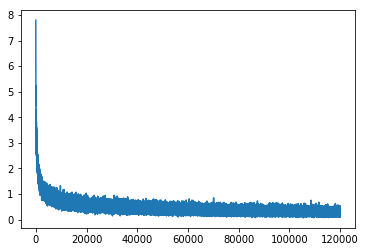

In [55]:
plt.plot(loss_history)

In [56]:
Y_pred = model.predict(X_test)

In [57]:
y_pred = np.argmax(Y_pred, axis=1)

In [58]:
y_pred[:5]

array([7, 2, 1, 0, 4], dtype=int64)

In [59]:
y_test = np.argmax(Y_test, axis=1)

In [60]:
np.mean(y_pred == y_test)

0.90910000000000002

In [61]:
layer1 = model.layers[0]

In [62]:
layer1.W.shape

(784, 50)

In [63]:
Z1 = layer1.forward(X_test)

In [64]:
Z1.shape

(10000, 50)

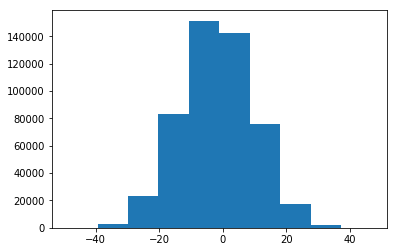

In [67]:
_ = plt.hist(Z1.flatten())

In [69]:
A1 = model.layers[1].forward(Z1)

In [68]:
layer2 = model.layers[2]

In [70]:
Z2 = layer2.forward(A1)

In [71]:
Z2.shape

(10000, 100)

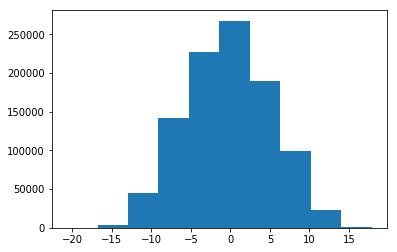

In [72]:
_ = plt.hist(Z2.flatten())

# tensorflow + keras

In [73]:
import keras

Using TensorFlow backend.


In [74]:
from keras.models import Sequential
from keras.layers import Dense # Affine

In [126]:
model = Sequential()

In [127]:
model.add(Dense(50, input_shape=(784,), 
                activation='relu', kernel_initializer='he_normal'))
model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(10, activation='softmax'))

In [128]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

In [129]:
history = model.fit(X_train, Y_train, 
                    epochs=100, batch_size=100, 
                    validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 26us/step - loss: 0.3535 - acc: 0.8944 - val_loss: 0.1675 - val_acc: 0.9511
Epoch 2/100
48000/48000 [==============================] - 1s 19us/step - loss: 0.1510 - acc: 0.9547 - val_loss: 0.1406 - val_acc: 0.9592
Epoch 3/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.1126 - acc: 0.9662 - val_loss: 0.1187 - val_acc: 0.9641
Epoch 4/100
48000/48000 [==============================] - 1s 19us/step - loss: 0.0919 - acc: 0.9713 - val_loss: 0.1068 - val_acc: 0.9688
Epoch 5/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0723 - acc: 0.9781 - val_loss: 0.1090 - val_acc: 0.9686
Epoch 6/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0602 - acc: 0.9810 - val_loss: 0.1111 - val_acc: 0.9703
Epoch 7/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0521 - acc: 0.9832 - val_loss: 0.1046 - 

48000/48000 [==============================] - 1s 18us/step - loss: 0.0111 - acc: 0.9967 - val_loss: 0.1901 - val_acc: 0.9715
Epoch 60/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0079 - acc: 0.9975 - val_loss: 0.1814 - val_acc: 0.9733
Epoch 61/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0032 - acc: 0.9989 - val_loss: 0.1816 - val_acc: 0.9759
Epoch 62/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0059 - acc: 0.9984 - val_loss: 0.1941 - val_acc: 0.9741
Epoch 63/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0059 - acc: 0.9980 - val_loss: 0.2047 - val_acc: 0.9723
Epoch 64/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0114 - acc: 0.9966 - val_loss: 0.1932 - val_acc: 0.9731
Epoch 65/100
48000/48000 [==============================] - 1s 18us/step - loss: 0.0047 - acc: 0.9986 - val_loss: 0.1801 - val_acc: 0.9755
Epoch 66/100
48000/48000 [==============

In [130]:
훈련결과 = pd.DataFrame(history.history)

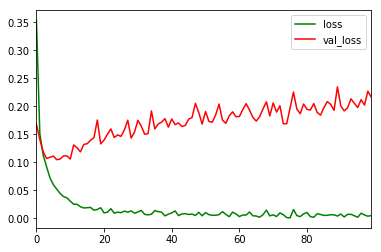

In [131]:
훈련결과[['loss', 'val_loss']].plot(
    style={'loss':'g-', 'val_loss': 'r-'})

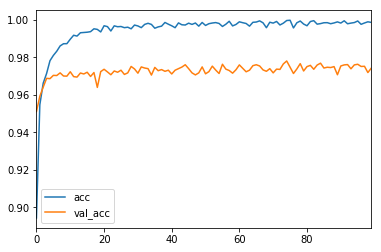

In [132]:
훈련결과[['acc', 'val_acc']].plot(
    style={'loss':'g-', 'val_loss': 'r-'})

In [133]:
Y_pred = model.predict(X_test)

In [134]:
scores = model.evaluate(X_test, Y_test)

10000/10000 [==============================] - 0s 16us/step


In [135]:
print('Loss: {}, Acc: {}'.format(*scores))

Loss: 0.18178514060520223, Acc: 0.9771


In [136]:
from keras.datasets import cifar10

In [137]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 37s 0us/step
